# Building the Dataset

In [ ]:
from google.colab import files
import zipfile
import os

# Upload your image folder as a zip file
uploaded = files.upload()

# Extract zip file
for fn in uploaded.keys():
    if fn.endswith('.zip'):
        with zipfile.ZipFile(fn, 'r') as zip_ref:
            zip_ref.extractall("data")  # This will extract to 'data/' folder
        print(f"{fn} extracted to /data/")

Saving images_1000.zip to images_1000.zip
images_1000.zip extracted to /data/


In [ ]:
import os
os.makedirs("data/hr_images", exist_ok=True)
os.makedirs("data/lr_images", exist_ok=True)

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

train_dir = "data"

for img in os.listdir( train_dir + "/images_1000"):
    img_array = cv2.imread(train_dir + "/images_1000/" + img)

    img_array = cv2.resize(img_array, (128,128))
    lr_img_array = cv2.resize(img_array,(32,32))
    cv2.imwrite(train_dir+ "/hr_images/" + img, img_array)
    cv2.imwrite(train_dir+ "/lr_images/"+ img, lr_img_array)


# SRGAN Training

# Installing Libraries

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

# Defining Generator

In [ ]:
def res_block(ip):

    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)

    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)

    return add([ip,res_model])

def upscale_block(ip):

    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)

    return up_model

def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

# Discriminator Block

In [ ]:
def discriminator_block(ip, filters, strides=1, bn=True):

    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)

    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)

    disc_model = LeakyReLU( alpha=0.2 )(disc_model)

    return disc_model

#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 64

    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)

    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)

In [ ]:
from keras.applications import VGG19

def build_vgg(hr_shape):

    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)

    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

# Combined Model of Generator and Discriminator

In [ ]:
#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)

    gen_features = vgg(gen_img)

    disc_model.trainable = False
    validity = disc_model(gen_img)

    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

# Training

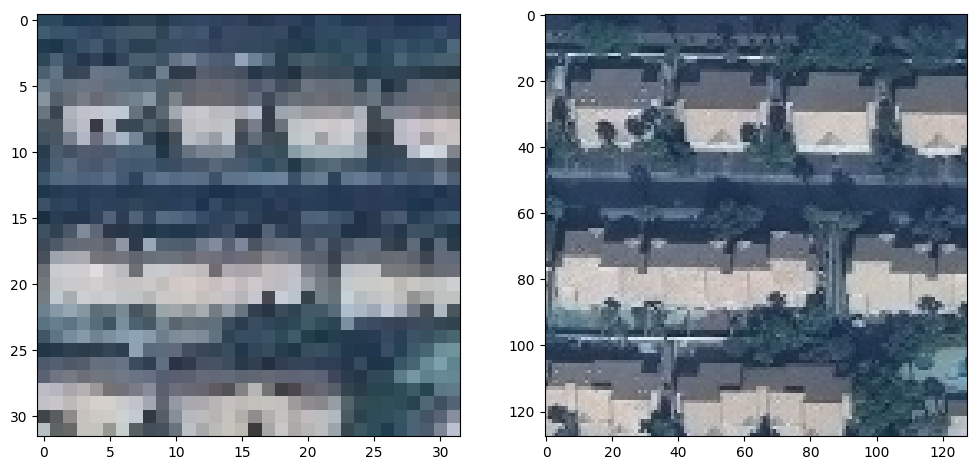

In [ ]:
n=5000
lr_list = os.listdir("data/lr_images")[:n]

lr_images = []
for img in lr_list:
    img_lr = cv2.imread("data/lr_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)


hr_list = os.listdir("data/hr_images")[:n]

hr_images = []
for img in hr_list:
    img_hr = cv2.imread("data/hr_images/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()

#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.

#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images,
                                                      test_size=0.33, random_state=42)



hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

In [ ]:
generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │     15,616 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu (PReLU)     │ (None, 32, 32,    │         64 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     36,928 │ p_re_lu[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_1 (PReLU)   │ (None, 32, 32,    │         64 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     36,928 │ p_re_lu_1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ p_re_lu[0][0],    │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │     36,928 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_2 (PReLU)   │ (None, 32, 32,    │         64 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     36,928 │ p_re_lu_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 32,    │          0 │ add[0][0],        │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ add_1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_5[0][0]  

 Total params: 2,044,291 (7.80 MB)

 Trainable params: 2,040,067 (7.78 MB)

 Non-trainable params: 4,224 (16.50 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 8, 8, 512)      │     2,359,80

 Total params: 38,249,281 (145.91 MB)

 Trainable params: 38,245,569 (145.90 MB)

 Non-trainable params: 3,712 (14.50 KB)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,325,568 (8.87 MB)

 Trainable params: 2,325,568 (8.87 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training.
batch_size = 1
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 128, 128,  │  2,044,291 │ input_layer[0][0] │
│ (Functional)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 1)         │ 38,249,281 │ functional[0][0]  │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_2        │ (None, 32, 32,    │  2,325,568 │ functional[0][0]  │
│ (Functional)        │ 256)              │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 42,619,140 (162.58 MB)

 Trainable params: 2,040,067 (7.78 MB)

 Non-trainable params: 40,579,073 (154.80 MB)

In [ ]:
epochs = 5
#Enumerate training over epochs
for e in range(epochs):

    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.

    #Create empty lists to populate gen and disc losses.
    g_losses = []
    d_losses = []

    #Enumerate training over batches.
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training

        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images

        #First, train the discriminator on fake and real HR images.
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)

        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False

        #Average the discriminator loss, just for reporting purposes.
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real)

        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)

        #Train the generator via GAN.
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])

        #Save losses to a list so we can average and report.
        d_losses.append(d_loss)
        g_losses.append(g_loss)

    #Convert the list of losses to an array to make it easy to average
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)

    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)

    #Report the progress during training.
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 5 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("gen_e_"+ str(e+1) +".h5")

  0%|          | 0/811 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  0%|          | 1/811 [00:00<07:31,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


  0%|          | 2/811 [00:01<09:13,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


  0%|          | 3/811 [00:01<07:27,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  0%|          | 4/811 [00:01<05:42,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  1%|          | 5/811 [00:02<04:32,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  1%|          | 6/811 [00:02<04:00,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  1%|          | 7/811 [00:02<03:25,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  1%|          | 8/811 [00:02<03:00,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  1%|          | 9/811 [00:02<02:43,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  1%|          | 10/811 [00:03<02:40,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  1%|▏         | 11/811 [00:03<02:38,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  1%|▏         | 12/811 [00:03<02:26,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  2%|▏         | 13/811 [00:03<02:26,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  2%|▏         | 14/811 [00:03<02:26,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  2%|▏         | 15/811 [00:03<02:28,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  2%|▏         | 16/811 [00:04<02:18,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  2%|▏         | 17/811 [00:04<02:22,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  2%|▏         | 18/811 [00:04<02:24,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  2%|▏         | 19/811 [00:04<02:15,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  2%|▏         | 20/811 [00:04<02:09,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  3%|▎         | 21/811 [00:04<02:03,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  3%|▎         | 22/811 [00:05<02:08,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  3%|▎         | 23/811 [00:05<02:02,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  3%|▎         | 24/811 [00:05<02:09,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  3%|▎         | 25/811 [00:05<02:03,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  3%|▎         | 26/811 [00:05<01:59,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  3%|▎         | 27/811 [00:05<02:07,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  3%|▎         | 28/811 [00:06<02:11,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  4%|▎         | 29/811 [00:06<02:05,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  4%|▎         | 30/811 [00:06<02:00,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  4%|▍         | 31/811 [00:06<02:00,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  4%|▍         | 32/811 [00:06<01:57,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  4%|▍         | 33/811 [00:06<01:54,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  4%|▍         | 34/811 [00:06<02:01,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  4%|▍         | 35/811 [00:07<01:57,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  4%|▍         | 36/811 [00:07<01:55,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  5%|▍         | 37/811 [00:07<01:53,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  5%|▍         | 38/811 [00:07<02:00,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  5%|▍         | 39/811 [00:07<01:58,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  5%|▍         | 40/811 [00:07<02:04,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  5%|▌         | 41/811 [00:08<01:59,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  5%|▌         | 42/811 [00:08<02:04,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  5%|▌         | 43/811 [00:08<02:00,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  5%|▌         | 44/811 [00:08<02:00,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  6%|▌         | 45/811 [00:08<02:07,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  6%|▌         | 46/811 [00:08<02:11,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  6%|▌         | 47/811 [00:09<02:14,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  6%|▌         | 48/811 [00:09<02:06,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  6%|▌         | 49/811 [00:09<02:10,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  6%|▌         | 50/811 [00:09<02:14,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  6%|▋         | 51/811 [00:09<02:17,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  6%|▋         | 52/811 [00:09<02:18,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  7%|▋         | 53/811 [00:10<02:19,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|▋         | 54/811 [00:10<02:12,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  7%|▋         | 55/811 [00:10<02:07,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  7%|▋         | 56/811 [00:10<02:11,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  7%|▋         | 57/811 [00:10<02:14,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  7%|▋         | 58/811 [00:11<02:15,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  7%|▋         | 59/811 [00:11<02:17,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  7%|▋         | 60/811 [00:11<02:25,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  8%|▊         | 61/811 [00:11<02:32,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  8%|▊         | 62/811 [00:11<02:27,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  8%|▊         | 63/811 [00:12<02:27,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  8%|▊         | 64/811 [00:12<02:24,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  8%|▊         | 65/811 [00:12<02:30,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


  8%|▊         | 66/811 [00:12<02:40,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  8%|▊         | 67/811 [00:12<02:41,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  8%|▊         | 68/811 [00:13<02:45,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  9%|▊         | 69/811 [00:13<02:40,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  9%|▊         | 70/811 [00:13<02:36,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  9%|▉         | 71/811 [00:13<02:26,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  9%|▉         | 72/811 [00:13<02:18,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  9%|▉         | 73/811 [00:14<02:20,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  9%|▉         | 74/811 [00:14<02:22,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  9%|▉         | 75/811 [00:14<02:25,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  9%|▉         | 76/811 [00:14<02:26,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  9%|▉         | 77/811 [00:14<02:25,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 10%|▉         | 78/811 [00:15<02:25,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 10%|▉         | 79/811 [00:15<02:25,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 10%|▉         | 80/811 [00:15<02:17,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 10%|▉         | 81/811 [00:15<02:10,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 10%|█         | 82/811 [00:15<02:15,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 10%|█         | 83/811 [00:15<02:16,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 10%|█         | 84/811 [00:16<02:16,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 10%|█         | 85/811 [00:16<02:16,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 11%|█         | 86/811 [00:16<02:07,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 11%|█         | 87/811 [00:16<02:12,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 11%|█         | 88/811 [00:16<02:06,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 11%|█         | 89/811 [00:17<02:11,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 11%|█         | 90/811 [00:17<02:13,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 11%|█         | 91/811 [00:17<02:14,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 11%|█▏        | 92/811 [00:17<02:15,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 11%|█▏        | 93/811 [00:17<02:09,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 12%|█▏        | 94/811 [00:17<02:11,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 12%|█▏        | 95/811 [00:18<02:03,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 12%|█▏        | 96/811 [00:18<02:06,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 12%|█▏        | 97/811 [00:18<02:08,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 12%|█▏        | 98/811 [00:18<02:01,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 12%|█▏        | 99/811 [00:18<02:06,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 12%|█▏        | 100/811 [00:19<02:01,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 12%|█▏        | 101/811 [00:19<01:56,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 13%|█▎        | 102/811 [00:19<02:01,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 13%|█▎        | 103/811 [00:19<02:04,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 13%|█▎        | 104/811 [00:19<02:06,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 13%|█▎        | 105/811 [00:19<02:10,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 13%|█▎        | 106/811 [00:20<02:04,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 13%|█▎        | 107/811 [00:20<01:57,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 13%|█▎        | 108/811 [00:20<02:00,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 13%|█▎        | 109/811 [00:20<02:02,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 14%|█▎        | 110/811 [00:20<02:03,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 14%|█▎        | 111/811 [00:20<02:08,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 14%|█▍        | 112/811 [00:21<02:01,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 14%|█▍        | 113/811 [00:21<01:56,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 14%|█▍        | 114/811 [00:21<02:00,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 14%|█▍        | 115/811 [00:21<01:56,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 14%|█▍        | 116/811 [00:21<01:51,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 14%|█▍        | 117/811 [00:21<01:57,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 15%|█▍        | 118/811 [00:22<01:52,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 15%|█▍        | 119/811 [00:22<01:49,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 15%|█▍        | 120/811 [00:22<01:46,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 15%|█▍        | 121/811 [00:22<01:44,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 15%|█▌        | 122/811 [00:22<01:50,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 15%|█▌        | 123/811 [00:22<01:56,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 15%|█▌        | 124/811 [00:23<02:00,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 15%|█▌        | 125/811 [00:23<02:04,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 16%|█▌        | 126/811 [00:23<02:11,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 16%|█▌        | 127/811 [00:23<02:16,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 16%|█▌        | 128/811 [00:23<02:13,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 16%|█▌        | 129/811 [00:24<02:19,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 16%|█▌        | 130/811 [00:24<02:15,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 16%|█▌        | 131/811 [00:24<02:19,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 16%|█▋        | 132/811 [00:24<02:22,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 16%|█▋        | 133/811 [00:24<02:25,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 17%|█▋        | 134/811 [00:25<02:28,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 17%|█▋        | 135/811 [00:25<02:16,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 17%|█▋        | 136/811 [00:25<02:14,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 17%|█▋        | 137/811 [00:25<02:14,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 17%|█▋        | 138/811 [00:25<02:13,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 17%|█▋        | 139/811 [00:26<02:13,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 17%|█▋        | 140/811 [00:26<02:05,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 17%|█▋        | 141/811 [00:26<02:05,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 18%|█▊        | 142/811 [00:26<02:05,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 18%|█▊        | 143/811 [00:26<01:56,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 18%|█▊        | 144/811 [00:27<01:58,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 18%|█▊        | 145/811 [00:27<02:00,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 18%|█▊        | 146/811 [00:27<02:01,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 18%|█▊        | 147/811 [00:27<01:58,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 18%|█▊        | 148/811 [00:27<02:01,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 18%|█▊        | 149/811 [00:27<02:02,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 18%|█▊        | 150/811 [00:28<01:56,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 19%|█▊        | 151/811 [00:28<01:59,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 19%|█▊        | 152/811 [00:28<02:07,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 19%|█▉        | 153/811 [00:28<02:05,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 19%|█▉        | 154/811 [00:28<02:02,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 19%|█▉        | 155/811 [00:29<02:02,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 19%|█▉        | 156/811 [00:29<02:01,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 19%|█▉        | 157/811 [00:29<02:05,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 19%|█▉        | 158/811 [00:29<02:10,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 20%|█▉        | 159/811 [00:29<02:09,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 20%|█▉        | 160/811 [00:30<02:14,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 20%|█▉        | 161/811 [00:30<02:06,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 20%|█▉        | 162/811 [00:30<02:07,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 20%|██        | 163/811 [00:30<02:07,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 20%|██        | 164/811 [00:30<01:58,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 20%|██        | 165/811 [00:30<01:53,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 20%|██        | 166/811 [00:31<01:56,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 21%|██        | 167/811 [00:31<01:58,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 21%|██        | 168/811 [00:31<02:00,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 21%|██        | 169/811 [00:31<02:01,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 21%|██        | 170/811 [00:31<01:54,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 21%|██        | 171/811 [00:32<02:03,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 21%|██        | 172/811 [00:32<01:55,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 21%|██▏       | 173/811 [00:32<01:51,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 21%|██▏       | 174/811 [00:32<01:55,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 22%|██▏       | 175/811 [00:32<01:50,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 22%|██▏       | 176/811 [00:32<01:47,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 22%|██▏       | 177/811 [00:33<01:51,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 22%|██▏       | 178/811 [00:33<01:46,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 22%|██▏       | 179/811 [00:33<01:45,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 22%|██▏       | 180/811 [00:33<01:48,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 22%|██▏       | 181/811 [00:33<01:50,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 22%|██▏       | 182/811 [00:33<01:44,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 23%|██▎       | 183/811 [00:34<01:49,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 23%|██▎       | 184/811 [00:34<01:45,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 23%|██▎       | 185/811 [00:34<01:44,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 23%|██▎       | 186/811 [00:34<01:48,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 23%|██▎       | 187/811 [00:34<01:44,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 23%|██▎       | 188/811 [00:35<01:47,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 23%|██▎       | 189/811 [00:35<01:51,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 23%|██▎       | 190/811 [00:35<01:58,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 24%|██▎       | 191/811 [00:35<01:58,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 24%|██▎       | 192/811 [00:35<02:01,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 24%|██▍       | 193/811 [00:35<01:58,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 24%|██▍       | 194/811 [00:36<01:55,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 24%|██▍       | 195/811 [00:36<01:59,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 24%|██▍       | 196/811 [00:36<02:08,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 24%|██▍       | 197/811 [00:36<02:11,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 24%|██▍       | 198/811 [00:37<02:15,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 25%|██▍       | 199/811 [00:37<02:15,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 25%|██▍       | 200/811 [00:37<02:11,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 25%|██▍       | 201/811 [00:37<02:01,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 25%|██▍       | 202/811 [00:37<01:53,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 25%|██▌       | 203/811 [00:37<01:48,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 25%|██▌       | 204/811 [00:38<01:43,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 25%|██▌       | 205/811 [00:38<01:38,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 25%|██▌       | 206/811 [00:38<01:34,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 26%|██▌       | 207/811 [00:38<01:37,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 26%|██▌       | 208/811 [00:38<01:41,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 26%|██▌       | 209/811 [00:39<01:57,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 26%|██▌       | 210/811 [00:39<02:24,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 26%|██▌       | 211/811 [00:39<02:09,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 26%|██▌       | 212/811 [00:39<02:04,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 26%|██▋       | 213/811 [00:39<02:00,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 26%|██▋       | 214/811 [00:40<01:50,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 27%|██▋       | 215/811 [00:40<01:43,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 27%|██▋       | 216/811 [00:40<01:44,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 27%|██▋       | 217/811 [00:40<01:46,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 27%|██▋       | 218/811 [00:40<01:41,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 27%|██▋       | 219/811 [00:40<01:44,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 27%|██▋       | 220/811 [00:41<01:39,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 27%|██▋       | 221/811 [00:41<01:42,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 27%|██▋       | 222/811 [00:41<01:45,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 27%|██▋       | 223/811 [00:41<01:41,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 28%|██▊       | 224/811 [00:41<01:44,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 28%|██▊       | 225/811 [00:41<01:39,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 28%|██▊       | 226/811 [00:42<01:35,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 28%|██▊       | 227/811 [00:42<01:32,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 28%|██▊       | 228/811 [00:42<01:30,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 28%|██▊       | 229/811 [00:42<01:34,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 28%|██▊       | 230/811 [00:42<01:40,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 28%|██▊       | 231/811 [00:42<01:42,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 29%|██▊       | 232/811 [00:43<01:44,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 29%|██▊       | 233/811 [00:43<01:45,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 29%|██▉       | 234/811 [00:43<01:45,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 29%|██▉       | 235/811 [00:43<01:39,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 29%|██▉       | 236/811 [00:43<01:36,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 29%|██▉       | 237/811 [00:44<01:39,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 29%|██▉       | 238/811 [00:44<01:36,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 29%|██▉       | 239/811 [00:44<01:38,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 30%|██▉       | 240/811 [00:44<01:39,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 30%|██▉       | 241/811 [00:44<01:34,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 30%|██▉       | 242/811 [00:44<01:32,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 30%|██▉       | 243/811 [00:45<01:36,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 30%|███       | 244/811 [00:45<01:39,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 30%|███       | 245/811 [00:45<01:41,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 30%|███       | 246/811 [00:45<01:37,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 30%|███       | 247/811 [00:45<01:39,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 31%|███       | 248/811 [00:45<01:41,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 31%|███       | 249/811 [00:46<01:42,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 31%|███       | 250/811 [00:46<01:42,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 31%|███       | 251/811 [00:46<01:43,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 31%|███       | 252/811 [00:46<01:43,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 31%|███       | 253/811 [00:46<01:42,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 31%|███▏      | 254/811 [00:47<01:42,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 31%|███▏      | 255/811 [00:47<01:45,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 32%|███▏      | 256/811 [00:47<01:50,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 32%|███▏      | 257/811 [00:47<01:51,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 32%|███▏      | 258/811 [00:47<01:51,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 32%|███▏      | 259/811 [00:48<02:57,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 32%|███▏      | 260/811 [00:49<03:31,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 32%|███▏      | 261/811 [00:49<03:07,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 32%|███▏      | 262/811 [00:49<03:29,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 32%|███▏      | 263/811 [00:50<03:14,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 33%|███▎      | 264/811 [00:50<02:43,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 33%|███▎      | 265/811 [00:50<02:27,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 33%|███▎      | 266/811 [00:50<02:16,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 33%|███▎      | 267/811 [00:50<02:04,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 33%|███▎      | 268/811 [00:50<02:00,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 33%|███▎      | 269/811 [00:51<01:58,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 33%|███▎      | 270/811 [00:51<01:56,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 33%|███▎      | 271/811 [00:51<01:54,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 34%|███▎      | 272/811 [00:51<01:53,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 34%|███▎      | 273/811 [00:52<01:53,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 34%|███▍      | 274/811 [00:52<01:48,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 34%|███▍      | 275/811 [00:52<01:43,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 34%|███▍      | 276/811 [00:52<01:44,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 34%|███▍      | 277/811 [00:52<01:45,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 34%|███▍      | 278/811 [00:52<01:46,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 34%|███▍      | 279/811 [00:53<01:49,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 35%|███▍      | 280/811 [00:53<01:43,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 35%|███▍      | 281/811 [00:53<01:45,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 35%|███▍      | 282/811 [00:53<01:40,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 35%|███▍      | 283/811 [00:53<01:37,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 35%|███▌      | 284/811 [00:54<01:39,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 35%|███▌      | 285/811 [00:54<01:34,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 35%|███▌      | 286/811 [00:54<01:30,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 35%|███▌      | 287/811 [00:54<01:32,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 36%|███▌      | 288/811 [00:54<01:28,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 36%|███▌      | 289/811 [00:54<01:30,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 36%|███▌      | 290/811 [00:55<01:31,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 36%|███▌      | 291/811 [00:55<01:29,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 36%|███▌      | 292/811 [00:55<01:25,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 36%|███▌      | 293/811 [00:55<01:29,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 36%|███▋      | 294/811 [00:55<01:26,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 36%|███▋      | 295/811 [00:55<01:29,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 36%|███▋      | 296/811 [00:56<01:31,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 37%|███▋      | 297/811 [00:56<01:33,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 37%|███▋      | 298/811 [00:56<01:28,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 37%|███▋      | 299/811 [00:56<01:24,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 37%|███▋      | 300/811 [00:56<01:27,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 37%|███▋      | 301/811 [00:56<01:23,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 37%|███▋      | 302/811 [00:57<01:26,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 37%|███▋      | 303/811 [00:57<01:29,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 37%|███▋      | 304/811 [00:57<01:30,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 38%|███▊      | 305/811 [00:57<01:27,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 38%|███▊      | 306/811 [00:57<01:28,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 38%|███▊      | 307/811 [00:58<01:29,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 38%|███▊      | 308/811 [00:58<01:31,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 38%|███▊      | 309/811 [00:58<01:31,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 38%|███▊      | 310/811 [00:58<01:31,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 38%|███▊      | 311/811 [00:58<01:31,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 38%|███▊      | 312/811 [00:58<01:25,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 39%|███▊      | 313/811 [00:59<01:21,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 39%|███▊      | 314/811 [00:59<01:25,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 39%|███▉      | 315/811 [00:59<01:32,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 39%|███▉      | 316/811 [00:59<01:34,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 39%|███▉      | 317/811 [00:59<01:37,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 39%|███▉      | 318/811 [01:00<01:39,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 39%|███▉      | 319/811 [01:00<01:41,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 39%|███▉      | 320/811 [01:00<01:38,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 40%|███▉      | 321/811 [01:00<01:38,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 40%|███▉      | 322/811 [01:00<01:40,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 40%|███▉      | 323/811 [01:01<01:44,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 40%|███▉      | 324/811 [01:01<01:46,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 40%|████      | 325/811 [01:01<01:42,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 40%|████      | 326/811 [01:01<01:39,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 40%|████      | 327/811 [01:01<01:33,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 40%|████      | 328/811 [01:02<01:36,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 41%|████      | 329/811 [01:02<01:31,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 41%|████      | 330/811 [01:02<01:27,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 41%|████      | 331/811 [01:02<01:29,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 41%|████      | 332/811 [01:02<01:29,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 41%|████      | 333/811 [01:03<01:29,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 41%|████      | 334/811 [01:03<01:30,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 41%|████▏     | 335/811 [01:03<01:29,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 41%|████▏     | 336/811 [01:03<01:28,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 42%|████▏     | 337/811 [01:03<01:27,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 42%|████▏     | 338/811 [01:04<01:27,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 42%|████▏     | 339/811 [01:04<01:28,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 42%|████▏     | 340/811 [01:04<01:28,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 42%|████▏     | 341/811 [01:04<01:29,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 42%|████▏     | 342/811 [01:04<01:30,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 42%|████▏     | 343/811 [01:04<01:30,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 42%|████▏     | 344/811 [01:05<01:30,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 43%|████▎     | 345/811 [01:05<01:24,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 43%|████▎     | 346/811 [01:05<01:20,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 43%|████▎     | 347/811 [01:05<01:23,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 43%|████▎     | 348/811 [01:05<01:24,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 43%|████▎     | 349/811 [01:06<01:25,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 43%|████▎     | 350/811 [01:06<01:20,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 43%|████▎     | 351/811 [01:06<01:23,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 43%|████▎     | 352/811 [01:06<01:21,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 44%|████▎     | 353/811 [01:06<01:23,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 44%|████▎     | 354/811 [01:06<01:24,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 44%|████▍     | 355/811 [01:07<01:24,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 44%|████▍     | 356/811 [01:07<01:21,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 44%|████▍     | 357/811 [01:07<01:18,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 44%|████▍     | 358/811 [01:07<01:22,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 44%|████▍     | 359/811 [01:07<01:22,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 44%|████▍     | 360/811 [01:08<01:22,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 45%|████▍     | 361/811 [01:08<01:22,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 45%|████▍     | 362/811 [01:08<01:22,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 45%|████▍     | 363/811 [01:08<01:24,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|████▍     | 364/811 [01:08<01:20,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 45%|████▌     | 365/811 [01:08<01:21,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 45%|████▌     | 366/811 [01:09<01:22,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|████▌     | 367/811 [01:09<01:22,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 45%|████▌     | 368/811 [01:09<01:18,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 45%|████▌     | 369/811 [01:09<01:20,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 46%|████▌     | 370/811 [01:09<01:16,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 46%|████▌     | 371/811 [01:09<01:12,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 46%|████▌     | 372/811 [01:10<01:10,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▌     | 373/811 [01:10<01:08,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 46%|████▌     | 374/811 [01:10<01:07,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▌     | 375/811 [01:10<01:11,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 46%|████▋     | 376/811 [01:10<01:14,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 46%|████▋     | 377/811 [01:10<01:16,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 47%|████▋     | 378/811 [01:11<01:17,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 47%|████▋     | 379/811 [01:11<01:18,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 47%|████▋     | 380/811 [01:11<01:22,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 47%|████▋     | 381/811 [01:11<01:26,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 47%|████▋     | 382/811 [01:12<01:25,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 47%|████▋     | 383/811 [01:12<01:27,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 47%|████▋     | 384/811 [01:12<01:24,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 47%|████▋     | 385/811 [01:12<01:26,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 48%|████▊     | 386/811 [01:12<01:28,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 48%|████▊     | 387/811 [01:13<01:29,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 48%|████▊     | 388/811 [01:13<01:33,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 48%|████▊     | 389/811 [01:13<01:33,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 48%|████▊     | 390/811 [01:13<01:31,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 48%|████▊     | 391/811 [01:13<01:29,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 48%|████▊     | 392/811 [01:14<01:27,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 48%|████▊     | 393/811 [01:14<01:26,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 49%|████▊     | 394/811 [01:14<01:25,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 49%|████▊     | 395/811 [01:14<01:20,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 49%|████▉     | 396/811 [01:14<01:21,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 49%|████▉     | 397/811 [01:15<01:20,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 49%|████▉     | 398/811 [01:15<01:16,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|████▉     | 399/811 [01:15<01:17,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 49%|████▉     | 400/811 [01:15<01:18,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 49%|████▉     | 401/811 [01:15<01:15,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 50%|████▉     | 402/811 [01:16<01:16,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 50%|████▉     | 403/811 [01:16<01:16,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 50%|████▉     | 404/811 [01:16<01:16,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 50%|████▉     | 405/811 [01:16<01:17,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 50%|█████     | 406/811 [01:16<01:16,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 50%|█████     | 407/811 [01:16<01:16,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 50%|█████     | 408/811 [01:17<01:15,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 50%|█████     | 409/811 [01:17<01:11,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 51%|█████     | 410/811 [01:17<01:07,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 51%|█████     | 411/811 [01:17<01:06,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 51%|█████     | 412/811 [01:17<01:09,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 51%|█████     | 413/811 [01:18<01:10,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 51%|█████     | 414/811 [01:18<01:11,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 51%|█████     | 415/811 [01:18<01:08,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 51%|█████▏    | 416/811 [01:18<01:10,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 51%|█████▏    | 417/811 [01:18<01:11,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 52%|█████▏    | 418/811 [01:18<01:11,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 52%|█████▏    | 419/811 [01:19<01:12,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 52%|█████▏    | 420/811 [01:19<01:12,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 52%|█████▏    | 421/811 [01:19<01:12,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 52%|█████▏    | 422/811 [01:19<01:09,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 52%|█████▏    | 423/811 [01:19<01:11,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 52%|█████▏    | 424/811 [01:20<01:12,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 52%|█████▏    | 425/811 [01:20<01:12,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 426/811 [01:20<01:13,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 53%|█████▎    | 427/811 [01:20<01:13,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 53%|█████▎    | 428/811 [01:20<01:14,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 53%|█████▎    | 429/811 [01:20<01:10,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 53%|█████▎    | 430/811 [01:21<01:12,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 53%|█████▎    | 431/811 [01:21<01:08,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 53%|█████▎    | 432/811 [01:21<01:09,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 53%|█████▎    | 433/811 [01:21<01:10,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 54%|█████▎    | 434/811 [01:21<01:10,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 54%|█████▎    | 435/811 [01:22<01:11,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 54%|█████▍    | 436/811 [01:22<01:07,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 54%|█████▍    | 437/811 [01:22<01:09,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 54%|█████▍    | 438/811 [01:22<01:10,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 54%|█████▍    | 439/811 [01:22<01:06,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 54%|█████▍    | 440/811 [01:22<01:03,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 54%|█████▍    | 441/811 [01:23<01:02,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 55%|█████▍    | 442/811 [01:23<01:04,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 55%|█████▍    | 443/811 [01:23<01:05,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 55%|█████▍    | 444/811 [01:23<01:10,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 55%|█████▍    | 445/811 [01:23<01:13,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 55%|█████▍    | 446/811 [01:24<01:12,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 55%|█████▌    | 447/811 [01:24<01:15,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 55%|█████▌    | 448/811 [01:24<01:14,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 55%|█████▌    | 449/811 [01:24<01:15,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 55%|█████▌    | 450/811 [01:25<01:17,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 56%|█████▌    | 451/811 [01:25<01:18,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 56%|█████▌    | 452/811 [01:25<01:20,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 56%|█████▌    | 453/811 [01:25<01:21,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 56%|█████▌    | 454/811 [01:25<01:18,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 56%|█████▌    | 455/811 [01:26<01:15,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 56%|█████▌    | 456/811 [01:26<01:11,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 56%|█████▋    | 457/811 [01:26<01:10,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 56%|█████▋    | 458/811 [01:26<01:09,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 57%|█████▋    | 459/811 [01:26<01:10,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 460/811 [01:27<01:10,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 57%|█████▋    | 461/811 [01:27<01:07,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 57%|█████▋    | 462/811 [01:27<01:08,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 57%|█████▋    | 463/811 [01:27<01:08,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 464/811 [01:27<01:08,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 57%|█████▋    | 465/811 [01:28<01:09,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 57%|█████▋    | 466/811 [01:28<01:08,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 58%|█████▊    | 467/811 [01:28<01:08,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 58%|█████▊    | 468/811 [01:28<01:08,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 58%|█████▊    | 469/811 [01:28<01:04,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 58%|█████▊    | 470/811 [01:29<01:05,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 58%|█████▊    | 471/811 [01:29<01:07,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 58%|█████▊    | 472/811 [01:29<01:09,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 58%|█████▊    | 473/811 [01:29<01:06,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 58%|█████▊    | 474/811 [01:29<01:07,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 59%|█████▊    | 475/811 [01:30<01:07,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▊    | 476/811 [01:30<01:04,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 59%|█████▉    | 477/811 [01:30<01:05,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 59%|█████▉    | 478/811 [01:30<01:02,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 59%|█████▉    | 479/811 [01:30<01:03,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 59%|█████▉    | 480/811 [01:30<01:04,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 59%|█████▉    | 481/811 [01:31<01:01,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 59%|█████▉    | 482/811 [01:31<00:58,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 60%|█████▉    | 483/811 [01:31<01:01,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 60%|█████▉    | 484/811 [01:31<01:01,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 60%|█████▉    | 485/811 [01:31<01:02,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 60%|█████▉    | 486/811 [01:32<01:02,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 60%|██████    | 487/811 [01:32<01:02,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 60%|██████    | 488/811 [01:32<01:02,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 60%|██████    | 489/811 [01:32<00:58,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 60%|██████    | 490/811 [01:32<00:59,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 61%|██████    | 491/811 [01:33<00:59,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 61%|██████    | 492/811 [01:33<00:56,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 61%|██████    | 493/811 [01:33<00:53,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 61%|██████    | 494/811 [01:33<00:53,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████    | 495/811 [01:33<00:55,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 61%|██████    | 496/811 [01:33<00:56,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 61%|██████▏   | 497/811 [01:34<00:57,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 61%|██████▏   | 498/811 [01:34<00:57,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 62%|██████▏   | 499/811 [01:34<00:58,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 62%|██████▏   | 500/811 [01:34<00:58,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 62%|██████▏   | 501/811 [01:34<00:55,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 62%|██████▏   | 502/811 [01:34<00:55,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 62%|██████▏   | 503/811 [01:35<00:56,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 62%|██████▏   | 504/811 [01:35<00:56,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 62%|██████▏   | 505/811 [01:35<00:56,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 62%|██████▏   | 506/811 [01:35<00:59,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 63%|██████▎   | 507/811 [01:35<01:00,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 63%|██████▎   | 508/811 [01:36<01:02,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 63%|██████▎   | 509/811 [01:36<01:03,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 63%|██████▎   | 510/811 [01:36<01:05,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 63%|██████▎   | 511/811 [01:36<01:03,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 63%|██████▎   | 512/811 [01:37<01:05,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 63%|██████▎   | 513/811 [01:37<01:05,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 63%|██████▎   | 514/811 [01:37<01:06,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 64%|██████▎   | 515/811 [01:37<01:07,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 64%|██████▎   | 516/811 [01:37<01:04,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 64%|██████▎   | 517/811 [01:38<01:02,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 64%|██████▍   | 518/811 [01:38<01:00,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 64%|██████▍   | 519/811 [01:38<00:59,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 64%|██████▍   | 520/811 [01:38<00:59,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 64%|██████▍   | 521/811 [01:38<00:59,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 64%|██████▍   | 522/811 [01:39<00:55,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 64%|██████▍   | 523/811 [01:39<00:56,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 65%|██████▍   | 524/811 [01:39<00:57,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 65%|██████▍   | 525/811 [01:39<00:57,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 65%|██████▍   | 526/811 [01:39<00:57,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 65%|██████▍   | 527/811 [01:40<00:54,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 65%|██████▌   | 528/811 [01:40<00:51,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 65%|██████▌   | 529/811 [01:40<00:49,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 65%|██████▌   | 530/811 [01:40<00:48,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 65%|██████▌   | 531/811 [01:40<00:51,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 66%|██████▌   | 532/811 [01:41<00:52,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 66%|██████▌   | 533/811 [01:41<00:50,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 66%|██████▌   | 534/811 [01:41<00:48,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 66%|██████▌   | 535/811 [01:41<00:49,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 66%|██████▌   | 536/811 [01:41<00:50,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 66%|██████▌   | 537/811 [01:41<00:51,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 66%|██████▋   | 538/811 [01:42<00:51,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 66%|██████▋   | 539/811 [01:42<00:50,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 67%|██████▋   | 540/811 [01:42<00:50,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 67%|██████▋   | 541/811 [01:42<00:50,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 67%|██████▋   | 542/811 [01:42<00:50,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 67%|██████▋   | 543/811 [01:43<00:51,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 67%|██████▋   | 544/811 [01:43<00:51,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 67%|██████▋   | 545/811 [01:43<00:49,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 67%|██████▋   | 546/811 [01:43<00:49,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 67%|██████▋   | 547/811 [01:43<00:49,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 68%|██████▊   | 548/811 [01:43<00:50,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 68%|██████▊   | 549/811 [01:44<00:47,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 68%|██████▊   | 550/811 [01:44<00:47,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 68%|██████▊   | 551/811 [01:44<00:48,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 68%|██████▊   | 552/811 [01:44<00:48,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 68%|██████▊   | 553/811 [01:44<00:48,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 68%|██████▊   | 554/811 [01:45<00:45,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 68%|██████▊   | 555/811 [01:45<00:46,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 69%|██████▊   | 556/811 [01:45<00:47,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 69%|██████▊   | 557/811 [01:45<00:48,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 69%|██████▉   | 558/811 [01:45<00:48,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 69%|██████▉   | 559/811 [01:46<00:48,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 69%|██████▉   | 560/811 [01:46<00:46,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 69%|██████▉   | 561/811 [01:46<00:44,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 69%|██████▉   | 562/811 [01:46<00:42,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 69%|██████▉   | 563/811 [01:46<00:41,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 70%|██████▉   | 564/811 [01:46<00:40,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 70%|██████▉   | 565/811 [01:47<00:42,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 70%|██████▉   | 566/811 [01:47<00:43,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 70%|██████▉   | 567/811 [01:47<00:42,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 70%|███████   | 568/811 [01:47<00:43,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 70%|███████   | 569/811 [01:47<00:45,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 70%|███████   | 570/811 [01:47<00:46,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 70%|███████   | 571/811 [01:48<00:46,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 71%|███████   | 572/811 [01:48<00:46,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 71%|███████   | 573/811 [01:48<00:46,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 71%|███████   | 574/811 [01:48<00:46,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 71%|███████   | 575/811 [01:48<00:45,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 71%|███████   | 576/811 [01:49<00:46,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 71%|███████   | 577/811 [01:49<00:47,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 71%|███████▏  | 578/811 [01:49<00:48,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 71%|███████▏  | 579/811 [01:49<00:50,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 72%|███████▏  | 580/811 [01:50<00:49,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 72%|███████▏  | 581/811 [01:50<00:48,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 72%|███████▏  | 582/811 [01:50<00:47,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 72%|███████▏  | 583/811 [01:50<00:44,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 72%|███████▏  | 584/811 [01:50<00:44,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 72%|███████▏  | 585/811 [01:51<00:44,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 72%|███████▏  | 586/811 [01:51<00:44,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 72%|███████▏  | 587/811 [01:51<00:44,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 73%|███████▎  | 588/811 [01:51<00:41,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 73%|███████▎  | 589/811 [01:51<00:41,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 73%|███████▎  | 590/811 [01:51<00:39,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 73%|███████▎  | 591/811 [01:52<00:38,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 73%|███████▎  | 592/811 [01:52<00:39,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 73%|███████▎  | 593/811 [01:52<00:41,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 594/811 [01:52<00:41,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 73%|███████▎  | 595/811 [01:52<00:40,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 73%|███████▎  | 596/811 [01:53<00:40,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 74%|███████▎  | 597/811 [01:53<00:41,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 74%|███████▎  | 598/811 [01:53<00:41,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 74%|███████▍  | 599/811 [01:53<00:40,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 74%|███████▍  | 600/811 [01:53<00:40,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 74%|███████▍  | 601/811 [01:54<00:40,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 74%|███████▍  | 602/811 [01:54<00:39,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 74%|███████▍  | 603/811 [01:54<00:38,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 74%|███████▍  | 604/811 [01:54<00:38,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 75%|███████▍  | 605/811 [01:54<00:39,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 75%|███████▍  | 606/811 [01:54<00:39,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 75%|███████▍  | 607/811 [01:55<00:39,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 75%|███████▍  | 608/811 [01:55<00:39,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 75%|███████▌  | 609/811 [01:55<00:38,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 75%|███████▌  | 610/811 [01:55<00:38,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 75%|███████▌  | 611/811 [01:55<00:38,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 75%|███████▌  | 612/811 [01:56<00:36,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 76%|███████▌  | 613/811 [01:56<00:37,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 76%|███████▌  | 614/811 [01:56<00:37,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 76%|███████▌  | 615/811 [01:56<00:38,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 76%|███████▌  | 616/811 [01:56<00:36,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 76%|███████▌  | 617/811 [01:57<00:35,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 76%|███████▌  | 618/811 [01:57<00:34,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 76%|███████▋  | 619/811 [01:57<00:35,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 76%|███████▋  | 620/811 [01:57<00:33,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 77%|███████▋  | 621/811 [01:57<00:34,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 77%|███████▋  | 622/811 [01:57<00:34,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 77%|███████▋  | 623/811 [01:58<00:33,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 77%|███████▋  | 624/811 [01:58<00:33,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 77%|███████▋  | 625/811 [01:58<00:33,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 77%|███████▋  | 626/811 [01:58<00:34,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 77%|███████▋  | 627/811 [01:58<00:32,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 77%|███████▋  | 628/811 [01:59<00:33,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 78%|███████▊  | 629/811 [01:59<00:31,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 78%|███████▊  | 630/811 [01:59<00:32,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 78%|███████▊  | 631/811 [01:59<00:32,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 78%|███████▊  | 632/811 [01:59<00:33,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 78%|███████▊  | 633/811 [01:59<00:33,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 78%|███████▊  | 634/811 [02:00<00:34,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 78%|███████▊  | 635/811 [02:00<00:35,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 78%|███████▊  | 636/811 [02:00<00:34,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 79%|███████▊  | 637/811 [02:00<00:35,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 79%|███████▊  | 638/811 [02:01<00:35,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 79%|███████▉  | 639/811 [02:01<00:36,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 79%|███████▉  | 640/811 [02:01<00:37,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 79%|███████▉  | 641/811 [02:01<00:37,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 79%|███████▉  | 642/811 [02:01<00:38,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 79%|███████▉  | 643/811 [02:02<00:37,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 79%|███████▉  | 644/811 [02:02<00:36,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 80%|███████▉  | 645/811 [02:02<00:35,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 80%|███████▉  | 646/811 [02:02<00:35,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 80%|███████▉  | 647/811 [02:02<00:32,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 80%|███████▉  | 648/811 [02:03<00:30,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 80%|████████  | 649/811 [02:03<00:28,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 80%|████████  | 650/811 [02:03<00:28,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 80%|████████  | 651/811 [02:03<00:28,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 80%|████████  | 652/811 [02:03<00:29,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 81%|████████  | 653/811 [02:03<00:29,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 81%|████████  | 654/811 [02:04<00:28,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 81%|████████  | 655/811 [02:04<00:28,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 81%|████████  | 656/811 [02:04<00:28,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 81%|████████  | 657/811 [02:04<00:28,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 81%|████████  | 658/811 [02:04<00:28,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 81%|████████▏ | 659/811 [02:05<00:26,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 81%|████████▏ | 660/811 [02:05<00:26,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 82%|████████▏ | 661/811 [02:05<00:25,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 82%|████████▏ | 662/811 [02:05<00:26,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 82%|████████▏ | 663/811 [02:05<00:27,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 82%|████████▏ | 664/811 [02:05<00:27,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 82%|████████▏ | 665/811 [02:06<00:27,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 82%|████████▏ | 666/811 [02:06<00:27,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 82%|████████▏ | 667/811 [02:06<00:27,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 82%|████████▏ | 668/811 [02:06<00:26,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 82%|████████▏ | 669/811 [02:06<00:26,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 83%|████████▎ | 670/811 [02:07<00:24,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 83%|████████▎ | 671/811 [02:07<00:23,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 83%|████████▎ | 672/811 [02:07<00:23,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 83%|████████▎ | 673/811 [02:07<00:23,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 83%|████████▎ | 674/811 [02:07<00:23,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 83%|████████▎ | 675/811 [02:07<00:24,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 83%|████████▎ | 676/811 [02:08<00:24,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 83%|████████▎ | 677/811 [02:08<00:23,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 84%|████████▎ | 678/811 [02:08<00:22,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 84%|████████▎ | 679/811 [02:08<00:23,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 84%|████████▍ | 680/811 [02:08<00:24,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 84%|████████▍ | 681/811 [02:08<00:22,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 84%|████████▍ | 682/811 [02:09<00:23,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 84%|████████▍ | 683/811 [02:09<00:22,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 84%|████████▍ | 684/811 [02:09<00:22,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 84%|████████▍ | 685/811 [02:09<00:22,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 85%|████████▍ | 686/811 [02:09<00:21,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 85%|████████▍ | 687/811 [02:10<00:21,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 85%|████████▍ | 688/811 [02:10<00:20,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 85%|████████▍ | 689/811 [02:10<00:19,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 85%|████████▌ | 690/811 [02:10<00:20,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 85%|████████▌ | 691/811 [02:10<00:21,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 85%|████████▌ | 692/811 [02:10<00:20,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 85%|████████▌ | 693/811 [02:11<00:20,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 86%|████████▌ | 694/811 [02:11<00:19,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 86%|████████▌ | 695/811 [02:11<00:20,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 86%|████████▌ | 696/811 [02:11<00:19,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 86%|████████▌ | 697/811 [02:11<00:19,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 86%|████████▌ | 698/811 [02:11<00:20,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 86%|████████▌ | 699/811 [02:12<00:20,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 86%|████████▋ | 700/811 [02:12<00:21,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 86%|████████▋ | 701/811 [02:12<00:22,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 87%|████████▋ | 702/811 [02:12<00:22,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 87%|████████▋ | 703/811 [02:12<00:22,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 87%|████████▋ | 704/811 [02:13<00:22,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 87%|████████▋ | 705/811 [02:13<00:22,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 87%|████████▋ | 706/811 [02:13<00:22,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 87%|████████▋ | 707/811 [02:13<00:22,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 87%|████████▋ | 708/811 [02:14<00:22,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 87%|████████▋ | 709/811 [02:14<00:22,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 88%|████████▊ | 710/811 [02:14<00:21,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 88%|████████▊ | 711/811 [02:14<00:20,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 88%|████████▊ | 712/811 [02:14<00:20,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 88%|████████▊ | 713/811 [02:15<00:20,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 88%|████████▊ | 714/811 [02:15<00:19,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 88%|████████▊ | 715/811 [02:15<00:19,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 88%|████████▊ | 716/811 [02:15<00:19,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 88%|████████▊ | 717/811 [02:15<00:19,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 89%|████████▊ | 718/811 [02:16<00:18,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 89%|████████▊ | 719/811 [02:16<00:17,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 89%|████████▉ | 720/811 [02:16<00:16,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 89%|████████▉ | 721/811 [02:16<00:16,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 89%|████████▉ | 722/811 [02:16<00:15,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 89%|████████▉ | 723/811 [02:16<00:15,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 89%|████████▉ | 724/811 [02:17<00:15,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 89%|████████▉ | 725/811 [02:17<00:15,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 90%|████████▉ | 726/811 [02:17<00:15,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 90%|████████▉ | 727/811 [02:17<00:14,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 90%|████████▉ | 728/811 [02:17<00:15,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 90%|████████▉ | 729/811 [02:18<00:14,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 90%|█████████ | 730/811 [02:18<00:13,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 90%|█████████ | 731/811 [02:18<00:13,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 90%|█████████ | 732/811 [02:18<00:13,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 90%|█████████ | 733/811 [02:18<00:12,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 91%|█████████ | 734/811 [02:18<00:13,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 91%|█████████ | 735/811 [02:19<00:13,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 91%|█████████ | 736/811 [02:19<00:12,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 91%|█████████ | 737/811 [02:19<00:13,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 91%|█████████ | 738/811 [02:19<00:13,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 91%|█████████ | 739/811 [02:19<00:12,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 91%|█████████ | 740/811 [02:19<00:11,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 91%|█████████▏| 741/811 [02:20<00:12,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 91%|█████████▏| 742/811 [02:20<00:12,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 92%|█████████▏| 743/811 [02:20<00:12,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 92%|█████████▏| 744/811 [02:20<00:12,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 92%|█████████▏| 745/811 [02:20<00:12,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 92%|█████████▏| 746/811 [02:21<00:12,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 92%|█████████▏| 747/811 [02:21<00:12,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 92%|█████████▏| 748/811 [02:21<00:11,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 92%|█████████▏| 749/811 [02:21<00:11,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 92%|█████████▏| 750/811 [02:21<00:11,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 93%|█████████▎| 751/811 [02:21<00:11,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 93%|█████████▎| 752/811 [02:22<00:10,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 93%|█████████▎| 753/811 [02:22<00:10,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 93%|█████████▎| 754/811 [02:22<00:10,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 93%|█████████▎| 755/811 [02:22<00:09,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 93%|█████████▎| 756/811 [02:22<00:09,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 93%|█████████▎| 757/811 [02:23<00:09,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 93%|█████████▎| 758/811 [02:23<00:09,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 94%|█████████▎| 759/811 [02:23<00:08,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 94%|█████████▎| 760/811 [02:23<00:09,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 94%|█████████▍| 761/811 [02:23<00:09,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 94%|█████████▍| 762/811 [02:23<00:08,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▍| 763/811 [02:24<00:08,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 94%|█████████▍| 764/811 [02:24<00:08,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 94%|█████████▍| 765/811 [02:24<00:08,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 94%|█████████▍| 766/811 [02:24<00:08,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 95%|█████████▍| 767/811 [02:24<00:08,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 95%|█████████▍| 768/811 [02:25<00:08,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 95%|█████████▍| 769/811 [02:25<00:08,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 95%|█████████▍| 770/811 [02:25<00:08,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 95%|█████████▌| 771/811 [02:25<00:08,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 95%|█████████▌| 772/811 [02:26<00:08,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 95%|█████████▌| 773/811 [02:26<00:08,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 95%|█████████▌| 774/811 [02:26<00:08,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 96%|█████████▌| 775/811 [02:26<00:07,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 96%|█████████▌| 776/811 [02:26<00:07,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 96%|█████████▌| 777/811 [02:27<00:06,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 96%|█████████▌| 778/811 [02:27<00:06,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 96%|█████████▌| 779/811 [02:27<00:06,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 96%|█████████▌| 780/811 [02:27<00:05,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 96%|█████████▋| 781/811 [02:27<00:05,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 96%|█████████▋| 782/811 [02:27<00:05,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 97%|█████████▋| 783/811 [02:28<00:04,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 97%|█████████▋| 784/811 [02:28<00:04,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 97%|█████████▋| 785/811 [02:28<00:04,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 97%|█████████▋| 786/811 [02:28<00:04,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 97%|█████████▋| 787/811 [02:28<00:04,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 97%|█████████▋| 788/811 [02:29<00:03,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 97%|█████████▋| 789/811 [02:29<00:03,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 97%|█████████▋| 790/811 [02:29<00:03,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 98%|█████████▊| 791/811 [02:29<00:03,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 98%|█████████▊| 792/811 [02:29<00:03,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 98%|█████████▊| 793/811 [02:29<00:03,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 98%|█████████▊| 794/811 [02:30<00:02,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 98%|█████████▊| 795/811 [02:30<00:02,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 98%|█████████▊| 796/811 [02:30<00:02,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 98%|█████████▊| 797/811 [02:30<00:02,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 98%|█████████▊| 798/811 [02:30<00:02,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 99%|█████████▊| 799/811 [02:31<00:02,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 99%|█████████▊| 800/811 [02:31<00:02,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 99%|█████████▉| 801/811 [02:31<00:01,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 99%|█████████▉| 802/811 [02:31<00:01,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 99%|█████████▉| 803/811 [02:31<00:01,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 99%|█████████▉| 804/811 [02:31<00:01,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 99%|█████████▉| 805/811 [02:32<00:01,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 99%|█████████▉| 806/811 [02:32<00:00,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


100%|█████████▉| 807/811 [02:32<00:00,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


100%|█████████▉| 808/811 [02:32<00:00,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


100%|█████████▉| 809/811 [02:32<00:00,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


100%|█████████▉| 810/811 [02:32<00:00,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


100%|██████████| 811/811 [02:33<00:00,  5.29it/s]


epoch: 1 g_loss: 684.6701 d_loss: [0.9838631 0.9471493]


  0%|          | 0/811 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  0%|          | 1/811 [00:00<02:13,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  0%|          | 2/811 [00:00<02:25,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 3/811 [00:00<02:31,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 4/811 [00:00<02:32,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  1%|          | 5/811 [00:00<02:22,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  1%|          | 6/811 [00:01<02:24,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  1%|          | 7/811 [00:01<02:25,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  1%|          | 8/811 [00:01<02:29,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  1%|          | 9/811 [00:01<02:30,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  1%|          | 10/811 [00:01<02:30,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  1%|▏         | 11/811 [00:02<02:23,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  1%|▏         | 12/811 [00:02<02:25,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  2%|▏         | 13/811 [00:02<02:27,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  2%|▏         | 14/811 [00:02<02:28,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  2%|▏         | 15/811 [00:02<02:28,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  2%|▏         | 16/811 [00:02<02:21,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  2%|▏         | 17/811 [00:03<02:23,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  2%|▏         | 18/811 [00:03<02:19,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  2%|▏         | 19/811 [00:03<02:29,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


  2%|▏         | 20/811 [00:03<02:41,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  3%|▎         | 21/811 [00:03<02:42,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  3%|▎         | 22/811 [00:04<02:40,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  3%|▎         | 23/811 [00:04<02:36,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  3%|▎         | 24/811 [00:04<02:38,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


  3%|▎         | 25/811 [00:04<02:42,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  3%|▎         | 26/811 [00:04<02:41,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  3%|▎         | 27/811 [00:05<02:46,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  3%|▎         | 28/811 [00:05<02:49,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  4%|▎         | 29/811 [00:05<02:46,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  4%|▎         | 30/811 [00:05<02:44,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▍         | 31/811 [00:05<02:32,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▍         | 32/811 [00:06<02:25,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  4%|▍         | 33/811 [00:06<02:18,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▍         | 34/811 [00:06<02:21,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  4%|▍         | 35/811 [00:06<02:15,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  4%|▍         | 36/811 [00:06<02:20,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  5%|▍         | 37/811 [00:07<02:15,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  5%|▍         | 38/811 [00:07<02:18,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  5%|▍         | 39/811 [00:07<02:12,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▍         | 40/811 [00:07<02:08,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  5%|▌         | 41/811 [00:07<02:04,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  5%|▌         | 42/811 [00:07<02:04,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  5%|▌         | 43/811 [00:07<02:08,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  5%|▌         | 44/811 [00:08<02:07,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  6%|▌         | 45/811 [00:08<02:11,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  6%|▌         | 46/811 [00:08<02:14,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  6%|▌         | 47/811 [00:08<02:17,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▌         | 48/811 [00:08<02:12,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  6%|▌         | 49/811 [00:09<02:15,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  6%|▌         | 50/811 [00:09<02:10,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  6%|▋         | 51/811 [00:09<02:14,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  6%|▋         | 52/811 [00:09<02:16,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  7%|▋         | 53/811 [00:09<02:17,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  7%|▋         | 54/811 [00:09<02:11,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  7%|▋         | 55/811 [00:10<02:13,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|▋         | 56/811 [00:10<02:17,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  7%|▋         | 57/811 [00:10<02:19,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  7%|▋         | 58/811 [00:10<02:14,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  7%|▋         | 59/811 [00:10<02:17,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|▋         | 60/811 [00:11<02:19,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  8%|▊         | 61/811 [00:11<02:21,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  8%|▊         | 62/811 [00:11<02:23,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  8%|▊         | 63/811 [00:11<02:17,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  8%|▊         | 64/811 [00:11<02:19,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  8%|▊         | 65/811 [00:11<02:13,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  8%|▊         | 66/811 [00:12<02:16,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  8%|▊         | 67/811 [00:12<02:16,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  8%|▊         | 68/811 [00:12<02:19,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  9%|▊         | 69/811 [00:12<02:20,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  9%|▊         | 70/811 [00:12<02:21,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  9%|▉         | 71/811 [00:13<02:14,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  9%|▉         | 72/811 [00:13<02:11,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  9%|▉         | 73/811 [00:13<02:07,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  9%|▉         | 74/811 [00:13<02:11,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  9%|▉         | 75/811 [00:13<02:14,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  9%|▉         | 76/811 [00:14<02:16,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  9%|▉         | 77/811 [00:14<02:16,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 10%|▉         | 78/811 [00:14<02:15,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 10%|▉         | 79/811 [00:14<02:16,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 10%|▉         | 80/811 [00:14<02:17,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 10%|▉         | 81/811 [00:14<02:17,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 10%|█         | 82/811 [00:15<02:19,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 10%|█         | 83/811 [00:15<02:13,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 10%|█         | 84/811 [00:15<02:18,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 10%|█         | 85/811 [00:15<02:25,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 11%|█         | 86/811 [00:15<02:25,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 11%|█         | 87/811 [00:16<02:33,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 11%|█         | 88/811 [00:16<02:28,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 11%|█         | 89/811 [00:16<02:32,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 11%|█         | 90/811 [00:16<02:34,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 11%|█         | 91/811 [00:17<02:38,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 11%|█▏        | 92/811 [00:17<02:43,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 11%|█▏        | 93/811 [00:17<02:45,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 12%|█▏        | 94/811 [00:17<02:41,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 12%|█▏        | 95/811 [00:17<02:29,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 12%|█▏        | 96/811 [00:18<02:28,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 12%|█▏        | 97/811 [00:18<02:28,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 12%|█▏        | 98/811 [00:18<02:27,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 12%|█▏        | 99/811 [00:18<02:21,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 12%|█▏        | 100/811 [00:18<02:15,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 12%|█▏        | 101/811 [00:19<02:15,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 13%|█▎        | 102/811 [00:19<02:18,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 13%|█▎        | 103/811 [00:19<02:17,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 13%|█▎        | 104/811 [00:19<02:19,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 13%|█▎        | 105/811 [00:19<02:20,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 13%|█▎        | 106/811 [00:20<02:13,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 13%|█▎        | 107/811 [00:20<02:10,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 13%|█▎        | 108/811 [00:20<02:12,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 13%|█▎        | 109/811 [00:20<02:13,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 14%|█▎        | 110/811 [00:20<02:08,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 14%|█▎        | 111/811 [00:20<02:10,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 14%|█▍        | 112/811 [00:21<02:04,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 14%|█▍        | 113/811 [00:21<02:03,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 14%|█▍        | 114/811 [00:21<02:06,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|█▍        | 115/811 [00:21<02:08,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 14%|█▍        | 116/811 [00:21<02:07,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 14%|█▍        | 117/811 [00:22<02:09,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 15%|█▍        | 118/811 [00:22<02:11,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 15%|█▍        | 119/811 [00:22<02:14,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 15%|█▍        | 120/811 [00:22<02:15,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 15%|█▍        | 121/811 [00:22<02:15,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 15%|█▌        | 122/811 [00:23<02:14,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 15%|█▌        | 123/811 [00:23<02:15,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 15%|█▌        | 124/811 [00:23<02:08,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 15%|█▌        | 125/811 [00:23<02:03,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 16%|█▌        | 126/811 [00:23<02:05,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 16%|█▌        | 127/811 [00:23<02:07,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 16%|█▌        | 128/811 [00:24<02:10,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 16%|█▌        | 129/811 [00:24<02:05,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 16%|█▌        | 130/811 [00:24<02:08,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 16%|█▌        | 131/811 [00:24<02:03,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 16%|█▋        | 132/811 [00:24<02:00,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 16%|█▋        | 133/811 [00:25<02:02,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 17%|█▋        | 134/811 [00:25<01:57,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 17%|█▋        | 135/811 [00:25<02:00,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 17%|█▋        | 136/811 [00:25<02:03,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 17%|█▋        | 137/811 [00:25<02:04,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 17%|█▋        | 138/811 [00:25<02:04,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 17%|█▋        | 139/811 [00:26<02:04,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 17%|█▋        | 140/811 [00:26<02:07,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 17%|█▋        | 141/811 [00:26<02:08,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 18%|█▊        | 142/811 [00:26<02:09,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 18%|█▊        | 143/811 [00:26<02:04,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 18%|█▊        | 144/811 [00:27<02:06,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 18%|█▊        | 145/811 [00:27<02:08,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 18%|█▊        | 146/811 [00:27<02:07,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 18%|█▊        | 147/811 [00:27<02:10,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 18%|█▊        | 148/811 [00:27<02:15,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 18%|█▊        | 149/811 [00:28<02:13,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 18%|█▊        | 150/811 [00:28<02:12,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 19%|█▊        | 151/811 [00:28<02:17,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 19%|█▊        | 152/811 [00:28<02:20,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 19%|█▉        | 153/811 [00:29<02:23,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 19%|█▉        | 154/811 [00:29<02:26,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 19%|█▉        | 155/811 [00:29<02:23,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 19%|█▉        | 156/811 [00:29<02:28,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 19%|█▉        | 157/811 [00:29<02:31,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 19%|█▉        | 158/811 [00:30<02:20,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 20%|█▉        | 159/811 [00:30<02:10,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 20%|█▉        | 160/811 [00:30<02:09,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 20%|█▉        | 161/811 [00:30<02:03,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 20%|█▉        | 162/811 [00:30<01:57,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 20%|██        | 163/811 [00:31<01:58,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 20%|██        | 164/811 [00:31<02:00,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 20%|██        | 165/811 [00:31<01:56,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 20%|██        | 166/811 [00:31<01:53,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 21%|██        | 167/811 [00:31<01:58,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 21%|██        | 168/811 [00:31<02:00,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 21%|██        | 169/811 [00:32<02:01,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 21%|██        | 170/811 [00:32<01:55,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 21%|██        | 171/811 [00:32<01:56,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 21%|██        | 172/811 [00:32<01:58,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 21%|██▏       | 173/811 [00:32<01:57,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 21%|██▏       | 174/811 [00:32<01:51,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 22%|██▏       | 175/811 [00:33<01:47,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 22%|██▏       | 176/811 [00:33<01:45,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 22%|██▏       | 177/811 [00:33<01:44,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 22%|██▏       | 178/811 [00:33<01:43,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 22%|██▏       | 179/811 [00:33<01:45,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 22%|██▏       | 180/811 [00:34<01:49,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 22%|██▏       | 181/811 [00:34<01:52,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 22%|██▏       | 182/811 [00:34<01:54,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 23%|██▎       | 183/811 [00:34<01:55,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 23%|██▎       | 184/811 [00:34<01:56,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 23%|██▎       | 185/811 [00:34<01:56,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 23%|██▎       | 186/811 [00:35<01:51,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 23%|██▎       | 187/811 [00:35<01:53,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 23%|██▎       | 188/811 [00:35<01:55,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 23%|██▎       | 189/811 [00:35<01:55,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 23%|██▎       | 190/811 [00:35<01:58,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 24%|██▎       | 191/811 [00:36<01:58,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 24%|██▎       | 192/811 [00:36<01:58,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 24%|██▍       | 193/811 [00:36<01:52,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 24%|██▍       | 194/811 [00:36<01:53,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 24%|██▍       | 195/811 [00:36<01:54,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 24%|██▍       | 196/811 [00:36<01:49,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 24%|██▍       | 197/811 [00:37<01:50,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 24%|██▍       | 198/811 [00:37<01:45,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 25%|██▍       | 199/811 [00:37<01:42,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 25%|██▍       | 200/811 [00:37<01:49,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 25%|██▍       | 201/811 [00:37<01:47,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 25%|██▍       | 202/811 [00:37<01:45,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 25%|██▌       | 203/811 [00:38<01:47,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 25%|██▌       | 204/811 [00:38<01:45,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 25%|██▌       | 205/811 [00:38<01:41,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 25%|██▌       | 206/811 [00:38<01:45,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 26%|██▌       | 207/811 [00:38<01:44,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 26%|██▌       | 208/811 [00:39<01:41,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 26%|██▌       | 209/811 [00:39<01:39,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 26%|██▌       | 210/811 [00:39<01:42,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 26%|██▌       | 211/811 [00:39<01:44,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 26%|██▌       | 212/811 [00:39<01:41,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 26%|██▋       | 213/811 [00:39<01:45,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 26%|██▋       | 214/811 [00:40<01:53,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 27%|██▋       | 215/811 [00:40<01:53,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 27%|██▋       | 216/811 [00:40<01:59,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 27%|██▋       | 217/811 [00:40<01:58,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 27%|██▋       | 218/811 [00:40<02:00,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 27%|██▋       | 219/811 [00:41<01:57,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 27%|██▋       | 220/811 [00:41<01:56,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 27%|██▋       | 221/811 [00:41<01:58,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 27%|██▋       | 222/811 [00:41<01:58,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 27%|██▋       | 223/811 [00:41<02:03,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 28%|██▊       | 224/811 [00:42<02:05,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 28%|██▊       | 225/811 [00:42<02:04,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 28%|██▊       | 226/811 [00:42<01:57,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 28%|██▊       | 227/811 [00:42<01:51,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 228/811 [00:42<01:51,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 229/811 [00:43<01:53,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 28%|██▊       | 230/811 [00:43<01:48,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 28%|██▊       | 231/811 [00:43<01:44,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 29%|██▊       | 232/811 [00:43<01:40,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 29%|██▊       | 233/811 [00:43<01:42,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 29%|██▉       | 234/811 [00:43<01:38,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 29%|██▉       | 235/811 [00:44<01:36,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 29%|██▉       | 236/811 [00:44<01:41,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 29%|██▉       | 237/811 [00:44<01:43,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 29%|██▉       | 238/811 [00:44<01:44,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 29%|██▉       | 239/811 [00:44<01:45,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 30%|██▉       | 240/811 [00:45<01:46,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 30%|██▉       | 241/811 [00:45<01:40,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 30%|██▉       | 242/811 [00:45<01:43,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 30%|██▉       | 243/811 [00:45<01:39,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 30%|███       | 244/811 [00:45<01:34,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 30%|███       | 245/811 [00:45<01:32,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 30%|███       | 246/811 [00:46<01:30,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 30%|███       | 247/811 [00:46<01:30,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 31%|███       | 248/811 [00:46<01:35,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 31%|███       | 249/811 [00:46<01:39,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 31%|███       | 250/811 [00:46<01:40,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 31%|███       | 251/811 [00:46<01:37,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 31%|███       | 252/811 [00:47<01:39,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 31%|███       | 253/811 [00:47<01:41,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 31%|███▏      | 254/811 [00:47<01:38,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 31%|███▏      | 255/811 [00:47<01:40,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 32%|███▏      | 256/811 [00:47<01:41,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 32%|███▏      | 257/811 [00:48<01:37,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 32%|███▏      | 258/811 [00:48<01:38,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 32%|███▏      | 259/811 [00:48<01:34,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 32%|███▏      | 260/811 [00:48<01:32,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 32%|███▏      | 261/811 [00:48<01:35,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 32%|███▏      | 262/811 [00:48<01:38,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 32%|███▏      | 263/811 [00:49<01:40,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 33%|███▎      | 264/811 [00:49<01:42,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 33%|███▎      | 265/811 [00:49<01:39,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 33%|███▎      | 266/811 [00:49<01:41,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 33%|███▎      | 267/811 [00:49<01:41,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 33%|███▎      | 268/811 [00:50<01:37,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 33%|███▎      | 269/811 [00:50<01:39,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 33%|███▎      | 270/811 [00:50<01:41,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 33%|███▎      | 271/811 [00:50<01:41,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 34%|███▎      | 272/811 [00:50<01:42,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 34%|███▎      | 273/811 [00:50<01:43,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 34%|███▍      | 274/811 [00:51<01:40,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 34%|███▍      | 275/811 [00:51<01:43,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 34%|███▍      | 276/811 [00:51<01:43,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 34%|███▍      | 277/811 [00:51<01:43,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 34%|███▍      | 278/811 [00:51<01:44,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 34%|███▍      | 279/811 [00:52<01:39,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 35%|███▍      | 280/811 [00:52<01:40,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 35%|███▍      | 281/811 [00:52<01:42,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 35%|███▍      | 282/811 [00:52<01:47,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 35%|███▍      | 283/811 [00:52<01:50,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 35%|███▌      | 284/811 [00:53<01:55,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 35%|███▌      | 285/811 [00:53<01:57,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 35%|███▌      | 286/811 [00:53<01:58,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 35%|███▌      | 287/811 [00:53<01:59,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 36%|███▌      | 288/811 [00:54<02:01,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 36%|███▌      | 289/811 [00:54<01:56,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 36%|███▌      | 290/811 [00:54<01:55,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 36%|███▌      | 291/811 [00:54<01:52,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 36%|███▌      | 292/811 [00:54<01:49,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 36%|███▌      | 293/811 [00:55<01:42,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 36%|███▋      | 294/811 [00:55<01:42,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 36%|███▋      | 295/811 [00:55<01:38,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 36%|███▋      | 296/811 [00:55<01:39,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 37%|███▋      | 297/811 [00:55<01:35,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 37%|███▋      | 298/811 [00:56<01:31,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 37%|███▋      | 299/811 [00:56<01:29,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 37%|███▋      | 300/811 [00:56<01:32,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 37%|███▋      | 301/811 [00:56<01:34,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 37%|███▋      | 302/811 [00:56<01:31,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 37%|███▋      | 303/811 [00:56<01:28,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 37%|███▋      | 304/811 [00:57<01:31,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 38%|███▊      | 305/811 [00:57<01:27,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 38%|███▊      | 306/811 [00:57<01:24,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 38%|███▊      | 307/811 [00:57<01:27,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 38%|███▊      | 308/811 [00:57<01:30,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 38%|███▊      | 309/811 [00:57<01:26,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 38%|███▊      | 310/811 [00:58<01:24,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 38%|███▊      | 311/811 [00:58<01:24,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 38%|███▊      | 312/811 [00:58<01:27,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 39%|███▊      | 313/811 [00:58<01:31,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 39%|███▊      | 314/811 [00:58<01:32,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 39%|███▉      | 315/811 [00:59<01:32,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 39%|███▉      | 316/811 [00:59<01:33,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 39%|███▉      | 317/811 [00:59<01:33,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 39%|███▉      | 318/811 [00:59<01:32,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 39%|███▉      | 319/811 [00:59<01:33,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 39%|███▉      | 320/811 [01:00<01:34,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 40%|███▉      | 321/811 [01:00<01:30,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 40%|███▉      | 322/811 [01:00<01:27,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 40%|███▉      | 323/811 [01:00<01:25,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 40%|███▉      | 324/811 [01:00<01:27,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 40%|████      | 325/811 [01:00<01:28,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 40%|████      | 326/811 [01:01<01:30,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 40%|████      | 327/811 [01:01<01:25,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 40%|████      | 328/811 [01:01<01:27,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 41%|████      | 329/811 [01:01<01:25,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 41%|████      | 330/811 [01:01<01:24,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 41%|████      | 331/811 [01:01<01:21,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 41%|████      | 332/811 [01:02<01:25,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 41%|████      | 333/811 [01:02<01:28,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 41%|████      | 334/811 [01:02<01:29,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 41%|████▏     | 335/811 [01:02<01:30,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 41%|████▏     | 336/811 [01:02<01:31,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 42%|████▏     | 337/811 [01:03<01:31,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 42%|████▏     | 338/811 [01:03<01:32,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 42%|████▏     | 339/811 [01:03<01:31,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 42%|████▏     | 340/811 [01:03<01:30,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 42%|████▏     | 341/811 [01:03<01:31,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 42%|████▏     | 342/811 [01:04<01:26,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 42%|████▏     | 343/811 [01:04<01:27,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 42%|████▏     | 344/811 [01:04<01:28,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 43%|████▎     | 345/811 [01:04<01:30,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 43%|████▎     | 346/811 [01:04<01:35,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 43%|████▎     | 347/811 [01:05<01:39,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 43%|████▎     | 348/811 [01:05<01:41,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 43%|████▎     | 349/811 [01:05<01:38,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 43%|████▎     | 350/811 [01:05<01:38,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 43%|████▎     | 351/811 [01:06<01:43,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 43%|████▎     | 352/811 [01:06<01:45,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 44%|████▎     | 353/811 [01:06<01:42,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 44%|████▎     | 354/811 [01:06<01:42,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 44%|████▍     | 355/811 [01:06<01:43,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 44%|████▍     | 356/811 [01:07<01:40,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 44%|████▍     | 357/811 [01:07<01:38,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 44%|████▍     | 358/811 [01:07<01:37,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 44%|████▍     | 359/811 [01:07<01:35,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 44%|████▍     | 360/811 [01:07<01:31,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 45%|████▍     | 361/811 [01:08<01:31,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 45%|████▍     | 362/811 [01:08<01:31,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|████▍     | 363/811 [01:08<01:31,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 45%|████▍     | 364/811 [01:08<01:27,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 45%|████▌     | 365/811 [01:08<01:27,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 45%|████▌     | 366/811 [01:09<01:28,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 45%|████▌     | 367/811 [01:09<01:28,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 45%|████▌     | 368/811 [01:09<01:30,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 45%|████▌     | 369/811 [01:09<01:31,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 46%|████▌     | 370/811 [01:09<01:34,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 46%|████▌     | 371/811 [01:10<01:35,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 46%|████▌     | 372/811 [01:10<01:38,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 46%|████▌     | 373/811 [01:10<01:34,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 46%|████▌     | 374/811 [01:10<01:36,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 46%|████▌     | 375/811 [01:11<01:38,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 46%|████▋     | 376/811 [01:11<01:39,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 46%|████▋     | 377/811 [01:11<01:40,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 47%|████▋     | 378/811 [01:11<01:36,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 47%|████▋     | 379/811 [01:11<01:33,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 47%|████▋     | 380/811 [01:12<01:33,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 47%|████▋     | 381/811 [01:12<01:28,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 47%|████▋     | 382/811 [01:12<01:27,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 47%|████▋     | 383/811 [01:12<01:24,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 47%|████▋     | 384/811 [01:12<01:24,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 47%|████▋     | 385/811 [01:13<01:21,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 48%|████▊     | 386/811 [01:13<01:23,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 48%|████▊     | 387/811 [01:13<01:19,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 48%|████▊     | 388/811 [01:13<01:19,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 48%|████▊     | 389/811 [01:13<01:16,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 48%|████▊     | 390/811 [01:14<01:14,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 48%|████▊     | 391/811 [01:14<01:16,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 48%|████▊     | 392/811 [01:14<01:18,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 48%|████▊     | 393/811 [01:14<01:19,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 49%|████▊     | 394/811 [01:14<01:20,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 49%|████▊     | 395/811 [01:15<01:17,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 49%|████▉     | 396/811 [01:15<01:18,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 49%|████▉     | 397/811 [01:15<01:18,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 49%|████▉     | 398/811 [01:15<01:15,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 49%|████▉     | 399/811 [01:15<01:17,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|████▉     | 400/811 [01:15<01:13,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 49%|████▉     | 401/811 [01:16<01:14,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 50%|████▉     | 402/811 [01:16<01:15,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 50%|████▉     | 403/811 [01:16<01:15,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 50%|████▉     | 404/811 [01:16<01:13,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 50%|████▉     | 405/811 [01:16<01:14,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 50%|█████     | 406/811 [01:17<01:19,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 50%|█████     | 407/811 [01:17<01:22,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 50%|█████     | 408/811 [01:17<01:25,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 50%|█████     | 409/811 [01:17<01:24,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 51%|█████     | 410/811 [01:17<01:23,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 51%|█████     | 411/811 [01:18<01:23,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 51%|█████     | 412/811 [01:18<01:26,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 51%|█████     | 413/811 [01:18<01:27,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 51%|█████     | 414/811 [01:18<01:28,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 51%|█████     | 415/811 [01:19<01:26,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 51%|█████▏    | 416/811 [01:19<01:22,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 51%|█████▏    | 417/811 [01:19<01:19,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 52%|█████▏    | 418/811 [01:19<01:19,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 419/811 [01:19<01:19,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 52%|█████▏    | 420/811 [01:20<01:16,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 52%|█████▏    | 421/811 [01:20<01:12,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 52%|█████▏    | 422/811 [01:20<01:10,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 423/811 [01:20<01:13,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 52%|█████▏    | 424/811 [01:20<01:13,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 52%|█████▏    | 425/811 [01:20<01:13,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 53%|█████▎    | 426/811 [01:21<01:13,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 53%|█████▎    | 427/811 [01:21<01:09,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 53%|█████▎    | 428/811 [01:21<01:12,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 429/811 [01:21<01:12,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 53%|█████▎    | 430/811 [01:21<01:09,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 53%|█████▎    | 431/811 [01:22<01:10,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 53%|█████▎    | 432/811 [01:22<01:11,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 53%|█████▎    | 433/811 [01:22<01:11,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 54%|█████▎    | 434/811 [01:22<01:12,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 54%|█████▎    | 435/811 [01:22<01:08,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 54%|█████▍    | 436/811 [01:22<01:09,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 54%|█████▍    | 437/811 [01:23<01:06,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 54%|█████▍    | 438/811 [01:23<01:07,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 54%|█████▍    | 439/811 [01:23<01:04,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 54%|█████▍    | 440/811 [01:23<01:06,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 54%|█████▍    | 441/811 [01:23<01:04,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 55%|█████▍    | 442/811 [01:24<01:06,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 55%|█████▍    | 443/811 [01:24<01:04,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 55%|█████▍    | 444/811 [01:24<01:05,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 55%|█████▍    | 445/811 [01:24<01:02,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 55%|█████▍    | 446/811 [01:24<01:04,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 55%|█████▌    | 447/811 [01:24<01:05,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 55%|█████▌    | 448/811 [01:25<01:05,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 55%|█████▌    | 449/811 [01:25<01:03,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 55%|█████▌    | 450/811 [01:25<01:04,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 56%|█████▌    | 451/811 [01:25<01:01,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 56%|█████▌    | 452/811 [01:25<01:03,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 56%|█████▌    | 453/811 [01:25<01:05,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 56%|█████▌    | 454/811 [01:26<01:02,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 56%|█████▌    | 455/811 [01:26<01:00,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 56%|█████▌    | 456/811 [01:26<01:00,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 56%|█████▋    | 457/811 [01:26<01:02,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▋    | 458/811 [01:26<01:01,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 459/811 [01:27<01:02,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 57%|█████▋    | 460/811 [01:27<01:03,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 57%|█████▋    | 461/811 [01:27<01:00,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 57%|█████▋    | 462/811 [01:27<00:58,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 57%|█████▋    | 463/811 [01:27<00:59,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 57%|█████▋    | 464/811 [01:27<01:01,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 465/811 [01:28<01:02,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 57%|█████▋    | 466/811 [01:28<01:03,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 58%|█████▊    | 467/811 [01:28<01:03,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 58%|█████▊    | 468/811 [01:28<01:00,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 58%|█████▊    | 469/811 [01:28<01:00,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 58%|█████▊    | 470/811 [01:28<01:01,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 58%|█████▊    | 471/811 [01:29<01:02,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 58%|█████▊    | 472/811 [01:29<01:06,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 58%|█████▊    | 473/811 [01:29<01:08,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 58%|█████▊    | 474/811 [01:29<01:10,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 59%|█████▊    | 475/811 [01:30<01:09,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 59%|█████▊    | 476/811 [01:30<01:13,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 59%|█████▉    | 477/811 [01:30<01:12,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 59%|█████▉    | 478/811 [01:30<01:13,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 59%|█████▉    | 479/811 [01:30<01:15,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 59%|█████▉    | 480/811 [01:31<01:16,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 59%|█████▉    | 481/811 [01:31<01:17,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 59%|█████▉    | 482/811 [01:31<01:14,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 60%|█████▉    | 483/811 [01:31<01:12,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 60%|█████▉    | 484/811 [01:32<01:09,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|█████▉    | 485/811 [01:32<01:05,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 60%|█████▉    | 486/811 [01:32<01:04,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 60%|██████    | 487/811 [01:32<01:01,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|██████    | 488/811 [01:32<01:00,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 60%|██████    | 489/811 [01:32<01:00,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|██████    | 490/811 [01:33<00:58,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████    | 491/811 [01:33<00:57,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████    | 492/811 [01:33<00:58,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████    | 493/811 [01:33<00:56,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 61%|██████    | 494/811 [01:33<00:57,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████    | 495/811 [01:34<00:58,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 61%|██████    | 496/811 [01:34<00:58,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 61%|██████▏   | 497/811 [01:34<00:55,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 61%|██████▏   | 498/811 [01:34<00:53,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 62%|██████▏   | 499/811 [01:34<00:54,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 62%|██████▏   | 500/811 [01:34<00:53,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 62%|██████▏   | 501/811 [01:35<00:56,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 62%|██████▏   | 502/811 [01:35<00:56,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 62%|██████▏   | 503/811 [01:35<00:57,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 62%|██████▏   | 504/811 [01:35<00:54,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 62%|██████▏   | 505/811 [01:35<00:53,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 62%|██████▏   | 506/811 [01:35<00:51,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 63%|██████▎   | 507/811 [01:36<00:53,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 63%|██████▎   | 508/811 [01:36<00:51,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 63%|██████▎   | 509/811 [01:36<00:52,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 63%|██████▎   | 510/811 [01:36<00:53,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 63%|██████▎   | 511/811 [01:36<00:51,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 63%|██████▎   | 512/811 [01:37<00:53,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 63%|██████▎   | 513/811 [01:37<00:51,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 63%|██████▎   | 514/811 [01:37<00:50,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 64%|██████▎   | 515/811 [01:37<00:49,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 64%|██████▎   | 516/811 [01:37<00:51,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 64%|██████▎   | 517/811 [01:37<00:52,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 64%|██████▍   | 518/811 [01:38<00:53,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 64%|██████▍   | 519/811 [01:38<00:53,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 64%|██████▍   | 520/811 [01:38<00:53,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 64%|██████▍   | 521/811 [01:38<00:53,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 64%|██████▍   | 522/811 [01:38<00:53,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 64%|██████▍   | 523/811 [01:38<00:50,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 65%|██████▍   | 524/811 [01:39<00:52,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 65%|██████▍   | 525/811 [01:39<00:53,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 65%|██████▍   | 526/811 [01:39<00:50,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 65%|██████▍   | 527/811 [01:39<00:51,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 65%|██████▌   | 528/811 [01:39<00:49,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 65%|██████▌   | 529/811 [01:40<00:48,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 65%|██████▌   | 530/811 [01:40<00:50,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 65%|██████▌   | 531/811 [01:40<00:48,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 66%|██████▌   | 532/811 [01:40<00:47,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 66%|██████▌   | 533/811 [01:40<00:48,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 66%|██████▌   | 534/811 [01:40<00:46,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 66%|██████▌   | 535/811 [01:41<00:47,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 66%|██████▌   | 536/811 [01:41<00:49,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 66%|██████▌   | 537/811 [01:41<00:50,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 66%|██████▋   | 538/811 [01:41<00:54,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 66%|██████▋   | 539/811 [01:41<00:53,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 67%|██████▋   | 540/811 [01:42<00:55,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 67%|██████▋   | 541/811 [01:42<00:56,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 67%|██████▋   | 542/811 [01:42<00:56,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 67%|██████▋   | 543/811 [01:42<00:55,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 67%|██████▋   | 544/811 [01:42<00:56,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 67%|██████▋   | 545/811 [01:43<00:57,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 67%|██████▋   | 546/811 [01:43<00:58,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 67%|██████▋   | 547/811 [01:43<00:57,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 68%|██████▊   | 548/811 [01:43<00:57,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 68%|██████▊   | 549/811 [01:44<00:55,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 68%|██████▊   | 550/811 [01:44<00:54,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 68%|██████▊   | 551/811 [01:44<00:54,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 68%|██████▊   | 552/811 [01:44<00:50,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 68%|██████▊   | 553/811 [01:44<00:50,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 68%|██████▊   | 554/811 [01:45<00:48,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 68%|██████▊   | 555/811 [01:45<00:48,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 69%|██████▊   | 556/811 [01:45<00:49,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 69%|██████▊   | 557/811 [01:45<00:49,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 69%|██████▉   | 558/811 [01:45<00:47,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 69%|██████▉   | 559/811 [01:45<00:47,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 69%|██████▉   | 560/811 [01:46<00:45,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 69%|██████▉   | 561/811 [01:46<00:46,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 69%|██████▉   | 562/811 [01:46<00:47,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 69%|██████▉   | 563/811 [01:46<00:47,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 70%|██████▉   | 564/811 [01:46<00:45,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 70%|██████▉   | 565/811 [01:47<00:43,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 70%|██████▉   | 566/811 [01:47<00:44,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 70%|██████▉   | 567/811 [01:47<00:45,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 70%|███████   | 568/811 [01:47<00:45,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 70%|███████   | 569/811 [01:47<00:43,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 70%|███████   | 570/811 [01:47<00:41,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 70%|███████   | 571/811 [01:48<00:41,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 71%|███████   | 572/811 [01:48<00:40,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 71%|███████   | 573/811 [01:48<00:41,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 71%|███████   | 574/811 [01:48<00:42,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 71%|███████   | 575/811 [01:48<00:42,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 71%|███████   | 576/811 [01:49<00:43,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 71%|███████   | 577/811 [01:49<00:41,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 71%|███████▏  | 578/811 [01:49<00:39,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 71%|███████▏  | 579/811 [01:49<00:40,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 72%|███████▏  | 580/811 [01:49<00:38,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 72%|███████▏  | 581/811 [01:49<00:37,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 72%|███████▏  | 582/811 [01:50<00:38,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 72%|███████▏  | 583/811 [01:50<00:39,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 72%|███████▏  | 584/811 [01:50<00:38,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 72%|███████▏  | 585/811 [01:50<00:39,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 72%|███████▏  | 586/811 [01:50<00:40,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 72%|███████▏  | 587/811 [01:50<00:40,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 73%|███████▎  | 588/811 [01:51<00:41,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 589/811 [01:51<00:41,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 73%|███████▎  | 590/811 [01:51<00:39,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 73%|███████▎  | 591/811 [01:51<00:40,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 73%|███████▎  | 592/811 [01:51<00:40,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 73%|███████▎  | 593/811 [01:52<00:38,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 73%|███████▎  | 594/811 [01:52<00:36,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 73%|███████▎  | 595/811 [01:52<00:37,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 73%|███████▎  | 596/811 [01:52<00:36,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 74%|███████▎  | 597/811 [01:52<00:37,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 74%|███████▎  | 598/811 [01:52<00:38,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 74%|███████▍  | 599/811 [01:53<00:38,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 74%|███████▍  | 600/811 [01:53<00:38,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 74%|███████▍  | 601/811 [01:53<00:38,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 74%|███████▍  | 602/811 [01:53<00:39,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 74%|███████▍  | 603/811 [01:53<00:39,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 74%|███████▍  | 604/811 [01:54<00:41,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 75%|███████▍  | 605/811 [01:54<00:42,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 75%|███████▍  | 606/811 [01:54<00:43,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 75%|███████▍  | 607/811 [01:54<00:44,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 75%|███████▍  | 608/811 [01:54<00:44,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 75%|███████▌  | 609/811 [01:55<00:44,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 75%|███████▌  | 610/811 [01:55<00:45,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 75%|███████▌  | 611/811 [01:55<00:45,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 75%|███████▌  | 612/811 [01:55<00:46,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 76%|███████▌  | 613/811 [01:56<00:45,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 76%|███████▌  | 614/811 [01:56<00:42,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 76%|███████▌  | 615/811 [01:56<00:40,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 76%|███████▌  | 616/811 [01:56<00:38,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 76%|███████▌  | 617/811 [01:56<00:38,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 76%|███████▌  | 618/811 [01:57<00:37,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 76%|███████▋  | 619/811 [01:57<00:37,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 76%|███████▋  | 620/811 [01:57<00:35,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 77%|███████▋  | 621/811 [01:57<00:35,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 77%|███████▋  | 622/811 [01:57<00:34,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 77%|███████▋  | 623/811 [01:57<00:34,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 77%|███████▋  | 624/811 [01:58<00:35,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 77%|███████▋  | 625/811 [01:58<00:34,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 77%|███████▋  | 626/811 [01:58<00:34,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 77%|███████▋  | 627/811 [01:58<00:34,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 77%|███████▋  | 628/811 [01:58<00:33,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 78%|███████▊  | 629/811 [01:59<00:33,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 78%|███████▊  | 630/811 [01:59<00:31,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 78%|███████▊  | 631/811 [01:59<00:32,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 78%|███████▊  | 632/811 [01:59<00:31,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 78%|███████▊  | 633/811 [01:59<00:31,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 78%|███████▊  | 634/811 [01:59<00:31,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 78%|███████▊  | 635/811 [02:00<00:31,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 78%|███████▊  | 636/811 [02:00<00:31,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 79%|███████▊  | 637/811 [02:00<00:32,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 79%|███████▊  | 638/811 [02:00<00:32,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 79%|███████▉  | 639/811 [02:00<00:32,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 79%|███████▉  | 640/811 [02:01<00:32,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 79%|███████▉  | 641/811 [02:01<00:32,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 79%|███████▉  | 642/811 [02:01<00:30,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 79%|███████▉  | 643/811 [02:01<00:29,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 79%|███████▉  | 644/811 [02:01<00:28,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 80%|███████▉  | 645/811 [02:01<00:27,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 80%|███████▉  | 646/811 [02:02<00:28,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 80%|███████▉  | 647/811 [02:02<00:28,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 80%|███████▉  | 648/811 [02:02<00:27,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 80%|████████  | 649/811 [02:02<00:28,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 80%|████████  | 650/811 [02:02<00:29,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 80%|████████  | 651/811 [02:02<00:28,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 80%|████████  | 652/811 [02:03<00:28,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 81%|████████  | 653/811 [02:03<00:26,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 81%|████████  | 654/811 [02:03<00:25,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 81%|████████  | 655/811 [02:03<00:25,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 81%|████████  | 656/811 [02:03<00:25,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 81%|████████  | 657/811 [02:03<00:24,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 81%|████████  | 658/811 [02:04<00:26,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 81%|████████▏ | 659/811 [02:04<00:25,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 81%|████████▏ | 660/811 [02:04<00:24,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 82%|████████▏ | 661/811 [02:04<00:25,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 82%|████████▏ | 662/811 [02:04<00:25,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 82%|████████▏ | 663/811 [02:04<00:24,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 82%|████████▏ | 664/811 [02:05<00:24,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 82%|████████▏ | 665/811 [02:05<00:24,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 82%|████████▏ | 666/811 [02:05<00:24,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 82%|████████▏ | 667/811 [02:05<00:24,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 82%|████████▏ | 668/811 [02:05<00:25,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 82%|████████▏ | 669/811 [02:06<00:25,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 83%|████████▎ | 670/811 [02:06<00:26,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 83%|████████▎ | 671/811 [02:06<00:27,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 83%|████████▎ | 672/811 [02:06<00:28,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 83%|████████▎ | 673/811 [02:06<00:29,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 83%|████████▎ | 674/811 [02:07<00:29,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 83%|████████▎ | 675/811 [02:07<00:28,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 83%|████████▎ | 676/811 [02:07<00:28,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 83%|████████▎ | 677/811 [02:07<00:28,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 84%|████████▎ | 678/811 [02:08<00:29,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 84%|████████▎ | 679/811 [02:08<00:29,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 84%|████████▍ | 680/811 [02:08<00:30,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 84%|████████▍ | 681/811 [02:08<00:27,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 84%|████████▍ | 682/811 [02:08<00:26,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 84%|████████▍ | 683/811 [02:09<00:25,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 84%|████████▍ | 684/811 [02:09<00:25,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 84%|████████▍ | 685/811 [02:09<00:25,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 85%|████████▍ | 686/811 [02:09<00:23,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 85%|████████▍ | 687/811 [02:09<00:24,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 85%|████████▍ | 688/811 [02:09<00:23,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 85%|████████▍ | 689/811 [02:10<00:23,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 85%|████████▌ | 690/811 [02:10<00:23,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 85%|████████▌ | 691/811 [02:10<00:22,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 85%|████████▌ | 692/811 [02:10<00:21,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 85%|████████▌ | 693/811 [02:10<00:21,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 86%|████████▌ | 694/811 [02:11<00:21,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 86%|████████▌ | 695/811 [02:11<00:20,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 86%|████████▌ | 696/811 [02:11<00:21,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 86%|████████▌ | 697/811 [02:11<00:20,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 86%|████████▌ | 698/811 [02:11<00:19,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 86%|████████▌ | 699/811 [02:11<00:18,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 86%|████████▋ | 700/811 [02:12<00:19,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 86%|████████▋ | 701/811 [02:12<00:18,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 87%|████████▋ | 702/811 [02:12<00:18,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 87%|████████▋ | 703/811 [02:12<00:18,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 87%|████████▋ | 704/811 [02:12<00:19,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 87%|████████▋ | 705/811 [02:12<00:18,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 87%|████████▋ | 706/811 [02:13<00:17,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 87%|████████▋ | 707/811 [02:13<00:18,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 87%|████████▋ | 708/811 [02:13<00:18,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 87%|████████▋ | 709/811 [02:13<00:17,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 88%|████████▊ | 710/811 [02:13<00:18,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 88%|████████▊ | 711/811 [02:14<00:17,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 88%|████████▊ | 712/811 [02:14<00:17,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 88%|████████▊ | 713/811 [02:14<00:16,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 88%|████████▊ | 714/811 [02:14<00:17,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 88%|████████▊ | 715/811 [02:14<00:16,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 88%|████████▊ | 716/811 [02:14<00:16,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 88%|████████▊ | 717/811 [02:15<00:15,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 89%|████████▊ | 718/811 [02:15<00:15,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 89%|████████▊ | 719/811 [02:15<00:15,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 89%|████████▉ | 720/811 [02:15<00:15,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 89%|████████▉ | 721/811 [02:15<00:15,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 89%|████████▉ | 722/811 [02:15<00:15,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 89%|████████▉ | 723/811 [02:16<00:15,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 89%|████████▉ | 724/811 [02:16<00:15,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 89%|████████▉ | 725/811 [02:16<00:15,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 90%|████████▉ | 726/811 [02:16<00:15,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 90%|████████▉ | 727/811 [02:16<00:14,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 90%|████████▉ | 728/811 [02:16<00:14,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 90%|████████▉ | 729/811 [02:17<00:14,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 90%|█████████ | 730/811 [02:17<00:14,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 90%|█████████ | 731/811 [02:17<00:14,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 90%|█████████ | 732/811 [02:17<00:14,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 90%|█████████ | 733/811 [02:17<00:14,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 91%|█████████ | 734/811 [02:18<00:14,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 91%|█████████ | 735/811 [02:18<00:14,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 91%|█████████ | 736/811 [02:18<00:13,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 91%|█████████ | 737/811 [02:18<00:14,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 91%|█████████ | 738/811 [02:18<00:14,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 91%|█████████ | 739/811 [02:19<00:14,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 91%|█████████ | 740/811 [02:19<00:15,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 91%|█████████▏| 741/811 [02:19<00:15,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 91%|█████████▏| 742/811 [02:19<00:15,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 92%|█████████▏| 743/811 [02:20<00:15,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 92%|█████████▏| 744/811 [02:20<00:14,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 92%|█████████▏| 745/811 [02:20<00:14,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 92%|█████████▏| 746/811 [02:20<00:14,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 92%|█████████▏| 747/811 [02:20<00:13,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 92%|█████████▏| 748/811 [02:21<00:13,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 92%|█████████▏| 749/811 [02:21<00:12,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 92%|█████████▏| 750/811 [02:21<00:12,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 93%|█████████▎| 751/811 [02:21<00:11,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 93%|█████████▎| 752/811 [02:21<00:11,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 93%|█████████▎| 753/811 [02:22<00:11,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 93%|█████████▎| 754/811 [02:22<00:10,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 93%|█████████▎| 755/811 [02:22<00:10,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 93%|█████████▎| 756/811 [02:22<00:09,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 93%|█████████▎| 757/811 [02:22<00:09,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 93%|█████████▎| 758/811 [02:22<00:09,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 94%|█████████▎| 759/811 [02:23<00:09,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 94%|█████████▎| 760/811 [02:23<00:09,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 94%|█████████▍| 761/811 [02:23<00:09,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 94%|█████████▍| 762/811 [02:23<00:08,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 94%|█████████▍| 763/811 [02:23<00:08,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 94%|█████████▍| 764/811 [02:23<00:08,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▍| 765/811 [02:24<00:08,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 94%|█████████▍| 766/811 [02:24<00:08,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 95%|█████████▍| 767/811 [02:24<00:07,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 95%|█████████▍| 768/811 [02:24<00:07,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 95%|█████████▍| 769/811 [02:24<00:07,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 95%|█████████▍| 770/811 [02:25<00:07,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 95%|█████████▌| 771/811 [02:25<00:07,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 95%|█████████▌| 772/811 [02:25<00:06,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 95%|█████████▌| 773/811 [02:25<00:06,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 95%|█████████▌| 774/811 [02:25<00:06,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 96%|█████████▌| 775/811 [02:25<00:06,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 96%|█████████▌| 776/811 [02:26<00:06,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 96%|█████████▌| 777/811 [02:26<00:05,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 96%|█████████▌| 778/811 [02:26<00:05,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 96%|█████████▌| 779/811 [02:26<00:05,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 96%|█████████▌| 780/811 [02:26<00:05,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 96%|█████████▋| 781/811 [02:26<00:05,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 96%|█████████▋| 782/811 [02:27<00:05,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 97%|█████████▋| 783/811 [02:27<00:05,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 97%|█████████▋| 784/811 [02:27<00:04,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 97%|█████████▋| 785/811 [02:27<00:04,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 97%|█████████▋| 786/811 [02:27<00:04,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 97%|█████████▋| 787/811 [02:28<00:04,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 97%|█████████▋| 788/811 [02:28<00:04,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 97%|█████████▋| 789/811 [02:28<00:03,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 97%|█████████▋| 790/811 [02:28<00:03,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 98%|█████████▊| 791/811 [02:28<00:03,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 98%|█████████▊| 792/811 [02:28<00:03,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 98%|█████████▊| 793/811 [02:29<00:03,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 98%|█████████▊| 794/811 [02:29<00:02,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 98%|█████████▊| 795/811 [02:29<00:02,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 98%|█████████▊| 796/811 [02:29<00:02,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 98%|█████████▊| 797/811 [02:29<00:02,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 98%|█████████▊| 798/811 [02:29<00:02,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 99%|█████████▊| 799/811 [02:30<00:01,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 99%|█████████▊| 800/811 [02:30<00:01,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 99%|█████████▉| 801/811 [02:30<00:01,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 99%|█████████▉| 802/811 [02:30<00:01,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 99%|█████████▉| 803/811 [02:30<00:01,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 99%|█████████▉| 804/811 [02:31<00:01,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 99%|█████████▉| 805/811 [02:31<00:01,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 99%|█████████▉| 806/811 [02:31<00:00,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


100%|█████████▉| 807/811 [02:31<00:00,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


100%|█████████▉| 808/811 [02:31<00:00,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


100%|█████████▉| 809/811 [02:32<00:00,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


100%|█████████▉| 810/811 [02:32<00:00,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


100%|██████████| 811/811 [02:32<00:00,  5.32it/s]


epoch: 2 g_loss: 592.08563 d_loss: [0.87344575 0.954122  ]


  0%|          | 0/811 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


  0%|          | 1/811 [00:00<03:15,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 2/811 [00:00<02:58,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  0%|          | 3/811 [00:00<03:04,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


  0%|          | 4/811 [00:00<03:12,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  1%|          | 5/811 [00:01<02:52,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  1%|          | 6/811 [00:01<02:48,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  1%|          | 7/811 [00:01<02:45,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  1%|          | 8/811 [00:01<02:36,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  1%|          | 9/811 [00:01<02:28,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  1%|          | 10/811 [00:02<02:30,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  1%|▏         | 11/811 [00:02<02:29,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  1%|▏         | 12/811 [00:02<02:22,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  2%|▏         | 13/811 [00:02<02:20,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  2%|▏         | 14/811 [00:02<02:23,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  2%|▏         | 15/811 [00:02<02:19,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  2%|▏         | 16/811 [00:03<02:16,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  2%|▏         | 17/811 [00:03<02:20,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  2%|▏         | 18/811 [00:03<02:23,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  2%|▏         | 19/811 [00:03<02:25,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  2%|▏         | 20/811 [00:03<02:25,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  3%|▎         | 21/811 [00:04<02:26,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  3%|▎         | 22/811 [00:04<02:19,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  3%|▎         | 23/811 [00:04<02:21,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  3%|▎         | 24/811 [00:04<02:15,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  3%|▎         | 25/811 [00:04<02:14,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  3%|▎         | 26/811 [00:04<02:19,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  3%|▎         | 27/811 [00:05<02:22,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  3%|▎         | 28/811 [00:05<02:25,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▎         | 29/811 [00:05<02:27,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  4%|▎         | 30/811 [00:05<02:22,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  4%|▍         | 31/811 [00:05<02:25,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  4%|▍         | 32/811 [00:06<02:25,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▍         | 33/811 [00:06<02:27,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  4%|▍         | 34/811 [00:06<02:27,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  4%|▍         | 35/811 [00:06<02:26,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▍         | 36/811 [00:06<02:26,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  5%|▍         | 37/811 [00:06<02:28,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  5%|▍         | 38/811 [00:07<02:30,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▍         | 39/811 [00:07<02:30,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  5%|▍         | 40/811 [00:07<02:30,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  5%|▌         | 41/811 [00:07<02:31,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  5%|▌         | 42/811 [00:07<02:31,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  5%|▌         | 43/811 [00:08<02:31,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  5%|▌         | 44/811 [00:08<02:31,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▌         | 45/811 [00:08<02:25,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▌         | 46/811 [00:08<02:26,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  6%|▌         | 47/811 [00:08<02:19,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  6%|▌         | 48/811 [00:09<02:21,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  6%|▌         | 49/811 [00:09<02:25,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  6%|▌         | 50/811 [00:09<04:27,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  6%|▋         | 51/811 [00:10<03:52,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  6%|▋         | 52/811 [00:10<03:26,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  7%|▋         | 53/811 [00:10<03:08,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  7%|▋         | 54/811 [00:10<02:56,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  7%|▋         | 55/811 [00:10<02:49,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


  7%|▋         | 56/811 [00:11<02:50,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  7%|▋         | 57/811 [00:11<02:50,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  7%|▋         | 58/811 [00:11<02:46,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  7%|▋         | 59/811 [00:11<02:49,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


  7%|▋         | 60/811 [00:12<02:48,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


  8%|▊         | 61/811 [00:12<02:55,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


  8%|▊         | 62/811 [00:12<02:55,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


  8%|▊         | 63/811 [00:12<02:58,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  8%|▊         | 64/811 [00:13<02:55,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


  8%|▊         | 65/811 [00:13<02:59,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  8%|▊         | 66/811 [00:13<02:48,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  8%|▊         | 67/811 [00:13<02:40,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  8%|▊         | 68/811 [00:13<02:32,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  9%|▊         | 69/811 [00:14<02:31,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  9%|▊         | 70/811 [00:14<02:30,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  9%|▉         | 71/811 [00:14<02:31,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  9%|▉         | 72/811 [00:14<02:29,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  9%|▉         | 73/811 [00:14<02:30,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  9%|▉         | 74/811 [00:15<02:23,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  9%|▉         | 75/811 [00:15<02:18,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  9%|▉         | 76/811 [00:15<02:20,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  9%|▉         | 77/811 [00:15<02:21,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 10%|▉         | 78/811 [00:15<02:24,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 10%|▉         | 79/811 [00:16<02:26,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 10%|▉         | 80/811 [00:16<02:25,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 10%|▉         | 81/811 [00:16<02:25,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 10%|█         | 82/811 [00:16<02:18,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 10%|█         | 83/811 [00:16<02:13,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 10%|█         | 84/811 [00:16<02:16,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 10%|█         | 85/811 [00:17<02:14,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 11%|█         | 86/811 [00:17<02:18,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 11%|█         | 87/811 [00:17<02:18,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 11%|█         | 88/811 [00:17<02:15,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 11%|█         | 89/811 [00:17<02:11,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 11%|█         | 90/811 [00:18<02:14,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 11%|█         | 91/811 [00:18<02:15,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 11%|█▏        | 92/811 [00:18<02:17,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 11%|█▏        | 93/811 [00:18<02:18,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 12%|█▏        | 94/811 [00:18<02:12,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 12%|█▏        | 95/811 [00:19<02:09,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 12%|█▏        | 96/811 [00:19<02:08,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 12%|█▏        | 97/811 [00:19<02:12,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 12%|█▏        | 98/811 [00:19<02:15,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 12%|█▏        | 99/811 [00:19<02:11,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 12%|█▏        | 100/811 [00:19<02:14,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 12%|█▏        | 101/811 [00:20<02:17,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 13%|█▎        | 102/811 [00:20<02:13,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 13%|█▎        | 103/811 [00:20<02:14,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 13%|█▎        | 104/811 [00:20<02:17,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 13%|█▎        | 105/811 [00:20<02:11,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 13%|█▎        | 106/811 [00:21<02:08,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 13%|█▎        | 107/811 [00:21<02:10,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 13%|█▎        | 108/811 [00:21<02:05,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 13%|█▎        | 109/811 [00:21<02:04,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 14%|█▎        | 110/811 [00:21<02:08,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 14%|█▎        | 111/811 [00:22<02:11,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 14%|█▍        | 112/811 [00:22<02:07,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 14%|█▍        | 113/811 [00:22<02:05,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 14%|█▍        | 114/811 [00:22<02:07,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 14%|█▍        | 115/811 [00:22<02:12,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 14%|█▍        | 116/811 [00:22<02:12,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 14%|█▍        | 117/811 [00:23<02:06,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 15%|█▍        | 118/811 [00:23<02:02,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 15%|█▍        | 119/811 [00:23<02:10,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 15%|█▍        | 120/811 [00:23<02:14,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 15%|█▍        | 121/811 [00:23<02:19,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 15%|█▌        | 122/811 [00:24<02:20,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 15%|█▌        | 123/811 [00:24<02:23,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 15%|█▌        | 124/811 [00:24<02:24,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 15%|█▌        | 125/811 [00:24<02:28,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 16%|█▌        | 126/811 [00:25<02:35,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 16%|█▌        | 127/811 [00:25<02:31,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 16%|█▌        | 128/811 [00:25<02:36,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 16%|█▌        | 129/811 [00:25<02:33,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 16%|█▌        | 130/811 [00:25<02:26,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 16%|█▌        | 131/811 [00:26<02:17,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 16%|█▋        | 132/811 [00:26<02:16,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 16%|█▋        | 133/811 [00:26<02:16,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 17%|█▋        | 134/811 [00:26<02:15,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 17%|█▋        | 135/811 [00:26<02:16,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 17%|█▋        | 136/811 [00:27<02:16,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 17%|█▋        | 137/811 [00:27<02:16,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 17%|█▋        | 138/811 [00:27<02:11,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 17%|█▋        | 139/811 [00:27<02:12,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 17%|█▋        | 140/811 [00:27<02:09,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 17%|█▋        | 141/811 [00:28<02:12,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 18%|█▊        | 142/811 [00:28<02:12,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 18%|█▊        | 143/811 [00:28<02:07,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 18%|█▊        | 144/811 [00:28<02:12,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 18%|█▊        | 145/811 [00:28<02:09,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 18%|█▊        | 146/811 [00:29<02:14,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 18%|█▊        | 147/811 [00:29<02:15,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 18%|█▊        | 148/811 [00:29<02:10,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 18%|█▊        | 149/811 [00:29<02:06,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 18%|█▊        | 150/811 [00:29<02:03,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 19%|█▊        | 151/811 [00:29<02:00,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 19%|█▊        | 152/811 [00:30<01:58,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 19%|█▉        | 153/811 [00:30<01:56,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 19%|█▉        | 154/811 [00:30<01:53,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 19%|█▉        | 155/811 [00:30<01:56,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 19%|█▉        | 156/811 [00:30<01:59,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 19%|█▉        | 157/811 [00:31<02:00,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 19%|█▉        | 158/811 [00:31<01:57,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 20%|█▉        | 159/811 [00:31<01:59,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 20%|█▉        | 160/811 [00:31<02:02,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 20%|█▉        | 161/811 [00:31<02:02,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 20%|█▉        | 162/811 [00:32<02:03,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 20%|██        | 163/811 [00:32<02:05,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 20%|██        | 164/811 [00:32<02:05,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 20%|██        | 165/811 [00:32<02:01,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 20%|██        | 166/811 [00:32<02:01,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 21%|██        | 167/811 [00:32<01:55,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 21%|██        | 168/811 [00:33<01:58,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 21%|██        | 169/811 [00:33<01:55,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 21%|██        | 170/811 [00:33<01:58,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 21%|██        | 171/811 [00:33<01:59,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 21%|██        | 172/811 [00:33<02:01,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 21%|██▏       | 173/811 [00:34<01:56,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 21%|██▏       | 174/811 [00:34<02:00,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 22%|██▏       | 175/811 [00:34<02:00,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 22%|██▏       | 176/811 [00:34<02:01,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 22%|██▏       | 177/811 [00:34<02:01,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 22%|██▏       | 178/811 [00:35<02:01,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 22%|██▏       | 179/811 [00:35<02:01,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 22%|██▏       | 180/811 [00:35<02:01,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 22%|██▏       | 181/811 [00:35<02:03,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 22%|██▏       | 182/811 [00:35<02:03,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 23%|██▎       | 183/811 [00:36<02:09,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 23%|██▎       | 184/811 [00:36<02:11,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 23%|██▎       | 185/811 [00:36<02:15,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 23%|██▎       | 186/811 [00:36<02:18,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 23%|██▎       | 187/811 [00:36<02:20,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 23%|██▎       | 188/811 [00:37<02:21,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 23%|██▎       | 189/811 [00:37<02:24,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 23%|██▎       | 190/811 [00:37<02:28,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 24%|██▎       | 191/811 [00:37<02:27,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 24%|██▎       | 192/811 [00:38<02:23,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 24%|██▍       | 193/811 [00:38<02:22,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 24%|██▍       | 194/811 [00:38<02:14,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 24%|██▍       | 195/811 [00:38<02:12,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 24%|██▍       | 196/811 [00:38<02:11,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 24%|██▍       | 197/811 [00:39<02:10,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 24%|██▍       | 198/811 [00:39<02:03,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 25%|██▍       | 199/811 [00:39<02:06,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 25%|██▍       | 200/811 [00:39<02:06,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 25%|██▍       | 201/811 [00:40<02:06,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 25%|██▍       | 202/811 [00:40<02:02,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 25%|██▌       | 203/811 [00:40<01:58,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 25%|██▌       | 204/811 [00:40<02:00,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 25%|██▌       | 205/811 [00:40<02:02,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 25%|██▌       | 206/811 [00:40<02:04,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 26%|██▌       | 207/811 [00:41<02:01,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 26%|██▌       | 208/811 [00:41<02:03,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 26%|██▌       | 209/811 [00:41<01:59,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 26%|██▌       | 210/811 [00:41<02:01,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 26%|██▌       | 211/811 [00:42<02:02,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 26%|██▌       | 212/811 [00:42<02:03,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 26%|██▋       | 213/811 [00:42<02:04,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 26%|██▋       | 214/811 [00:42<01:59,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 27%|██▋       | 215/811 [00:42<02:00,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 27%|██▋       | 216/811 [00:43<02:01,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 27%|██▋       | 217/811 [00:43<01:57,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 27%|██▋       | 218/811 [00:43<01:59,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 27%|██▋       | 219/811 [00:43<02:02,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 27%|██▋       | 220/811 [00:43<02:02,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 27%|██▋       | 221/811 [00:44<01:57,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 27%|██▋       | 222/811 [00:44<01:55,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 27%|██▋       | 223/811 [00:44<01:51,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 28%|██▊       | 224/811 [00:44<01:54,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 28%|██▊       | 225/811 [00:44<01:55,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 28%|██▊       | 226/811 [00:44<01:51,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 28%|██▊       | 227/811 [00:45<01:53,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 28%|██▊       | 228/811 [00:45<01:55,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 28%|██▊       | 229/811 [00:45<01:57,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 28%|██▊       | 230/811 [00:45<01:57,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 28%|██▊       | 231/811 [00:45<01:53,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 29%|██▊       | 232/811 [00:46<01:50,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 29%|██▊       | 233/811 [00:46<01:53,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 29%|██▉       | 234/811 [00:46<01:50,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 29%|██▉       | 235/811 [00:46<01:53,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 29%|██▉       | 236/811 [00:46<01:51,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 29%|██▉       | 237/811 [00:47<01:49,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 29%|██▉       | 238/811 [00:47<01:51,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 29%|██▉       | 239/811 [00:47<01:53,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 30%|██▉       | 240/811 [00:47<01:51,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 30%|██▉       | 241/811 [00:47<01:49,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 30%|██▉       | 242/811 [00:48<01:46,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 30%|██▉       | 243/811 [00:48<01:46,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 30%|███       | 244/811 [00:48<01:53,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 30%|███       | 245/811 [00:48<01:58,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 30%|███       | 246/811 [00:48<01:59,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 30%|███       | 247/811 [00:49<01:58,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 31%|███       | 248/811 [00:49<02:01,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 31%|███       | 249/811 [00:49<01:59,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 31%|███       | 250/811 [00:49<02:03,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 31%|███       | 251/811 [00:50<02:06,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 31%|███       | 252/811 [00:50<02:09,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 31%|███       | 253/811 [00:50<02:11,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 31%|███▏      | 254/811 [00:50<02:13,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 31%|███▏      | 255/811 [00:51<02:08,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 32%|███▏      | 256/811 [00:51<02:00,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 32%|███▏      | 257/811 [00:51<01:55,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 32%|███▏      | 258/811 [00:51<01:51,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 32%|███▏      | 259/811 [00:51<01:48,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 32%|███▏      | 260/811 [00:51<01:52,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 32%|███▏      | 261/811 [00:52<01:48,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 32%|███▏      | 262/811 [00:52<01:50,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 32%|███▏      | 263/811 [00:52<01:46,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 33%|███▎      | 264/811 [00:52<01:48,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 33%|███▎      | 265/811 [00:52<01:48,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 33%|███▎      | 266/811 [00:53<01:49,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 33%|███▎      | 267/811 [00:53<01:50,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 33%|███▎      | 268/811 [00:53<01:47,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 33%|███▎      | 269/811 [00:53<01:44,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 33%|███▎      | 270/811 [00:53<01:46,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 33%|███▎      | 271/811 [00:54<01:42,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 34%|███▎      | 272/811 [00:54<01:43,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 34%|███▎      | 273/811 [00:54<01:39,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 34%|███▍      | 274/811 [00:54<01:35,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 34%|███▍      | 275/811 [00:54<01:38,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 34%|███▍      | 276/811 [00:55<01:37,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 34%|███▍      | 277/811 [00:55<01:39,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 34%|███▍      | 278/811 [00:55<01:40,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 34%|███▍      | 279/811 [00:55<01:40,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 35%|███▍      | 280/811 [00:55<01:41,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 35%|███▍      | 281/811 [00:56<01:42,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 35%|███▍      | 282/811 [00:56<01:38,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 35%|███▍      | 283/811 [00:56<01:39,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 35%|███▌      | 284/811 [00:56<01:40,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 35%|███▌      | 285/811 [00:56<01:41,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 35%|███▌      | 286/811 [00:56<01:37,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 35%|███▌      | 287/811 [00:57<01:37,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 36%|███▌      | 288/811 [00:57<01:34,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 36%|███▌      | 289/811 [00:57<01:37,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 36%|███▌      | 290/811 [00:57<01:38,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 36%|███▌      | 291/811 [00:57<01:40,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 36%|███▌      | 292/811 [00:58<01:41,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 36%|███▌      | 293/811 [00:58<01:36,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 36%|███▋      | 294/811 [00:58<01:34,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 36%|███▋      | 295/811 [00:58<01:36,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 36%|███▋      | 296/811 [00:58<01:42,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 37%|███▋      | 297/811 [00:59<01:38,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 37%|███▋      | 298/811 [00:59<01:39,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 37%|███▋      | 299/811 [00:59<01:39,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 37%|███▋      | 300/811 [00:59<01:36,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 37%|███▋      | 301/811 [00:59<01:34,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 37%|███▋      | 302/811 [00:59<01:32,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 37%|███▋      | 303/811 [01:00<01:30,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 37%|███▋      | 304/811 [01:00<01:29,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 38%|███▊      | 305/811 [01:00<01:27,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 38%|███▊      | 306/811 [01:00<01:30,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 38%|███▊      | 307/811 [01:00<01:37,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 38%|███▊      | 308/811 [01:01<01:43,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 38%|███▊      | 309/811 [01:01<01:45,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 38%|███▊      | 310/811 [01:01<01:46,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 38%|███▊      | 311/811 [01:01<01:48,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 38%|███▊      | 312/811 [01:01<01:46,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 39%|███▊      | 313/811 [01:02<01:50,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 39%|███▊      | 314/811 [01:02<01:55,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 39%|███▉      | 315/811 [01:02<01:57,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 39%|███▉      | 316/811 [01:02<01:57,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 39%|███▉      | 317/811 [01:03<01:55,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 39%|███▉      | 318/811 [01:03<01:52,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 39%|███▉      | 319/811 [01:03<01:45,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 39%|███▉      | 320/811 [01:03<01:38,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 40%|███▉      | 321/811 [01:03<01:34,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 40%|███▉      | 322/811 [01:04<01:35,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 40%|███▉      | 323/811 [01:04<01:35,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 40%|███▉      | 324/811 [01:04<01:31,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 40%|████      | 325/811 [01:04<01:33,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 40%|████      | 326/811 [01:04<01:34,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 40%|████      | 327/811 [01:05<01:35,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 40%|████      | 328/811 [01:05<01:31,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 41%|████      | 329/811 [01:05<01:33,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 41%|████      | 330/811 [01:05<01:30,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 41%|████      | 331/811 [01:05<01:32,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 41%|████      | 332/811 [01:06<01:29,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 41%|████      | 333/811 [01:06<01:27,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 41%|████      | 334/811 [01:06<01:29,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 41%|████▏     | 335/811 [01:06<01:26,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 41%|████▏     | 336/811 [01:06<01:27,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 42%|████▏     | 337/811 [01:06<01:29,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 42%|████▏     | 338/811 [01:07<01:30,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 42%|████▏     | 339/811 [01:07<01:26,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 42%|████▏     | 340/811 [01:07<01:28,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 42%|████▏     | 341/811 [01:07<01:28,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 42%|████▏     | 342/811 [01:07<01:29,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 42%|████▏     | 343/811 [01:08<01:29,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 42%|████▏     | 344/811 [01:08<01:26,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 43%|████▎     | 345/811 [01:08<01:27,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 43%|████▎     | 346/811 [01:08<01:29,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 43%|████▎     | 347/811 [01:08<01:30,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 43%|████▎     | 348/811 [01:09<01:27,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 43%|████▎     | 349/811 [01:09<01:29,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 43%|████▎     | 350/811 [01:09<01:26,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 43%|████▎     | 351/811 [01:09<01:25,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 43%|████▎     | 352/811 [01:09<01:26,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 44%|████▎     | 353/811 [01:09<01:27,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 44%|████▎     | 354/811 [01:10<01:24,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 44%|████▍     | 355/811 [01:10<01:25,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 44%|████▍     | 356/811 [01:10<01:26,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 44%|████▍     | 357/811 [01:10<01:23,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 44%|████▍     | 358/811 [01:10<01:24,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 44%|████▍     | 359/811 [01:11<01:24,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 44%|████▍     | 360/811 [01:11<01:25,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 45%|████▍     | 361/811 [01:11<01:26,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 45%|████▍     | 362/811 [01:11<01:24,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 45%|████▍     | 363/811 [01:11<01:25,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 45%|████▍     | 364/811 [01:12<01:22,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 45%|████▌     | 365/811 [01:12<01:20,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 45%|████▌     | 366/811 [01:12<01:22,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 45%|████▌     | 367/811 [01:12<01:20,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 45%|████▌     | 368/811 [01:12<01:19,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 45%|████▌     | 369/811 [01:12<01:17,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 46%|████▌     | 370/811 [01:13<01:19,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 46%|████▌     | 371/811 [01:13<01:25,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 46%|████▌     | 372/811 [01:13<01:28,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 46%|████▌     | 373/811 [01:13<01:33,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 46%|████▌     | 374/811 [01:14<01:37,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 46%|████▌     | 375/811 [01:14<01:38,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 46%|████▋     | 376/811 [01:14<01:38,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 46%|████▋     | 377/811 [01:14<01:36,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 47%|████▋     | 378/811 [01:14<01:39,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 47%|████▋     | 379/811 [01:15<01:36,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 47%|████▋     | 380/811 [01:15<01:40,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 47%|████▋     | 381/811 [01:15<01:41,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 47%|████▋     | 382/811 [01:15<01:35,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 47%|████▋     | 383/811 [01:16<01:33,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 47%|████▋     | 384/811 [01:16<01:30,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 47%|████▋     | 385/811 [01:16<01:26,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 48%|████▊     | 386/811 [01:16<01:25,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 48%|████▊     | 387/811 [01:16<01:22,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 48%|████▊     | 388/811 [01:17<01:21,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 48%|████▊     | 389/811 [01:17<01:21,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 48%|████▊     | 390/811 [01:17<01:21,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 48%|████▊     | 391/811 [01:17<01:21,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 48%|████▊     | 392/811 [01:17<01:22,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 48%|████▊     | 393/811 [01:17<01:20,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 49%|████▊     | 394/811 [01:18<01:20,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 49%|████▊     | 395/811 [01:18<01:20,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 49%|████▉     | 396/811 [01:18<01:17,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 49%|████▉     | 397/811 [01:18<01:19,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 49%|████▉     | 398/811 [01:18<01:17,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 49%|████▉     | 399/811 [01:19<01:16,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 49%|████▉     | 400/811 [01:19<01:16,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 49%|████▉     | 401/811 [01:19<01:18,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 50%|████▉     | 402/811 [01:19<01:16,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 50%|████▉     | 403/811 [01:19<01:17,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 50%|████▉     | 404/811 [01:20<01:20,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 50%|████▉     | 405/811 [01:20<01:20,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 50%|█████     | 406/811 [01:20<01:17,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 50%|█████     | 407/811 [01:20<01:17,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 50%|█████     | 408/811 [01:20<01:18,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 50%|█████     | 409/811 [01:21<01:16,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 51%|█████     | 410/811 [01:21<01:13,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 51%|█████     | 411/811 [01:21<01:14,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 51%|█████     | 412/811 [01:21<01:15,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 51%|█████     | 413/811 [01:21<01:12,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 51%|█████     | 414/811 [01:21<01:10,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 51%|█████     | 415/811 [01:22<01:10,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 51%|█████▏    | 416/811 [01:22<01:12,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 51%|█████▏    | 417/811 [01:22<01:13,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 52%|█████▏    | 418/811 [01:22<01:13,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 52%|█████▏    | 419/811 [01:22<01:13,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 52%|█████▏    | 420/811 [01:23<01:14,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 52%|█████▏    | 421/811 [01:23<01:15,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 422/811 [01:23<01:15,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 52%|█████▏    | 423/811 [01:23<01:16,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 52%|█████▏    | 424/811 [01:23<01:16,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 425/811 [01:24<01:14,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 53%|█████▎    | 426/811 [01:24<01:13,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 53%|█████▎    | 427/811 [01:24<01:13,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 53%|█████▎    | 428/811 [01:24<01:14,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 53%|█████▎    | 429/811 [01:24<01:10,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 430/811 [01:24<01:08,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 53%|█████▎    | 431/811 [01:25<01:10,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 53%|█████▎    | 432/811 [01:25<01:11,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 53%|█████▎    | 433/811 [01:25<01:09,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 54%|█████▎    | 434/811 [01:25<01:10,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 54%|█████▎    | 435/811 [01:25<01:17,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 54%|█████▍    | 436/811 [01:26<01:18,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 54%|█████▍    | 437/811 [01:26<01:19,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 54%|█████▍    | 438/811 [01:26<01:20,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 54%|█████▍    | 439/811 [01:26<01:22,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 54%|█████▍    | 440/811 [01:27<01:22,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 54%|█████▍    | 441/811 [01:27<01:24,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 55%|█████▍    | 442/811 [01:27<01:26,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 55%|█████▍    | 443/811 [01:27<01:26,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 55%|█████▍    | 444/811 [01:28<01:24,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 55%|█████▍    | 445/811 [01:28<01:24,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 55%|█████▍    | 446/811 [01:28<01:21,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 55%|█████▌    | 447/811 [01:28<01:17,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 55%|█████▌    | 448/811 [01:28<01:17,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 55%|█████▌    | 449/811 [01:29<01:18,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 55%|█████▌    | 450/811 [01:29<01:17,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 56%|█████▌    | 451/811 [01:29<01:17,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 56%|█████▌    | 452/811 [01:29<01:13,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 56%|█████▌    | 453/811 [01:29<01:09,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 56%|█████▌    | 454/811 [01:30<01:10,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 56%|█████▌    | 455/811 [01:30<01:09,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 56%|█████▌    | 456/811 [01:30<01:06,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 56%|█████▋    | 457/811 [01:30<01:08,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 56%|█████▋    | 458/811 [01:30<01:06,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 57%|█████▋    | 459/811 [01:31<01:06,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 57%|█████▋    | 460/811 [01:31<01:04,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 57%|█████▋    | 461/811 [01:31<01:03,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 57%|█████▋    | 462/811 [01:31<01:04,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 57%|█████▋    | 463/811 [01:31<01:05,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 57%|█████▋    | 464/811 [01:31<01:06,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 57%|█████▋    | 465/811 [01:32<01:06,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 57%|█████▋    | 466/811 [01:32<01:06,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 58%|█████▊    | 467/811 [01:32<01:07,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 58%|█████▊    | 468/811 [01:32<01:05,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 58%|█████▊    | 469/811 [01:32<01:05,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 58%|█████▊    | 470/811 [01:33<01:06,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 58%|█████▊    | 471/811 [01:33<01:04,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 58%|█████▊    | 472/811 [01:33<01:01,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 58%|█████▊    | 473/811 [01:33<01:03,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 58%|█████▊    | 474/811 [01:33<01:03,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 59%|█████▊    | 475/811 [01:34<01:01,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 59%|█████▊    | 476/811 [01:34<01:02,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 59%|█████▉    | 477/811 [01:34<01:02,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▉    | 478/811 [01:34<01:02,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 59%|█████▉    | 479/811 [01:34<01:03,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▉    | 480/811 [01:34<01:00,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 59%|█████▉    | 481/811 [01:35<00:59,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 59%|█████▉    | 482/811 [01:35<00:58,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 60%|█████▉    | 483/811 [01:35<01:00,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 60%|█████▉    | 484/811 [01:35<01:01,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 60%|█████▉    | 485/811 [01:35<01:00,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 60%|█████▉    | 486/811 [01:36<01:01,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 60%|██████    | 487/811 [01:36<01:01,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 60%|██████    | 488/811 [01:36<00:59,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|██████    | 489/811 [01:36<00:59,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 60%|██████    | 490/811 [01:36<00:58,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 61%|██████    | 491/811 [01:36<00:57,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 61%|██████    | 492/811 [01:37<00:58,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 61%|██████    | 493/811 [01:37<00:57,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 61%|██████    | 494/811 [01:37<00:58,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 61%|██████    | 495/811 [01:37<00:59,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████    | 496/811 [01:37<00:56,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████▏   | 497/811 [01:38<00:57,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████▏   | 498/811 [01:38<00:58,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 62%|██████▏   | 499/811 [01:38<00:59,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 62%|██████▏   | 500/811 [01:38<01:00,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 62%|██████▏   | 501/811 [01:39<01:16,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 62%|██████▏   | 502/811 [01:39<01:10,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 62%|██████▏   | 503/811 [01:39<01:08,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 62%|██████▏   | 504/811 [01:39<01:08,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 62%|██████▏   | 505/811 [01:39<01:07,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 62%|██████▏   | 506/811 [01:40<01:09,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 63%|██████▎   | 507/811 [01:40<01:09,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 63%|██████▎   | 508/811 [01:40<01:11,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 63%|██████▎   | 509/811 [01:40<01:09,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 63%|██████▎   | 510/811 [01:41<01:06,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 63%|██████▎   | 511/811 [01:41<01:04,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 63%|██████▎   | 512/811 [01:41<01:03,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 63%|██████▎   | 513/811 [01:41<01:02,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 63%|██████▎   | 514/811 [01:41<01:01,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 64%|██████▎   | 515/811 [01:42<01:00,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 64%|██████▎   | 516/811 [01:42<00:59,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 64%|██████▎   | 517/811 [01:42<00:57,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 64%|██████▍   | 518/811 [01:42<00:58,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 64%|██████▍   | 519/811 [01:42<00:59,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 64%|██████▍   | 520/811 [01:43<00:59,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 64%|██████▍   | 521/811 [01:43<00:59,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 64%|██████▍   | 522/811 [01:43<00:58,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 64%|██████▍   | 523/811 [01:43<00:58,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 65%|██████▍   | 524/811 [01:43<00:58,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 65%|██████▍   | 525/811 [01:44<00:58,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 65%|██████▍   | 526/811 [01:44<00:58,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 65%|██████▍   | 527/811 [01:44<00:56,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 65%|██████▌   | 528/811 [01:44<00:56,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 65%|██████▌   | 529/811 [01:44<00:57,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 65%|██████▌   | 530/811 [01:45<00:55,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 65%|██████▌   | 531/811 [01:45<00:56,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 66%|██████▌   | 532/811 [01:45<00:56,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 66%|██████▌   | 533/811 [01:45<00:56,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 66%|██████▌   | 534/811 [01:45<00:56,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 66%|██████▌   | 535/811 [01:46<00:56,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 66%|██████▌   | 536/811 [01:46<00:56,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 66%|██████▌   | 537/811 [01:46<00:54,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 66%|██████▋   | 538/811 [01:46<00:52,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 66%|██████▋   | 539/811 [01:46<00:53,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 67%|██████▋   | 540/811 [01:47<00:51,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 67%|██████▋   | 541/811 [01:47<00:54,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 67%|██████▋   | 542/811 [01:47<00:52,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 67%|██████▋   | 543/811 [01:47<00:53,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 67%|██████▋   | 544/811 [01:47<00:53,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 67%|██████▋   | 545/811 [01:48<00:51,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 67%|██████▋   | 546/811 [01:48<00:53,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 67%|██████▋   | 547/811 [01:48<00:51,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 68%|██████▊   | 548/811 [01:48<00:52,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 68%|██████▊   | 549/811 [01:48<00:52,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 68%|██████▊   | 550/811 [01:49<00:50,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 68%|██████▊   | 551/811 [01:49<00:50,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 68%|██████▊   | 552/811 [01:49<00:48,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 68%|██████▊   | 553/811 [01:49<00:49,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 68%|██████▊   | 554/811 [01:49<00:49,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 68%|██████▊   | 555/811 [01:49<00:49,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 69%|██████▊   | 556/811 [01:50<00:49,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 69%|██████▊   | 557/811 [01:50<00:49,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 69%|██████▉   | 558/811 [01:50<00:47,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 69%|██████▉   | 559/811 [01:50<00:45,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 69%|██████▉   | 560/811 [01:50<00:46,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 69%|██████▉   | 561/811 [01:51<00:48,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 69%|██████▉   | 562/811 [01:51<00:50,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 69%|██████▉   | 563/811 [01:51<00:53,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 70%|██████▉   | 564/811 [01:51<00:51,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 70%|██████▉   | 565/811 [01:52<00:50,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 70%|██████▉   | 566/811 [01:52<00:51,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 70%|██████▉   | 567/811 [01:52<00:51,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 70%|███████   | 568/811 [01:52<00:53,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 70%|███████   | 569/811 [01:52<00:54,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 70%|███████   | 570/811 [01:53<00:53,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 70%|███████   | 571/811 [01:53<00:53,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 71%|███████   | 572/811 [01:53<00:56,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 71%|███████   | 573/811 [01:53<00:59,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 71%|███████   | 574/811 [01:54<00:59,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 71%|███████   | 575/811 [01:54<00:57,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 71%|███████   | 576/811 [01:54<00:57,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 71%|███████   | 577/811 [01:54<00:57,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 71%|███████▏  | 578/811 [01:55<00:56,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 71%|███████▏  | 579/811 [01:55<00:58,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 72%|███████▏  | 580/811 [01:55<00:57,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 72%|███████▏  | 581/811 [01:55<00:57,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 72%|███████▏  | 582/811 [01:56<00:57,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 72%|███████▏  | 583/811 [01:56<00:53,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 72%|███████▏  | 584/811 [01:56<00:51,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 72%|███████▏  | 585/811 [01:56<00:50,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 72%|███████▏  | 586/811 [01:56<00:47,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 72%|███████▏  | 587/811 [01:57<00:46,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 73%|███████▎  | 588/811 [01:57<00:46,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 73%|███████▎  | 589/811 [01:57<00:44,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 73%|███████▎  | 590/811 [01:57<00:45,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 73%|███████▎  | 591/811 [01:57<00:45,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 73%|███████▎  | 592/811 [01:58<00:45,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 73%|███████▎  | 593/811 [01:58<00:43,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 73%|███████▎  | 594/811 [01:58<00:43,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 73%|███████▎  | 595/811 [01:58<00:41,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 73%|███████▎  | 596/811 [01:58<00:41,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 74%|███████▎  | 597/811 [01:59<00:42,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 74%|███████▎  | 598/811 [01:59<00:40,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 74%|███████▍  | 599/811 [01:59<00:41,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 74%|███████▍  | 600/811 [01:59<00:41,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 74%|███████▍  | 601/811 [01:59<00:41,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 74%|███████▍  | 602/811 [02:00<00:41,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 74%|███████▍  | 603/811 [02:00<00:42,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 74%|███████▍  | 604/811 [02:00<00:42,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 75%|███████▍  | 605/811 [02:00<00:40,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 75%|███████▍  | 606/811 [02:00<00:41,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 75%|███████▍  | 607/811 [02:01<00:41,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 75%|███████▍  | 608/811 [02:01<00:41,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 75%|███████▌  | 609/811 [02:01<00:41,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 75%|███████▌  | 610/811 [02:01<00:41,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 75%|███████▌  | 611/811 [02:01<00:41,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 75%|███████▌  | 612/811 [02:02<00:41,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 76%|███████▌  | 613/811 [02:02<00:39,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 76%|███████▌  | 614/811 [02:02<00:38,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 76%|███████▌  | 615/811 [02:02<00:39,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 76%|███████▌  | 616/811 [02:02<00:38,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 76%|███████▌  | 617/811 [02:03<00:39,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 76%|███████▌  | 618/811 [02:03<00:37,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 76%|███████▋  | 619/811 [02:03<00:38,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 76%|███████▋  | 620/811 [02:03<00:36,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 77%|███████▋  | 621/811 [02:03<00:38,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 77%|███████▋  | 622/811 [02:04<00:40,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 77%|███████▋  | 623/811 [02:04<00:42,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 77%|███████▋  | 624/811 [02:04<00:43,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 77%|███████▋  | 625/811 [02:04<00:42,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 77%|███████▋  | 626/811 [02:05<00:43,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 77%|███████▋  | 627/811 [02:05<00:42,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 77%|███████▋  | 628/811 [02:05<00:41,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 78%|███████▊  | 629/811 [02:05<00:41,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 78%|███████▊  | 630/811 [02:06<00:41,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 78%|███████▊  | 631/811 [02:06<00:42,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 78%|███████▊  | 632/811 [02:06<00:42,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 78%|███████▊  | 633/811 [02:06<00:40,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 78%|███████▊  | 634/811 [02:06<00:37,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 78%|███████▊  | 635/811 [02:07<00:37,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 78%|███████▊  | 636/811 [02:07<00:37,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 79%|███████▊  | 637/811 [02:07<00:37,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 79%|███████▊  | 638/811 [02:07<00:36,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 79%|███████▉  | 639/811 [02:07<00:36,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 79%|███████▉  | 640/811 [02:08<00:36,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 79%|███████▉  | 641/811 [02:08<00:34,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 79%|███████▉  | 642/811 [02:08<00:34,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 79%|███████▉  | 643/811 [02:08<00:34,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 79%|███████▉  | 644/811 [02:09<00:34,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 80%|███████▉  | 645/811 [02:09<00:34,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 80%|███████▉  | 646/811 [02:09<00:34,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 80%|███████▉  | 647/811 [02:09<00:33,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 80%|███████▉  | 648/811 [02:09<00:32,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 80%|████████  | 649/811 [02:10<00:32,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 80%|████████  | 650/811 [02:10<00:31,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 80%|████████  | 651/811 [02:10<00:30,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 80%|████████  | 652/811 [02:10<00:30,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 81%|████████  | 653/811 [02:10<00:30,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 81%|████████  | 654/811 [02:10<00:30,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 81%|████████  | 655/811 [02:11<00:31,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 81%|████████  | 656/811 [02:11<00:30,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 81%|████████  | 657/811 [02:11<00:30,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 81%|████████  | 658/811 [02:11<00:29,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 81%|████████▏ | 659/811 [02:11<00:29,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 81%|████████▏ | 660/811 [02:12<00:30,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 82%|████████▏ | 661/811 [02:12<00:30,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 82%|████████▏ | 662/811 [02:12<00:30,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 82%|████████▏ | 663/811 [02:12<00:30,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 82%|████████▏ | 664/811 [02:12<00:29,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 82%|████████▏ | 665/811 [02:13<00:29,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 82%|████████▏ | 666/811 [02:13<00:29,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 82%|████████▏ | 667/811 [02:13<00:29,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 82%|████████▏ | 668/811 [02:13<00:28,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 82%|████████▏ | 669/811 [02:13<00:27,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 83%|████████▎ | 670/811 [02:14<00:27,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 83%|████████▎ | 671/811 [02:14<00:26,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 83%|████████▎ | 672/811 [02:14<00:26,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 83%|████████▎ | 673/811 [02:14<00:27,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 83%|████████▎ | 674/811 [02:14<00:26,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 83%|████████▎ | 675/811 [02:15<00:25,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 83%|████████▎ | 676/811 [02:15<00:25,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 83%|████████▎ | 677/811 [02:15<00:26,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 84%|████████▎ | 678/811 [02:15<00:24,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 84%|████████▎ | 679/811 [02:15<00:25,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 84%|████████▍ | 680/811 [02:16<00:25,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 84%|████████▍ | 681/811 [02:16<00:25,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 84%|████████▍ | 682/811 [02:16<00:24,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 84%|████████▍ | 683/811 [02:16<00:25,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 84%|████████▍ | 684/811 [02:16<00:26,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 84%|████████▍ | 685/811 [02:17<00:26,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 85%|████████▍ | 686/811 [02:17<00:27,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 85%|████████▍ | 687/811 [02:17<00:28,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 85%|████████▍ | 688/811 [02:17<00:27,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 85%|████████▍ | 689/811 [02:18<00:27,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 85%|████████▌ | 690/811 [02:18<00:27,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 85%|████████▌ | 691/811 [02:18<00:27,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 85%|████████▌ | 692/811 [02:18<00:27,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 85%|████████▌ | 693/811 [02:19<00:27,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 86%|████████▌ | 694/811 [02:19<00:26,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 86%|████████▌ | 695/811 [02:19<00:25,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 86%|████████▌ | 696/811 [02:19<00:24,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 86%|████████▌ | 697/811 [02:19<00:24,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 86%|████████▌ | 698/811 [02:20<00:23,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 86%|████████▌ | 699/811 [02:20<00:23,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 86%|████████▋ | 700/811 [02:20<00:22,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 86%|████████▋ | 701/811 [02:20<00:22,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 87%|████████▋ | 702/811 [02:20<00:22,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 87%|████████▋ | 703/811 [02:21<00:22,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 87%|████████▋ | 704/811 [02:21<00:22,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 87%|████████▋ | 705/811 [02:21<00:21,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 87%|████████▋ | 706/811 [02:21<00:20,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 87%|████████▋ | 707/811 [02:21<00:20,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 87%|████████▋ | 708/811 [02:22<00:20,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 87%|████████▋ | 709/811 [02:22<00:20,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 88%|████████▊ | 710/811 [02:22<00:20,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 88%|████████▊ | 711/811 [02:22<00:20,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 88%|████████▊ | 712/811 [02:22<00:20,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 88%|████████▊ | 713/811 [02:23<00:20,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 88%|████████▊ | 714/811 [02:23<00:19,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 88%|████████▊ | 715/811 [02:23<00:18,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 88%|████████▊ | 716/811 [02:23<00:18,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 88%|████████▊ | 717/811 [02:23<00:18,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 89%|████████▊ | 718/811 [02:24<00:17,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 89%|████████▊ | 719/811 [02:24<00:17,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 89%|████████▉ | 720/811 [02:24<00:17,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 89%|████████▉ | 721/811 [02:24<00:17,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 89%|████████▉ | 722/811 [02:24<00:17,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 89%|████████▉ | 723/811 [02:25<00:17,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 89%|████████▉ | 724/811 [02:25<00:16,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 89%|████████▉ | 725/811 [02:25<00:16,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 90%|████████▉ | 726/811 [02:25<00:16,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 90%|████████▉ | 727/811 [02:25<00:16,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 90%|████████▉ | 728/811 [02:25<00:16,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 90%|████████▉ | 729/811 [02:26<00:16,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 90%|█████████ | 730/811 [02:26<00:15,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 90%|█████████ | 731/811 [02:26<00:15,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 90%|█████████ | 732/811 [02:26<00:14,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 90%|█████████ | 733/811 [02:26<00:14,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 91%|█████████ | 734/811 [02:27<00:14,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 91%|█████████ | 735/811 [02:27<00:14,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 91%|█████████ | 736/811 [02:27<00:14,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 91%|█████████ | 737/811 [02:27<00:14,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 91%|█████████ | 738/811 [02:27<00:14,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 91%|█████████ | 739/811 [02:28<00:13,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 91%|█████████ | 740/811 [02:28<00:13,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 91%|█████████▏| 741/811 [02:28<00:12,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 91%|█████████▏| 742/811 [02:28<00:12,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 92%|█████████▏| 743/811 [02:28<00:12,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 92%|█████████▏| 744/811 [02:29<00:12,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 92%|█████████▏| 745/811 [02:29<00:12,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 92%|█████████▏| 746/811 [02:29<00:13,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 92%|█████████▏| 747/811 [02:29<00:13,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 92%|█████████▏| 748/811 [02:29<00:13,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 92%|█████████▏| 749/811 [02:30<00:13,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 92%|█████████▏| 750/811 [02:30<00:13,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 93%|█████████▎| 751/811 [02:30<00:13,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 93%|█████████▎| 752/811 [02:30<00:13,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 93%|█████████▎| 753/811 [02:31<00:13,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 93%|█████████▎| 754/811 [02:31<00:13,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 93%|█████████▎| 755/811 [02:31<00:13,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 93%|█████████▎| 756/811 [02:31<00:13,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 93%|█████████▎| 757/811 [02:31<00:11,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 93%|█████████▎| 758/811 [02:32<00:11,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 94%|█████████▎| 759/811 [02:32<00:10,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 94%|█████████▎| 760/811 [02:32<00:10,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 94%|█████████▍| 761/811 [02:32<00:10,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 94%|█████████▍| 762/811 [02:32<00:09,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 94%|█████████▍| 763/811 [02:33<00:09,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 94%|█████████▍| 764/811 [02:33<00:08,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 94%|█████████▍| 765/811 [02:33<00:08,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 94%|█████████▍| 766/811 [02:33<00:08,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 95%|█████████▍| 767/811 [02:33<00:08,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 95%|█████████▍| 768/811 [02:34<00:08,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 95%|█████████▍| 769/811 [02:34<00:08,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 95%|█████████▍| 770/811 [02:34<00:08,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 95%|█████████▌| 771/811 [02:34<00:07,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 95%|█████████▌| 772/811 [02:34<00:07,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 95%|█████████▌| 773/811 [02:35<00:06,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 95%|█████████▌| 774/811 [02:35<00:06,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 96%|█████████▌| 775/811 [02:35<00:06,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 96%|█████████▌| 776/811 [02:35<00:06,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 96%|█████████▌| 777/811 [02:35<00:06,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 96%|█████████▌| 778/811 [02:35<00:06,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 96%|█████████▌| 779/811 [02:36<00:05,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 96%|█████████▌| 780/811 [02:36<00:05,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 96%|█████████▋| 781/811 [02:36<00:05,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 96%|█████████▋| 782/811 [02:36<00:05,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 97%|█████████▋| 783/811 [02:36<00:04,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 97%|█████████▋| 784/811 [02:37<00:04,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 97%|█████████▋| 785/811 [02:37<00:04,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 97%|█████████▋| 786/811 [02:37<00:04,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 97%|█████████▋| 787/811 [02:37<00:04,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 97%|█████████▋| 788/811 [02:37<00:04,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 97%|█████████▋| 789/811 [02:37<00:04,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 97%|█████████▋| 790/811 [02:38<00:04,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 98%|█████████▊| 791/811 [02:38<00:03,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 98%|█████████▊| 792/811 [02:38<00:03,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 98%|█████████▊| 793/811 [02:38<00:03,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 98%|█████████▊| 794/811 [02:38<00:03,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 98%|█████████▊| 795/811 [02:39<00:02,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 98%|█████████▊| 796/811 [02:39<00:02,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 98%|█████████▊| 797/811 [02:39<00:02,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 98%|█████████▊| 798/811 [02:39<00:02,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 99%|█████████▊| 799/811 [02:39<00:02,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 99%|█████████▊| 800/811 [02:40<00:02,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 99%|█████████▉| 801/811 [02:40<00:01,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 99%|█████████▉| 802/811 [02:40<00:01,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 99%|█████████▉| 803/811 [02:40<00:01,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 99%|█████████▉| 804/811 [02:40<00:01,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 99%|█████████▉| 805/811 [02:40<00:01,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 99%|█████████▉| 806/811 [02:41<00:00,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


100%|█████████▉| 807/811 [02:41<00:00,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


100%|█████████▉| 808/811 [02:41<00:00,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


100%|█████████▉| 809/811 [02:41<00:00,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


100%|█████████▉| 810/811 [02:41<00:00,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


100%|██████████| 811/811 [02:42<00:00,  5.00it/s]


epoch: 3 g_loss: 523.9237 d_loss: [0.8055042  0.95888907]


  0%|          | 0/811 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


  0%|          | 1/811 [00:00<03:07,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


  0%|          | 2/811 [00:00<03:07,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


  0%|          | 3/811 [00:00<03:17,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


  0%|          | 4/811 [00:00<03:22,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


  1%|          | 5/811 [00:01<03:24,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


  1%|          | 6/811 [00:01<03:30,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  1%|          | 7/811 [00:01<03:26,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  1%|          | 8/811 [00:01<03:18,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


  1%|          | 9/811 [00:02<03:17,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  1%|          | 10/811 [00:02<03:00,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  1%|▏         | 11/811 [00:02<02:49,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  1%|▏         | 12/811 [00:02<02:40,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  2%|▏         | 13/811 [00:02<02:41,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  2%|▏         | 14/811 [00:03<02:41,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  2%|▏         | 15/811 [00:03<02:41,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  2%|▏         | 16/811 [00:03<02:42,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  2%|▏         | 17/811 [00:03<02:42,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  2%|▏         | 18/811 [00:03<02:36,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  2%|▏         | 19/811 [00:04<02:38,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  2%|▏         | 20/811 [00:04<02:39,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  3%|▎         | 21/811 [00:04<02:42,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  3%|▎         | 22/811 [00:04<02:35,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  3%|▎         | 23/811 [00:04<02:36,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  3%|▎         | 24/811 [00:05<02:36,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  3%|▎         | 25/811 [00:05<02:38,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  3%|▎         | 26/811 [00:05<02:39,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  3%|▎         | 27/811 [00:05<02:33,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  3%|▎         | 28/811 [00:05<02:28,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  4%|▎         | 29/811 [00:06<02:31,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  4%|▎         | 30/811 [00:06<02:28,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  4%|▍         | 31/811 [00:06<02:31,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  4%|▍         | 32/811 [00:06<02:28,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  4%|▍         | 33/811 [00:06<02:25,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  4%|▍         | 34/811 [00:07<02:26,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  4%|▍         | 35/811 [00:07<02:27,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▍         | 36/811 [00:07<02:22,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  5%|▍         | 37/811 [00:07<02:27,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  5%|▍         | 38/811 [00:07<02:24,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  5%|▍         | 39/811 [00:08<02:19,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  5%|▍         | 40/811 [00:08<02:16,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  5%|▌         | 41/811 [00:08<02:19,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  5%|▌         | 42/811 [00:08<02:24,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  5%|▌         | 43/811 [00:08<02:22,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  5%|▌         | 44/811 [00:08<02:24,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  6%|▌         | 45/811 [00:09<02:19,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  6%|▌         | 46/811 [00:09<02:14,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  6%|▌         | 47/811 [00:09<02:18,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  6%|▌         | 48/811 [00:09<02:14,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  6%|▌         | 49/811 [00:09<02:18,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  6%|▌         | 50/811 [00:09<02:16,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  6%|▋         | 51/811 [00:10<02:17,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  6%|▋         | 52/811 [00:10<02:18,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  7%|▋         | 53/811 [00:10<02:10,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  7%|▋         | 54/811 [00:10<02:14,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  7%|▋         | 55/811 [00:10<02:18,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  7%|▋         | 56/811 [00:11<02:14,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  7%|▋         | 57/811 [00:11<02:18,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  7%|▋         | 58/811 [00:11<02:18,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|▋         | 59/811 [00:11<02:12,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  7%|▋         | 60/811 [00:11<02:15,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  8%|▊         | 61/811 [00:11<02:17,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  8%|▊         | 62/811 [00:12<02:19,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  8%|▊         | 63/811 [00:12<02:22,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  8%|▊         | 64/811 [00:12<02:31,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


  8%|▊         | 65/811 [00:12<02:33,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  8%|▊         | 66/811 [00:13<02:44,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  8%|▊         | 67/811 [00:13<02:45,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  8%|▊         | 68/811 [00:13<02:42,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


  9%|▊         | 69/811 [00:13<02:54,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


  9%|▊         | 70/811 [00:14<02:57,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  9%|▉         | 71/811 [00:14<02:58,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  9%|▉         | 72/811 [00:14<02:58,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  9%|▉         | 73/811 [00:14<02:58,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  9%|▉         | 74/811 [00:14<02:50,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  9%|▉         | 75/811 [00:15<02:43,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  9%|▉         | 76/811 [00:15<02:40,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  9%|▉         | 77/811 [00:15<02:31,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 10%|▉         | 78/811 [00:15<02:29,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 10%|▉         | 79/811 [00:15<02:22,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 10%|▉         | 80/811 [00:16<02:23,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 10%|▉         | 81/811 [00:16<02:22,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 10%|█         | 82/811 [00:16<02:21,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 10%|█         | 83/811 [00:16<02:15,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 10%|█         | 84/811 [00:16<02:17,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 10%|█         | 85/811 [00:17<02:15,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 11%|█         | 86/811 [00:17<02:16,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 11%|█         | 87/811 [00:17<02:15,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 11%|█         | 88/811 [00:17<02:17,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 11%|█         | 89/811 [00:17<02:14,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 11%|█         | 90/811 [00:18<02:18,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 11%|█         | 91/811 [00:18<02:20,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 11%|█▏        | 92/811 [00:18<02:22,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 11%|█▏        | 93/811 [00:18<02:22,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 12%|█▏        | 94/811 [00:18<02:16,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 12%|█▏        | 95/811 [00:19<02:18,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 12%|█▏        | 96/811 [00:19<02:14,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 12%|█▏        | 97/811 [00:19<02:16,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 12%|█▏        | 98/811 [00:19<02:15,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 12%|█▏        | 99/811 [00:19<02:11,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 12%|█▏        | 100/811 [00:19<02:13,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 12%|█▏        | 101/811 [00:20<02:11,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 13%|█▎        | 102/811 [00:20<02:14,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 13%|█▎        | 103/811 [00:20<02:09,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 13%|█▎        | 104/811 [00:20<02:11,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 13%|█▎        | 105/811 [00:20<02:07,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 13%|█▎        | 106/811 [00:21<02:10,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 13%|█▎        | 107/811 [00:21<02:13,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 13%|█▎        | 108/811 [00:21<02:14,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 13%|█▎        | 109/811 [00:21<02:15,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 14%|█▎        | 110/811 [00:21<02:16,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 14%|█▎        | 111/811 [00:21<02:09,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|█▍        | 112/811 [00:22<02:05,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|█▍        | 113/811 [00:22<02:08,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 14%|█▍        | 114/811 [00:22<02:12,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 14%|█▍        | 115/811 [00:22<02:06,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 14%|█▍        | 116/811 [00:22<02:09,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 14%|█▍        | 117/811 [00:23<02:10,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 15%|█▍        | 118/811 [00:23<02:06,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 15%|█▍        | 119/811 [00:23<02:08,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 15%|█▍        | 120/811 [00:23<02:09,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 15%|█▍        | 121/811 [00:23<02:10,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 15%|█▌        | 122/811 [00:24<02:03,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▌        | 123/811 [00:24<01:59,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 15%|█▌        | 124/811 [00:24<01:57,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▌        | 125/811 [00:24<01:54,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 16%|█▌        | 126/811 [00:24<02:00,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 16%|█▌        | 127/811 [00:24<02:08,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 16%|█▌        | 128/811 [00:25<02:16,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 16%|█▌        | 129/811 [00:25<02:21,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 16%|█▌        | 130/811 [00:25<02:25,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 16%|█▌        | 131/811 [00:25<02:25,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 16%|█▋        | 132/811 [00:26<02:23,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 16%|█▋        | 133/811 [00:26<02:28,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 17%|█▋        | 134/811 [00:26<02:32,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 17%|█▋        | 135/811 [00:26<02:36,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 17%|█▋        | 136/811 [00:26<02:35,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 17%|█▋        | 137/811 [00:27<02:38,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 17%|█▋        | 138/811 [00:27<02:39,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 17%|█▋        | 139/811 [00:27<02:33,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 17%|█▋        | 140/811 [00:27<02:28,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 17%|█▋        | 141/811 [00:28<02:19,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 18%|█▊        | 142/811 [00:28<02:17,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 18%|█▊        | 143/811 [00:28<02:16,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 18%|█▊        | 144/811 [00:28<02:16,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 18%|█▊        | 145/811 [00:28<02:15,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 18%|█▊        | 146/811 [00:29<02:12,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 18%|█▊        | 147/811 [00:29<02:04,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 18%|█▊        | 148/811 [00:29<01:59,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 18%|█▊        | 149/811 [00:29<02:00,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 18%|█▊        | 150/811 [00:29<01:59,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 19%|█▊        | 151/811 [00:29<01:56,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 19%|█▊        | 152/811 [00:30<01:59,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 19%|█▉        | 153/811 [00:30<02:02,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 19%|█▉        | 154/811 [00:30<01:57,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 19%|█▉        | 155/811 [00:30<01:54,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 19%|█▉        | 156/811 [00:30<01:53,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 19%|█▉        | 157/811 [00:30<01:56,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 19%|█▉        | 158/811 [00:31<01:58,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 20%|█▉        | 159/811 [00:31<01:53,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 20%|█▉        | 160/811 [00:31<01:51,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 20%|█▉        | 161/811 [00:31<01:53,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 20%|█▉        | 162/811 [00:31<01:52,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 20%|██        | 163/811 [00:32<01:55,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 20%|██        | 164/811 [00:32<01:52,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 20%|██        | 165/811 [00:32<01:55,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 20%|██        | 166/811 [00:32<01:57,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 21%|██        | 167/811 [00:32<01:59,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 21%|██        | 168/811 [00:32<01:55,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 21%|██        | 169/811 [00:33<01:58,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 21%|██        | 170/811 [00:33<01:59,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 21%|██        | 171/811 [00:33<01:59,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 21%|██        | 172/811 [00:33<01:54,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 21%|██▏       | 173/811 [00:33<01:51,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 21%|██▏       | 174/811 [00:34<01:54,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 22%|██▏       | 175/811 [00:34<01:55,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 22%|██▏       | 176/811 [00:34<01:56,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 22%|██▏       | 177/811 [00:34<01:56,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 22%|██▏       | 178/811 [00:34<01:56,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 22%|██▏       | 179/811 [00:34<01:52,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 22%|██▏       | 180/811 [00:35<01:53,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 22%|██▏       | 181/811 [00:35<01:49,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 22%|██▏       | 182/811 [00:35<01:51,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 23%|██▎       | 183/811 [00:35<01:51,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 23%|██▎       | 184/811 [00:35<01:52,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 23%|██▎       | 185/811 [00:35<01:53,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 23%|██▎       | 186/811 [00:36<01:51,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 23%|██▎       | 187/811 [00:36<01:52,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 23%|██▎       | 188/811 [00:36<01:53,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 23%|██▎       | 189/811 [00:36<01:49,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 23%|██▎       | 190/811 [00:36<01:52,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 24%|██▎       | 191/811 [00:37<01:53,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 24%|██▎       | 192/811 [00:37<01:54,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 24%|██▍       | 193/811 [00:37<01:50,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 24%|██▍       | 194/811 [00:37<01:59,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 24%|██▍       | 195/811 [00:37<02:07,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 24%|██▍       | 196/811 [00:38<02:05,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 24%|██▍       | 197/811 [00:38<02:07,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 24%|██▍       | 198/811 [00:38<02:07,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 25%|██▍       | 199/811 [00:38<02:12,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 25%|██▍       | 200/811 [00:38<02:10,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 25%|██▍       | 201/811 [00:39<02:10,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 25%|██▍       | 202/811 [00:39<02:16,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 25%|██▌       | 203/811 [00:39<02:18,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 25%|██▌       | 204/811 [00:39<02:18,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 25%|██▌       | 205/811 [00:40<02:20,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 25%|██▌       | 206/811 [00:40<02:21,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 26%|██▌       | 207/811 [00:40<02:10,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 26%|██▌       | 208/811 [00:40<02:06,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 26%|██▌       | 209/811 [00:40<02:04,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 26%|██▌       | 210/811 [00:41<02:05,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 26%|██▌       | 211/811 [00:41<02:03,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 26%|██▌       | 212/811 [00:41<02:02,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 26%|██▋       | 213/811 [00:41<02:01,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 26%|██▋       | 214/811 [00:41<01:56,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 27%|██▋       | 215/811 [00:42<01:52,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 27%|██▋       | 216/811 [00:42<01:55,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 27%|██▋       | 217/811 [00:42<01:56,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 218/811 [00:42<01:56,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 27%|██▋       | 219/811 [00:42<01:55,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 220/811 [00:43<01:55,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 27%|██▋       | 221/811 [00:43<01:51,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 27%|██▋       | 222/811 [00:43<01:48,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 27%|██▋       | 223/811 [00:43<01:47,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 28%|██▊       | 224/811 [00:43<01:49,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 28%|██▊       | 225/811 [00:43<01:45,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 28%|██▊       | 226/811 [00:44<01:47,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 28%|██▊       | 227/811 [00:44<01:50,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 228/811 [00:44<01:50,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 28%|██▊       | 229/811 [00:44<01:50,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 28%|██▊       | 230/811 [00:44<01:50,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 231/811 [00:45<01:50,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 29%|██▊       | 232/811 [00:45<01:52,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 29%|██▊       | 233/811 [00:45<01:52,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 29%|██▉       | 234/811 [00:45<01:52,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 29%|██▉       | 235/811 [00:45<01:53,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 29%|██▉       | 236/811 [00:46<01:49,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 29%|██▉       | 237/811 [00:46<01:48,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 29%|██▉       | 238/811 [00:46<01:48,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 29%|██▉       | 239/811 [00:46<01:48,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 30%|██▉       | 240/811 [00:46<01:44,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 30%|██▉       | 241/811 [00:47<01:45,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 30%|██▉       | 242/811 [00:47<01:45,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 30%|██▉       | 243/811 [00:47<01:48,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 30%|███       | 244/811 [00:47<01:47,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 30%|███       | 245/811 [00:47<01:47,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 30%|███       | 246/811 [00:47<01:43,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 30%|███       | 247/811 [00:48<01:45,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 31%|███       | 248/811 [00:48<01:47,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 31%|███       | 249/811 [00:48<01:43,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 31%|███       | 250/811 [00:48<01:44,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 31%|███       | 251/811 [00:48<01:40,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 31%|███       | 252/811 [00:49<01:37,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 31%|███       | 253/811 [00:49<01:40,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 31%|███▏      | 254/811 [00:49<01:37,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 31%|███▏      | 255/811 [00:49<01:40,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 32%|███▏      | 256/811 [00:49<01:41,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 32%|███▏      | 257/811 [00:49<01:37,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 32%|███▏      | 258/811 [00:50<01:40,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 32%|███▏      | 259/811 [00:50<01:40,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 32%|███▏      | 260/811 [00:50<01:46,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 32%|███▏      | 261/811 [00:50<01:53,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 32%|███▏      | 262/811 [00:51<01:56,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 32%|███▏      | 263/811 [00:51<01:55,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 33%|███▎      | 264/811 [00:51<02:03,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 33%|███▎      | 265/811 [00:51<02:06,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 33%|███▎      | 266/811 [00:51<02:12,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 33%|███▎      | 267/811 [00:52<02:10,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 33%|███▎      | 268/811 [00:52<02:08,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 33%|███▎      | 269/811 [00:52<02:07,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 33%|███▎      | 270/811 [00:52<02:12,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 33%|███▎      | 271/811 [00:53<02:04,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 34%|███▎      | 272/811 [00:53<01:55,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 34%|███▎      | 273/811 [00:53<01:52,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 34%|███▍      | 274/811 [00:53<01:51,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 34%|███▍      | 275/811 [00:53<01:45,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 34%|███▍      | 276/811 [00:54<01:45,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 34%|███▍      | 277/811 [00:54<01:44,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 34%|███▍      | 278/811 [00:54<01:43,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 34%|███▍      | 279/811 [00:54<01:42,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 35%|███▍      | 280/811 [00:54<01:43,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 35%|███▍      | 281/811 [00:55<01:37,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 35%|███▍      | 282/811 [00:55<01:41,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 35%|███▍      | 283/811 [00:55<01:42,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 35%|███▌      | 284/811 [00:55<01:42,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 35%|███▌      | 285/811 [00:55<01:42,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 35%|███▌      | 286/811 [00:56<01:38,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 35%|███▌      | 287/811 [00:56<01:36,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 36%|███▌      | 288/811 [00:56<01:34,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 36%|███▌      | 289/811 [00:56<01:36,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 36%|███▌      | 290/811 [00:56<01:32,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 36%|███▌      | 291/811 [00:56<01:35,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 36%|███▌      | 292/811 [00:57<01:36,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 36%|███▌      | 293/811 [00:57<01:31,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 36%|███▋      | 294/811 [00:57<01:34,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 36%|███▋      | 295/811 [00:57<01:35,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 36%|███▋      | 296/811 [00:57<01:36,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 37%|███▋      | 297/811 [00:58<01:36,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 37%|███▋      | 298/811 [00:58<01:32,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 37%|███▋      | 299/811 [00:58<01:33,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 37%|███▋      | 300/811 [00:58<01:34,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 37%|███▋      | 301/811 [00:58<01:29,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 37%|███▋      | 302/811 [00:58<01:31,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 37%|███▋      | 303/811 [00:59<01:31,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 37%|███▋      | 304/811 [00:59<01:28,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 38%|███▊      | 305/811 [00:59<01:29,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 38%|███▊      | 306/811 [00:59<01:26,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 38%|███▊      | 307/811 [00:59<01:29,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 38%|███▊      | 308/811 [00:59<01:29,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 38%|███▊      | 309/811 [01:00<01:30,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 38%|███▊      | 310/811 [01:00<01:31,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 38%|███▊      | 311/811 [01:00<01:31,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 38%|███▊      | 312/811 [01:00<01:28,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 39%|███▊      | 313/811 [01:00<01:27,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 39%|███▊      | 314/811 [01:01<01:30,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 39%|███▉      | 315/811 [01:01<01:26,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 39%|███▉      | 316/811 [01:01<01:28,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 39%|███▉      | 317/811 [01:01<01:29,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 39%|███▉      | 318/811 [01:01<01:31,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 39%|███▉      | 319/811 [01:01<01:33,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 39%|███▉      | 320/811 [01:02<01:33,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 40%|███▉      | 321/811 [01:02<01:34,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 40%|███▉      | 322/811 [01:02<01:30,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 40%|███▉      | 323/811 [01:02<01:31,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 40%|███▉      | 324/811 [01:02<01:32,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 40%|████      | 325/811 [01:03<01:36,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 40%|████      | 326/811 [01:03<01:36,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 40%|████      | 327/811 [01:03<01:39,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 40%|████      | 328/811 [01:03<01:43,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 41%|████      | 329/811 [01:04<01:45,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 41%|████      | 330/811 [01:04<01:46,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 41%|████      | 331/811 [01:04<01:54,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 41%|████      | 332/811 [01:04<01:50,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 41%|████      | 333/811 [01:04<01:48,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 41%|████      | 334/811 [01:05<01:44,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 41%|████▏     | 335/811 [01:05<01:45,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 41%|████▏     | 336/811 [01:05<01:47,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 42%|████▏     | 337/811 [01:05<01:52,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 42%|████▏     | 338/811 [01:06<01:43,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 42%|████▏     | 339/811 [01:06<01:41,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 42%|████▏     | 340/811 [01:06<01:35,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 42%|████▏     | 341/811 [01:06<01:35,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 42%|████▏     | 342/811 [01:06<01:32,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 42%|████▏     | 343/811 [01:07<01:29,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 42%|████▏     | 344/811 [01:07<01:30,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 43%|████▎     | 345/811 [01:07<01:29,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 43%|████▎     | 346/811 [01:07<01:30,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 43%|████▎     | 347/811 [01:07<01:31,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 43%|████▎     | 348/811 [01:07<01:31,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 43%|████▎     | 349/811 [01:08<01:31,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 43%|████▎     | 350/811 [01:08<01:27,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 43%|████▎     | 351/811 [01:08<01:29,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 43%|████▎     | 352/811 [01:08<01:25,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 44%|████▎     | 353/811 [01:08<01:25,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 44%|████▎     | 354/811 [01:09<01:24,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 44%|████▍     | 355/811 [01:09<01:21,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 44%|████▍     | 356/811 [01:09<01:25,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 44%|████▍     | 357/811 [01:09<01:26,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 44%|████▍     | 358/811 [01:09<01:28,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 44%|████▍     | 359/811 [01:10<01:27,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 44%|████▍     | 360/811 [01:10<01:28,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 45%|████▍     | 361/811 [01:10<01:28,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 45%|████▍     | 362/811 [01:10<01:24,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 45%|████▍     | 363/811 [01:10<01:25,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 45%|████▍     | 364/811 [01:11<01:25,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|████▌     | 365/811 [01:11<01:24,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 45%|████▌     | 366/811 [01:11<01:22,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 45%|████▌     | 367/811 [01:11<01:25,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 45%|████▌     | 368/811 [01:11<01:25,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 45%|████▌     | 369/811 [01:12<01:26,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 46%|████▌     | 370/811 [01:12<01:22,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 46%|████▌     | 371/811 [01:12<01:22,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 46%|████▌     | 372/811 [01:12<01:22,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 46%|████▌     | 373/811 [01:12<01:23,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 46%|████▌     | 374/811 [01:12<01:24,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 46%|████▌     | 375/811 [01:13<01:20,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 46%|████▋     | 376/811 [01:13<01:21,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 46%|████▋     | 377/811 [01:13<01:22,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 47%|████▋     | 378/811 [01:13<01:21,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 47%|████▋     | 379/811 [01:13<01:22,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 47%|████▋     | 380/811 [01:14<01:23,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 47%|████▋     | 381/811 [01:14<01:24,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 47%|████▋     | 382/811 [01:14<01:24,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 47%|████▋     | 383/811 [01:14<01:26,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 47%|████▋     | 384/811 [01:14<01:22,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 47%|████▋     | 385/811 [01:15<01:22,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 48%|████▊     | 386/811 [01:15<01:18,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 48%|████▊     | 387/811 [01:15<01:19,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 48%|████▊     | 388/811 [01:15<01:15,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 48%|████▊     | 389/811 [01:15<01:17,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 48%|████▊     | 390/811 [01:16<01:23,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 48%|████▊     | 391/811 [01:16<01:27,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 48%|████▊     | 392/811 [01:16<01:32,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 48%|████▊     | 393/811 [01:16<01:33,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 49%|████▊     | 394/811 [01:16<01:31,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 49%|████▊     | 395/811 [01:17<01:34,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 49%|████▉     | 396/811 [01:17<01:36,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 49%|████▉     | 397/811 [01:17<01:36,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 49%|████▉     | 398/811 [01:17<01:42,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 49%|████▉     | 399/811 [01:18<01:38,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 49%|████▉     | 400/811 [01:18<01:39,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 49%|████▉     | 401/811 [01:18<01:38,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 50%|████▉     | 402/811 [01:18<01:33,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 50%|████▉     | 403/811 [01:19<01:27,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 50%|████▉     | 404/811 [01:19<01:22,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 50%|████▉     | 405/811 [01:19<01:21,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 50%|█████     | 406/811 [01:19<01:22,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 50%|█████     | 407/811 [01:19<01:22,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 50%|█████     | 408/811 [01:19<01:19,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 50%|█████     | 409/811 [01:20<01:20,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 51%|█████     | 410/811 [01:20<01:20,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 51%|█████     | 411/811 [01:20<01:20,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 51%|█████     | 412/811 [01:20<01:20,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 51%|█████     | 413/811 [01:21<01:22,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 51%|█████     | 414/811 [01:21<01:22,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 51%|█████     | 415/811 [01:21<01:22,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 51%|█████▏    | 416/811 [01:21<01:22,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 51%|█████▏    | 417/811 [01:21<01:21,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 52%|█████▏    | 418/811 [01:22<01:22,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 52%|█████▏    | 419/811 [01:22<01:17,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 52%|█████▏    | 420/811 [01:22<01:17,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 52%|█████▏    | 421/811 [01:22<01:17,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 52%|█████▏    | 422/811 [01:22<01:14,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 52%|█████▏    | 423/811 [01:23<01:15,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 52%|█████▏    | 424/811 [01:23<01:12,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 52%|█████▏    | 425/811 [01:23<01:09,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 53%|█████▎    | 426/811 [01:23<01:12,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 53%|█████▎    | 427/811 [01:23<01:13,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 53%|█████▎    | 428/811 [01:23<01:14,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 53%|█████▎    | 429/811 [01:24<01:15,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 430/811 [01:24<01:15,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 53%|█████▎    | 431/811 [01:24<01:15,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 53%|█████▎    | 432/811 [01:24<01:15,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 53%|█████▎    | 433/811 [01:24<01:15,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 54%|█████▎    | 434/811 [01:25<01:17,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 54%|█████▎    | 435/811 [01:25<01:14,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 54%|█████▍    | 436/811 [01:25<01:11,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 54%|█████▍    | 437/811 [01:25<01:11,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 54%|█████▍    | 438/811 [01:25<01:12,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 54%|█████▍    | 439/811 [01:26<01:13,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 54%|█████▍    | 440/811 [01:26<01:13,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 54%|█████▍    | 441/811 [01:26<01:13,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 55%|█████▍    | 442/811 [01:26<01:13,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 55%|█████▍    | 443/811 [01:26<01:13,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 55%|█████▍    | 444/811 [01:27<01:13,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 55%|█████▍    | 445/811 [01:27<01:12,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 55%|█████▍    | 446/811 [01:27<01:12,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 55%|█████▌    | 447/811 [01:27<01:12,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 55%|█████▌    | 448/811 [01:27<01:12,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 55%|█████▌    | 449/811 [01:28<01:12,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 55%|█████▌    | 450/811 [01:28<01:13,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 56%|█████▌    | 451/811 [01:28<01:10,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 56%|█████▌    | 452/811 [01:28<01:12,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 56%|█████▌    | 453/811 [01:28<01:14,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 56%|█████▌    | 454/811 [01:29<01:18,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 56%|█████▌    | 455/811 [01:29<01:21,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 56%|█████▌    | 456/811 [01:29<01:20,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 56%|█████▋    | 457/811 [01:29<01:22,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 56%|█████▋    | 458/811 [01:30<01:23,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 57%|█████▋    | 459/811 [01:30<01:23,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 57%|█████▋    | 460/811 [01:30<01:23,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 57%|█████▋    | 461/811 [01:30<01:24,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 57%|█████▋    | 462/811 [01:31<01:27,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 57%|█████▋    | 463/811 [01:31<01:28,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 57%|█████▋    | 464/811 [01:31<01:23,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 57%|█████▋    | 465/811 [01:31<01:20,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 57%|█████▋    | 466/811 [01:32<01:17,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 58%|█████▊    | 467/811 [01:32<01:15,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 58%|█████▊    | 468/811 [01:32<01:15,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 58%|█████▊    | 469/811 [01:32<01:11,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 58%|█████▊    | 470/811 [01:32<01:08,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 58%|█████▊    | 471/811 [01:33<01:08,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 58%|█████▊    | 472/811 [01:33<01:08,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 58%|█████▊    | 473/811 [01:33<01:10,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 58%|█████▊    | 474/811 [01:33<01:10,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▊    | 475/811 [01:33<01:07,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 59%|█████▊    | 476/811 [01:34<01:05,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 59%|█████▉    | 477/811 [01:34<01:06,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 59%|█████▉    | 478/811 [01:34<01:08,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 59%|█████▉    | 479/811 [01:34<01:08,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▉    | 480/811 [01:34<01:06,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▉    | 481/811 [01:35<01:04,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▉    | 482/811 [01:35<01:05,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 60%|█████▉    | 483/811 [01:35<01:06,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 60%|█████▉    | 484/811 [01:35<01:03,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 60%|█████▉    | 485/811 [01:35<01:04,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 60%|█████▉    | 486/811 [01:36<01:05,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 60%|██████    | 487/811 [01:36<01:05,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 60%|██████    | 488/811 [01:36<01:03,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|██████    | 489/811 [01:36<01:05,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 60%|██████    | 490/811 [01:36<01:05,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████    | 491/811 [01:37<01:05,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████    | 492/811 [01:37<01:05,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 61%|██████    | 493/811 [01:37<01:06,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████    | 494/811 [01:37<01:06,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 61%|██████    | 495/811 [01:37<01:06,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 61%|██████    | 496/811 [01:38<01:05,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 61%|██████▏   | 497/811 [01:38<01:02,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 61%|██████▏   | 498/811 [01:38<01:00,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 62%|██████▏   | 499/811 [01:38<01:01,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 62%|██████▏   | 500/811 [01:38<01:01,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 62%|██████▏   | 501/811 [01:39<00:59,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 62%|██████▏   | 502/811 [01:39<00:57,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 62%|██████▏   | 503/811 [01:39<00:58,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 62%|██████▏   | 504/811 [01:39<00:57,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 62%|██████▏   | 505/811 [01:39<00:59,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 62%|██████▏   | 506/811 [01:40<00:56,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 63%|██████▎   | 507/811 [01:40<00:57,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 63%|██████▎   | 508/811 [01:40<00:58,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 63%|██████▎   | 509/811 [01:40<00:59,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 63%|██████▎   | 510/811 [01:40<01:01,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 63%|██████▎   | 511/811 [01:41<01:00,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 63%|██████▎   | 512/811 [01:41<01:00,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 63%|██████▎   | 513/811 [01:41<00:59,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 63%|██████▎   | 514/811 [01:41<01:04,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 64%|██████▎   | 515/811 [01:41<01:04,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 64%|██████▎   | 516/811 [01:42<01:04,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 64%|██████▎   | 517/811 [01:42<01:06,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 64%|██████▍   | 518/811 [01:42<01:08,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 64%|██████▍   | 519/811 [01:42<01:09,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 64%|██████▍   | 520/811 [01:43<01:10,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 64%|██████▍   | 521/811 [01:43<01:11,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 64%|██████▍   | 522/811 [01:43<01:12,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 64%|██████▍   | 523/811 [01:43<01:12,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 65%|██████▍   | 524/811 [01:44<01:10,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 65%|██████▍   | 525/811 [01:44<01:08,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 65%|██████▍   | 526/811 [01:44<01:05,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 65%|██████▍   | 527/811 [01:44<01:01,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 65%|██████▌   | 528/811 [01:44<00:59,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 65%|██████▌   | 529/811 [01:45<00:58,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 65%|██████▌   | 530/811 [01:45<00:58,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 65%|██████▌   | 531/811 [01:45<00:57,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 66%|██████▌   | 532/811 [01:45<00:56,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 66%|██████▌   | 533/811 [01:45<00:56,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 66%|██████▌   | 534/811 [01:46<00:56,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 66%|██████▌   | 535/811 [01:46<00:55,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 66%|██████▌   | 536/811 [01:46<00:53,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 66%|██████▌   | 537/811 [01:46<00:53,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 66%|██████▋   | 538/811 [01:46<00:52,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 66%|██████▋   | 539/811 [01:47<00:51,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 67%|██████▋   | 540/811 [01:47<00:52,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 67%|██████▋   | 541/811 [01:47<00:53,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 67%|██████▋   | 542/811 [01:47<00:51,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 67%|██████▋   | 543/811 [01:47<00:52,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 67%|██████▋   | 544/811 [01:48<00:54,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 67%|██████▋   | 545/811 [01:48<00:51,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 67%|██████▋   | 546/811 [01:48<00:50,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 67%|██████▋   | 547/811 [01:48<00:51,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 68%|██████▊   | 548/811 [01:48<00:50,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 68%|██████▊   | 549/811 [01:49<00:49,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 68%|██████▊   | 550/811 [01:49<00:50,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 68%|██████▊   | 551/811 [01:49<00:48,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 68%|██████▊   | 552/811 [01:49<00:49,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 68%|██████▊   | 553/811 [01:49<00:47,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 68%|██████▊   | 554/811 [01:49<00:48,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 68%|██████▊   | 555/811 [01:50<00:49,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 69%|██████▊   | 556/811 [01:50<00:46,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 69%|██████▊   | 557/811 [01:50<00:45,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 69%|██████▉   | 558/811 [01:50<00:44,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 69%|██████▉   | 559/811 [01:50<00:46,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 69%|██████▉   | 560/811 [01:51<00:44,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 69%|██████▉   | 561/811 [01:51<00:46,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 69%|██████▉   | 562/811 [01:51<00:46,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 69%|██████▉   | 563/811 [01:51<00:44,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 70%|██████▉   | 564/811 [01:51<00:45,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 70%|██████▉   | 565/811 [01:51<00:45,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 70%|██████▉   | 566/811 [01:52<00:45,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 70%|██████▉   | 567/811 [01:52<00:45,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 70%|███████   | 568/811 [01:52<00:43,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 70%|███████   | 569/811 [01:52<00:42,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 70%|███████   | 570/811 [01:52<00:44,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 70%|███████   | 571/811 [01:53<00:43,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 71%|███████   | 572/811 [01:53<00:43,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 71%|███████   | 573/811 [01:53<00:44,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 71%|███████   | 574/811 [01:53<00:42,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 71%|███████   | 575/811 [01:53<00:43,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 71%|███████   | 576/811 [01:54<00:44,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 71%|███████   | 577/811 [01:54<00:42,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 71%|███████▏  | 578/811 [01:54<00:45,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 71%|███████▏  | 579/811 [01:54<00:47,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 72%|███████▏  | 580/811 [01:54<00:48,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 72%|███████▏  | 581/811 [01:55<00:49,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 72%|███████▏  | 582/811 [01:55<00:51,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 72%|███████▏  | 583/811 [01:55<00:53,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 72%|███████▏  | 584/811 [01:55<00:56,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 72%|███████▏  | 585/811 [01:56<00:56,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 72%|███████▏  | 586/811 [01:56<00:55,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 72%|███████▏  | 587/811 [01:56<00:55,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 73%|███████▎  | 588/811 [01:56<00:52,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 73%|███████▎  | 589/811 [01:57<00:52,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 73%|███████▎  | 590/811 [01:57<00:49,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 591/811 [01:57<00:48,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 73%|███████▎  | 592/811 [01:57<00:45,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 73%|███████▎  | 593/811 [01:57<00:44,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 73%|███████▎  | 594/811 [01:58<00:42,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 73%|███████▎  | 595/811 [01:58<00:42,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 73%|███████▎  | 596/811 [01:58<00:42,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 74%|███████▎  | 597/811 [01:58<00:41,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 74%|███████▎  | 598/811 [01:58<00:41,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 74%|███████▍  | 599/811 [01:59<00:41,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 74%|███████▍  | 600/811 [01:59<00:40,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 74%|███████▍  | 601/811 [01:59<00:40,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 74%|███████▍  | 602/811 [01:59<00:41,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 74%|███████▍  | 603/811 [01:59<00:39,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 74%|███████▍  | 604/811 [01:59<00:39,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 75%|███████▍  | 605/811 [02:00<00:39,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 75%|███████▍  | 606/811 [02:00<00:39,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 75%|███████▍  | 607/811 [02:00<00:39,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 75%|███████▍  | 608/811 [02:00<00:40,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 75%|███████▌  | 609/811 [02:00<00:40,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 75%|███████▌  | 610/811 [02:01<00:39,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 75%|███████▌  | 611/811 [02:01<00:40,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 75%|███████▌  | 612/811 [02:01<00:38,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 76%|███████▌  | 613/811 [02:01<00:37,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 76%|███████▌  | 614/811 [02:01<00:36,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 76%|███████▌  | 615/811 [02:02<00:36,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 76%|███████▌  | 616/811 [02:02<00:36,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 76%|███████▌  | 617/811 [02:02<00:36,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 76%|███████▌  | 618/811 [02:02<00:36,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 76%|███████▋  | 619/811 [02:02<00:37,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 76%|███████▋  | 620/811 [02:03<00:36,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 77%|███████▋  | 621/811 [02:03<00:36,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 77%|███████▋  | 622/811 [02:03<00:36,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 77%|███████▋  | 623/811 [02:03<00:35,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 77%|███████▋  | 624/811 [02:03<00:36,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 77%|███████▋  | 625/811 [02:04<00:36,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 77%|███████▋  | 626/811 [02:04<00:37,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 77%|███████▋  | 627/811 [02:04<00:37,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 77%|███████▋  | 628/811 [02:04<00:35,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 78%|███████▊  | 629/811 [02:04<00:36,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 78%|███████▊  | 630/811 [02:05<00:36,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 78%|███████▊  | 631/811 [02:05<00:35,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 78%|███████▊  | 632/811 [02:05<00:35,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 78%|███████▊  | 633/811 [02:05<00:34,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 78%|███████▊  | 634/811 [02:05<00:34,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 78%|███████▊  | 635/811 [02:06<00:34,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 78%|███████▊  | 636/811 [02:06<00:35,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 79%|███████▊  | 637/811 [02:06<00:35,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 79%|███████▊  | 638/811 [02:06<00:35,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 79%|███████▉  | 639/811 [02:06<00:34,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 79%|███████▉  | 640/811 [02:07<00:34,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 79%|███████▉  | 641/811 [02:07<00:33,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 79%|███████▉  | 642/811 [02:07<00:35,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 79%|███████▉  | 643/811 [02:07<00:36,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 79%|███████▉  | 644/811 [02:07<00:39,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 80%|███████▉  | 645/811 [02:08<00:39,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 80%|███████▉  | 646/811 [02:08<00:40,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 80%|███████▉  | 647/811 [02:08<00:41,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 80%|███████▉  | 648/811 [02:09<00:41,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 80%|████████  | 649/811 [02:09<00:42,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 80%|████████  | 650/811 [02:09<00:41,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 80%|████████  | 651/811 [02:09<00:41,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 80%|████████  | 652/811 [02:10<00:40,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 81%|████████  | 653/811 [02:10<00:36,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 81%|████████  | 654/811 [02:10<00:36,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 81%|████████  | 655/811 [02:10<00:33,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 81%|████████  | 656/811 [02:10<00:33,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 81%|████████  | 657/811 [02:11<00:33,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 81%|████████  | 658/811 [02:11<00:32,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 81%|████████▏ | 659/811 [02:11<00:31,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 81%|████████▏ | 660/811 [02:11<00:31,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 82%|████████▏ | 661/811 [02:11<00:29,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 82%|████████▏ | 662/811 [02:12<00:28,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 82%|████████▏ | 663/811 [02:12<00:29,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 82%|████████▏ | 664/811 [02:12<00:29,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 82%|████████▏ | 665/811 [02:12<00:28,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 82%|████████▏ | 666/811 [02:12<00:29,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 82%|████████▏ | 667/811 [02:13<00:28,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 82%|████████▏ | 668/811 [02:13<00:27,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 82%|████████▏ | 669/811 [02:13<00:28,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 83%|████████▎ | 670/811 [02:13<00:28,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 83%|████████▎ | 671/811 [02:13<00:28,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 83%|████████▎ | 672/811 [02:14<00:28,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 83%|████████▎ | 673/811 [02:14<00:28,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 83%|████████▎ | 674/811 [02:14<00:28,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 83%|████████▎ | 675/811 [02:14<00:27,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 83%|████████▎ | 676/811 [02:14<00:27,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 83%|████████▎ | 677/811 [02:15<00:27,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 84%|████████▎ | 678/811 [02:15<00:27,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 84%|████████▎ | 679/811 [02:15<00:27,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 84%|████████▍ | 680/811 [02:15<00:26,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 84%|████████▍ | 681/811 [02:15<00:25,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 84%|████████▍ | 682/811 [02:16<00:25,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 84%|████████▍ | 683/811 [02:16<00:25,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 84%|████████▍ | 684/811 [02:16<00:26,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 84%|████████▍ | 685/811 [02:16<00:25,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 85%|████████▍ | 686/811 [02:16<00:24,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 85%|████████▍ | 687/811 [02:17<00:24,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 85%|████████▍ | 688/811 [02:17<00:24,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 85%|████████▍ | 689/811 [02:17<00:24,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 85%|████████▌ | 690/811 [02:17<00:24,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 85%|████████▌ | 691/811 [02:17<00:23,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 85%|████████▌ | 692/811 [02:18<00:24,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 85%|████████▌ | 693/811 [02:18<00:24,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 86%|████████▌ | 694/811 [02:18<00:25,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 86%|████████▌ | 695/811 [02:18<00:24,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 86%|████████▌ | 696/811 [02:18<00:24,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 86%|████████▌ | 697/811 [02:19<00:23,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 86%|████████▌ | 698/811 [02:19<00:23,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 86%|████████▌ | 699/811 [02:19<00:22,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 86%|████████▋ | 700/811 [02:19<00:21,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 86%|████████▋ | 701/811 [02:19<00:21,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 87%|████████▋ | 702/811 [02:20<00:22,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 87%|████████▋ | 703/811 [02:20<00:23,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 87%|████████▋ | 704/811 [02:20<00:24,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 87%|████████▋ | 705/811 [02:20<00:24,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 87%|████████▋ | 706/811 [02:21<00:24,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 87%|████████▋ | 707/811 [02:21<00:24,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 87%|████████▋ | 708/811 [02:21<00:24,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 87%|████████▋ | 709/811 [02:21<00:24,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 88%|████████▊ | 710/811 [02:22<00:24,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 88%|████████▊ | 711/811 [02:22<00:24,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 88%|████████▊ | 712/811 [02:22<00:23,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 88%|████████▊ | 713/811 [02:22<00:23,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 88%|████████▊ | 714/811 [02:23<00:23,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 88%|████████▊ | 715/811 [02:23<00:22,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 88%|████████▊ | 716/811 [02:23<00:22,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 88%|████████▊ | 717/811 [02:23<00:22,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 89%|████████▊ | 718/811 [02:24<00:22,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 89%|████████▊ | 719/811 [02:24<00:22,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 89%|████████▉ | 720/811 [02:24<00:22,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 89%|████████▉ | 721/811 [02:24<00:22,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 89%|████████▉ | 722/811 [02:25<00:22,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 89%|████████▉ | 723/811 [02:25<00:22,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 89%|████████▉ | 724/811 [02:25<00:22,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 89%|████████▉ | 725/811 [02:25<00:21,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 90%|████████▉ | 726/811 [02:26<00:21,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 90%|████████▉ | 727/811 [02:26<00:20,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 90%|████████▉ | 728/811 [02:26<00:19,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 90%|████████▉ | 729/811 [02:26<00:18,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 90%|█████████ | 730/811 [02:26<00:18,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 90%|█████████ | 731/811 [02:27<00:17,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 90%|█████████ | 732/811 [02:27<00:16,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 90%|█████████ | 733/811 [02:27<00:15,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 91%|█████████ | 734/811 [02:27<00:16,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 91%|█████████ | 735/811 [02:27<00:15,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 91%|█████████ | 736/811 [02:28<00:15,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 91%|█████████ | 737/811 [02:28<00:14,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 91%|█████████ | 738/811 [02:28<00:14,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 91%|█████████ | 739/811 [02:28<00:14,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 91%|█████████ | 740/811 [02:28<00:14,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 91%|█████████▏| 741/811 [02:29<00:14,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 91%|█████████▏| 742/811 [02:29<00:14,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 92%|█████████▏| 743/811 [02:29<00:14,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 92%|█████████▏| 744/811 [02:29<00:13,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 92%|█████████▏| 745/811 [02:30<00:13,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 92%|█████████▏| 746/811 [02:30<00:13,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 92%|█████████▏| 747/811 [02:30<00:12,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 92%|█████████▏| 748/811 [02:30<00:12,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 92%|█████████▏| 749/811 [02:30<00:11,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 92%|█████████▏| 750/811 [02:30<00:11,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 93%|█████████▎| 751/811 [02:31<00:12,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 93%|█████████▎| 752/811 [02:31<00:11,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 93%|█████████▎| 753/811 [02:31<00:11,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 93%|█████████▎| 754/811 [02:31<00:11,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 93%|█████████▎| 755/811 [02:31<00:10,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 93%|█████████▎| 756/811 [02:32<00:11,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 93%|█████████▎| 757/811 [02:32<00:10,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 93%|█████████▎| 758/811 [02:32<00:10,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 94%|█████████▎| 759/811 [02:32<00:10,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 94%|█████████▎| 760/811 [02:32<00:10,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 94%|█████████▍| 761/811 [02:33<00:10,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 94%|█████████▍| 762/811 [02:33<00:11,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 94%|█████████▍| 763/811 [02:33<00:11,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 94%|█████████▍| 764/811 [02:34<00:11,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 94%|█████████▍| 765/811 [02:34<00:11,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 94%|█████████▍| 766/811 [02:34<00:11,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 95%|█████████▍| 767/811 [02:34<00:11,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 95%|█████████▍| 768/811 [02:35<00:11,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 95%|█████████▍| 769/811 [02:35<00:10,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 95%|█████████▍| 770/811 [02:35<00:10,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 95%|█████████▌| 771/811 [02:35<00:09,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 95%|█████████▌| 772/811 [02:36<00:09,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 95%|█████████▌| 773/811 [02:36<00:08,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 95%|█████████▌| 774/811 [02:36<00:08,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 96%|█████████▌| 775/811 [02:36<00:07,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 96%|█████████▌| 776/811 [02:36<00:07,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 96%|█████████▌| 777/811 [02:37<00:07,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 96%|█████████▌| 778/811 [02:37<00:07,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 96%|█████████▌| 779/811 [02:37<00:06,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 96%|█████████▌| 780/811 [02:37<00:06,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 96%|█████████▋| 781/811 [02:37<00:06,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 96%|█████████▋| 782/811 [02:38<00:06,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 97%|█████████▋| 783/811 [02:38<00:05,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 97%|█████████▋| 784/811 [02:38<00:05,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 97%|█████████▋| 785/811 [02:38<00:05,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 97%|█████████▋| 786/811 [02:38<00:05,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 97%|█████████▋| 787/811 [02:39<00:04,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 97%|█████████▋| 788/811 [02:39<00:04,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 97%|█████████▋| 789/811 [02:39<00:04,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 97%|█████████▋| 790/811 [02:39<00:04,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 98%|█████████▊| 791/811 [02:39<00:03,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 98%|█████████▊| 792/811 [02:40<00:03,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 98%|█████████▊| 793/811 [02:40<00:03,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 98%|█████████▊| 794/811 [02:40<00:03,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 98%|█████████▊| 795/811 [02:40<00:02,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 98%|█████████▊| 796/811 [02:40<00:02,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 98%|█████████▊| 797/811 [02:40<00:02,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 98%|█████████▊| 798/811 [02:41<00:02,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 99%|█████████▊| 799/811 [02:41<00:02,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 99%|█████████▊| 800/811 [02:41<00:02,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 99%|█████████▉| 801/811 [02:41<00:01,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 99%|█████████▉| 802/811 [02:41<00:01,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 99%|█████████▉| 803/811 [02:42<00:01,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 99%|█████████▉| 804/811 [02:42<00:01,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 99%|█████████▉| 805/811 [02:42<00:01,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 99%|█████████▉| 806/811 [02:42<00:00,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


100%|█████████▉| 807/811 [02:42<00:00,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


100%|█████████▉| 808/811 [02:43<00:00,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


100%|█████████▉| 809/811 [02:43<00:00,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


100%|█████████▉| 810/811 [02:43<00:00,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


100%|██████████| 811/811 [02:43<00:00,  4.96it/s]


epoch: 4 g_loss: 471.3191 d_loss: [0.7707322 0.961557 ]


  0%|          | 0/811 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 1/811 [00:00<02:55,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 2/811 [00:00<02:52,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 3/811 [00:00<02:46,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 4/811 [00:00<02:44,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  1%|          | 5/811 [00:01<02:38,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  1%|          | 6/811 [00:01<02:39,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  1%|          | 7/811 [00:01<02:40,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  1%|          | 8/811 [00:01<02:40,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  1%|          | 9/811 [00:01<02:40,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  1%|          | 10/811 [00:02<02:40,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  1%|▏         | 11/811 [00:02<02:36,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  1%|▏         | 12/811 [00:02<02:51,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


  2%|▏         | 13/811 [00:02<02:53,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  2%|▏         | 14/811 [00:02<02:58,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


  2%|▏         | 15/811 [00:03<03:03,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


  2%|▏         | 16/811 [00:03<03:14,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


  2%|▏         | 17/811 [00:03<03:16,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


  2%|▏         | 18/811 [00:03<03:14,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


  2%|▏         | 19/811 [00:04<03:19,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  2%|▏         | 20/811 [00:04<03:16,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  3%|▎         | 21/811 [00:04<03:20,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  3%|▎         | 22/811 [00:04<03:19,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  3%|▎         | 23/811 [00:05<03:06,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  3%|▎         | 24/811 [00:05<02:56,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  3%|▎         | 25/811 [00:05<02:53,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  3%|▎         | 26/811 [00:05<02:51,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  3%|▎         | 27/811 [00:05<02:48,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  3%|▎         | 28/811 [00:06<02:47,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  4%|▎         | 29/811 [00:06<02:47,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  4%|▎         | 30/811 [00:06<02:44,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  4%|▍         | 31/811 [00:06<02:44,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  4%|▍         | 32/811 [00:07<02:35,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  4%|▍         | 33/811 [00:07<02:37,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  4%|▍         | 34/811 [00:07<02:41,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  4%|▍         | 35/811 [00:07<02:37,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  4%|▍         | 36/811 [00:07<02:39,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  5%|▍         | 37/811 [00:08<02:41,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  5%|▍         | 38/811 [00:08<02:41,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  5%|▍         | 39/811 [00:08<02:43,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  5%|▍         | 40/811 [00:08<02:42,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▌         | 41/811 [00:08<02:41,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▌         | 42/811 [00:09<02:33,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  5%|▌         | 43/811 [00:09<02:31,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  5%|▌         | 44/811 [00:09<02:36,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  6%|▌         | 45/811 [00:09<02:32,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▌         | 46/811 [00:09<02:34,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  6%|▌         | 47/811 [00:10<02:36,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  6%|▌         | 48/811 [00:10<02:30,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


  6%|▌         | 49/811 [00:10<02:36,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  6%|▌         | 50/811 [00:10<02:38,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  6%|▋         | 51/811 [00:10<02:30,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  6%|▋         | 52/811 [00:11<02:34,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  7%|▋         | 53/811 [00:11<02:35,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  7%|▋         | 54/811 [00:11<02:36,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  7%|▋         | 55/811 [00:11<02:28,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|▋         | 56/811 [00:11<02:25,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  7%|▋         | 57/811 [00:12<02:22,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  7%|▋         | 58/811 [00:12<02:26,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|▋         | 59/811 [00:12<02:30,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  7%|▋         | 60/811 [00:12<02:26,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  8%|▊         | 61/811 [00:12<02:31,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  8%|▊         | 62/811 [00:13<02:27,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  8%|▊         | 63/811 [00:13<02:31,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  8%|▊         | 64/811 [00:13<02:25,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  8%|▊         | 65/811 [00:13<02:31,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  8%|▊         | 66/811 [00:13<02:25,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  8%|▊         | 67/811 [00:14<02:22,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  8%|▊         | 68/811 [00:14<02:26,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  9%|▊         | 69/811 [00:14<02:28,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  9%|▊         | 70/811 [00:14<02:31,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  9%|▉         | 71/811 [00:14<02:27,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  9%|▉         | 72/811 [00:15<02:31,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  9%|▉         | 73/811 [00:15<02:42,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  9%|▉         | 74/811 [00:15<02:47,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  9%|▉         | 75/811 [00:15<02:52,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  9%|▉         | 76/811 [00:16<02:55,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


  9%|▉         | 77/811 [00:16<03:13,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 10%|▉         | 78/811 [00:16<03:09,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 10%|▉         | 79/811 [00:16<03:11,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 10%|▉         | 80/811 [00:17<03:10,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 10%|▉         | 81/811 [00:17<03:02,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 10%|█         | 82/811 [00:17<03:01,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 10%|█         | 83/811 [00:17<02:54,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 10%|█         | 84/811 [00:18<02:48,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 10%|█         | 85/811 [00:18<02:45,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 11%|█         | 86/811 [00:18<02:41,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 11%|█         | 87/811 [00:18<02:32,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 11%|█         | 88/811 [00:18<02:36,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 11%|█         | 89/811 [00:19<02:35,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 11%|█         | 90/811 [00:19<02:35,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 11%|█         | 91/811 [00:19<02:33,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 11%|█▏        | 92/811 [00:19<02:26,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 11%|█▏        | 93/811 [00:19<02:28,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 12%|█▏        | 94/811 [00:20<02:28,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 12%|█▏        | 95/811 [00:20<02:22,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 12%|█▏        | 96/811 [00:20<02:25,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 12%|█▏        | 97/811 [00:20<02:21,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 12%|█▏        | 98/811 [00:20<02:19,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 12%|█▏        | 99/811 [00:21<02:22,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 12%|█▏        | 100/811 [00:21<02:26,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 12%|█▏        | 101/811 [00:21<02:26,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 13%|█▎        | 102/811 [00:21<02:20,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 13%|█▎        | 103/811 [00:21<02:22,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 13%|█▎        | 104/811 [00:22<02:24,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 13%|█▎        | 105/811 [00:22<02:25,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 13%|█▎        | 106/811 [00:22<02:20,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 13%|█▎        | 107/811 [00:22<02:24,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 13%|█▎        | 108/811 [00:22<02:25,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 13%|█▎        | 109/811 [00:23<02:20,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 14%|█▎        | 110/811 [00:23<02:22,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 14%|█▎        | 111/811 [00:23<02:25,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 14%|█▍        | 112/811 [00:23<02:20,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 14%|█▍        | 113/811 [00:24<02:24,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 14%|█▍        | 114/811 [00:24<02:25,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|█▍        | 115/811 [00:24<02:25,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|█▍        | 116/811 [00:24<02:24,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 14%|█▍        | 117/811 [00:24<02:18,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▍        | 118/811 [00:25<02:20,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 15%|█▍        | 119/811 [00:25<02:21,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 15%|█▍        | 120/811 [00:25<02:22,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 15%|█▍        | 121/811 [00:25<02:21,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 15%|█▌        | 122/811 [00:25<02:20,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 15%|█▌        | 123/811 [00:26<02:22,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 15%|█▌        | 124/811 [00:26<02:15,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 15%|█▌        | 125/811 [00:26<02:15,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 16%|█▌        | 126/811 [00:26<02:14,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 16%|█▌        | 127/811 [00:26<02:14,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 16%|█▌        | 128/811 [00:26<02:07,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 16%|█▌        | 129/811 [00:27<02:13,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 16%|█▌        | 130/811 [00:27<02:06,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 16%|█▌        | 131/811 [00:27<02:10,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 16%|█▋        | 132/811 [00:27<02:12,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 16%|█▋        | 133/811 [00:28<02:21,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 17%|█▋        | 134/811 [00:28<02:34,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 17%|█▋        | 135/811 [00:28<02:40,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 17%|█▋        | 136/811 [00:28<02:40,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 17%|█▋        | 137/811 [00:29<02:40,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 17%|█▋        | 138/811 [00:29<02:48,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 17%|█▋        | 139/811 [00:29<02:49,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 17%|█▋        | 140/811 [00:29<02:45,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 17%|█▋        | 141/811 [00:30<02:47,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 18%|█▊        | 142/811 [00:30<02:48,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 18%|█▊        | 143/811 [00:30<02:50,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 18%|█▊        | 144/811 [00:30<02:35,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 18%|█▊        | 145/811 [00:30<02:25,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 18%|█▊        | 146/811 [00:31<02:22,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 18%|█▊        | 147/811 [00:31<02:14,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 18%|█▊        | 148/811 [00:31<02:16,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 18%|█▊        | 149/811 [00:31<02:14,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 18%|█▊        | 150/811 [00:31<02:13,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 19%|█▊        | 151/811 [00:32<02:12,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 19%|█▊        | 152/811 [00:32<02:11,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 19%|█▉        | 153/811 [00:32<02:12,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 19%|█▉        | 154/811 [00:32<02:10,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 19%|█▉        | 155/811 [00:32<02:05,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 19%|█▉        | 156/811 [00:33<02:06,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 19%|█▉        | 157/811 [00:33<02:07,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 19%|█▉        | 158/811 [00:33<02:03,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 20%|█▉        | 159/811 [00:33<02:07,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 20%|█▉        | 160/811 [00:33<02:01,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 20%|█▉        | 161/811 [00:34<02:04,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 20%|█▉        | 162/811 [00:34<02:00,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 20%|██        | 163/811 [00:34<02:03,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 20%|██        | 164/811 [00:34<02:05,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 20%|██        | 165/811 [00:34<01:57,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 20%|██        | 166/811 [00:34<01:56,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 21%|██        | 167/811 [00:35<01:58,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 21%|██        | 168/811 [00:35<01:55,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 21%|██        | 169/811 [00:35<01:54,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 21%|██        | 170/811 [00:35<01:54,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 21%|██        | 171/811 [00:35<02:00,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 21%|██        | 172/811 [00:36<02:02,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 21%|██▏       | 173/811 [00:36<01:57,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 21%|██▏       | 174/811 [00:36<02:00,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 22%|██▏       | 175/811 [00:36<01:55,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 22%|██▏       | 176/811 [00:36<01:53,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 22%|██▏       | 177/811 [00:36<01:57,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 22%|██▏       | 178/811 [00:37<01:51,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 22%|██▏       | 179/811 [00:37<01:56,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 22%|██▏       | 180/811 [00:37<01:58,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 22%|██▏       | 181/811 [00:37<01:53,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 22%|██▏       | 182/811 [00:37<01:57,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 23%|██▎       | 183/811 [00:38<01:57,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 23%|██▎       | 184/811 [00:38<01:58,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 23%|██▎       | 185/811 [00:38<01:58,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 23%|██▎       | 186/811 [00:38<01:58,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 23%|██▎       | 187/811 [00:38<01:53,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 23%|██▎       | 188/811 [00:39<01:56,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 23%|██▎       | 189/811 [00:39<01:56,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 23%|██▎       | 190/811 [00:39<01:50,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 24%|██▎       | 191/811 [00:39<01:57,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 24%|██▎       | 192/811 [00:39<01:58,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 24%|██▍       | 193/811 [00:39<02:01,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 24%|██▍       | 194/811 [00:40<01:56,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 24%|██▍       | 195/811 [00:40<01:58,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 24%|██▍       | 196/811 [00:40<01:55,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 24%|██▍       | 197/811 [00:40<02:04,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 24%|██▍       | 198/811 [00:41<02:10,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 25%|██▍       | 199/811 [00:41<02:13,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 25%|██▍       | 200/811 [00:41<02:33,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 25%|██▍       | 201/811 [00:41<02:24,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 25%|██▍       | 202/811 [00:42<02:27,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 25%|██▌       | 203/811 [00:42<02:32,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 25%|██▌       | 204/811 [00:42<02:27,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 25%|██▌       | 205/811 [00:42<02:30,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 25%|██▌       | 206/811 [00:43<02:30,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 26%|██▌       | 207/811 [00:43<02:30,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 26%|██▌       | 208/811 [00:43<02:29,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 26%|██▌       | 209/811 [00:43<02:17,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 26%|██▌       | 210/811 [00:43<02:12,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 26%|██▌       | 211/811 [00:44<02:11,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 26%|██▌       | 212/811 [00:44<02:01,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 26%|██▋       | 213/811 [00:44<01:55,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 26%|██▋       | 214/811 [00:44<01:57,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 27%|██▋       | 215/811 [00:44<01:58,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 27%|██▋       | 216/811 [00:45<02:00,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 27%|██▋       | 217/811 [00:45<02:00,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 27%|██▋       | 218/811 [00:45<01:54,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 27%|██▋       | 219/811 [00:45<01:56,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 27%|██▋       | 220/811 [00:45<01:56,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 27%|██▋       | 221/811 [00:46<01:56,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 27%|██▋       | 222/811 [00:46<01:58,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 223/811 [00:46<01:58,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 224/811 [00:46<01:58,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 28%|██▊       | 225/811 [00:46<01:59,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 28%|██▊       | 226/811 [00:47<01:58,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 28%|██▊       | 227/811 [00:47<02:01,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 28%|██▊       | 228/811 [00:47<02:01,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 28%|██▊       | 229/811 [00:47<02:00,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 28%|██▊       | 230/811 [00:47<01:55,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 28%|██▊       | 231/811 [00:48<01:56,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 29%|██▊       | 232/811 [00:48<01:58,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 29%|██▊       | 233/811 [00:48<01:57,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 29%|██▉       | 234/811 [00:48<01:58,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 29%|██▉       | 235/811 [00:48<01:57,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 29%|██▉       | 236/811 [00:49<01:57,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 29%|██▉       | 237/811 [00:49<01:58,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 29%|██▉       | 238/811 [00:49<01:57,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 29%|██▉       | 239/811 [00:49<01:58,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 30%|██▉       | 240/811 [00:49<01:58,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 30%|██▉       | 241/811 [00:50<01:58,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 30%|██▉       | 242/811 [00:50<01:53,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 30%|██▉       | 243/811 [00:50<01:53,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 30%|███       | 244/811 [00:50<01:53,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 30%|███       | 245/811 [00:50<01:47,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 30%|███       | 246/811 [00:51<01:48,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 30%|███       | 247/811 [00:51<01:46,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 31%|███       | 248/811 [00:51<01:42,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 31%|███       | 249/811 [00:51<01:46,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 31%|███       | 250/811 [00:51<01:41,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 31%|███       | 251/811 [00:52<01:46,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 31%|███       | 252/811 [00:52<01:48,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 31%|███       | 253/811 [00:52<01:45,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 31%|███▏      | 254/811 [00:52<01:47,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 31%|███▏      | 255/811 [00:52<01:48,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 32%|███▏      | 256/811 [00:53<01:48,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 32%|███▏      | 257/811 [00:53<01:49,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 32%|███▏      | 258/811 [00:53<01:48,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 32%|███▏      | 259/811 [00:53<01:54,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 32%|███▏      | 260/811 [00:53<01:55,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 32%|███▏      | 261/811 [00:54<01:59,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 32%|███▏      | 262/811 [00:54<02:03,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 32%|███▏      | 263/811 [00:54<02:07,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 33%|███▎      | 264/811 [00:54<02:15,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 33%|███▎      | 265/811 [00:55<02:14,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 33%|███▎      | 266/811 [00:55<02:16,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 33%|███▎      | 267/811 [00:55<02:21,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 33%|███▎      | 268/811 [00:55<02:17,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 33%|███▎      | 269/811 [00:56<02:14,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 33%|███▎      | 270/811 [00:56<02:09,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 33%|███▎      | 271/811 [00:56<02:05,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 34%|███▎      | 272/811 [00:56<01:55,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 34%|███▎      | 273/811 [00:56<01:48,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 34%|███▍      | 274/811 [00:57<01:48,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 34%|███▍      | 275/811 [00:57<01:44,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 34%|███▍      | 276/811 [00:57<01:46,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 34%|███▍      | 277/811 [00:57<01:48,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 34%|███▍      | 278/811 [00:57<01:44,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 34%|███▍      | 279/811 [00:58<01:47,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 35%|███▍      | 280/811 [00:58<01:47,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 35%|███▍      | 281/811 [00:58<01:48,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 35%|███▍      | 282/811 [00:58<01:44,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 35%|███▍      | 283/811 [00:58<01:47,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 35%|███▌      | 284/811 [00:59<01:47,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 35%|███▌      | 285/811 [00:59<01:47,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 35%|███▌      | 286/811 [00:59<01:47,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 35%|███▌      | 287/811 [00:59<01:45,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 36%|███▌      | 288/811 [00:59<01:46,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 36%|███▌      | 289/811 [01:00<01:42,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 36%|███▌      | 290/811 [01:00<01:39,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 36%|███▌      | 291/811 [01:00<01:41,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 36%|███▌      | 292/811 [01:00<01:42,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 36%|███▌      | 293/811 [01:00<01:39,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 36%|███▋      | 294/811 [01:01<01:42,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 36%|███▋      | 295/811 [01:01<01:43,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 36%|███▋      | 296/811 [01:01<01:43,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 37%|███▋      | 297/811 [01:01<01:38,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 37%|███▋      | 298/811 [01:01<01:42,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 37%|███▋      | 299/811 [01:02<01:43,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 37%|███▋      | 300/811 [01:02<01:44,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 37%|███▋      | 301/811 [01:02<01:39,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 37%|███▋      | 302/811 [01:02<01:35,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 37%|███▋      | 303/811 [01:02<01:34,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 37%|███▋      | 304/811 [01:03<01:30,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 38%|███▊      | 305/811 [01:03<01:33,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 38%|███▊      | 306/811 [01:03<01:33,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 38%|███▊      | 307/811 [01:03<01:33,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 38%|███▊      | 308/811 [01:03<01:28,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 38%|███▊      | 309/811 [01:03<01:34,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 38%|███▊      | 310/811 [01:04<01:33,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 38%|███▊      | 311/811 [01:04<01:29,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 38%|███▊      | 312/811 [01:04<01:30,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 39%|███▊      | 313/811 [01:04<01:27,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 39%|███▊      | 314/811 [01:04<01:30,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 39%|███▉      | 315/811 [01:05<01:32,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 39%|███▉      | 316/811 [01:05<01:36,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 39%|███▉      | 317/811 [01:05<01:35,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 39%|███▉      | 318/811 [01:05<01:34,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 39%|███▉      | 319/811 [01:05<01:29,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 39%|███▉      | 320/811 [01:05<01:28,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 40%|███▉      | 321/811 [01:06<01:30,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 40%|███▉      | 322/811 [01:06<01:31,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 40%|███▉      | 323/811 [01:06<01:39,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 40%|███▉      | 324/811 [01:06<01:43,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 40%|████      | 325/811 [01:07<01:48,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 40%|████      | 326/811 [01:07<01:49,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 40%|████      | 327/811 [01:07<01:55,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 40%|████      | 328/811 [01:07<01:56,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 41%|████      | 329/811 [01:08<01:53,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 41%|████      | 330/811 [01:08<01:53,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 41%|████      | 331/811 [01:08<01:55,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 41%|████      | 332/811 [01:08<01:58,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 41%|████      | 333/811 [01:09<02:00,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 41%|████      | 334/811 [01:09<02:02,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 41%|████▏     | 335/811 [01:09<01:59,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 41%|████▏     | 336/811 [01:09<01:53,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 42%|████▏     | 337/811 [01:09<01:48,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 42%|████▏     | 338/811 [01:10<01:45,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 42%|████▏     | 339/811 [01:10<01:45,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 42%|████▏     | 340/811 [01:10<01:44,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 42%|████▏     | 341/811 [01:10<01:39,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 42%|████▏     | 342/811 [01:11<01:41,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 42%|████▏     | 343/811 [01:11<01:40,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 42%|████▏     | 344/811 [01:11<01:40,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 43%|████▎     | 345/811 [01:11<01:39,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 43%|████▎     | 346/811 [01:11<01:37,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 43%|████▎     | 347/811 [01:12<01:34,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 43%|████▎     | 348/811 [01:12<01:35,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 43%|████▎     | 349/811 [01:12<01:32,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 43%|████▎     | 350/811 [01:12<01:33,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 43%|████▎     | 351/811 [01:12<01:28,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 43%|████▎     | 352/811 [01:13<01:31,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 44%|████▎     | 353/811 [01:13<01:32,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 44%|████▎     | 354/811 [01:13<01:28,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 44%|████▍     | 355/811 [01:13<01:30,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 44%|████▍     | 356/811 [01:13<01:30,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 44%|████▍     | 357/811 [01:14<01:31,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 44%|████▍     | 358/811 [01:14<01:30,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 44%|████▍     | 359/811 [01:14<01:30,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 44%|████▍     | 360/811 [01:14<01:30,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 45%|████▍     | 361/811 [01:14<01:30,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 45%|████▍     | 362/811 [01:15<01:31,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 45%|████▍     | 363/811 [01:15<01:27,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 45%|████▍     | 364/811 [01:15<01:29,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 45%|████▌     | 365/811 [01:15<01:30,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 45%|████▌     | 366/811 [01:15<01:30,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 45%|████▌     | 367/811 [01:16<01:31,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 45%|████▌     | 368/811 [01:16<01:31,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 45%|████▌     | 369/811 [01:16<01:31,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 46%|████▌     | 370/811 [01:16<01:31,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 46%|████▌     | 371/811 [01:16<01:31,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 46%|████▌     | 372/811 [01:17<01:31,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 46%|████▌     | 373/811 [01:17<01:31,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 46%|████▌     | 374/811 [01:17<01:27,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 46%|████▌     | 375/811 [01:17<01:29,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 46%|████▋     | 376/811 [01:17<01:29,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 46%|████▋     | 377/811 [01:18<01:28,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 47%|████▋     | 378/811 [01:18<01:28,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 47%|████▋     | 379/811 [01:18<01:24,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 47%|████▋     | 380/811 [01:18<01:27,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 47%|████▋     | 381/811 [01:18<01:21,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 47%|████▋     | 382/811 [01:19<01:22,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 47%|████▋     | 383/811 [01:19<01:24,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 47%|████▋     | 384/811 [01:19<01:29,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 47%|████▋     | 385/811 [01:19<01:35,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 48%|████▊     | 386/811 [01:20<01:36,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 48%|████▊     | 387/811 [01:20<01:39,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 48%|████▊     | 388/811 [01:20<01:42,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 48%|████▊     | 389/811 [01:20<01:45,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 48%|████▊     | 390/811 [01:21<01:41,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 48%|████▊     | 391/811 [01:21<01:44,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 48%|████▊     | 392/811 [01:21<01:53,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 48%|████▊     | 393/811 [01:21<01:50,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 49%|████▊     | 394/811 [01:22<01:47,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 49%|████▊     | 395/811 [01:22<01:55,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 49%|████▉     | 396/811 [01:22<01:52,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 49%|████▉     | 397/811 [01:22<01:46,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 49%|████▉     | 398/811 [01:23<01:40,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 49%|████▉     | 399/811 [01:23<01:34,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 49%|████▉     | 400/811 [01:23<01:34,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 49%|████▉     | 401/811 [01:23<01:33,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 50%|████▉     | 402/811 [01:24<01:33,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 50%|████▉     | 403/811 [01:24<01:31,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 50%|████▉     | 404/811 [01:24<01:25,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 50%|████▉     | 405/811 [01:24<01:25,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 50%|█████     | 406/811 [01:24<01:25,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 50%|█████     | 407/811 [01:25<01:23,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 50%|█████     | 408/811 [01:25<01:24,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 50%|█████     | 409/811 [01:25<01:24,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 51%|█████     | 410/811 [01:25<01:24,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 51%|█████     | 411/811 [01:25<01:24,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 51%|█████     | 412/811 [01:26<01:24,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 51%|█████     | 413/811 [01:26<01:20,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 51%|█████     | 414/811 [01:26<01:21,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 51%|█████     | 415/811 [01:26<01:20,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 51%|█████▏    | 416/811 [01:26<01:17,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 51%|█████▏    | 417/811 [01:27<01:18,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 52%|█████▏    | 418/811 [01:27<01:19,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 52%|█████▏    | 419/811 [01:27<01:20,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 52%|█████▏    | 420/811 [01:27<01:20,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 52%|█████▏    | 421/811 [01:27<01:22,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 52%|█████▏    | 422/811 [01:28<01:24,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 52%|█████▏    | 423/811 [01:28<01:23,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 52%|█████▏    | 424/811 [01:28<01:19,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 52%|█████▏    | 425/811 [01:28<01:20,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 53%|█████▎    | 426/811 [01:28<01:15,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 427/811 [01:29<01:16,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 53%|█████▎    | 428/811 [01:29<01:16,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 53%|█████▎    | 429/811 [01:29<01:11,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 53%|█████▎    | 430/811 [01:29<01:13,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 53%|█████▎    | 431/811 [01:29<01:14,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 432/811 [01:30<01:15,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 433/811 [01:30<01:16,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 54%|█████▎    | 434/811 [01:30<01:15,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 54%|█████▎    | 435/811 [01:30<01:15,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 54%|█████▍    | 436/811 [01:30<01:15,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 54%|█████▍    | 437/811 [01:31<01:15,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 54%|█████▍    | 438/811 [01:31<01:16,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 54%|█████▍    | 439/811 [01:31<01:12,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 54%|█████▍    | 440/811 [01:31<01:14,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 54%|█████▍    | 441/811 [01:31<01:14,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 55%|█████▍    | 442/811 [01:32<01:14,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 55%|█████▍    | 443/811 [01:32<01:12,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 55%|█████▍    | 444/811 [01:32<01:13,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 55%|█████▍    | 445/811 [01:32<01:13,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 55%|█████▍    | 446/811 [01:33<01:21,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 55%|█████▌    | 447/811 [01:33<01:26,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 55%|█████▌    | 448/811 [01:33<01:28,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 55%|█████▌    | 449/811 [01:33<01:29,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 55%|█████▌    | 450/811 [01:34<01:30,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 56%|█████▌    | 451/811 [01:34<01:31,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 56%|█████▌    | 452/811 [01:34<01:32,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 56%|█████▌    | 453/811 [01:34<01:32,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 56%|█████▌    | 454/811 [01:35<01:32,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 56%|█████▌    | 455/811 [01:35<01:35,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 56%|█████▌    | 456/811 [01:35<01:34,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▋    | 457/811 [01:35<01:25,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 56%|█████▋    | 458/811 [01:36<01:19,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 57%|█████▋    | 459/811 [01:36<01:15,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 57%|█████▋    | 460/811 [01:36<01:15,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 461/811 [01:36<01:11,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 57%|█████▋    | 462/811 [01:36<01:07,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 57%|█████▋    | 463/811 [01:36<01:08,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 57%|█████▋    | 464/811 [01:37<01:07,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 57%|█████▋    | 465/811 [01:37<01:07,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 57%|█████▋    | 466/811 [01:37<01:08,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 58%|█████▊    | 467/811 [01:37<01:11,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 58%|█████▊    | 468/811 [01:38<01:41,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 58%|█████▊    | 469/811 [01:38<02:01,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 58%|█████▊    | 470/811 [01:39<01:58,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 58%|█████▊    | 471/811 [01:39<02:07,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 58%|█████▊    | 472/811 [01:39<02:03,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 58%|█████▊    | 473/811 [01:40<01:51,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 58%|█████▊    | 474/811 [01:40<01:35,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 59%|█████▊    | 475/811 [01:40<01:28,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▊    | 476/811 [01:40<01:23,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 59%|█████▉    | 477/811 [01:40<01:18,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 59%|█████▉    | 478/811 [01:41<01:12,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 59%|█████▉    | 479/811 [01:41<01:12,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▉    | 480/811 [01:41<01:11,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 59%|█████▉    | 481/811 [01:41<01:11,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 59%|█████▉    | 482/811 [01:42<01:11,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 60%|█████▉    | 483/811 [01:42<01:11,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|█████▉    | 484/811 [01:42<01:07,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 60%|█████▉    | 485/811 [01:42<01:07,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 60%|█████▉    | 486/811 [01:42<01:07,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 60%|██████    | 487/811 [01:43<01:06,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|██████    | 488/811 [01:43<01:06,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 60%|██████    | 489/811 [01:43<01:05,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|██████    | 490/811 [01:43<01:02,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 61%|██████    | 491/811 [01:43<01:04,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████    | 492/811 [01:44<01:04,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 61%|██████    | 493/811 [01:44<01:04,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 61%|██████    | 494/811 [01:44<01:04,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████    | 495/811 [01:44<01:04,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 61%|██████    | 496/811 [01:44<01:02,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 61%|██████▏   | 497/811 [01:45<01:03,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████▏   | 498/811 [01:45<01:03,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 62%|██████▏   | 499/811 [01:45<01:02,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 62%|██████▏   | 500/811 [01:45<01:04,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 62%|██████▏   | 501/811 [01:45<01:08,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 62%|██████▏   | 502/811 [01:46<01:08,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 62%|██████▏   | 503/811 [01:46<01:10,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 62%|██████▏   | 504/811 [01:46<01:12,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 62%|██████▏   | 505/811 [01:46<01:14,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 62%|██████▏   | 506/811 [01:47<01:15,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 63%|██████▎   | 507/811 [01:47<01:12,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 63%|██████▎   | 508/811 [01:47<01:13,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 63%|██████▎   | 509/811 [01:47<01:12,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 63%|██████▎   | 510/811 [01:48<01:12,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 63%|██████▎   | 511/811 [01:48<01:13,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 63%|██████▎   | 512/811 [01:48<01:13,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 63%|██████▎   | 513/811 [01:48<01:12,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 63%|██████▎   | 514/811 [01:49<01:06,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 64%|██████▎   | 515/811 [01:49<01:04,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 64%|██████▎   | 516/811 [01:49<01:01,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 64%|██████▎   | 517/811 [01:49<01:01,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 64%|██████▍   | 518/811 [01:49<01:01,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 64%|██████▍   | 519/811 [01:50<00:58,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 64%|██████▍   | 520/811 [01:50<01:00,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 64%|██████▍   | 521/811 [01:50<01:00,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 64%|██████▍   | 522/811 [01:50<01:00,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 64%|██████▍   | 523/811 [01:50<01:00,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 65%|██████▍   | 524/811 [01:51<00:57,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 65%|██████▍   | 525/811 [01:51<00:59,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 65%|██████▍   | 526/811 [01:51<00:58,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 65%|██████▍   | 527/811 [01:51<00:56,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 65%|██████▌   | 528/811 [01:51<00:54,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 65%|██████▌   | 529/811 [01:52<00:55,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 65%|██████▌   | 530/811 [01:52<00:53,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 65%|██████▌   | 531/811 [01:52<00:55,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 66%|██████▌   | 532/811 [01:52<00:55,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 66%|██████▌   | 533/811 [01:52<00:55,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 66%|██████▌   | 534/811 [01:53<00:55,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 66%|██████▌   | 535/811 [01:53<00:56,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 66%|██████▌   | 536/811 [01:53<00:56,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 66%|██████▌   | 537/811 [01:53<00:53,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 66%|██████▋   | 538/811 [01:53<00:54,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 66%|██████▋   | 539/811 [01:54<00:55,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 67%|██████▋   | 540/811 [01:54<00:53,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 67%|██████▋   | 541/811 [01:54<00:56,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 67%|██████▋   | 542/811 [01:54<00:53,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 67%|██████▋   | 543/811 [01:54<00:52,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 67%|██████▋   | 544/811 [01:55<00:53,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 67%|██████▋   | 545/811 [01:55<00:51,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 67%|██████▋   | 546/811 [01:55<00:51,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 67%|██████▋   | 547/811 [01:55<00:52,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 68%|██████▊   | 548/811 [01:55<00:52,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 68%|██████▊   | 549/811 [01:56<00:49,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 68%|██████▊   | 550/811 [01:56<00:51,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 68%|██████▊   | 551/811 [01:56<00:49,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 68%|██████▊   | 552/811 [01:56<00:51,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 68%|██████▊   | 553/811 [01:56<00:50,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 68%|██████▊   | 554/811 [01:57<00:51,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 68%|██████▊   | 555/811 [01:57<00:52,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 69%|██████▊   | 556/811 [01:57<00:50,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 69%|██████▊   | 557/811 [01:57<00:52,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 69%|██████▉   | 558/811 [01:57<00:51,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 69%|██████▉   | 559/811 [01:58<00:52,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 69%|██████▉   | 560/811 [01:58<00:50,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 69%|██████▉   | 561/811 [01:58<00:51,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 69%|██████▉   | 562/811 [01:58<00:51,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 69%|██████▉   | 563/811 [01:58<00:54,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 70%|██████▉   | 564/811 [01:59<00:59,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 70%|██████▉   | 565/811 [01:59<01:01,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 70%|██████▉   | 566/811 [01:59<01:02,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 70%|██████▉   | 567/811 [02:00<01:02,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 70%|███████   | 568/811 [02:00<01:02,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 70%|███████   | 569/811 [02:00<01:03,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 70%|███████   | 570/811 [02:00<01:04,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 70%|███████   | 571/811 [02:01<01:03,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 71%|███████   | 572/811 [02:01<01:03,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 71%|███████   | 573/811 [02:01<01:03,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 71%|███████   | 574/811 [02:01<01:03,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 71%|███████   | 575/811 [02:02<00:59,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 71%|███████   | 576/811 [02:02<00:56,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 71%|███████   | 577/811 [02:02<00:54,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 71%|███████▏  | 578/811 [02:02<00:50,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 71%|███████▏  | 579/811 [02:02<00:52,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 72%|███████▏  | 580/811 [02:03<00:51,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 72%|███████▏  | 581/811 [02:03<00:48,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 72%|███████▏  | 582/811 [02:03<00:48,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 72%|███████▏  | 583/811 [02:03<00:48,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 72%|███████▏  | 584/811 [02:04<00:48,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 72%|███████▏  | 585/811 [02:04<00:48,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 72%|███████▏  | 586/811 [02:04<00:47,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 72%|███████▏  | 587/811 [02:04<00:47,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 73%|███████▎  | 588/811 [02:04<00:47,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 73%|███████▎  | 589/811 [02:05<00:47,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 73%|███████▎  | 590/811 [02:05<00:47,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 73%|███████▎  | 591/811 [02:05<00:44,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 73%|███████▎  | 592/811 [02:05<00:45,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 593/811 [02:05<00:44,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 73%|███████▎  | 594/811 [02:06<00:43,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 73%|███████▎  | 595/811 [02:06<00:42,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 596/811 [02:06<00:41,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 74%|███████▎  | 597/811 [02:06<00:41,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 74%|███████▎  | 598/811 [02:06<00:41,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 74%|███████▍  | 599/811 [02:07<00:42,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 74%|███████▍  | 600/811 [02:07<00:42,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 74%|███████▍  | 601/811 [02:07<00:40,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 74%|███████▍  | 602/811 [02:07<00:41,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 74%|███████▍  | 603/811 [02:07<00:41,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 74%|███████▍  | 604/811 [02:08<00:41,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 75%|███████▍  | 605/811 [02:08<00:39,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 75%|███████▍  | 606/811 [02:08<00:40,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 75%|███████▍  | 607/811 [02:08<00:40,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 75%|███████▍  | 608/811 [02:08<00:37,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 75%|███████▌  | 609/811 [02:08<00:38,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 75%|███████▌  | 610/811 [02:09<00:38,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 75%|███████▌  | 611/811 [02:09<00:37,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 75%|███████▌  | 612/811 [02:09<00:39,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 76%|███████▌  | 613/811 [02:09<00:38,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 76%|███████▌  | 614/811 [02:09<00:38,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 76%|███████▌  | 615/811 [02:10<00:38,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 76%|███████▌  | 616/811 [02:10<00:38,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 76%|███████▌  | 617/811 [02:10<00:36,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 76%|███████▌  | 618/811 [02:10<00:37,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 76%|███████▋  | 619/811 [02:10<00:37,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 76%|███████▋  | 620/811 [02:11<00:38,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 77%|███████▋  | 621/811 [02:11<00:37,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 77%|███████▋  | 622/811 [02:11<00:37,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 77%|███████▋  | 623/811 [02:11<00:37,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 77%|███████▋  | 624/811 [02:11<00:39,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 77%|███████▋  | 625/811 [02:12<00:41,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 77%|███████▋  | 626/811 [02:12<00:43,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 77%|███████▋  | 627/811 [02:12<00:42,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 77%|███████▋  | 628/811 [02:12<00:42,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 78%|███████▊  | 629/811 [02:13<00:42,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 78%|███████▊  | 630/811 [02:13<00:42,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 78%|███████▊  | 631/811 [02:13<00:43,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 78%|███████▊  | 632/811 [02:13<00:44,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 78%|███████▊  | 633/811 [02:14<00:44,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 78%|███████▊  | 634/811 [02:14<00:46,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 78%|███████▊  | 635/811 [02:14<00:45,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 78%|███████▊  | 636/811 [02:15<00:44,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 79%|███████▊  | 637/811 [02:15<00:42,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 79%|███████▊  | 638/811 [02:15<00:41,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 79%|███████▉  | 639/811 [02:15<00:39,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 79%|███████▉  | 640/811 [02:15<00:37,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 79%|███████▉  | 641/811 [02:16<00:36,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 79%|███████▉  | 642/811 [02:16<00:34,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 79%|███████▉  | 643/811 [02:16<00:34,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 79%|███████▉  | 644/811 [02:16<00:34,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 80%|███████▉  | 645/811 [02:16<00:32,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 80%|███████▉  | 646/811 [02:17<00:32,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 80%|███████▉  | 647/811 [02:17<00:32,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 80%|███████▉  | 648/811 [02:17<00:31,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 80%|████████  | 649/811 [02:17<00:32,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 80%|████████  | 650/811 [02:17<00:30,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 80%|████████  | 651/811 [02:18<00:31,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 80%|████████  | 652/811 [02:18<00:31,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 81%|████████  | 653/811 [02:18<00:29,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 81%|████████  | 654/811 [02:18<00:30,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 81%|████████  | 655/811 [02:18<00:30,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 81%|████████  | 656/811 [02:18<00:28,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 81%|████████  | 657/811 [02:19<00:29,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 81%|████████  | 658/811 [02:19<00:29,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 81%|████████▏ | 659/811 [02:19<00:29,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 81%|████████▏ | 660/811 [02:19<00:28,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 82%|████████▏ | 661/811 [02:19<00:29,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 82%|████████▏ | 662/811 [02:20<00:29,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 82%|████████▏ | 663/811 [02:20<00:29,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 82%|████████▏ | 664/811 [02:20<00:28,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 82%|████████▏ | 665/811 [02:20<00:29,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 82%|████████▏ | 666/811 [02:20<00:29,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 82%|████████▏ | 667/811 [02:21<00:29,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 82%|████████▏ | 668/811 [02:21<00:27,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 82%|████████▏ | 669/811 [02:21<00:28,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 83%|████████▎ | 670/811 [02:21<00:28,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 83%|████████▎ | 671/811 [02:21<00:28,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 83%|████████▎ | 672/811 [02:22<00:28,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 83%|████████▎ | 673/811 [02:22<00:28,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 83%|████████▎ | 674/811 [02:22<00:28,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 83%|████████▎ | 675/811 [02:22<00:28,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 83%|████████▎ | 676/811 [02:23<00:28,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 83%|████████▎ | 677/811 [02:23<00:27,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 84%|████████▎ | 678/811 [02:23<00:27,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 84%|████████▎ | 679/811 [02:23<00:26,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 84%|████████▍ | 680/811 [02:23<00:26,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 84%|████████▍ | 681/811 [02:24<00:26,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 84%|████████▍ | 682/811 [02:24<00:26,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 84%|████████▍ | 683/811 [02:24<00:26,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 84%|████████▍ | 684/811 [02:24<00:26,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 84%|████████▍ | 685/811 [02:24<00:25,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 85%|████████▍ | 686/811 [02:25<00:27,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 85%|████████▍ | 687/811 [02:25<00:28,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 85%|████████▍ | 688/811 [02:25<00:28,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 85%|████████▍ | 689/811 [02:25<00:29,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 85%|████████▌ | 690/811 [02:26<00:30,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 85%|████████▌ | 691/811 [02:26<00:30,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 85%|████████▌ | 692/811 [02:26<00:30,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 85%|████████▌ | 693/811 [02:26<00:29,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 86%|████████▌ | 694/811 [02:27<00:29,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 86%|████████▌ | 695/811 [02:27<00:29,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 86%|████████▌ | 696/811 [02:27<00:28,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 86%|████████▌ | 697/811 [02:27<00:28,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 86%|████████▌ | 698/811 [02:28<00:28,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 86%|████████▌ | 699/811 [02:28<00:26,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 86%|████████▋ | 700/811 [02:28<00:25,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 86%|████████▋ | 701/811 [02:28<00:24,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 87%|████████▋ | 702/811 [02:28<00:24,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 87%|████████▋ | 703/811 [02:29<00:24,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 87%|████████▋ | 704/811 [02:29<00:22,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 87%|████████▋ | 705/811 [02:29<00:21,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 87%|████████▋ | 706/811 [02:29<00:21,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 87%|████████▋ | 707/811 [02:29<00:20,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 87%|████████▋ | 708/811 [02:30<00:20,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 87%|████████▋ | 709/811 [02:30<00:20,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 88%|████████▊ | 710/811 [02:30<00:19,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 88%|████████▊ | 711/811 [02:30<00:19,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 88%|████████▊ | 712/811 [02:30<00:19,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 88%|████████▊ | 713/811 [02:31<00:19,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 88%|████████▊ | 714/811 [02:31<00:19,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 88%|████████▊ | 715/811 [02:31<00:18,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 88%|████████▊ | 716/811 [02:31<00:18,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 88%|████████▊ | 717/811 [02:31<00:18,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 89%|████████▊ | 718/811 [02:32<00:18,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 89%|████████▊ | 719/811 [02:32<00:17,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 89%|████████▉ | 720/811 [02:32<00:17,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 89%|████████▉ | 721/811 [02:32<00:17,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 89%|████████▉ | 722/811 [02:32<00:17,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 89%|████████▉ | 723/811 [02:33<00:16,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 89%|████████▉ | 724/811 [02:33<00:17,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 89%|████████▉ | 725/811 [02:33<00:16,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 90%|████████▉ | 726/811 [02:33<00:16,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 90%|████████▉ | 727/811 [02:33<00:16,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 90%|████████▉ | 728/811 [02:34<00:15,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 90%|████████▉ | 729/811 [02:34<00:16,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 90%|█████████ | 730/811 [02:34<00:15,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 90%|█████████ | 731/811 [02:34<00:16,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 90%|█████████ | 732/811 [02:34<00:16,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 90%|█████████ | 733/811 [02:35<00:15,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 91%|█████████ | 734/811 [02:35<00:15,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 91%|█████████ | 735/811 [02:35<00:14,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 91%|█████████ | 736/811 [02:35<00:15,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 91%|█████████ | 737/811 [02:35<00:15,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 91%|█████████ | 738/811 [02:36<00:15,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 91%|█████████ | 739/811 [02:36<00:14,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 91%|█████████ | 740/811 [02:36<00:14,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 91%|█████████▏| 741/811 [02:36<00:14,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 91%|█████████▏| 742/811 [02:36<00:13,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 92%|█████████▏| 743/811 [02:37<00:13,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 92%|█████████▏| 744/811 [02:37<00:13,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 92%|█████████▏| 745/811 [02:37<00:13,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 92%|█████████▏| 746/811 [02:37<00:12,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 92%|█████████▏| 747/811 [02:37<00:12,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 92%|█████████▏| 748/811 [02:38<00:13,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 92%|█████████▏| 749/811 [02:38<00:13,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 92%|█████████▏| 750/811 [02:38<00:13,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 93%|█████████▎| 751/811 [02:38<00:14,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 93%|█████████▎| 752/811 [02:39<00:14,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 93%|█████████▎| 753/811 [02:39<00:14,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 93%|█████████▎| 754/811 [02:39<00:14,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 93%|█████████▎| 755/811 [02:39<00:14,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 93%|█████████▎| 756/811 [02:40<00:14,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 93%|█████████▎| 757/811 [02:40<00:14,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 93%|█████████▎| 758/811 [02:40<00:14,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 94%|█████████▎| 759/811 [02:41<00:13,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 94%|█████████▎| 760/811 [02:41<00:12,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 94%|█████████▍| 761/811 [02:41<00:11,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 94%|█████████▍| 762/811 [02:41<00:11,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 94%|█████████▍| 763/811 [02:41<00:10,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 94%|█████████▍| 764/811 [02:42<00:09,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▍| 765/811 [02:42<00:09,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 94%|█████████▍| 766/811 [02:42<00:09,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 95%|█████████▍| 767/811 [02:42<00:09,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 95%|█████████▍| 768/811 [02:42<00:08,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 95%|█████████▍| 769/811 [02:43<00:08,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 95%|█████████▍| 770/811 [02:43<00:08,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 95%|█████████▌| 771/811 [02:43<00:07,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 95%|█████████▌| 772/811 [02:43<00:07,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 95%|█████████▌| 773/811 [02:43<00:07,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 95%|█████████▌| 774/811 [02:43<00:07,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 96%|█████████▌| 775/811 [02:44<00:07,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 96%|█████████▌| 776/811 [02:44<00:06,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 96%|█████████▌| 777/811 [02:44<00:06,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 96%|█████████▌| 778/811 [02:44<00:06,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 96%|█████████▌| 779/811 [02:45<00:06,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 96%|█████████▌| 780/811 [02:45<00:06,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 96%|█████████▋| 781/811 [02:45<00:06,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 96%|█████████▋| 782/811 [02:45<00:05,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 97%|█████████▋| 783/811 [02:45<00:05,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 97%|█████████▋| 784/811 [02:46<00:05,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 97%|█████████▋| 785/811 [02:46<00:05,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 97%|█████████▋| 786/811 [02:46<00:05,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 97%|█████████▋| 787/811 [02:46<00:04,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 97%|█████████▋| 788/811 [02:46<00:04,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 97%|█████████▋| 789/811 [02:47<00:04,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 97%|█████████▋| 790/811 [02:47<00:04,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 98%|█████████▊| 791/811 [02:47<00:03,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 98%|█████████▊| 792/811 [02:47<00:03,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 98%|█████████▊| 793/811 [02:47<00:03,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 98%|█████████▊| 794/811 [02:48<00:03,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 98%|█████████▊| 795/811 [02:48<00:03,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 98%|█████████▊| 796/811 [02:48<00:02,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 98%|█████████▊| 797/811 [02:48<00:02,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 98%|█████████▊| 798/811 [02:48<00:02,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 99%|█████████▊| 799/811 [02:48<00:02,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 99%|█████████▊| 800/811 [02:49<00:02,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 99%|█████████▉| 801/811 [02:49<00:01,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 99%|█████████▉| 802/811 [02:49<00:01,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 99%|█████████▉| 803/811 [02:49<00:01,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 99%|█████████▉| 804/811 [02:49<00:01,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 99%|█████████▉| 805/811 [02:50<00:01,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 99%|█████████▉| 806/811 [02:50<00:00,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


100%|█████████▉| 807/811 [02:50<00:00,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


100%|█████████▉| 808/811 [02:50<00:00,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


100%|█████████▉| 809/811 [02:50<00:00,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


100%|█████████▉| 810/811 [02:51<00:00,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


100%|██████████| 811/811 [02:51<00:00,  4.73it/s]


epoch: 5 g_loss: 428.2681 d_loss: [0.7932703 0.9573478]


  0%|          | 0/811 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


  0%|          | 1/811 [00:00<03:31,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


  0%|          | 2/811 [00:00<03:51,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


  0%|          | 3/811 [00:00<03:31,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  0%|          | 4/811 [00:01<03:25,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


  1%|          | 5/811 [00:01<03:26,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


  1%|          | 6/811 [00:01<03:22,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


  1%|          | 7/811 [00:01<03:28,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


  1%|          | 8/811 [00:02<03:24,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


  1%|          | 9/811 [00:02<03:28,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


  1%|          | 10/811 [00:02<03:32,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


  1%|▏         | 11/811 [00:02<03:32,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  1%|▏         | 12/811 [00:03<03:26,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


  2%|▏         | 13/811 [00:03<03:22,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


  2%|▏         | 14/811 [00:03<03:24,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


  2%|▏         | 15/811 [00:03<03:18,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


  2%|▏         | 16/811 [00:04<03:25,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


  2%|▏         | 17/811 [00:04<03:21,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


  2%|▏         | 18/811 [00:04<03:27,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  2%|▏         | 19/811 [00:04<03:24,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


  2%|▏         | 20/811 [00:05<03:30,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


  3%|▎         | 21/811 [00:05<03:33,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  3%|▎         | 22/811 [00:05<03:26,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  3%|▎         | 23/811 [00:05<03:15,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  3%|▎         | 24/811 [00:06<02:59,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  3%|▎         | 25/811 [00:06<02:55,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  3%|▎         | 26/811 [00:06<02:51,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  3%|▎         | 27/811 [00:06<02:50,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  3%|▎         | 28/811 [00:06<02:48,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  4%|▎         | 29/811 [00:07<02:45,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  4%|▎         | 30/811 [00:07<02:42,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  4%|▍         | 31/811 [00:07<02:41,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  4%|▍         | 32/811 [00:07<02:41,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  4%|▍         | 33/811 [00:07<02:40,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  4%|▍         | 34/811 [00:08<02:41,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▍         | 35/811 [00:08<02:34,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▍         | 36/811 [00:08<02:39,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  5%|▍         | 37/811 [00:08<02:41,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▍         | 38/811 [00:09<02:42,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  5%|▍         | 39/811 [00:09<02:33,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  5%|▍         | 40/811 [00:09<02:38,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  5%|▌         | 41/811 [00:09<02:39,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  5%|▌         | 42/811 [00:09<02:33,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  5%|▌         | 43/811 [00:10<02:38,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  5%|▌         | 44/811 [00:10<02:37,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  6%|▌         | 45/811 [00:10<02:37,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  6%|▌         | 46/811 [00:10<02:33,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  6%|▌         | 47/811 [00:10<02:37,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  6%|▌         | 48/811 [00:11<02:39,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  6%|▌         | 49/811 [00:11<02:32,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▌         | 50/811 [00:11<02:36,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▋         | 51/811 [00:11<02:29,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  6%|▋         | 52/811 [00:11<02:35,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  7%|▋         | 53/811 [00:12<02:38,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  7%|▋         | 54/811 [00:12<02:30,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  7%|▋         | 55/811 [00:12<02:35,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


  7%|▋         | 56/811 [00:12<02:44,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


  7%|▋         | 57/811 [00:12<02:52,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


  7%|▋         | 58/811 [00:13<03:03,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


  7%|▋         | 59/811 [00:13<03:03,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  7%|▋         | 60/811 [00:13<03:00,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


  8%|▊         | 61/811 [00:13<03:03,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


  8%|▊         | 62/811 [00:14<03:08,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  8%|▊         | 63/811 [00:14<03:03,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


  8%|▊         | 64/811 [00:14<03:03,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


  8%|▊         | 65/811 [00:14<03:03,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  8%|▊         | 66/811 [00:15<03:07,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  8%|▊         | 67/811 [00:15<03:11,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  8%|▊         | 68/811 [00:15<03:07,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  9%|▊         | 69/811 [00:15<03:02,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  9%|▊         | 70/811 [00:16<02:55,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  9%|▉         | 71/811 [00:16<02:45,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  9%|▉         | 72/811 [00:16<02:42,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  9%|▉         | 73/811 [00:16<02:41,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  9%|▉         | 74/811 [00:17<02:40,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  9%|▉         | 75/811 [00:17<02:31,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  9%|▉         | 76/811 [00:17<02:36,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  9%|▉         | 77/811 [00:17<02:35,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 10%|▉         | 78/811 [00:17<02:34,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 10%|▉         | 79/811 [00:18<02:34,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 10%|▉         | 80/811 [00:18<02:33,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 10%|▉         | 81/811 [00:18<02:29,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 10%|█         | 82/811 [00:18<02:34,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 10%|█         | 83/811 [00:18<02:27,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 10%|█         | 84/811 [00:19<02:31,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 10%|█         | 85/811 [00:19<02:24,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 11%|█         | 86/811 [00:19<02:32,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 11%|█         | 87/811 [00:19<02:25,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 11%|█         | 88/811 [00:19<02:28,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 11%|█         | 89/811 [00:20<02:20,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 11%|█         | 90/811 [00:20<02:25,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 11%|█         | 91/811 [00:20<02:27,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 11%|█▏        | 92/811 [00:20<02:27,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 11%|█▏        | 93/811 [00:20<02:26,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 12%|█▏        | 94/811 [00:21<02:27,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 12%|█▏        | 95/811 [00:21<02:28,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 12%|█▏        | 96/811 [00:21<02:29,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 12%|█▏        | 97/811 [00:21<02:28,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 12%|█▏        | 98/811 [00:21<02:28,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 12%|█▏        | 99/811 [00:22<02:28,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 12%|█▏        | 100/811 [00:22<02:28,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 12%|█▏        | 101/811 [00:22<02:32,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 13%|█▎        | 102/811 [00:22<02:30,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 13%|█▎        | 103/811 [00:23<02:28,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 13%|█▎        | 104/811 [00:23<02:27,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 13%|█▎        | 105/811 [00:23<02:18,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 13%|█▎        | 106/811 [00:23<02:26,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 13%|█▎        | 107/811 [00:23<02:26,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 13%|█▎        | 108/811 [00:24<02:25,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 13%|█▎        | 109/811 [00:24<02:24,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 14%|█▎        | 110/811 [00:24<02:23,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|█▎        | 111/811 [00:24<02:26,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 14%|█▍        | 112/811 [00:24<02:24,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 14%|█▍        | 113/811 [00:25<02:24,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 14%|█▍        | 114/811 [00:25<02:24,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|█▍        | 115/811 [00:25<02:23,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 14%|█▍        | 116/811 [00:25<02:23,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 14%|█▍        | 117/811 [00:25<02:26,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 15%|█▍        | 118/811 [00:26<02:37,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 15%|█▍        | 119/811 [00:26<02:43,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 15%|█▍        | 120/811 [00:26<02:44,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 15%|█▍        | 121/811 [00:26<02:46,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 15%|█▌        | 122/811 [00:27<02:47,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 15%|█▌        | 123/811 [00:27<02:50,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 15%|█▌        | 124/811 [00:27<02:50,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 15%|█▌        | 125/811 [00:27<02:47,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 16%|█▌        | 126/811 [00:28<02:49,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 16%|█▌        | 127/811 [00:28<02:46,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 16%|█▌        | 128/811 [00:28<02:47,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 16%|█▌        | 129/811 [00:28<02:48,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 16%|█▌        | 130/811 [00:29<02:45,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 16%|█▌        | 131/811 [00:29<02:44,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 16%|█▋        | 132/811 [00:29<02:38,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 16%|█▋        | 133/811 [00:29<02:33,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 17%|█▋        | 134/811 [00:30<02:33,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 17%|█▋        | 135/811 [00:30<02:24,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 17%|█▋        | 136/811 [00:30<02:24,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 17%|█▋        | 137/811 [00:30<02:16,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 17%|█▋        | 138/811 [00:30<02:16,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 17%|█▋        | 139/811 [00:31<02:15,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 17%|█▋        | 140/811 [00:31<02:13,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 17%|█▋        | 141/811 [00:31<02:14,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 18%|█▊        | 142/811 [00:31<02:15,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 18%|█▊        | 143/811 [00:31<02:13,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 18%|█▊        | 144/811 [00:32<02:14,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 18%|█▊        | 145/811 [00:32<02:15,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 18%|█▊        | 146/811 [00:32<02:13,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 18%|█▊        | 147/811 [00:32<02:08,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 18%|█▊        | 148/811 [00:32<02:12,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 18%|█▊        | 149/811 [00:33<02:11,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 18%|█▊        | 150/811 [00:33<02:10,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 19%|█▊        | 151/811 [00:33<02:02,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 19%|█▊        | 152/811 [00:33<02:07,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 19%|█▉        | 153/811 [00:33<02:06,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 19%|█▉        | 154/811 [00:33<02:07,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 19%|█▉        | 155/811 [00:34<02:03,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 19%|█▉        | 156/811 [00:34<02:01,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 19%|█▉        | 157/811 [00:34<02:06,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 19%|█▉        | 158/811 [00:34<02:07,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 20%|█▉        | 159/811 [00:34<02:06,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 20%|█▉        | 160/811 [00:35<02:07,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 20%|█▉        | 161/811 [00:35<02:07,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 20%|█▉        | 162/811 [00:35<02:08,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 20%|██        | 163/811 [00:35<02:08,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 20%|██        | 164/811 [00:35<02:01,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 20%|██        | 165/811 [00:36<02:05,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 20%|██        | 166/811 [00:36<02:08,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 21%|██        | 167/811 [00:36<02:03,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 21%|██        | 168/811 [00:36<02:06,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 21%|██        | 169/811 [00:36<02:01,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 21%|██        | 170/811 [00:37<02:04,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 21%|██        | 171/811 [00:37<02:07,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 21%|██        | 172/811 [00:37<02:06,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 21%|██▏       | 173/811 [00:37<02:06,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 21%|██▏       | 174/811 [00:37<02:05,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 22%|██▏       | 175/811 [00:38<02:04,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 22%|██▏       | 176/811 [00:38<02:03,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 22%|██▏       | 177/811 [00:38<02:04,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 22%|██▏       | 178/811 [00:38<02:04,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 22%|██▏       | 179/811 [00:38<02:07,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 22%|██▏       | 180/811 [00:39<02:13,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 22%|██▏       | 181/811 [00:39<02:16,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 22%|██▏       | 182/811 [00:39<02:27,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 23%|██▎       | 183/811 [00:39<02:26,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 23%|██▎       | 184/811 [00:40<02:34,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 23%|██▎       | 185/811 [00:40<02:28,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 23%|██▎       | 186/811 [00:40<02:34,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 23%|██▎       | 187/811 [00:40<02:31,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 23%|██▎       | 188/811 [00:41<02:28,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 23%|██▎       | 189/811 [00:41<02:28,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 23%|██▎       | 190/811 [00:41<02:35,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 24%|██▎       | 191/811 [00:41<02:43,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 24%|██▎       | 192/811 [00:42<02:38,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 24%|██▍       | 193/811 [00:42<02:34,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 24%|██▍       | 194/811 [00:42<02:30,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 24%|██▍       | 195/811 [00:42<02:24,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 24%|██▍       | 196/811 [00:42<02:19,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 24%|██▍       | 197/811 [00:43<02:15,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 24%|██▍       | 198/811 [00:43<02:12,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 25%|██▍       | 199/811 [00:43<02:07,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 25%|██▍       | 200/811 [00:43<02:09,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 25%|██▍       | 201/811 [00:44<02:08,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 25%|██▍       | 202/811 [00:44<02:09,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 25%|██▌       | 203/811 [00:44<02:09,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 25%|██▌       | 204/811 [00:44<02:14,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 25%|██▌       | 205/811 [00:44<02:13,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 25%|██▌       | 206/811 [00:45<02:06,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 26%|██▌       | 207/811 [00:45<02:07,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 26%|██▌       | 208/811 [00:45<02:06,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 26%|██▌       | 209/811 [00:45<02:05,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 26%|██▌       | 210/811 [00:45<02:04,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 26%|██▌       | 211/811 [00:46<02:03,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 26%|██▌       | 212/811 [00:46<02:01,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 26%|██▋       | 213/811 [00:46<02:01,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 26%|██▋       | 214/811 [00:46<02:02,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 27%|██▋       | 215/811 [00:46<02:04,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 27%|██▋       | 216/811 [00:47<02:03,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 27%|██▋       | 217/811 [00:47<01:56,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 27%|██▋       | 218/811 [00:47<02:00,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 27%|██▋       | 219/811 [00:47<01:59,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 220/811 [00:47<02:00,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 27%|██▋       | 221/811 [00:48<02:00,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 27%|██▋       | 222/811 [00:48<01:58,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 27%|██▋       | 223/811 [00:48<01:58,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 28%|██▊       | 224/811 [00:48<01:51,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 28%|██▊       | 225/811 [00:48<01:54,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 28%|██▊       | 226/811 [00:49<01:55,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 28%|██▊       | 227/811 [00:49<01:48,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 28%|██▊       | 228/811 [00:49<01:46,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 28%|██▊       | 229/811 [00:49<01:50,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 28%|██▊       | 230/811 [00:49<01:50,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 231/811 [00:50<01:52,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 29%|██▊       | 232/811 [00:50<01:51,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 29%|██▊       | 233/811 [00:50<01:45,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 29%|██▉       | 234/811 [00:50<01:49,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 29%|██▉       | 235/811 [00:50<01:48,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 29%|██▉       | 236/811 [00:50<01:42,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 29%|██▉       | 237/811 [00:51<01:49,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 29%|██▉       | 238/811 [00:51<01:50,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 29%|██▉       | 239/811 [00:51<01:46,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 30%|██▉       | 240/811 [00:51<01:49,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 30%|██▉       | 241/811 [00:51<01:51,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 30%|██▉       | 242/811 [00:52<02:00,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 30%|██▉       | 243/811 [00:52<02:07,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 30%|███       | 244/811 [00:52<02:17,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 30%|███       | 245/811 [00:52<02:16,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 30%|███       | 246/811 [00:53<02:16,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 30%|███       | 247/811 [00:53<02:14,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 31%|███       | 248/811 [00:53<02:14,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 31%|███       | 249/811 [00:53<02:20,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 31%|███       | 250/811 [00:54<02:27,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 31%|███       | 251/811 [00:54<02:27,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 31%|███       | 252/811 [00:54<02:26,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 31%|███       | 253/811 [00:55<02:23,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 31%|███▏      | 254/811 [00:55<02:18,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 31%|███▏      | 255/811 [00:55<02:14,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 32%|███▏      | 256/811 [00:55<02:08,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 32%|███▏      | 257/811 [00:55<02:04,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 32%|███▏      | 258/811 [00:56<02:01,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 32%|███▏      | 259/811 [00:56<01:59,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 32%|███▏      | 260/811 [00:56<01:58,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 32%|███▏      | 261/811 [00:56<01:52,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 32%|███▏      | 262/811 [00:56<01:55,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 32%|███▏      | 263/811 [00:57<01:53,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 33%|███▎      | 264/811 [00:57<01:52,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 33%|███▎      | 265/811 [00:57<01:53,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 33%|███▎      | 266/811 [00:57<01:47,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 33%|███▎      | 267/811 [00:57<01:49,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 33%|███▎      | 268/811 [00:58<01:44,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 33%|███▎      | 269/811 [00:58<01:41,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 33%|███▎      | 270/811 [00:58<01:44,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 33%|███▎      | 271/811 [00:58<01:43,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 34%|███▎      | 272/811 [00:58<01:43,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 34%|███▎      | 273/811 [00:59<01:38,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 34%|███▍      | 274/811 [00:59<01:41,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 34%|███▍      | 275/811 [00:59<01:42,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 34%|███▍      | 276/811 [00:59<01:44,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 34%|███▍      | 277/811 [00:59<01:44,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 34%|███▍      | 278/811 [01:00<01:44,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 34%|███▍      | 279/811 [01:00<01:45,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 35%|███▍      | 280/811 [01:00<01:45,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 35%|███▍      | 281/811 [01:00<01:43,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 35%|███▍      | 282/811 [01:00<01:45,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 35%|███▍      | 283/811 [01:01<01:45,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 35%|███▌      | 284/811 [01:01<01:40,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 35%|███▌      | 285/811 [01:01<01:42,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 35%|███▌      | 286/811 [01:01<01:41,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 35%|███▌      | 287/811 [01:01<01:44,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 36%|███▌      | 288/811 [01:01<01:43,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 36%|███▌      | 289/811 [01:02<01:43,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 36%|███▌      | 290/811 [01:02<01:43,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 36%|███▌      | 291/811 [01:02<01:43,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 36%|███▌      | 292/811 [01:02<01:41,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 36%|███▌      | 293/811 [01:02<01:43,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 36%|███▋      | 294/811 [01:03<01:42,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 36%|███▋      | 295/811 [01:03<01:42,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 36%|███▋      | 296/811 [01:03<01:38,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 37%|███▋      | 297/811 [01:03<01:38,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 37%|███▋      | 298/811 [01:03<01:37,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 37%|███▋      | 299/811 [01:04<01:42,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 37%|███▋      | 300/811 [01:04<01:42,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 37%|███▋      | 301/811 [01:04<01:42,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 37%|███▋      | 302/811 [01:04<01:43,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 37%|███▋      | 303/811 [01:04<01:42,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 37%|███▋      | 304/811 [01:05<01:50,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 38%|███▊      | 305/811 [01:05<01:54,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 38%|███▊      | 306/811 [01:05<01:55,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 38%|███▊      | 307/811 [01:05<01:59,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 38%|███▊      | 308/811 [01:06<02:03,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 38%|███▊      | 309/811 [01:06<02:05,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 38%|███▊      | 310/811 [01:06<02:06,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 38%|███▊      | 311/811 [01:06<02:05,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 38%|███▊      | 312/811 [01:07<02:06,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 39%|███▊      | 313/811 [01:07<02:04,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 39%|███▊      | 314/811 [01:07<01:59,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 39%|███▉      | 315/811 [01:07<02:03,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 39%|███▉      | 316/811 [01:08<02:01,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 39%|███▉      | 317/811 [01:08<01:59,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 39%|███▉      | 318/811 [01:08<01:55,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 39%|███▉      | 319/811 [01:08<01:51,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 39%|███▉      | 320/811 [01:09<01:44,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 40%|███▉      | 321/811 [01:09<01:39,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 40%|███▉      | 322/811 [01:09<01:41,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 40%|███▉      | 323/811 [01:09<01:36,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 40%|███▉      | 324/811 [01:09<01:38,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 40%|████      | 325/811 [01:10<01:35,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 40%|████      | 326/811 [01:10<01:38,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 40%|████      | 327/811 [01:10<01:37,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 40%|████      | 328/811 [01:10<01:35,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 41%|████      | 329/811 [01:10<01:34,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 41%|████      | 330/811 [01:11<01:34,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 41%|████      | 331/811 [01:11<01:34,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 41%|████      | 332/811 [01:11<01:33,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 41%|████      | 333/811 [01:11<01:32,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 41%|████      | 334/811 [01:11<01:34,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 41%|████▏     | 335/811 [01:12<01:33,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 41%|████▏     | 336/811 [01:12<01:34,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 42%|████▏     | 337/811 [01:12<01:34,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 42%|████▏     | 338/811 [01:12<01:34,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 42%|████▏     | 339/811 [01:12<01:29,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 42%|████▏     | 340/811 [01:12<01:32,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 42%|████▏     | 341/811 [01:13<01:28,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 42%|████▏     | 342/811 [01:13<01:31,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 42%|████▏     | 343/811 [01:13<01:30,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 42%|████▏     | 344/811 [01:13<01:29,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 43%|████▎     | 345/811 [01:13<01:29,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 43%|████▎     | 346/811 [01:14<01:30,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 43%|████▎     | 347/811 [01:14<01:27,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 43%|████▎     | 348/811 [01:14<01:30,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 43%|████▎     | 349/811 [01:14<01:31,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 43%|████▎     | 350/811 [01:14<01:34,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 43%|████▎     | 351/811 [01:15<01:33,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 43%|████▎     | 352/811 [01:15<01:31,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 44%|████▎     | 353/811 [01:15<01:33,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 44%|████▎     | 354/811 [01:15<01:32,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 44%|████▍     | 355/811 [01:15<01:31,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 44%|████▍     | 356/811 [01:16<01:26,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 44%|████▍     | 357/811 [01:16<01:30,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 44%|████▍     | 358/811 [01:16<01:26,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 44%|████▍     | 359/811 [01:16<01:29,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 44%|████▍     | 360/811 [01:16<01:30,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 45%|████▍     | 361/811 [01:17<01:30,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 45%|████▍     | 362/811 [01:17<01:26,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 45%|████▍     | 363/811 [01:17<01:31,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 45%|████▍     | 364/811 [01:17<01:31,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|████▌     | 365/811 [01:17<01:26,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 45%|████▌     | 366/811 [01:18<01:28,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 45%|████▌     | 367/811 [01:18<01:33,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 45%|████▌     | 368/811 [01:18<01:36,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 45%|████▌     | 369/811 [01:18<01:40,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 46%|████▌     | 370/811 [01:19<01:49,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 46%|████▌     | 371/811 [01:19<01:48,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 46%|████▌     | 372/811 [01:19<01:51,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 46%|████▌     | 373/811 [01:19<01:53,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 46%|████▌     | 374/811 [01:20<01:51,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 46%|████▌     | 375/811 [01:20<01:49,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 46%|████▋     | 376/811 [01:20<01:50,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 46%|████▋     | 377/811 [01:20<01:47,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 47%|████▋     | 378/811 [01:21<01:52,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 47%|████▋     | 379/811 [01:21<01:47,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 47%|████▋     | 380/811 [01:21<01:44,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 47%|████▋     | 381/811 [01:21<01:40,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 47%|████▋     | 382/811 [01:22<01:34,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 47%|████▋     | 383/811 [01:22<01:33,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 47%|████▋     | 384/811 [01:22<01:27,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 47%|████▋     | 385/811 [01:22<01:28,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 48%|████▊     | 386/811 [01:22<01:29,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 48%|████▊     | 387/811 [01:23<01:27,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 48%|████▊     | 388/811 [01:23<01:26,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 48%|████▊     | 389/811 [01:23<01:24,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 48%|████▊     | 390/811 [01:23<01:23,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 48%|████▊     | 391/811 [01:23<01:23,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 48%|████▊     | 392/811 [01:24<01:18,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 48%|████▊     | 393/811 [01:24<01:17,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 49%|████▊     | 394/811 [01:24<01:21,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 49%|████▊     | 395/811 [01:24<01:18,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 49%|████▉     | 396/811 [01:24<01:21,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 49%|████▉     | 397/811 [01:25<01:22,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 49%|████▉     | 398/811 [01:25<01:23,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 49%|████▉     | 399/811 [01:25<01:23,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 49%|████▉     | 400/811 [01:25<01:23,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|████▉     | 401/811 [01:25<01:23,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 50%|████▉     | 402/811 [01:26<01:25,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 50%|████▉     | 403/811 [01:26<01:24,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 50%|████▉     | 404/811 [01:26<01:24,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 50%|████▉     | 405/811 [01:26<01:23,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 50%|█████     | 406/811 [01:26<01:23,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 50%|█████     | 407/811 [01:27<01:25,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 50%|█████     | 408/811 [01:27<01:24,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 50%|█████     | 409/811 [01:27<01:24,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 51%|█████     | 410/811 [01:27<01:23,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 51%|█████     | 411/811 [01:27<01:19,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 51%|█████     | 412/811 [01:28<01:23,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 51%|█████     | 413/811 [01:28<01:22,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 51%|█████     | 414/811 [01:28<01:17,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 51%|█████     | 415/811 [01:28<01:19,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 51%|█████▏    | 416/811 [01:28<01:14,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 51%|█████▏    | 417/811 [01:29<01:14,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 52%|█████▏    | 418/811 [01:29<01:17,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 52%|█████▏    | 419/811 [01:29<01:17,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 52%|█████▏    | 420/811 [01:29<01:17,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 52%|█████▏    | 421/811 [01:29<01:17,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 52%|█████▏    | 422/811 [01:30<01:16,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 52%|█████▏    | 423/811 [01:30<01:17,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 52%|█████▏    | 424/811 [01:30<01:16,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 52%|█████▏    | 425/811 [01:30<01:11,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 53%|█████▎    | 426/811 [01:30<01:14,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 53%|█████▎    | 427/811 [01:31<01:14,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 428/811 [01:31<01:12,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 53%|█████▎    | 429/811 [01:31<01:15,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 53%|█████▎    | 430/811 [01:31<01:17,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 53%|█████▎    | 431/811 [01:31<01:22,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 53%|█████▎    | 432/811 [01:32<01:24,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 53%|█████▎    | 433/811 [01:32<01:29,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 54%|█████▎    | 434/811 [01:32<01:30,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 54%|█████▎    | 435/811 [01:32<01:32,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 54%|█████▍    | 436/811 [01:33<01:31,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 54%|█████▍    | 437/811 [01:33<01:29,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 54%|█████▍    | 438/811 [01:33<01:30,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 54%|█████▍    | 439/811 [01:33<01:31,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 54%|█████▍    | 440/811 [01:34<01:30,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 54%|█████▍    | 441/811 [01:34<01:30,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 55%|█████▍    | 442/811 [01:34<01:28,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 55%|█████▍    | 443/811 [01:34<01:27,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 55%|█████▍    | 444/811 [01:35<01:24,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 55%|█████▍    | 445/811 [01:35<01:24,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 55%|█████▍    | 446/811 [01:35<01:25,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 55%|█████▌    | 447/811 [01:35<01:22,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 55%|█████▌    | 448/811 [01:35<01:20,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 55%|█████▌    | 449/811 [01:36<01:19,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 55%|█████▌    | 450/811 [01:36<01:18,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 56%|█████▌    | 451/811 [01:36<01:18,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 56%|█████▌    | 452/811 [01:36<01:17,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 56%|█████▌    | 453/811 [01:36<01:16,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 56%|█████▌    | 454/811 [01:37<01:16,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 56%|█████▌    | 455/811 [01:37<01:13,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 56%|█████▌    | 456/811 [01:37<01:16,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 56%|█████▋    | 457/811 [01:37<01:15,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 56%|█████▋    | 458/811 [01:38<01:14,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 57%|█████▋    | 459/811 [01:38<01:14,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 460/811 [01:38<01:14,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 57%|█████▋    | 461/811 [01:38<01:14,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 57%|█████▋    | 462/811 [01:38<01:13,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 57%|█████▋    | 463/811 [01:39<01:12,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 57%|█████▋    | 464/811 [01:39<01:12,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 57%|█████▋    | 465/811 [01:39<01:11,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 466/811 [01:39<01:12,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 58%|█████▊    | 467/811 [01:39<01:13,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 58%|█████▊    | 468/811 [01:40<01:12,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 58%|█████▊    | 469/811 [01:40<01:12,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 58%|█████▊    | 470/811 [01:40<01:09,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 58%|█████▊    | 471/811 [01:40<01:12,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 58%|█████▊    | 472/811 [01:40<01:11,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 58%|█████▊    | 473/811 [01:41<01:10,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 58%|█████▊    | 474/811 [01:41<01:10,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 59%|█████▊    | 475/811 [01:41<01:06,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 59%|█████▊    | 476/811 [01:41<01:09,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 59%|█████▉    | 477/811 [01:41<01:07,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▉    | 478/811 [01:42<01:08,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 59%|█████▉    | 479/811 [01:42<01:07,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▉    | 480/811 [01:42<01:07,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 59%|█████▉    | 481/811 [01:42<01:08,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 59%|█████▉    | 482/811 [01:43<01:07,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|█████▉    | 483/811 [01:43<01:03,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|█████▉    | 484/811 [01:43<01:05,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 60%|█████▉    | 485/811 [01:43<01:04,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 60%|█████▉    | 486/811 [01:43<01:04,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 60%|██████    | 487/811 [01:43<01:04,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|██████    | 488/811 [01:44<01:04,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 60%|██████    | 489/811 [01:44<01:04,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 60%|██████    | 490/811 [01:44<01:08,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 61%|██████    | 491/811 [01:44<01:11,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 61%|██████    | 492/811 [01:45<01:14,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 61%|██████    | 493/811 [01:45<01:13,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 61%|██████    | 494/811 [01:45<01:14,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 61%|██████    | 495/811 [01:45<01:14,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 61%|██████    | 496/811 [01:46<01:15,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 61%|██████▏   | 497/811 [01:46<01:16,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 61%|██████▏   | 498/811 [01:46<01:17,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 62%|██████▏   | 499/811 [01:46<01:18,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 62%|██████▏   | 500/811 [01:47<01:18,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 62%|██████▏   | 501/811 [01:47<01:18,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 62%|██████▏   | 502/811 [01:47<01:19,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 62%|██████▏   | 503/811 [01:47<01:16,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 62%|██████▏   | 504/811 [01:48<01:17,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 62%|██████▏   | 505/811 [01:48<01:13,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 62%|██████▏   | 506/811 [01:48<01:08,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 63%|██████▎   | 507/811 [01:48<01:08,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 63%|██████▎   | 508/811 [01:48<01:07,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 63%|██████▎   | 509/811 [01:49<01:07,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 63%|██████▎   | 510/811 [01:49<01:03,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 63%|██████▎   | 511/811 [01:49<01:03,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 63%|██████▎   | 512/811 [01:49<01:02,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 63%|██████▎   | 513/811 [01:50<01:01,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 63%|██████▎   | 514/811 [01:50<00:59,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 64%|██████▎   | 515/811 [01:50<00:58,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 64%|██████▎   | 516/811 [01:50<00:59,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 64%|██████▎   | 517/811 [01:50<00:59,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 64%|██████▍   | 518/811 [01:51<00:59,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 64%|██████▍   | 519/811 [01:51<00:59,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 64%|██████▍   | 520/811 [01:51<00:59,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 64%|██████▍   | 521/811 [01:51<00:58,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 64%|██████▍   | 522/811 [01:51<00:58,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 64%|██████▍   | 523/811 [01:52<00:58,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 65%|██████▍   | 524/811 [01:52<00:57,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 65%|██████▍   | 525/811 [01:52<00:57,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 65%|██████▍   | 526/811 [01:52<00:57,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 65%|██████▍   | 527/811 [01:52<00:55,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 65%|██████▌   | 528/811 [01:53<00:56,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 65%|██████▌   | 529/811 [01:53<00:56,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 65%|██████▌   | 530/811 [01:53<00:57,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 65%|██████▌   | 531/811 [01:53<00:57,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 66%|██████▌   | 532/811 [01:53<00:56,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 66%|██████▌   | 533/811 [01:54<00:56,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 66%|██████▌   | 534/811 [01:54<00:52,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 66%|██████▌   | 535/811 [01:54<00:55,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 66%|██████▌   | 536/811 [01:54<00:54,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 66%|██████▌   | 537/811 [01:54<00:51,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 66%|██████▋   | 538/811 [01:54<00:53,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 66%|██████▋   | 539/811 [01:55<00:50,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 67%|██████▋   | 540/811 [01:55<00:52,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 67%|██████▋   | 541/811 [01:55<00:52,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 67%|██████▋   | 542/811 [01:55<00:52,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 67%|██████▋   | 543/811 [01:55<00:52,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 67%|██████▋   | 544/811 [01:56<00:52,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 67%|██████▋   | 545/811 [01:56<00:49,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 67%|██████▋   | 546/811 [01:56<00:53,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 67%|██████▋   | 547/811 [01:56<00:52,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 68%|██████▊   | 548/811 [01:56<00:52,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 68%|██████▊   | 549/811 [01:57<00:52,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 68%|██████▊   | 550/811 [01:57<00:52,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 68%|██████▊   | 551/811 [01:57<00:51,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 68%|██████▊   | 552/811 [01:57<00:53,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 68%|██████▊   | 553/811 [01:58<00:57,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 68%|██████▊   | 554/811 [01:58<00:58,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 68%|██████▊   | 555/811 [01:58<00:59,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 69%|██████▊   | 556/811 [01:58<00:58,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 69%|██████▊   | 557/811 [01:59<01:02,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 69%|██████▉   | 558/811 [01:59<01:03,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 69%|██████▉   | 559/811 [01:59<01:02,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 69%|██████▉   | 560/811 [01:59<01:02,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 69%|██████▉   | 561/811 [02:00<01:03,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 69%|██████▉   | 562/811 [02:00<01:05,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 69%|██████▉   | 563/811 [02:00<01:06,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 70%|██████▉   | 564/811 [02:00<01:06,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 70%|██████▉   | 565/811 [02:01<01:03,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 70%|██████▉   | 566/811 [02:01<00:59,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 70%|██████▉   | 567/811 [02:01<00:58,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 70%|███████   | 568/811 [02:01<00:57,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 70%|███████   | 569/811 [02:01<00:53,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 70%|███████   | 570/811 [02:02<00:53,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 70%|███████   | 571/811 [02:02<00:52,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 71%|███████   | 572/811 [02:02<00:50,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 71%|███████   | 573/811 [02:02<00:51,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 71%|███████   | 574/811 [02:03<00:51,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 71%|███████   | 575/811 [02:03<01:29,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 71%|███████   | 576/811 [02:04<01:17,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 71%|███████   | 577/811 [02:04<01:09,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 71%|███████▏  | 578/811 [02:04<01:03,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 71%|███████▏  | 579/811 [02:04<00:57,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 72%|███████▏  | 580/811 [02:04<00:55,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 72%|███████▏  | 581/811 [02:05<00:53,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 72%|███████▏  | 582/811 [02:05<00:52,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 72%|███████▏  | 583/811 [02:05<00:50,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 72%|███████▏  | 584/811 [02:05<00:50,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 72%|███████▏  | 585/811 [02:05<00:47,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 72%|███████▏  | 586/811 [02:06<00:48,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 72%|███████▏  | 587/811 [02:06<00:45,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 73%|███████▎  | 588/811 [02:06<00:45,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 73%|███████▎  | 589/811 [02:06<00:46,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 73%|███████▎  | 590/811 [02:06<00:45,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 73%|███████▎  | 591/811 [02:07<00:46,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 73%|███████▎  | 592/811 [02:07<00:43,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 73%|███████▎  | 593/811 [02:07<00:44,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 73%|███████▎  | 594/811 [02:07<00:42,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 73%|███████▎  | 595/811 [02:07<00:44,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 73%|███████▎  | 596/811 [02:08<00:44,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 74%|███████▎  | 597/811 [02:08<00:44,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 74%|███████▎  | 598/811 [02:08<00:44,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 74%|███████▍  | 599/811 [02:08<00:42,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 74%|███████▍  | 600/811 [02:09<00:44,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 74%|███████▍  | 601/811 [02:09<00:43,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 74%|███████▍  | 602/811 [02:09<00:42,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 74%|███████▍  | 603/811 [02:09<00:43,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 74%|███████▍  | 604/811 [02:09<00:43,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 75%|███████▍  | 605/811 [02:10<00:43,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 75%|███████▍  | 606/811 [02:10<00:43,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 75%|███████▍  | 607/811 [02:10<00:43,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 75%|███████▍  | 608/811 [02:10<00:41,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 75%|███████▌  | 609/811 [02:10<00:42,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 75%|███████▌  | 610/811 [02:11<00:45,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 75%|███████▌  | 611/811 [02:11<00:46,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 75%|███████▌  | 612/811 [02:11<00:50,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 76%|███████▌  | 613/811 [02:11<00:51,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 76%|███████▌  | 614/811 [02:12<00:52,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 76%|███████▌  | 615/811 [02:12<00:50,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 76%|███████▌  | 616/811 [02:12<00:49,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 76%|███████▌  | 617/811 [02:13<00:50,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 76%|███████▌  | 618/811 [02:13<00:51,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 76%|███████▋  | 619/811 [02:13<00:53,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 76%|███████▋  | 620/811 [02:13<00:52,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 77%|███████▋  | 621/811 [02:14<00:49,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 77%|███████▋  | 622/811 [02:14<00:48,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 77%|███████▋  | 623/811 [02:14<00:45,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 77%|███████▋  | 624/811 [02:14<00:44,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 77%|███████▋  | 625/811 [02:14<00:42,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 77%|███████▋  | 626/811 [02:15<00:39,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 77%|███████▋  | 627/811 [02:15<00:41,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 77%|███████▋  | 628/811 [02:15<00:40,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 78%|███████▊  | 629/811 [02:15<00:40,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 78%|███████▊  | 630/811 [02:16<00:39,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 78%|███████▊  | 631/811 [02:16<00:37,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 78%|███████▊  | 632/811 [02:16<00:38,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 78%|███████▊  | 633/811 [02:16<00:38,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 78%|███████▊  | 634/811 [02:16<00:36,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 78%|███████▊  | 635/811 [02:17<00:37,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 78%|███████▊  | 636/811 [02:17<00:37,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 79%|███████▊  | 637/811 [02:17<00:37,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 79%|███████▊  | 638/811 [02:17<00:37,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 79%|███████▉  | 639/811 [02:17<00:35,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 79%|███████▉  | 640/811 [02:18<00:35,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 79%|███████▉  | 641/811 [02:18<00:35,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 79%|███████▉  | 642/811 [02:18<00:35,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 79%|███████▉  | 643/811 [02:18<00:35,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 79%|███████▉  | 644/811 [02:19<00:35,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 80%|███████▉  | 645/811 [02:19<00:35,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 80%|███████▉  | 646/811 [02:19<00:35,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 80%|███████▉  | 647/811 [02:19<00:33,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 80%|███████▉  | 648/811 [02:19<00:34,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 80%|████████  | 649/811 [02:20<00:34,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 80%|████████  | 650/811 [02:20<00:32,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 80%|████████  | 651/811 [02:20<00:33,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 80%|████████  | 652/811 [02:20<00:33,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 81%|████████  | 653/811 [02:20<00:33,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 81%|████████  | 654/811 [02:21<00:33,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 81%|████████  | 655/811 [02:21<00:33,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 81%|████████  | 656/811 [02:21<00:33,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 81%|████████  | 657/811 [02:21<00:32,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 81%|████████  | 658/811 [02:21<00:31,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 81%|████████▏ | 659/811 [02:22<00:31,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 81%|████████▏ | 660/811 [02:22<00:32,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 82%|████████▏ | 661/811 [02:22<00:31,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 82%|████████▏ | 662/811 [02:22<00:32,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 82%|████████▏ | 663/811 [02:23<00:32,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 82%|████████▏ | 664/811 [02:23<00:31,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 82%|████████▏ | 665/811 [02:23<00:30,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 82%|████████▏ | 666/811 [02:23<00:30,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 82%|████████▏ | 667/811 [02:23<00:31,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 82%|████████▏ | 668/811 [02:24<00:32,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 82%|████████▏ | 669/811 [02:24<00:35,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 83%|████████▎ | 670/811 [02:24<00:35,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 83%|████████▎ | 671/811 [02:24<00:36,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 83%|████████▎ | 672/811 [02:25<00:35,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 83%|████████▎ | 673/811 [02:25<00:35,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 83%|████████▎ | 674/811 [02:25<00:35,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 83%|████████▎ | 675/811 [02:26<00:35,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 83%|████████▎ | 676/811 [02:26<00:35,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 83%|████████▎ | 677/811 [02:26<00:34,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 84%|████████▎ | 678/811 [02:26<00:34,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 84%|████████▎ | 679/811 [02:26<00:32,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 84%|████████▍ | 680/811 [02:27<00:30,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 84%|████████▍ | 681/811 [02:27<00:30,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 84%|████████▍ | 682/811 [02:27<00:30,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 84%|████████▍ | 683/811 [02:27<00:30,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 84%|████████▍ | 684/811 [02:28<00:30,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 84%|████████▍ | 685/811 [02:28<00:28,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 85%|████████▍ | 686/811 [02:28<00:28,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 85%|████████▍ | 687/811 [02:28<00:27,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 85%|████████▍ | 688/811 [02:29<00:27,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 85%|████████▍ | 689/811 [02:29<00:27,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 85%|████████▌ | 690/811 [02:29<00:26,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 85%|████████▌ | 691/811 [02:29<00:24,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 85%|████████▌ | 692/811 [02:29<00:24,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 85%|████████▌ | 693/811 [02:30<00:24,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 86%|████████▌ | 694/811 [02:30<00:24,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 86%|████████▌ | 695/811 [02:30<00:23,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 86%|████████▌ | 696/811 [02:30<00:24,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 86%|████████▌ | 697/811 [02:30<00:22,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 86%|████████▌ | 698/811 [02:31<00:23,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 86%|████████▌ | 699/811 [02:31<00:22,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 86%|████████▋ | 700/811 [02:31<00:23,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 86%|████████▋ | 701/811 [02:31<00:23,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 87%|████████▋ | 702/811 [02:31<00:22,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 87%|████████▋ | 703/811 [02:32<00:22,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 87%|████████▋ | 704/811 [02:32<00:22,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 87%|████████▋ | 705/811 [02:32<00:21,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 87%|████████▋ | 706/811 [02:32<00:21,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 87%|████████▋ | 707/811 [02:32<00:22,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 87%|████████▋ | 708/811 [02:33<00:21,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 87%|████████▋ | 709/811 [02:33<00:21,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 88%|████████▊ | 710/811 [02:33<00:21,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 88%|████████▊ | 711/811 [02:33<00:20,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 88%|████████▊ | 712/811 [02:34<00:21,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 88%|████████▊ | 713/811 [02:34<00:20,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 88%|████████▊ | 714/811 [02:34<00:21,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 88%|████████▊ | 715/811 [02:34<00:20,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 88%|████████▊ | 716/811 [02:34<00:19,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 88%|████████▊ | 717/811 [02:35<00:19,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 89%|████████▊ | 718/811 [02:35<00:18,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 89%|████████▊ | 719/811 [02:35<00:18,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 89%|████████▉ | 720/811 [02:35<00:19,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 89%|████████▉ | 721/811 [02:35<00:18,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 89%|████████▉ | 722/811 [02:36<00:18,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 89%|████████▉ | 723/811 [02:36<00:17,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 89%|████████▉ | 724/811 [02:36<00:18,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 89%|████████▉ | 725/811 [02:36<00:18,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 90%|████████▉ | 726/811 [02:36<00:17,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 90%|████████▉ | 727/811 [02:37<00:18,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 90%|████████▉ | 728/811 [02:37<00:18,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 90%|████████▉ | 729/811 [02:37<00:18,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 90%|█████████ | 730/811 [02:37<00:19,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 90%|█████████ | 731/811 [02:38<00:19,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 90%|█████████ | 732/811 [02:38<00:19,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 90%|█████████ | 733/811 [02:38<00:20,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 91%|█████████ | 734/811 [02:39<00:20,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 91%|█████████ | 735/811 [02:39<00:20,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 91%|█████████ | 736/811 [02:39<00:20,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 91%|█████████ | 737/811 [02:39<00:20,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 91%|█████████ | 738/811 [02:40<00:19,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 91%|█████████ | 739/811 [02:40<00:18,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 91%|█████████ | 740/811 [02:40<00:17,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 91%|█████████▏| 741/811 [02:40<00:17,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 91%|█████████▏| 742/811 [02:41<00:16,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 92%|█████████▏| 743/811 [02:41<00:16,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 92%|█████████▏| 744/811 [02:41<00:15,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 92%|█████████▏| 745/811 [02:41<00:15,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 92%|█████████▏| 746/811 [02:41<00:14,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 92%|█████████▏| 747/811 [02:42<00:14,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 92%|█████████▏| 748/811 [02:42<00:14,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 92%|█████████▏| 749/811 [02:42<00:13,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 92%|█████████▏| 750/811 [02:42<00:13,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 93%|█████████▎| 751/811 [02:42<00:12,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 93%|█████████▎| 752/811 [02:43<00:11,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 93%|█████████▎| 753/811 [02:43<00:12,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 93%|█████████▎| 754/811 [02:43<00:11,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 93%|█████████▎| 755/811 [02:43<00:11,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 93%|█████████▎| 756/811 [02:44<00:11,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 93%|█████████▎| 757/811 [02:44<00:11,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 93%|█████████▎| 758/811 [02:44<00:11,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 94%|█████████▎| 759/811 [02:44<00:11,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 94%|█████████▎| 760/811 [02:44<00:10,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 94%|█████████▍| 761/811 [02:45<00:10,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 94%|█████████▍| 762/811 [02:45<00:10,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 94%|█████████▍| 763/811 [02:45<00:10,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 94%|█████████▍| 764/811 [02:45<00:09,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 94%|█████████▍| 765/811 [02:45<00:09,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 94%|█████████▍| 766/811 [02:46<00:09,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 95%|█████████▍| 767/811 [02:46<00:09,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 95%|█████████▍| 768/811 [02:46<00:08,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 95%|█████████▍| 769/811 [02:46<00:08,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 95%|█████████▍| 770/811 [02:46<00:08,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 95%|█████████▌| 771/811 [02:47<00:08,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 95%|█████████▌| 772/811 [02:47<00:07,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 95%|█████████▌| 773/811 [02:47<00:07,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 95%|█████████▌| 774/811 [02:47<00:07,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 96%|█████████▌| 775/811 [02:48<00:07,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 96%|█████████▌| 776/811 [02:48<00:07,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 96%|█████████▌| 777/811 [02:48<00:07,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 96%|█████████▌| 778/811 [02:48<00:07,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 96%|█████████▌| 779/811 [02:48<00:06,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 96%|█████████▌| 780/811 [02:49<00:06,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 96%|█████████▋| 781/811 [02:49<00:06,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 96%|█████████▋| 782/811 [02:49<00:05,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 97%|█████████▋| 783/811 [02:49<00:05,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 97%|█████████▋| 784/811 [02:49<00:05,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 97%|█████████▋| 785/811 [02:50<00:05,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 97%|█████████▋| 786/811 [02:50<00:05,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 97%|█████████▋| 787/811 [02:50<00:05,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 97%|█████████▋| 788/811 [02:50<00:05,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 97%|█████████▋| 789/811 [02:51<00:05,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 97%|█████████▋| 790/811 [02:51<00:05,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 98%|█████████▊| 791/811 [02:51<00:05,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 98%|█████████▊| 792/811 [02:51<00:04,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 98%|█████████▊| 793/811 [02:52<00:04,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 98%|█████████▊| 794/811 [02:52<00:04,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 98%|█████████▊| 795/811 [02:52<00:04,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 98%|█████████▊| 796/811 [02:53<00:04,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 98%|█████████▊| 797/811 [02:53<00:03,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 98%|█████████▊| 798/811 [02:53<00:03,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 99%|█████████▊| 799/811 [02:53<00:03,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 99%|█████████▊| 800/811 [02:54<00:02,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 99%|█████████▉| 801/811 [02:54<00:02,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 99%|█████████▉| 802/811 [02:54<00:02,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 99%|█████████▉| 803/811 [02:54<00:01,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 99%|█████████▉| 804/811 [02:54<00:01,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 99%|█████████▉| 805/811 [02:55<00:01,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 99%|█████████▉| 806/811 [02:55<00:01,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


100%|█████████▉| 807/811 [02:55<00:00,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


100%|█████████▉| 808/811 [02:55<00:00,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


100%|█████████▉| 809/811 [02:55<00:00,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


100%|█████████▉| 810/811 [02:56<00:00,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


100%|██████████| 811/811 [02:56<00:00,  4.60it/s]


epoch: 6 g_loss: 391.62527 d_loss: [0.7683906 0.9510065]


  0%|          | 0/811 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  0%|          | 1/811 [00:00<02:40,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 2/811 [00:00<02:55,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  0%|          | 3/811 [00:00<02:58,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  0%|          | 4/811 [00:00<03:00,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  1%|          | 5/811 [00:01<03:00,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  1%|          | 6/811 [00:01<02:56,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  1%|          | 7/811 [00:01<02:46,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  1%|          | 8/811 [00:01<02:49,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  1%|          | 9/811 [00:01<02:48,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  1%|          | 10/811 [00:02<02:40,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  1%|▏         | 11/811 [00:02<02:46,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  1%|▏         | 12/811 [00:02<02:39,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  2%|▏         | 13/811 [00:02<02:38,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  2%|▏         | 14/811 [00:02<02:44,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  2%|▏         | 15/811 [00:03<02:39,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  2%|▏         | 16/811 [00:03<02:38,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  2%|▏         | 17/811 [00:03<02:45,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  2%|▏         | 18/811 [00:03<02:40,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  2%|▏         | 19/811 [00:03<02:45,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  2%|▏         | 20/811 [00:04<02:38,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  3%|▎         | 21/811 [00:04<02:44,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  3%|▎         | 22/811 [00:04<02:47,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  3%|▎         | 23/811 [00:04<02:46,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  3%|▎         | 24/811 [00:05<02:45,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  3%|▎         | 25/811 [00:05<02:45,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  3%|▎         | 26/811 [00:05<02:45,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  3%|▎         | 27/811 [00:05<02:48,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  3%|▎         | 28/811 [00:05<02:41,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  4%|▎         | 29/811 [00:06<02:46,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  4%|▎         | 30/811 [00:06<02:45,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  4%|▍         | 31/811 [00:06<02:42,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  4%|▍         | 32/811 [00:06<02:51,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  4%|▍         | 33/811 [00:06<02:49,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  4%|▍         | 34/811 [00:07<02:47,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  4%|▍         | 35/811 [00:07<02:40,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  4%|▍         | 36/811 [00:07<02:40,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


  5%|▍         | 37/811 [00:07<02:53,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


  5%|▍         | 38/811 [00:08<03:00,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


  5%|▍         | 39/811 [00:08<03:13,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


  5%|▍         | 40/811 [00:08<03:24,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


  5%|▌         | 41/811 [00:08<03:32,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  5%|▌         | 42/811 [00:09<03:31,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


  5%|▌         | 43/811 [00:09<03:31,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


  5%|▌         | 44/811 [00:09<03:34,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


  6%|▌         | 45/811 [00:10<03:30,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


  6%|▌         | 46/811 [00:10<03:27,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  6%|▌         | 47/811 [00:10<03:24,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


  6%|▌         | 48/811 [00:10<03:21,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  6%|▌         | 49/811 [00:11<03:13,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  6%|▌         | 50/811 [00:11<03:08,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  6%|▋         | 51/811 [00:11<03:07,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  6%|▋         | 52/811 [00:11<03:01,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  7%|▋         | 53/811 [00:11<02:58,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  7%|▋         | 54/811 [00:12<02:54,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  7%|▋         | 55/811 [00:12<02:51,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  7%|▋         | 56/811 [00:12<02:43,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  7%|▋         | 57/811 [00:12<02:44,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  7%|▋         | 58/811 [00:13<02:40,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  7%|▋         | 59/811 [00:13<02:44,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  7%|▋         | 60/811 [00:13<02:42,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  8%|▊         | 61/811 [00:13<02:42,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  8%|▊         | 62/811 [00:13<02:42,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  8%|▊         | 63/811 [00:14<02:45,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  8%|▊         | 64/811 [00:14<02:44,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  8%|▊         | 65/811 [00:14<02:43,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  8%|▊         | 66/811 [00:14<02:35,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  8%|▊         | 67/811 [00:15<02:41,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  8%|▊         | 68/811 [00:15<02:43,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  9%|▊         | 69/811 [00:15<02:35,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  9%|▊         | 70/811 [00:15<02:34,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


  9%|▉         | 71/811 [00:15<02:43,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


  9%|▉         | 72/811 [00:16<02:50,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


  9%|▉         | 73/811 [00:16<02:57,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  9%|▉         | 74/811 [00:16<02:59,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


  9%|▉         | 75/811 [00:16<03:03,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


  9%|▉         | 76/811 [00:17<03:07,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


  9%|▉         | 77/811 [00:17<03:04,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 10%|▉         | 78/811 [00:17<03:08,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 10%|▉         | 79/811 [00:17<03:02,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 10%|▉         | 80/811 [00:18<03:03,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 10%|▉         | 81/811 [00:18<03:01,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 10%|█         | 82/811 [00:18<03:04,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 10%|█         | 83/811 [00:18<03:03,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 10%|█         | 84/811 [00:19<02:53,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 10%|█         | 85/811 [00:19<02:53,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 11%|█         | 86/811 [00:19<02:52,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 11%|█         | 87/811 [00:19<02:53,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 11%|█         | 88/811 [00:20<02:52,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 11%|█         | 89/811 [00:20<02:51,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 11%|█         | 90/811 [00:20<02:55,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 11%|█         | 91/811 [00:20<02:55,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 11%|█▏        | 92/811 [00:21<02:52,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 11%|█▏        | 93/811 [00:21<02:55,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 12%|█▏        | 94/811 [00:21<02:58,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 12%|█▏        | 95/811 [00:21<03:09,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 12%|█▏        | 96/811 [00:22<03:05,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 12%|█▏        | 97/811 [00:22<03:11,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 12%|█▏        | 98/811 [00:22<03:08,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 12%|█▏        | 99/811 [00:22<03:13,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 12%|█▏        | 100/811 [00:23<03:10,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 12%|█▏        | 101/811 [00:23<03:12,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 13%|█▎        | 102/811 [00:23<03:16,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 13%|█▎        | 103/811 [00:24<03:14,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 13%|█▎        | 104/811 [00:24<03:14,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 13%|█▎        | 105/811 [00:24<03:04,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 13%|█▎        | 106/811 [00:24<02:57,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 13%|█▎        | 107/811 [00:25<02:53,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 13%|█▎        | 108/811 [00:25<02:47,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 13%|█▎        | 109/811 [00:25<02:40,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 14%|█▎        | 110/811 [00:25<02:30,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 14%|█▎        | 111/811 [00:25<02:37,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 14%|█▍        | 112/811 [00:26<02:29,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 14%|█▍        | 113/811 [00:26<02:31,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 14%|█▍        | 114/811 [00:26<02:29,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 14%|█▍        | 115/811 [00:26<02:22,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 14%|█▍        | 116/811 [00:26<02:21,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 14%|█▍        | 117/811 [00:27<02:25,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 15%|█▍        | 118/811 [00:27<02:23,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 15%|█▍        | 119/811 [00:27<02:22,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 15%|█▍        | 120/811 [00:27<02:22,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 15%|█▍        | 121/811 [00:27<02:17,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 15%|█▌        | 122/811 [00:28<02:20,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 15%|█▌        | 123/811 [00:28<02:23,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 15%|█▌        | 124/811 [00:28<02:23,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 15%|█▌        | 125/811 [00:28<02:23,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 16%|█▌        | 126/811 [00:28<02:22,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 16%|█▌        | 127/811 [00:29<02:23,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 16%|█▌        | 128/811 [00:29<02:15,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 16%|█▌        | 129/811 [00:29<02:14,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 16%|█▌        | 130/811 [00:29<02:18,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 16%|█▌        | 131/811 [00:29<02:20,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 16%|█▋        | 132/811 [00:30<02:20,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 16%|█▋        | 133/811 [00:30<02:20,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 17%|█▋        | 134/811 [00:30<02:21,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 17%|█▋        | 135/811 [00:30<02:20,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 17%|█▋        | 136/811 [00:30<02:14,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 17%|█▋        | 137/811 [00:31<02:22,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 17%|█▋        | 138/811 [00:31<02:23,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 17%|█▋        | 139/811 [00:31<02:23,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 17%|█▋        | 140/811 [00:31<02:18,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 17%|█▋        | 141/811 [00:32<02:22,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 18%|█▊        | 142/811 [00:32<02:24,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 18%|█▊        | 143/811 [00:32<02:17,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 18%|█▊        | 144/811 [00:32<02:22,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 18%|█▊        | 145/811 [00:32<02:23,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 18%|█▊        | 146/811 [00:33<02:24,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 18%|█▊        | 147/811 [00:33<02:26,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 18%|█▊        | 148/811 [00:33<02:19,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 18%|█▊        | 149/811 [00:33<02:22,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 18%|█▊        | 150/811 [00:34<02:21,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 19%|█▊        | 151/811 [00:34<02:15,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 19%|█▊        | 152/811 [00:34<02:24,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 19%|█▉        | 153/811 [00:34<02:32,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 19%|█▉        | 154/811 [00:34<02:34,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 19%|█▉        | 155/811 [00:35<02:36,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 19%|█▉        | 156/811 [00:35<02:34,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 19%|█▉        | 157/811 [00:35<02:35,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 19%|█▉        | 158/811 [00:35<02:35,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 20%|█▉        | 159/811 [00:36<02:38,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 20%|█▉        | 160/811 [00:36<02:47,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 20%|█▉        | 161/811 [00:36<02:47,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 20%|█▉        | 162/811 [00:36<02:47,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 20%|██        | 163/811 [00:37<02:47,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 20%|██        | 164/811 [00:37<02:45,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 20%|██        | 165/811 [00:37<02:42,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 20%|██        | 166/811 [00:37<02:33,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 21%|██        | 167/811 [00:38<02:31,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 21%|██        | 168/811 [00:38<02:31,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 21%|██        | 169/811 [00:38<02:29,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 21%|██        | 170/811 [00:38<02:29,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 21%|██        | 171/811 [00:39<02:31,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 21%|██        | 172/811 [00:39<02:30,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 21%|██▏       | 173/811 [00:39<02:25,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 21%|██▏       | 174/811 [00:39<02:29,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 22%|██▏       | 175/811 [00:39<02:25,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 22%|██▏       | 176/811 [00:40<02:23,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 22%|██▏       | 177/811 [00:40<02:22,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 22%|██▏       | 178/811 [00:40<02:21,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 22%|██▏       | 179/811 [00:40<02:21,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 22%|██▏       | 180/811 [00:41<02:19,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 22%|██▏       | 181/811 [00:41<02:17,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 22%|██▏       | 182/811 [00:41<02:17,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 23%|██▎       | 183/811 [00:41<02:17,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 23%|██▎       | 184/811 [00:41<02:17,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 23%|██▎       | 185/811 [00:42<02:12,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 23%|██▎       | 186/811 [00:42<02:16,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 23%|██▎       | 187/811 [00:42<02:17,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 23%|██▎       | 188/811 [00:42<02:20,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 23%|██▎       | 189/811 [00:43<02:14,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 23%|██▎       | 190/811 [00:43<02:11,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 24%|██▎       | 191/811 [00:43<02:16,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 24%|██▎       | 192/811 [00:43<02:17,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 24%|██▍       | 193/811 [00:43<02:20,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 24%|██▍       | 194/811 [00:44<02:18,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 24%|██▍       | 195/811 [00:44<02:17,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 24%|██▍       | 196/811 [00:44<02:17,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 24%|██▍       | 197/811 [00:44<02:11,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 24%|██▍       | 198/811 [00:45<02:15,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 25%|██▍       | 199/811 [00:45<02:13,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 25%|██▍       | 200/811 [00:45<02:11,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 25%|██▍       | 201/811 [00:45<02:09,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 25%|██▍       | 202/811 [00:45<02:09,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 25%|██▌       | 203/811 [00:46<02:06,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 25%|██▌       | 204/811 [00:46<02:08,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 25%|██▌       | 205/811 [00:46<02:07,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 25%|██▌       | 206/811 [00:46<02:08,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 26%|██▌       | 207/811 [00:46<02:08,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 26%|██▌       | 208/811 [00:47<02:09,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 26%|██▌       | 209/811 [00:47<02:09,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 26%|██▌       | 210/811 [00:47<02:09,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 26%|██▌       | 211/811 [00:47<02:19,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 26%|██▌       | 212/811 [00:48<02:25,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 26%|██▋       | 213/811 [00:48<02:27,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 26%|██▋       | 214/811 [00:48<02:34,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 27%|██▋       | 215/811 [00:48<02:35,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 27%|██▋       | 216/811 [00:49<02:34,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 27%|██▋       | 217/811 [00:49<02:33,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 27%|██▋       | 218/811 [00:49<02:34,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 27%|██▋       | 219/811 [00:49<02:35,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 27%|██▋       | 220/811 [00:50<02:39,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 27%|██▋       | 221/811 [00:50<02:41,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 27%|██▋       | 222/811 [00:50<02:38,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 27%|██▋       | 223/811 [00:51<02:32,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 28%|██▊       | 224/811 [00:51<02:27,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 28%|██▊       | 225/811 [00:51<02:25,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 28%|██▊       | 226/811 [00:51<02:23,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 28%|██▊       | 227/811 [00:52<02:21,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 28%|██▊       | 228/811 [00:52<02:15,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 28%|██▊       | 229/811 [00:52<02:15,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 28%|██▊       | 230/811 [00:52<02:15,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 28%|██▊       | 231/811 [00:52<02:13,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 29%|██▊       | 232/811 [00:53<02:12,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 29%|██▊       | 233/811 [00:53<02:06,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 29%|██▉       | 234/811 [00:53<02:07,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 29%|██▉       | 235/811 [00:53<02:11,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 29%|██▉       | 236/811 [00:54<02:11,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 29%|██▉       | 237/811 [00:54<02:10,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 29%|██▉       | 238/811 [00:54<02:09,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 29%|██▉       | 239/811 [00:54<02:05,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 30%|██▉       | 240/811 [00:54<02:07,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 30%|██▉       | 241/811 [00:55<02:06,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 30%|██▉       | 242/811 [00:55<02:06,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 30%|██▉       | 243/811 [00:55<02:07,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 30%|███       | 244/811 [00:55<02:08,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 30%|███       | 245/811 [00:56<02:07,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 30%|███       | 246/811 [00:56<02:07,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 30%|███       | 247/811 [00:56<02:05,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 31%|███       | 248/811 [00:56<02:01,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 31%|███       | 249/811 [00:56<02:03,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 31%|███       | 250/811 [00:57<02:03,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 31%|███       | 251/811 [00:57<02:02,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 31%|███       | 252/811 [00:57<01:57,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 31%|███       | 253/811 [00:57<01:58,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 31%|███▏      | 254/811 [00:57<01:56,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 31%|███▏      | 255/811 [00:58<01:56,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 32%|███▏      | 256/811 [00:58<01:59,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 32%|███▏      | 257/811 [00:58<01:59,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 32%|███▏      | 258/811 [00:58<02:01,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 32%|███▏      | 259/811 [00:59<02:02,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 32%|███▏      | 260/811 [00:59<01:58,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 32%|███▏      | 261/811 [00:59<02:02,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 32%|███▏      | 262/811 [00:59<02:02,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 32%|███▏      | 263/811 [00:59<02:01,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 33%|███▎      | 264/811 [01:00<02:00,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 33%|███▎      | 265/811 [01:00<01:59,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 33%|███▎      | 266/811 [01:00<01:58,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 33%|███▎      | 267/811 [01:00<01:59,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 33%|███▎      | 268/811 [01:01<02:02,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 33%|███▎      | 269/811 [01:01<02:11,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 33%|███▎      | 270/811 [01:01<02:19,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 33%|███▎      | 271/811 [01:01<02:21,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 34%|███▎      | 272/811 [01:02<02:19,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 34%|███▎      | 273/811 [01:02<02:18,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 34%|███▍      | 274/811 [01:02<02:23,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 34%|███▍      | 275/811 [01:02<02:20,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 34%|███▍      | 276/811 [01:03<02:23,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 34%|███▍      | 277/811 [01:03<02:21,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 34%|███▍      | 278/811 [01:03<02:24,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 34%|███▍      | 279/811 [01:04<02:23,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 35%|███▍      | 280/811 [01:04<02:20,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 35%|███▍      | 281/811 [01:04<02:12,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 35%|███▍      | 282/811 [01:04<02:10,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 35%|███▍      | 283/811 [01:04<02:09,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 35%|███▌      | 284/811 [01:05<02:08,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 35%|███▌      | 285/811 [01:05<02:07,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 35%|███▌      | 286/811 [01:05<02:07,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 35%|███▌      | 287/811 [01:05<02:00,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 36%|███▌      | 288/811 [01:06<02:01,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 36%|███▌      | 289/811 [01:06<02:00,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 36%|███▌      | 290/811 [01:06<01:59,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 36%|███▌      | 291/811 [01:06<02:00,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 36%|███▌      | 292/811 [01:07<01:58,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 36%|███▌      | 293/811 [01:07<01:56,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 36%|███▋      | 294/811 [01:07<01:57,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 36%|███▋      | 295/811 [01:07<01:56,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 36%|███▋      | 296/811 [01:07<01:51,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 37%|███▋      | 297/811 [01:08<01:54,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 37%|███▋      | 298/811 [01:08<01:50,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 37%|███▋      | 299/811 [01:08<01:48,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 37%|███▋      | 300/811 [01:08<01:47,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 37%|███▋      | 301/811 [01:08<01:45,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 37%|███▋      | 302/811 [01:09<01:48,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 37%|███▋      | 303/811 [01:09<01:51,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 37%|███▋      | 304/811 [01:09<01:52,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 38%|███▊      | 305/811 [01:09<01:52,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 38%|███▊      | 306/811 [01:10<01:52,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 38%|███▊      | 307/811 [01:10<01:51,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 38%|███▊      | 308/811 [01:10<01:51,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 38%|███▊      | 309/811 [01:10<01:52,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 38%|███▊      | 310/811 [01:11<01:52,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 38%|███▊      | 311/811 [01:11<01:51,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 38%|███▊      | 312/811 [01:11<01:51,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 39%|███▊      | 313/811 [01:11<01:51,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 39%|███▊      | 314/811 [01:11<01:49,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 39%|███▉      | 315/811 [01:12<01:50,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 39%|███▉      | 316/811 [01:12<01:49,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 39%|███▉      | 317/811 [01:12<01:50,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 39%|███▉      | 318/811 [01:12<01:49,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 39%|███▉      | 319/811 [01:13<01:48,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 39%|███▉      | 320/811 [01:13<01:47,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 40%|███▉      | 321/811 [01:13<01:47,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 40%|███▉      | 322/811 [01:13<01:48,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 40%|███▉      | 323/811 [01:13<01:46,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 40%|███▉      | 324/811 [01:14<01:46,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 40%|████      | 325/811 [01:14<01:46,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 40%|████      | 326/811 [01:14<01:52,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 40%|████      | 327/811 [01:14<01:55,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 40%|████      | 328/811 [01:15<01:59,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 41%|████      | 329/811 [01:15<02:12,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 41%|████      | 330/811 [01:15<02:07,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 41%|████      | 331/811 [01:15<02:06,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 41%|████      | 332/811 [01:16<02:06,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 41%|████      | 333/811 [01:16<02:05,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 41%|████      | 334/811 [01:16<02:08,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 41%|████▏     | 335/811 [01:17<02:09,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 41%|████▏     | 336/811 [01:17<02:07,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 42%|████▏     | 337/811 [01:17<02:00,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 42%|████▏     | 338/811 [01:17<01:58,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 42%|████▏     | 339/811 [01:18<01:57,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 42%|████▏     | 340/811 [01:18<01:55,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 42%|████▏     | 341/811 [01:18<01:54,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 42%|████▏     | 342/811 [01:18<01:53,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 42%|████▏     | 343/811 [01:18<01:53,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 42%|████▏     | 344/811 [01:19<01:50,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 43%|████▎     | 345/811 [01:19<01:45,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 43%|████▎     | 346/811 [01:19<01:42,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 43%|████▎     | 347/811 [01:19<01:44,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 43%|████▎     | 348/811 [01:20<01:43,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 43%|████▎     | 349/811 [01:20<01:44,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 43%|████▎     | 350/811 [01:20<01:43,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 43%|████▎     | 351/811 [01:20<01:42,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 43%|████▎     | 352/811 [01:20<01:42,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 44%|████▎     | 353/811 [01:21<01:41,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 44%|████▎     | 354/811 [01:21<01:40,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 44%|████▍     | 355/811 [01:21<01:39,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 44%|████▍     | 356/811 [01:21<01:34,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 44%|████▍     | 357/811 [01:22<01:37,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 44%|████▍     | 358/811 [01:22<01:37,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 44%|████▍     | 359/811 [01:22<01:38,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 44%|████▍     | 360/811 [01:22<01:37,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 45%|████▍     | 361/811 [01:22<01:37,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 45%|████▍     | 362/811 [01:23<01:33,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 45%|████▍     | 363/811 [01:23<01:38,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 45%|████▍     | 364/811 [01:23<01:33,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 45%|████▌     | 365/811 [01:23<01:32,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 45%|████▌     | 366/811 [01:23<01:36,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 45%|████▌     | 367/811 [01:24<01:31,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 45%|████▌     | 368/811 [01:24<01:36,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 45%|████▌     | 369/811 [01:24<01:35,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 46%|████▌     | 370/811 [01:24<01:31,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 46%|████▌     | 371/811 [01:24<01:34,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 46%|████▌     | 372/811 [01:25<01:33,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 46%|████▌     | 373/811 [01:25<01:36,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 46%|████▌     | 374/811 [01:25<01:35,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 46%|████▌     | 375/811 [01:25<01:35,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 46%|████▋     | 376/811 [01:26<01:35,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 46%|████▋     | 377/811 [01:26<01:29,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 47%|████▋     | 378/811 [01:26<01:29,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 47%|████▋     | 379/811 [01:26<01:32,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 47%|████▋     | 380/811 [01:26<01:33,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 47%|████▋     | 381/811 [01:27<01:33,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 47%|████▋     | 382/811 [01:27<01:28,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 47%|████▋     | 383/811 [01:27<01:33,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 47%|████▋     | 384/811 [01:27<01:39,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 47%|████▋     | 385/811 [01:28<01:42,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 48%|████▊     | 386/811 [01:28<01:43,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 48%|████▊     | 387/811 [01:28<01:50,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 48%|████▊     | 388/811 [01:28<01:50,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 48%|████▊     | 389/811 [01:29<01:54,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 48%|████▊     | 390/811 [01:29<01:56,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 48%|████▊     | 391/811 [01:29<01:55,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 48%|████▊     | 392/811 [01:30<01:53,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 48%|████▊     | 393/811 [01:30<01:52,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 49%|████▊     | 394/811 [01:30<01:52,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 49%|████▊     | 395/811 [01:30<01:52,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 49%|████▉     | 396/811 [01:31<01:52,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 49%|████▉     | 397/811 [01:31<01:47,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 49%|████▉     | 398/811 [01:31<01:45,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 49%|████▉     | 399/811 [01:31<01:40,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 49%|████▉     | 400/811 [01:32<01:39,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 49%|████▉     | 401/811 [01:32<01:37,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 50%|████▉     | 402/811 [01:32<01:36,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 50%|████▉     | 403/811 [01:32<01:33,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 50%|████▉     | 404/811 [01:32<01:31,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 50%|████▉     | 405/811 [01:33<01:27,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 50%|█████     | 406/811 [01:33<01:29,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 50%|█████     | 407/811 [01:33<01:28,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 50%|█████     | 408/811 [01:33<01:24,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 50%|█████     | 409/811 [01:34<01:27,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 51%|█████     | 410/811 [01:34<01:27,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 51%|█████     | 411/811 [01:34<01:27,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 51%|█████     | 412/811 [01:34<01:26,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 51%|█████     | 413/811 [01:34<01:26,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 51%|█████     | 414/811 [01:35<01:28,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 51%|█████     | 415/811 [01:35<01:23,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 51%|█████▏    | 416/811 [01:35<01:21,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 51%|█████▏    | 417/811 [01:35<01:24,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 418/811 [01:35<01:24,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 52%|█████▏    | 419/811 [01:36<01:26,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 52%|█████▏    | 420/811 [01:36<01:25,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 52%|█████▏    | 421/811 [01:36<01:24,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 52%|█████▏    | 422/811 [01:36<01:24,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 52%|█████▏    | 423/811 [01:37<01:24,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 424/811 [01:37<01:25,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 52%|█████▏    | 425/811 [01:37<01:23,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 53%|█████▎    | 426/811 [01:37<01:26,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 53%|█████▎    | 427/811 [01:37<01:25,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 53%|█████▎    | 428/811 [01:38<01:25,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 53%|█████▎    | 429/811 [01:38<01:25,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 430/811 [01:38<01:24,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 53%|█████▎    | 431/811 [01:38<01:23,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 53%|█████▎    | 432/811 [01:39<01:23,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 53%|█████▎    | 433/811 [01:39<01:20,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 54%|█████▎    | 434/811 [01:39<01:19,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 54%|█████▎    | 435/811 [01:39<01:22,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 54%|█████▍    | 436/811 [01:39<01:18,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 54%|█████▍    | 437/811 [01:40<01:18,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 54%|█████▍    | 438/811 [01:40<01:22,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 54%|█████▍    | 439/811 [01:40<01:22,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 54%|█████▍    | 440/811 [01:40<01:22,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 54%|█████▍    | 441/811 [01:40<01:21,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 55%|█████▍    | 442/811 [01:41<01:21,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 55%|█████▍    | 443/811 [01:41<01:27,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 55%|█████▍    | 444/811 [01:41<01:35,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 55%|█████▍    | 445/811 [01:42<01:33,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 55%|█████▍    | 446/811 [01:42<01:36,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 55%|█████▌    | 447/811 [01:42<01:36,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 55%|█████▌    | 448/811 [01:42<01:36,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 55%|█████▌    | 449/811 [01:43<01:35,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 55%|█████▌    | 450/811 [01:43<01:34,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 56%|█████▌    | 451/811 [01:43<01:32,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 56%|█████▌    | 452/811 [01:43<01:34,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 56%|█████▌    | 453/811 [01:44<01:34,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 56%|█████▌    | 454/811 [01:44<01:33,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 56%|█████▌    | 455/811 [01:44<01:33,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 56%|█████▌    | 456/811 [01:44<01:30,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 56%|█████▋    | 457/811 [01:45<01:27,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 56%|█████▋    | 458/811 [01:45<01:23,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 57%|█████▋    | 459/811 [01:45<01:23,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 57%|█████▋    | 460/811 [01:45<01:20,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 57%|█████▋    | 461/811 [01:46<01:20,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 57%|█████▋    | 462/811 [01:46<01:21,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 57%|█████▋    | 463/811 [01:46<01:20,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 57%|█████▋    | 464/811 [01:46<01:19,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 57%|█████▋    | 465/811 [01:46<01:15,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 57%|█████▋    | 466/811 [01:47<01:16,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 58%|█████▊    | 467/811 [01:47<01:15,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 58%|█████▊    | 468/811 [01:47<01:11,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 58%|█████▊    | 469/811 [01:47<01:14,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 58%|█████▊    | 470/811 [01:47<01:11,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 58%|█████▊    | 471/811 [01:48<01:13,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 58%|█████▊    | 472/811 [01:48<01:12,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 58%|█████▊    | 473/811 [01:48<01:12,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 58%|█████▊    | 474/811 [01:48<01:13,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 59%|█████▊    | 475/811 [01:49<01:10,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 59%|█████▊    | 476/811 [01:49<01:11,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 59%|█████▉    | 477/811 [01:49<01:11,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 59%|█████▉    | 478/811 [01:49<01:11,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 59%|█████▉    | 479/811 [01:49<01:12,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 59%|█████▉    | 480/811 [01:50<01:15,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 59%|█████▉    | 481/811 [01:50<01:14,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▉    | 482/811 [01:50<01:12,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|█████▉    | 483/811 [01:50<01:14,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 60%|█████▉    | 484/811 [01:51<01:13,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|█████▉    | 485/811 [01:51<01:13,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 60%|█████▉    | 486/811 [01:51<01:10,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 60%|██████    | 487/811 [01:51<01:12,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|██████    | 488/811 [01:51<01:11,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 60%|██████    | 489/811 [01:52<01:11,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 60%|██████    | 490/811 [01:52<01:11,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████    | 491/811 [01:52<01:07,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 61%|██████    | 492/811 [01:52<01:09,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 61%|██████    | 493/811 [01:53<01:10,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████    | 494/811 [01:53<01:10,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 61%|██████    | 495/811 [01:53<01:10,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 61%|██████    | 496/811 [01:53<01:10,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 61%|██████▏   | 497/811 [01:53<01:10,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 61%|██████▏   | 498/811 [01:54<01:08,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 62%|██████▏   | 499/811 [01:54<01:10,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 62%|██████▏   | 500/811 [01:54<01:09,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 62%|██████▏   | 501/811 [01:54<01:09,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 62%|██████▏   | 502/811 [01:55<01:10,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 62%|██████▏   | 503/811 [01:55<01:13,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 62%|██████▏   | 504/811 [01:55<01:15,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 62%|██████▏   | 505/811 [01:55<01:18,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 62%|██████▏   | 506/811 [01:56<01:18,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 63%|██████▎   | 507/811 [01:56<01:18,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 63%|██████▎   | 508/811 [01:56<01:16,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 63%|██████▎   | 509/811 [01:56<01:15,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 63%|██████▎   | 510/811 [01:57<01:16,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 63%|██████▎   | 511/811 [01:57<01:16,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 63%|██████▎   | 512/811 [01:57<01:18,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 63%|██████▎   | 513/811 [01:58<01:26,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 63%|██████▎   | 514/811 [01:58<01:21,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 64%|██████▎   | 515/811 [01:58<01:20,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 64%|██████▎   | 516/811 [01:58<01:14,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 64%|██████▎   | 517/811 [01:58<01:12,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 64%|██████▍   | 518/811 [01:59<01:08,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 64%|██████▍   | 519/811 [01:59<01:09,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 64%|██████▍   | 520/811 [01:59<01:09,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 64%|██████▍   | 521/811 [01:59<01:08,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 64%|██████▍   | 522/811 [02:00<01:06,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 64%|██████▍   | 523/811 [02:00<01:07,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 65%|██████▍   | 524/811 [02:00<01:07,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 65%|██████▍   | 525/811 [02:00<01:04,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 65%|██████▍   | 526/811 [02:01<01:05,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 65%|██████▍   | 527/811 [02:01<01:05,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 65%|██████▌   | 528/811 [02:01<01:02,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 65%|██████▌   | 529/811 [02:01<01:03,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 65%|██████▌   | 530/811 [02:01<01:03,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 65%|██████▌   | 531/811 [02:02<01:03,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 66%|██████▌   | 532/811 [02:02<01:03,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 66%|██████▌   | 533/811 [02:02<01:03,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 66%|██████▌   | 534/811 [02:02<01:03,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 66%|██████▌   | 535/811 [02:03<01:02,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 66%|██████▌   | 536/811 [02:03<01:02,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 66%|██████▌   | 537/811 [02:03<01:02,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 66%|██████▋   | 538/811 [02:03<01:03,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 66%|██████▋   | 539/811 [02:04<01:02,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 67%|██████▋   | 540/811 [02:04<01:01,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 67%|██████▋   | 541/811 [02:04<00:58,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 67%|██████▋   | 542/811 [02:04<00:59,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 67%|██████▋   | 543/811 [02:04<01:00,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 67%|██████▋   | 544/811 [02:05<01:00,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 67%|██████▋   | 545/811 [02:05<00:58,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 67%|██████▋   | 546/811 [02:05<01:00,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 67%|██████▋   | 547/811 [02:05<00:59,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 68%|██████▊   | 548/811 [02:05<00:57,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 68%|██████▊   | 549/811 [02:06<00:58,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 68%|██████▊   | 550/811 [02:06<00:57,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 68%|██████▊   | 551/811 [02:06<00:57,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 68%|██████▊   | 552/811 [02:06<00:58,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 68%|██████▊   | 553/811 [02:07<00:59,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 68%|██████▊   | 554/811 [02:07<00:57,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 68%|██████▊   | 555/811 [02:07<00:56,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 69%|██████▊   | 556/811 [02:07<00:56,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 69%|██████▊   | 557/811 [02:08<00:57,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 69%|██████▉   | 558/811 [02:08<01:06,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 69%|██████▉   | 559/811 [02:08<01:06,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 69%|██████▉   | 560/811 [02:08<01:09,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 69%|██████▉   | 561/811 [02:09<01:09,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 69%|██████▉   | 562/811 [02:09<01:08,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 69%|██████▉   | 563/811 [02:09<01:08,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 70%|██████▉   | 564/811 [02:10<01:08,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 70%|██████▉   | 565/811 [02:10<01:08,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 70%|██████▉   | 566/811 [02:10<01:06,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 70%|██████▉   | 567/811 [02:10<01:05,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 70%|███████   | 568/811 [02:11<01:05,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 70%|███████   | 569/811 [02:11<01:02,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 70%|███████   | 570/811 [02:11<01:00,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 70%|███████   | 571/811 [02:11<00:59,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 71%|███████   | 572/811 [02:12<00:57,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 71%|███████   | 573/811 [02:12<00:58,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 71%|███████   | 574/811 [02:12<00:58,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 71%|███████   | 575/811 [02:12<00:58,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 71%|███████   | 576/811 [02:13<00:56,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 71%|███████   | 577/811 [02:13<00:55,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 71%|███████▏  | 578/811 [02:13<00:54,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 71%|███████▏  | 579/811 [02:13<00:53,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 72%|███████▏  | 580/811 [02:13<00:52,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 72%|███████▏  | 581/811 [02:14<00:52,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 72%|███████▏  | 582/811 [02:14<00:52,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 72%|███████▏  | 583/811 [02:14<00:51,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 72%|███████▏  | 584/811 [02:14<00:50,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 72%|███████▏  | 585/811 [02:15<00:50,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 72%|███████▏  | 586/811 [02:15<00:49,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 72%|███████▏  | 587/811 [02:15<00:50,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 588/811 [02:15<00:49,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 73%|███████▎  | 589/811 [02:15<00:49,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 73%|███████▎  | 590/811 [02:16<00:48,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 73%|███████▎  | 591/811 [02:16<00:48,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 73%|███████▎  | 592/811 [02:16<00:48,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 73%|███████▎  | 593/811 [02:16<00:47,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 73%|███████▎  | 594/811 [02:17<00:47,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 73%|███████▎  | 595/811 [02:17<00:45,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 73%|███████▎  | 596/811 [02:17<00:47,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 74%|███████▎  | 597/811 [02:17<00:47,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 74%|███████▎  | 598/811 [02:17<00:47,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 74%|███████▍  | 599/811 [02:18<00:46,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 74%|███████▍  | 600/811 [02:18<00:46,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 74%|███████▍  | 601/811 [02:18<00:46,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 74%|███████▍  | 602/811 [02:18<00:46,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 74%|███████▍  | 603/811 [02:19<00:45,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 74%|███████▍  | 604/811 [02:19<00:45,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 75%|███████▍  | 605/811 [02:19<00:45,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 75%|███████▍  | 606/811 [02:19<00:46,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 75%|███████▍  | 607/811 [02:19<00:43,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 75%|███████▍  | 608/811 [02:20<00:44,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 75%|███████▌  | 609/811 [02:20<00:44,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 75%|███████▌  | 610/811 [02:20<00:45,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 75%|███████▌  | 611/811 [02:20<00:44,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 75%|███████▌  | 612/811 [02:21<00:44,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 76%|███████▌  | 613/811 [02:21<00:44,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 76%|███████▌  | 614/811 [02:21<00:45,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 76%|███████▌  | 615/811 [02:21<00:48,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 76%|███████▌  | 616/811 [02:22<00:49,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 76%|███████▌  | 617/811 [02:22<00:48,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 76%|███████▌  | 618/811 [02:22<00:48,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 76%|███████▋  | 619/811 [02:22<00:47,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 76%|███████▋  | 620/811 [02:23<00:50,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 77%|███████▋  | 621/811 [02:23<00:50,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 77%|███████▋  | 622/811 [02:23<00:48,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 77%|███████▋  | 623/811 [02:23<00:49,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 77%|███████▋  | 624/811 [02:24<00:47,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 77%|███████▋  | 625/811 [02:24<00:47,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 77%|███████▋  | 626/811 [02:24<00:46,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 77%|███████▋  | 627/811 [02:24<00:44,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 77%|███████▋  | 628/811 [02:25<00:43,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 78%|███████▊  | 629/811 [02:25<00:43,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 78%|███████▊  | 630/811 [02:25<00:42,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 78%|███████▊  | 631/811 [02:25<00:42,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 78%|███████▊  | 632/811 [02:25<00:41,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 78%|███████▊  | 633/811 [02:26<00:39,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 78%|███████▊  | 634/811 [02:26<00:39,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 78%|███████▊  | 635/811 [02:26<00:38,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 78%|███████▊  | 636/811 [02:26<00:39,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 79%|███████▊  | 637/811 [02:27<00:39,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 79%|███████▊  | 638/811 [02:27<00:38,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 79%|███████▉  | 639/811 [02:27<00:39,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 79%|███████▉  | 640/811 [02:27<00:39,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 79%|███████▉  | 641/811 [02:27<00:38,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 79%|███████▉  | 642/811 [02:28<00:38,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 79%|███████▉  | 643/811 [02:28<00:37,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 79%|███████▉  | 644/811 [02:28<00:37,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 80%|███████▉  | 645/811 [02:28<00:36,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 80%|███████▉  | 646/811 [02:29<00:36,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 80%|███████▉  | 647/811 [02:29<00:36,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 80%|███████▉  | 648/811 [02:29<00:36,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 80%|████████  | 649/811 [02:29<00:34,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 80%|████████  | 650/811 [02:29<00:34,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 80%|████████  | 651/811 [02:30<00:33,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 80%|████████  | 652/811 [02:30<00:34,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 81%|████████  | 653/811 [02:30<00:33,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 81%|████████  | 654/811 [02:30<00:34,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 81%|████████  | 655/811 [02:31<00:32,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 81%|████████  | 656/811 [02:31<00:31,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 81%|████████  | 657/811 [02:31<00:33,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 81%|████████  | 658/811 [02:31<00:33,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 81%|████████▏ | 659/811 [02:31<00:33,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 81%|████████▏ | 660/811 [02:32<00:33,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 82%|████████▏ | 661/811 [02:32<00:32,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 82%|████████▏ | 662/811 [02:32<00:33,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 82%|████████▏ | 663/811 [02:32<00:33,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 82%|████████▏ | 664/811 [02:33<00:32,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 82%|████████▏ | 665/811 [02:33<00:32,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 82%|████████▏ | 666/811 [02:33<00:32,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 82%|████████▏ | 667/811 [02:33<00:32,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 82%|████████▏ | 668/811 [02:33<00:30,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 82%|████████▏ | 669/811 [02:34<00:31,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 83%|████████▎ | 670/811 [02:34<00:31,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 83%|████████▎ | 671/811 [02:34<00:32,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 83%|████████▎ | 672/811 [02:34<00:33,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 83%|████████▎ | 673/811 [02:35<00:33,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 83%|████████▎ | 674/811 [02:35<00:34,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 83%|████████▎ | 675/811 [02:35<00:34,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 83%|████████▎ | 676/811 [02:35<00:33,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 83%|████████▎ | 677/811 [02:36<00:33,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 84%|████████▎ | 678/811 [02:36<00:34,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 84%|████████▎ | 679/811 [02:36<00:34,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 84%|████████▍ | 680/811 [02:36<00:34,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 84%|████████▍ | 681/811 [02:37<00:33,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 84%|████████▍ | 682/811 [02:37<00:33,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 84%|████████▍ | 683/811 [02:37<00:33,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 84%|████████▍ | 684/811 [02:37<00:31,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 84%|████████▍ | 685/811 [02:38<00:30,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 85%|████████▍ | 686/811 [02:38<00:29,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 85%|████████▍ | 687/811 [02:38<00:29,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 85%|████████▍ | 688/811 [02:38<00:29,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 85%|████████▍ | 689/811 [02:39<00:29,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 85%|████████▌ | 690/811 [02:39<00:28,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 85%|████████▌ | 691/811 [02:39<00:28,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 85%|████████▌ | 692/811 [02:39<00:28,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 85%|████████▌ | 693/811 [02:40<00:27,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 86%|████████▌ | 694/811 [02:40<00:27,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 86%|████████▌ | 695/811 [02:40<00:27,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 86%|████████▌ | 696/811 [02:40<00:25,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 86%|████████▌ | 697/811 [02:40<00:25,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 86%|████████▌ | 698/811 [02:41<00:24,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 86%|████████▌ | 699/811 [02:41<00:25,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 86%|████████▋ | 700/811 [02:41<00:25,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 86%|████████▋ | 701/811 [02:41<00:24,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 87%|████████▋ | 702/811 [02:42<00:23,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 87%|████████▋ | 703/811 [02:42<00:24,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 87%|████████▋ | 704/811 [02:42<00:23,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 87%|████████▋ | 705/811 [02:42<00:23,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 87%|████████▋ | 706/811 [02:42<00:23,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 87%|████████▋ | 707/811 [02:43<00:23,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 87%|████████▋ | 708/811 [02:43<00:23,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 87%|████████▋ | 709/811 [02:43<00:21,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 88%|████████▊ | 710/811 [02:43<00:22,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 88%|████████▊ | 711/811 [02:44<00:21,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 88%|████████▊ | 712/811 [02:44<00:21,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 88%|████████▊ | 713/811 [02:44<00:20,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 88%|████████▊ | 714/811 [02:44<00:20,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 88%|████████▊ | 715/811 [02:44<00:20,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 88%|████████▊ | 716/811 [02:45<00:20,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 88%|████████▊ | 717/811 [02:45<00:20,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 89%|████████▊ | 718/811 [02:45<00:20,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 89%|████████▊ | 719/811 [02:45<00:20,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 89%|████████▉ | 720/811 [02:46<00:19,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 89%|████████▉ | 721/811 [02:46<00:20,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 89%|████████▉ | 722/811 [02:46<00:19,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 89%|████████▉ | 723/811 [02:46<00:19,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 89%|████████▉ | 724/811 [02:46<00:19,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 89%|████████▉ | 725/811 [02:47<00:19,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 90%|████████▉ | 726/811 [02:47<00:18,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 90%|████████▉ | 727/811 [02:47<00:18,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 90%|████████▉ | 728/811 [02:47<00:18,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 90%|████████▉ | 729/811 [02:48<00:18,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 90%|█████████ | 730/811 [02:48<00:19,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 90%|█████████ | 731/811 [02:48<00:19,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 90%|█████████ | 732/811 [02:48<00:19,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 90%|█████████ | 733/811 [02:49<00:20,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 91%|█████████ | 734/811 [02:49<00:20,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 91%|█████████ | 735/811 [02:49<00:20,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 91%|█████████ | 736/811 [02:49<00:21,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 91%|█████████ | 737/811 [02:50<00:20,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 91%|█████████ | 738/811 [02:50<00:19,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 91%|█████████ | 739/811 [02:50<00:19,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 91%|█████████ | 740/811 [02:51<00:18,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 91%|█████████▏| 741/811 [02:51<00:18,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 91%|█████████▏| 742/811 [02:51<00:17,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 92%|█████████▏| 743/811 [02:51<00:17,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 92%|█████████▏| 744/811 [02:51<00:16,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 92%|█████████▏| 745/811 [02:52<00:15,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 92%|█████████▏| 746/811 [02:52<00:14,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 92%|█████████▏| 747/811 [02:52<00:14,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 92%|█████████▏| 748/811 [02:52<00:14,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 92%|█████████▏| 749/811 [02:53<00:13,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 92%|█████████▏| 750/811 [02:53<00:13,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 93%|█████████▎| 751/811 [02:53<00:13,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 93%|█████████▎| 752/811 [02:53<00:13,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 93%|█████████▎| 753/811 [02:54<00:13,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 93%|█████████▎| 754/811 [02:54<00:13,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 93%|█████████▎| 755/811 [02:54<00:13,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 93%|█████████▎| 756/811 [02:54<00:12,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 93%|█████████▎| 757/811 [02:54<00:12,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 93%|█████████▎| 758/811 [02:55<00:11,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 94%|█████████▎| 759/811 [02:55<00:11,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 94%|█████████▎| 760/811 [02:55<00:11,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▍| 761/811 [02:55<00:11,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 94%|█████████▍| 762/811 [02:56<00:11,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 94%|█████████▍| 763/811 [02:56<00:11,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▍| 764/811 [02:56<00:10,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 94%|█████████▍| 765/811 [02:56<00:10,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 94%|█████████▍| 766/811 [02:56<00:09,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 95%|█████████▍| 767/811 [02:57<00:09,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 95%|█████████▍| 768/811 [02:57<00:09,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 95%|█████████▍| 769/811 [02:57<00:09,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 95%|█████████▍| 770/811 [02:57<00:08,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 95%|█████████▌| 771/811 [02:58<00:08,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 95%|█████████▌| 772/811 [02:58<00:08,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 95%|█████████▌| 773/811 [02:58<00:08,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 95%|█████████▌| 774/811 [02:58<00:08,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 96%|█████████▌| 775/811 [02:58<00:07,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 96%|█████████▌| 776/811 [02:59<00:07,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 96%|█████████▌| 777/811 [02:59<00:07,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 96%|█████████▌| 778/811 [02:59<00:07,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 96%|█████████▌| 779/811 [02:59<00:07,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 96%|█████████▌| 780/811 [02:59<00:06,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 96%|█████████▋| 781/811 [03:00<00:06,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 96%|█████████▋| 782/811 [03:00<00:06,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 97%|█████████▋| 783/811 [03:00<00:05,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 97%|█████████▋| 784/811 [03:00<00:05,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 97%|█████████▋| 785/811 [03:01<00:05,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 97%|█████████▋| 786/811 [03:01<00:05,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 97%|█████████▋| 787/811 [03:01<00:06,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 97%|█████████▋| 788/811 [03:01<00:05,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 97%|█████████▋| 789/811 [03:02<00:05,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 97%|█████████▋| 790/811 [03:02<00:05,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 98%|█████████▊| 791/811 [03:02<00:05,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 98%|█████████▊| 792/811 [03:02<00:04,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 98%|█████████▊| 793/811 [03:03<00:04,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 98%|█████████▊| 794/811 [03:03<00:04,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 98%|█████████▊| 795/811 [03:03<00:04,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 98%|█████████▊| 796/811 [03:04<00:03,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 98%|█████████▊| 797/811 [03:04<00:03,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 98%|█████████▊| 798/811 [03:04<00:03,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 99%|█████████▊| 799/811 [03:04<00:02,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 99%|█████████▊| 800/811 [03:04<00:02,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 99%|█████████▉| 801/811 [03:05<00:02,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 99%|█████████▉| 802/811 [03:05<00:02,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 99%|█████████▉| 803/811 [03:05<00:01,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 99%|█████████▉| 804/811 [03:05<00:01,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 99%|█████████▉| 805/811 [03:06<00:01,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 99%|█████████▉| 806/811 [03:06<00:01,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


100%|█████████▉| 807/811 [03:06<00:00,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


100%|█████████▉| 808/811 [03:06<00:00,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


100%|█████████▉| 809/811 [03:07<00:00,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


100%|█████████▉| 810/811 [03:07<00:00,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


100%|██████████| 811/811 [03:07<00:00,  4.33it/s]


epoch: 7 g_loss: 360.74887 d_loss: [0.72308844 0.9511784 ]


  0%|          | 0/811 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 1/811 [00:00<03:07,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 2/811 [00:00<03:08,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 3/811 [00:00<03:07,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


  0%|          | 4/811 [00:00<03:09,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  1%|          | 5/811 [00:01<03:09,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  1%|          | 6/811 [00:01<03:08,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  1%|          | 7/811 [00:01<03:08,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  1%|          | 8/811 [00:01<03:03,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  1%|          | 9/811 [00:02<03:09,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  1%|          | 10/811 [00:02<03:10,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  1%|▏         | 11/811 [00:02<03:10,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  1%|▏         | 12/811 [00:02<03:11,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


  2%|▏         | 13/811 [00:03<03:10,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  2%|▏         | 14/811 [00:03<03:11,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  2%|▏         | 15/811 [00:03<03:12,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  2%|▏         | 16/811 [00:03<03:12,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  2%|▏         | 17/811 [00:04<03:10,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  2%|▏         | 18/811 [00:04<03:10,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  2%|▏         | 19/811 [00:04<03:07,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  2%|▏         | 20/811 [00:04<03:05,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  3%|▎         | 21/811 [00:04<03:03,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


  3%|▎         | 22/811 [00:05<02:59,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  3%|▎         | 23/811 [00:05<03:00,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  3%|▎         | 24/811 [00:05<03:01,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  3%|▎         | 25/811 [00:05<02:59,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  3%|▎         | 26/811 [00:06<02:58,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  3%|▎         | 27/811 [00:06<03:01,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  3%|▎         | 28/811 [00:06<02:59,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  4%|▎         | 29/811 [00:06<02:51,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  4%|▎         | 30/811 [00:06<02:48,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  4%|▍         | 31/811 [00:07<02:55,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


  4%|▍         | 32/811 [00:07<03:09,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


  4%|▍         | 33/811 [00:07<03:13,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


  4%|▍         | 34/811 [00:08<03:20,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


  4%|▍         | 35/811 [00:08<03:30,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


  4%|▍         | 36/811 [00:08<03:38,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


  5%|▍         | 37/811 [00:08<03:34,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


  5%|▍         | 38/811 [00:09<03:31,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


  5%|▍         | 39/811 [00:09<03:30,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  5%|▍         | 40/811 [00:09<03:21,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  5%|▌         | 41/811 [00:09<03:20,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


  5%|▌         | 42/811 [00:10<03:19,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  5%|▌         | 43/811 [00:10<03:16,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  5%|▌         | 44/811 [00:10<03:08,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  6%|▌         | 45/811 [00:10<03:05,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  6%|▌         | 46/811 [00:11<03:04,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  6%|▌         | 47/811 [00:11<03:02,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  6%|▌         | 48/811 [00:11<03:03,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  6%|▌         | 49/811 [00:11<03:01,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  6%|▌         | 50/811 [00:12<02:55,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  6%|▋         | 51/811 [00:12<02:49,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  6%|▋         | 52/811 [00:12<02:52,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  7%|▋         | 53/811 [00:12<02:55,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  7%|▋         | 54/811 [00:12<02:55,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  7%|▋         | 55/811 [00:13<02:54,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  7%|▋         | 56/811 [00:13<02:55,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  7%|▋         | 57/811 [00:13<02:56,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  7%|▋         | 58/811 [00:13<02:55,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  7%|▋         | 59/811 [00:14<02:48,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  7%|▋         | 60/811 [00:14<02:50,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  8%|▊         | 61/811 [00:14<02:51,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


  8%|▊         | 62/811 [00:14<02:50,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  8%|▊         | 63/811 [00:15<02:52,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  8%|▊         | 64/811 [00:15<02:44,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  8%|▊         | 65/811 [00:15<02:48,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  8%|▊         | 66/811 [00:15<02:50,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  8%|▊         | 67/811 [00:15<02:52,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  8%|▊         | 68/811 [00:16<02:48,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  9%|▊         | 69/811 [00:16<02:50,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  9%|▊         | 70/811 [00:16<02:50,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  9%|▉         | 71/811 [00:16<02:42,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  9%|▉         | 72/811 [00:17<02:46,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  9%|▉         | 73/811 [00:17<02:46,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  9%|▉         | 74/811 [00:17<02:39,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  9%|▉         | 75/811 [00:17<02:43,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  9%|▉         | 76/811 [00:17<02:44,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  9%|▉         | 77/811 [00:18<02:38,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 10%|▉         | 78/811 [00:18<02:43,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 10%|▉         | 79/811 [00:18<02:36,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 10%|▉         | 80/811 [00:18<02:34,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 10%|▉         | 81/811 [00:19<02:40,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 10%|█         | 82/811 [00:19<02:42,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 10%|█         | 83/811 [00:19<02:36,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 10%|█         | 84/811 [00:19<02:41,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 10%|█         | 85/811 [00:19<02:42,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 11%|█         | 86/811 [00:20<02:43,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 11%|█         | 87/811 [00:20<02:40,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 11%|█         | 88/811 [00:20<02:50,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 11%|█         | 89/811 [00:20<02:52,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 11%|█         | 90/811 [00:21<02:57,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 11%|█         | 91/811 [00:21<02:58,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 11%|█▏        | 92/811 [00:21<03:02,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 11%|█▏        | 93/811 [00:21<03:05,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 12%|█▏        | 94/811 [00:22<03:00,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 12%|█▏        | 95/811 [00:22<03:04,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 12%|█▏        | 96/811 [00:22<03:02,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 12%|█▏        | 97/811 [00:22<03:06,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 12%|█▏        | 98/811 [00:23<03:05,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 12%|█▏        | 99/811 [00:23<03:05,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 12%|█▏        | 100/811 [00:23<03:08,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 12%|█▏        | 101/811 [00:24<03:08,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 13%|█▎        | 102/811 [00:24<03:03,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 13%|█▎        | 103/811 [00:24<03:07,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 13%|█▎        | 104/811 [00:24<03:26,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 13%|█▎        | 105/811 [00:25<03:22,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 13%|█▎        | 106/811 [00:25<03:17,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 13%|█▎        | 107/811 [00:25<03:09,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 13%|█▎        | 108/811 [00:25<02:57,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 13%|█▎        | 109/811 [00:26<02:49,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 14%|█▎        | 110/811 [00:26<02:47,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 14%|█▎        | 111/811 [00:26<02:47,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 14%|█▍        | 112/811 [00:26<02:46,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 14%|█▍        | 113/811 [00:27<02:38,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 14%|█▍        | 114/811 [00:27<02:34,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 14%|█▍        | 115/811 [00:27<02:29,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 14%|█▍        | 116/811 [00:27<02:40,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 14%|█▍        | 117/811 [00:27<02:40,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 15%|█▍        | 118/811 [00:28<02:35,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 15%|█▍        | 119/811 [00:28<02:38,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 15%|█▍        | 120/811 [00:28<02:40,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 15%|█▍        | 121/811 [00:28<02:39,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 15%|█▌        | 122/811 [00:29<02:39,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 15%|█▌        | 123/811 [00:29<02:40,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 15%|█▌        | 124/811 [00:29<02:41,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 15%|█▌        | 125/811 [00:29<02:44,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 16%|█▌        | 126/811 [00:30<02:42,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 16%|█▌        | 127/811 [00:30<02:34,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 16%|█▌        | 128/811 [00:30<02:31,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 16%|█▌        | 129/811 [00:30<02:36,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 16%|█▌        | 130/811 [00:30<02:39,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 16%|█▌        | 131/811 [00:31<02:38,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 16%|█▋        | 132/811 [00:31<02:38,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 16%|█▋        | 133/811 [00:31<02:39,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 17%|█▋        | 134/811 [00:31<02:38,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 17%|█▋        | 135/811 [00:32<02:31,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 17%|█▋        | 136/811 [00:32<02:33,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 17%|█▋        | 137/811 [00:32<02:34,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 17%|█▋        | 138/811 [00:32<02:29,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 17%|█▋        | 139/811 [00:33<02:35,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 17%|█▋        | 140/811 [00:33<02:39,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 17%|█▋        | 141/811 [00:33<02:40,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 18%|█▊        | 142/811 [00:33<02:42,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 18%|█▊        | 143/811 [00:33<02:40,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 18%|█▊        | 144/811 [00:34<02:33,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 18%|█▊        | 145/811 [00:34<02:34,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 18%|█▊        | 146/811 [00:34<02:36,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 18%|█▊        | 147/811 [00:34<02:35,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 18%|█▊        | 148/811 [00:35<02:28,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 18%|█▊        | 149/811 [00:35<02:31,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 18%|█▊        | 150/811 [00:35<02:33,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 19%|█▊        | 151/811 [00:35<02:37,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 19%|█▊        | 152/811 [00:36<02:42,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 19%|█▉        | 153/811 [00:36<02:46,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 19%|█▉        | 154/811 [00:36<02:45,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 19%|█▉        | 155/811 [00:36<02:46,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 19%|█▉        | 156/811 [00:37<02:46,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 19%|█▉        | 157/811 [00:37<02:48,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 19%|█▉        | 158/811 [00:37<02:48,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 20%|█▉        | 159/811 [00:37<02:50,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 20%|█▉        | 160/811 [00:38<02:52,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 20%|█▉        | 161/811 [00:38<02:52,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 20%|█▉        | 162/811 [00:38<02:45,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 20%|██        | 163/811 [00:38<02:40,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 20%|██        | 164/811 [00:39<02:38,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 20%|██        | 165/811 [00:39<02:37,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 20%|██        | 166/811 [00:39<02:35,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 21%|██        | 167/811 [00:39<02:27,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 21%|██        | 168/811 [00:40<02:28,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 21%|██        | 169/811 [00:40<02:30,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 21%|██        | 170/811 [00:40<02:30,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 21%|██        | 171/811 [00:40<02:30,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 21%|██        | 172/811 [00:41<02:23,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 21%|██▏       | 173/811 [00:41<02:19,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 21%|██▏       | 174/811 [00:41<02:22,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 22%|██▏       | 175/811 [00:41<02:23,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 22%|██▏       | 176/811 [00:41<02:21,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 22%|██▏       | 177/811 [00:42<02:23,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 22%|██▏       | 178/811 [00:42<02:24,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 22%|██▏       | 179/811 [00:42<02:27,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 22%|██▏       | 180/811 [00:42<02:22,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 22%|██▏       | 181/811 [00:43<02:23,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 22%|██▏       | 182/811 [00:43<02:24,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 23%|██▎       | 183/811 [00:43<02:25,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 23%|██▎       | 184/811 [00:43<02:25,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 23%|██▎       | 185/811 [00:43<02:27,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 23%|██▎       | 186/811 [00:44<02:26,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 23%|██▎       | 187/811 [00:44<02:26,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 23%|██▎       | 188/811 [00:44<02:28,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 23%|██▎       | 189/811 [00:44<02:27,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 23%|██▎       | 190/811 [00:45<02:26,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 24%|██▎       | 191/811 [00:45<02:26,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 24%|██▎       | 192/811 [00:45<02:26,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 24%|██▍       | 193/811 [00:45<02:27,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 24%|██▍       | 194/811 [00:46<02:26,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 24%|██▍       | 195/811 [00:46<02:26,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 24%|██▍       | 196/811 [00:46<02:21,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 24%|██▍       | 197/811 [00:46<02:23,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 24%|██▍       | 198/811 [00:47<02:16,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 25%|██▍       | 199/811 [00:47<02:11,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 25%|██▍       | 200/811 [00:47<02:15,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 25%|██▍       | 201/811 [00:47<02:11,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 25%|██▍       | 202/811 [00:47<02:14,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 25%|██▌       | 203/811 [00:48<02:17,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 25%|██▌       | 204/811 [00:48<02:18,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 25%|██▌       | 205/811 [00:48<02:20,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 25%|██▌       | 206/811 [00:48<02:28,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 26%|██▌       | 207/811 [00:49<02:48,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 26%|██▌       | 208/811 [00:49<02:43,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 26%|██▌       | 209/811 [00:49<02:40,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 26%|██▌       | 210/811 [00:49<02:36,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 26%|██▌       | 211/811 [00:50<02:30,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 26%|██▌       | 212/811 [00:50<02:30,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 26%|██▋       | 213/811 [00:50<02:28,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 26%|██▋       | 214/811 [00:50<02:31,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 27%|██▋       | 215/811 [00:51<02:31,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 27%|██▋       | 216/811 [00:51<02:37,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 27%|██▋       | 217/811 [00:51<02:30,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 27%|██▋       | 218/811 [00:51<02:27,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 27%|██▋       | 219/811 [00:52<02:23,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 27%|██▋       | 220/811 [00:52<02:23,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 27%|██▋       | 221/811 [00:52<02:20,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 27%|██▋       | 222/811 [00:52<02:19,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 27%|██▋       | 223/811 [00:53<02:14,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 28%|██▊       | 224/811 [00:53<02:16,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 28%|██▊       | 225/811 [00:53<02:18,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 28%|██▊       | 226/811 [00:53<02:18,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 28%|██▊       | 227/811 [00:54<02:18,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 28%|██▊       | 228/811 [00:54<02:12,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 28%|██▊       | 229/811 [00:54<02:07,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 28%|██▊       | 230/811 [00:54<02:04,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 28%|██▊       | 231/811 [00:54<02:07,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 29%|██▊       | 232/811 [00:55<02:10,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 29%|██▊       | 233/811 [00:55<02:11,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 29%|██▉       | 234/811 [00:55<02:11,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 29%|██▉       | 235/811 [00:55<02:10,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 29%|██▉       | 236/811 [00:56<02:12,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 29%|██▉       | 237/811 [00:56<02:10,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 29%|██▉       | 238/811 [00:56<02:11,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 29%|██▉       | 239/811 [00:56<02:12,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 30%|██▉       | 240/811 [00:57<02:14,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 30%|██▉       | 241/811 [00:57<02:17,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 30%|██▉       | 242/811 [00:57<02:16,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 30%|██▉       | 243/811 [00:57<02:15,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 30%|███       | 244/811 [00:57<02:13,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 30%|███       | 245/811 [00:58<02:13,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 30%|███       | 246/811 [00:58<02:07,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 30%|███       | 247/811 [00:58<02:07,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 31%|███       | 248/811 [00:58<02:03,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 31%|███       | 249/811 [00:59<02:05,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 31%|███       | 250/811 [00:59<02:09,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 31%|███       | 251/811 [00:59<02:11,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 31%|███       | 252/811 [00:59<02:10,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 31%|███       | 253/811 [01:00<02:10,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 31%|███▏      | 254/811 [01:00<02:12,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 31%|███▏      | 255/811 [01:00<02:15,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 32%|███▏      | 256/811 [01:00<02:12,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 32%|███▏      | 257/811 [01:01<02:11,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 32%|███▏      | 258/811 [01:01<02:11,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 32%|███▏      | 259/811 [01:01<02:11,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 32%|███▏      | 260/811 [01:01<02:15,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 32%|███▏      | 261/811 [01:01<02:16,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 32%|███▏      | 262/811 [01:02<02:18,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 32%|███▏      | 263/811 [01:02<02:18,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 33%|███▎      | 264/811 [01:02<02:16,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 33%|███▎      | 265/811 [01:03<02:21,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 33%|███▎      | 266/811 [01:03<02:19,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 33%|███▎      | 267/811 [01:03<02:16,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 33%|███▎      | 268/811 [01:03<02:16,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 33%|███▎      | 269/811 [01:04<02:14,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 33%|███▎      | 270/811 [01:04<02:19,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 33%|███▎      | 271/811 [01:04<02:21,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 34%|███▎      | 272/811 [01:04<02:22,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 34%|███▎      | 273/811 [01:05<02:17,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 34%|███▍      | 274/811 [01:05<02:14,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 34%|███▍      | 275/811 [01:05<02:11,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 34%|███▍      | 276/811 [01:05<02:06,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 34%|███▍      | 277/811 [01:05<02:05,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 34%|███▍      | 278/811 [01:06<02:05,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 34%|███▍      | 279/811 [01:06<02:05,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 35%|███▍      | 280/811 [01:06<02:04,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 35%|███▍      | 281/811 [01:06<02:03,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 35%|███▍      | 282/811 [01:07<02:02,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 35%|███▍      | 283/811 [01:07<01:57,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 35%|███▌      | 284/811 [01:07<01:54,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 35%|███▌      | 285/811 [01:07<01:56,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 35%|███▌      | 286/811 [01:08<02:02,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 35%|███▌      | 287/811 [01:08<02:03,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 36%|███▌      | 288/811 [01:08<02:03,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 36%|███▌      | 289/811 [01:08<02:03,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 36%|███▌      | 290/811 [01:09<02:04,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 36%|███▌      | 291/811 [01:09<02:03,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 36%|███▌      | 292/811 [01:09<02:03,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 36%|███▌      | 293/811 [01:09<02:02,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 36%|███▋      | 294/811 [01:09<02:01,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 36%|███▋      | 295/811 [01:10<01:58,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 36%|███▋      | 296/811 [01:10<01:59,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 37%|███▋      | 297/811 [01:10<02:00,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 37%|███▋      | 298/811 [01:10<01:55,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 37%|███▋      | 299/811 [01:11<01:56,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 37%|███▋      | 300/811 [01:11<01:58,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 37%|███▋      | 301/811 [01:11<01:54,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 37%|███▋      | 302/811 [01:11<01:56,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 37%|███▋      | 303/811 [01:12<01:57,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 37%|███▋      | 304/811 [01:12<01:58,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 38%|███▊      | 305/811 [01:12<01:57,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 38%|███▊      | 306/811 [01:12<01:56,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 38%|███▊      | 307/811 [01:12<01:56,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 38%|███▊      | 308/811 [01:13<01:57,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 38%|███▊      | 309/811 [01:13<01:54,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 38%|███▊      | 310/811 [01:13<01:54,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 38%|███▊      | 311/811 [01:13<01:56,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 38%|███▊      | 312/811 [01:14<01:52,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 39%|███▊      | 313/811 [01:14<01:53,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 39%|███▊      | 314/811 [01:14<01:54,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 39%|███▉      | 315/811 [01:14<01:50,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 39%|███▉      | 316/811 [01:14<01:48,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 39%|███▉      | 317/811 [01:15<01:52,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 39%|███▉      | 318/811 [01:15<01:55,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 39%|███▉      | 319/811 [01:15<01:53,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 39%|███▉      | 320/811 [01:15<01:57,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 40%|███▉      | 321/811 [01:16<02:01,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 40%|███▉      | 322/811 [01:16<02:02,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 40%|███▉      | 323/811 [01:16<01:58,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 40%|███▉      | 324/811 [01:16<02:03,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 40%|████      | 325/811 [01:17<02:00,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 40%|████      | 326/811 [01:17<01:59,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 40%|████      | 327/811 [01:17<02:00,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 40%|████      | 328/811 [01:17<02:01,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 41%|████      | 329/811 [01:18<01:58,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 41%|████      | 330/811 [01:18<01:52,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 41%|████      | 331/811 [01:18<01:51,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 41%|████      | 332/811 [01:18<01:52,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 41%|████      | 333/811 [01:19<01:51,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 41%|████      | 334/811 [01:19<01:52,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 41%|████▏     | 335/811 [01:19<01:51,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 41%|████▏     | 336/811 [01:19<01:51,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 42%|████▏     | 337/811 [01:20<01:50,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 42%|████▏     | 338/811 [01:20<01:50,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 42%|████▏     | 339/811 [01:20<01:51,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 42%|████▏     | 340/811 [01:20<01:54,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 42%|████▏     | 341/811 [01:20<01:49,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 42%|████▏     | 342/811 [01:21<01:49,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 42%|████▏     | 343/811 [01:21<01:48,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 42%|████▏     | 344/811 [01:21<01:46,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 43%|████▎     | 345/811 [01:21<01:52,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 43%|████▎     | 346/811 [01:22<01:51,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 43%|████▎     | 347/811 [01:22<01:50,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 43%|████▎     | 348/811 [01:22<01:49,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 43%|████▎     | 349/811 [01:22<01:44,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 43%|████▎     | 350/811 [01:23<01:41,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 43%|████▎     | 351/811 [01:23<01:44,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 43%|████▎     | 352/811 [01:23<01:45,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 44%|████▎     | 353/811 [01:23<01:42,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 44%|████▎     | 354/811 [01:23<01:44,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 44%|████▍     | 355/811 [01:24<01:45,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 44%|████▍     | 356/811 [01:24<01:43,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 44%|████▍     | 357/811 [01:24<01:41,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 44%|████▍     | 358/811 [01:24<01:42,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 44%|████▍     | 359/811 [01:25<01:44,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 44%|████▍     | 360/811 [01:25<01:44,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 45%|████▍     | 361/811 [01:25<01:41,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 45%|████▍     | 362/811 [01:25<01:43,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 45%|████▍     | 363/811 [01:26<01:43,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 45%|████▍     | 364/811 [01:26<01:39,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 45%|████▌     | 365/811 [01:26<01:40,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 45%|████▌     | 366/811 [01:26<01:41,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 45%|████▌     | 367/811 [01:26<01:41,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 45%|████▌     | 368/811 [01:27<01:43,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 45%|████▌     | 369/811 [01:27<01:43,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 46%|████▌     | 370/811 [01:27<01:40,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 46%|████▌     | 371/811 [01:27<01:37,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 46%|████▌     | 372/811 [01:28<01:40,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 46%|████▌     | 373/811 [01:28<01:45,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 46%|████▌     | 374/811 [01:28<01:52,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 46%|████▌     | 375/811 [01:28<01:52,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 46%|████▋     | 376/811 [01:29<01:49,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 46%|████▋     | 377/811 [01:29<01:50,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 47%|████▋     | 378/811 [01:29<01:53,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 47%|████▋     | 379/811 [01:29<01:53,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 47%|████▋     | 380/811 [01:30<01:53,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 47%|████▋     | 381/811 [01:30<01:52,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 47%|████▋     | 382/811 [01:30<01:51,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 47%|████▋     | 383/811 [01:31<01:54,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 47%|████▋     | 384/811 [01:31<01:51,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 47%|████▋     | 385/811 [01:31<01:55,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 48%|████▊     | 386/811 [01:31<01:51,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 48%|████▊     | 387/811 [01:31<01:44,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 48%|████▊     | 388/811 [01:32<01:42,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 48%|████▊     | 389/811 [01:32<01:43,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 48%|████▊     | 390/811 [01:32<01:42,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 48%|████▊     | 391/811 [01:32<01:41,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 48%|████▊     | 392/811 [01:33<01:38,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 48%|████▊     | 393/811 [01:33<01:35,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 49%|████▊     | 394/811 [01:33<01:34,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 49%|████▊     | 395/811 [01:33<01:32,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 49%|████▉     | 396/811 [01:34<01:33,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 49%|████▉     | 397/811 [01:34<01:34,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 49%|████▉     | 398/811 [01:34<01:35,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 49%|████▉     | 399/811 [01:34<01:38,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 49%|████▉     | 400/811 [01:35<01:38,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 49%|████▉     | 401/811 [01:35<01:37,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 50%|████▉     | 402/811 [01:35<01:37,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 50%|████▉     | 403/811 [01:35<01:37,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 50%|████▉     | 404/811 [01:35<01:37,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 50%|████▉     | 405/811 [01:36<01:37,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 50%|█████     | 406/811 [01:36<01:37,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 50%|█████     | 407/811 [01:36<01:38,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 50%|█████     | 408/811 [01:36<01:34,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 50%|█████     | 409/811 [01:37<01:34,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 51%|█████     | 410/811 [01:37<01:34,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 51%|█████     | 411/811 [01:37<01:33,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 51%|█████     | 412/811 [01:37<01:32,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 51%|█████     | 413/811 [01:38<01:28,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 51%|█████     | 414/811 [01:38<01:25,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 51%|█████     | 415/811 [01:38<01:23,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 51%|█████▏    | 416/811 [01:38<01:26,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 51%|█████▏    | 417/811 [01:38<01:28,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 52%|█████▏    | 418/811 [01:39<01:29,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 52%|█████▏    | 419/811 [01:39<01:31,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 52%|█████▏    | 420/811 [01:39<01:31,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 52%|█████▏    | 421/811 [01:39<01:32,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 52%|█████▏    | 422/811 [01:40<01:32,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 52%|█████▏    | 423/811 [01:40<01:31,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 52%|█████▏    | 424/811 [01:40<01:31,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 52%|█████▏    | 425/811 [01:40<01:30,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 53%|█████▎    | 426/811 [01:41<01:30,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 53%|█████▎    | 427/811 [01:41<01:30,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 53%|█████▎    | 428/811 [01:41<01:28,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 53%|█████▎    | 429/811 [01:41<01:31,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 53%|█████▎    | 430/811 [01:42<01:32,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 53%|█████▎    | 431/811 [01:42<01:30,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 53%|█████▎    | 432/811 [01:42<01:33,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 53%|█████▎    | 433/811 [01:42<01:34,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 54%|█████▎    | 434/811 [01:43<01:39,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 54%|█████▎    | 435/811 [01:43<01:36,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 54%|█████▍    | 436/811 [01:43<01:36,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 54%|█████▍    | 437/811 [01:43<01:37,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 54%|█████▍    | 438/811 [01:44<01:36,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 54%|█████▍    | 439/811 [01:44<01:35,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 54%|█████▍    | 440/811 [01:44<01:36,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 54%|█████▍    | 441/811 [01:44<01:35,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 55%|█████▍    | 442/811 [01:45<01:31,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 55%|█████▍    | 443/811 [01:45<01:31,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 55%|█████▍    | 444/811 [01:45<01:30,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 55%|█████▍    | 445/811 [01:45<01:29,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 55%|█████▍    | 446/811 [01:46<01:28,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 55%|█████▌    | 447/811 [01:46<01:28,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 55%|█████▌    | 448/811 [01:46<01:29,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 55%|█████▌    | 449/811 [01:46<01:28,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 55%|█████▌    | 450/811 [01:47<01:27,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 56%|█████▌    | 451/811 [01:47<01:25,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 56%|█████▌    | 452/811 [01:47<01:26,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 56%|█████▌    | 453/811 [01:47<01:25,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 56%|█████▌    | 454/811 [01:48<01:25,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 56%|█████▌    | 455/811 [01:48<01:25,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 56%|█████▌    | 456/811 [01:48<01:25,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 56%|█████▋    | 457/811 [01:48<01:24,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 56%|█████▋    | 458/811 [01:48<01:23,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 57%|█████▋    | 459/811 [01:49<01:22,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 57%|█████▋    | 460/811 [01:49<01:22,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 57%|█████▋    | 461/811 [01:49<01:22,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 57%|█████▋    | 462/811 [01:49<01:19,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 57%|█████▋    | 463/811 [01:50<01:19,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 57%|█████▋    | 464/811 [01:50<01:17,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 57%|█████▋    | 465/811 [01:50<01:18,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 57%|█████▋    | 466/811 [01:50<01:21,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 58%|█████▊    | 467/811 [01:51<01:20,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 58%|█████▊    | 468/811 [01:51<01:20,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 58%|█████▊    | 469/811 [01:51<01:20,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 58%|█████▊    | 470/811 [01:51<01:21,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 58%|█████▊    | 471/811 [01:51<01:20,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 58%|█████▊    | 472/811 [01:52<01:20,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 58%|█████▊    | 473/811 [01:52<01:19,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 58%|█████▊    | 474/811 [01:52<01:16,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 59%|█████▊    | 475/811 [01:52<01:15,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 59%|█████▊    | 476/811 [01:53<01:17,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 59%|█████▉    | 477/811 [01:53<01:15,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 59%|█████▉    | 478/811 [01:53<01:16,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 59%|█████▉    | 479/811 [01:53<01:14,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 59%|█████▉    | 480/811 [01:54<01:16,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 59%|█████▉    | 481/811 [01:54<01:14,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 59%|█████▉    | 482/811 [01:54<01:11,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 60%|█████▉    | 483/811 [01:54<01:13,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 60%|█████▉    | 484/811 [01:54<01:14,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 60%|█████▉    | 485/811 [01:55<01:17,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 60%|█████▉    | 486/811 [01:55<01:17,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 60%|██████    | 487/811 [01:55<01:18,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 60%|██████    | 488/811 [01:55<01:23,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 60%|██████    | 489/811 [01:56<01:26,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 60%|██████    | 490/811 [01:56<01:25,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 61%|██████    | 491/811 [01:56<01:22,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 61%|██████    | 492/811 [01:57<01:22,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 61%|██████    | 493/811 [01:57<01:25,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 61%|██████    | 494/811 [01:57<01:25,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 61%|██████    | 495/811 [01:57<01:23,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 61%|██████    | 496/811 [01:58<01:22,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 61%|██████▏   | 497/811 [01:58<01:20,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 61%|██████▏   | 498/811 [01:58<01:15,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 62%|██████▏   | 499/811 [01:58<01:14,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 62%|██████▏   | 500/811 [01:59<01:14,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 62%|██████▏   | 501/811 [01:59<01:14,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 62%|██████▏   | 502/811 [01:59<01:14,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 62%|██████▏   | 503/811 [01:59<01:12,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 62%|██████▏   | 504/811 [01:59<01:09,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 62%|██████▏   | 505/811 [02:00<01:09,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 62%|██████▏   | 506/811 [02:00<01:11,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 63%|██████▎   | 507/811 [02:00<01:11,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 63%|██████▎   | 508/811 [02:00<01:10,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 63%|██████▎   | 509/811 [02:01<01:07,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 63%|██████▎   | 510/811 [02:01<01:07,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 63%|██████▎   | 511/811 [02:01<01:07,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 63%|██████▎   | 512/811 [02:01<01:08,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 63%|██████▎   | 513/811 [02:02<01:08,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 63%|██████▎   | 514/811 [02:02<01:09,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 64%|██████▎   | 515/811 [02:02<01:10,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 64%|██████▎   | 516/811 [02:02<01:09,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 64%|██████▎   | 517/811 [02:02<01:09,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 64%|██████▍   | 518/811 [02:03<01:06,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 64%|██████▍   | 519/811 [02:03<01:07,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 64%|██████▍   | 520/811 [02:03<01:09,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 64%|██████▍   | 521/811 [02:03<01:08,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 64%|██████▍   | 522/811 [02:04<01:07,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 64%|██████▍   | 523/811 [02:04<01:04,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 65%|██████▍   | 524/811 [02:04<01:06,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 65%|██████▍   | 525/811 [02:04<01:06,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 65%|██████▍   | 526/811 [02:05<01:06,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 65%|██████▍   | 527/811 [02:05<01:04,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 65%|██████▌   | 528/811 [02:05<01:05,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 65%|██████▌   | 529/811 [02:05<01:06,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 65%|██████▌   | 530/811 [02:05<01:03,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 65%|██████▌   | 531/811 [02:06<01:06,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 66%|██████▌   | 532/811 [02:06<01:05,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 66%|██████▌   | 533/811 [02:06<01:05,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 66%|██████▌   | 534/811 [02:06<01:05,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 66%|██████▌   | 535/811 [02:07<01:04,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 66%|██████▌   | 536/811 [02:07<01:05,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 66%|██████▌   | 537/811 [02:07<01:03,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 66%|██████▋   | 538/811 [02:07<01:05,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 66%|██████▋   | 539/811 [02:08<01:02,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 67%|██████▋   | 540/811 [02:08<01:04,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 67%|██████▋   | 541/811 [02:08<01:07,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 67%|██████▋   | 542/811 [02:08<01:08,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 67%|██████▋   | 543/811 [02:09<01:07,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 67%|██████▋   | 544/811 [02:09<01:10,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 67%|██████▋   | 545/811 [02:09<01:10,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 67%|██████▋   | 546/811 [02:09<01:11,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 67%|██████▋   | 547/811 [02:10<01:09,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 68%|██████▊   | 548/811 [02:10<01:10,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 68%|██████▊   | 549/811 [02:10<01:10,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 68%|██████▊   | 550/811 [02:11<01:10,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 68%|██████▊   | 551/811 [02:11<01:11,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 68%|██████▊   | 552/811 [02:11<01:17,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 68%|██████▊   | 553/811 [02:11<01:12,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 68%|██████▊   | 554/811 [02:12<01:08,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 68%|██████▊   | 555/811 [02:12<01:06,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 69%|██████▊   | 556/811 [02:12<01:03,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 69%|██████▊   | 557/811 [02:12<01:00,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 69%|██████▉   | 558/811 [02:13<00:59,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 69%|██████▉   | 559/811 [02:13<00:58,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 69%|██████▉   | 560/811 [02:13<00:59,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 69%|██████▉   | 561/811 [02:13<00:59,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 69%|██████▉   | 562/811 [02:14<00:59,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 69%|██████▉   | 563/811 [02:14<00:59,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 70%|██████▉   | 564/811 [02:14<00:58,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 70%|██████▉   | 565/811 [02:14<00:56,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 70%|██████▉   | 566/811 [02:14<00:56,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 70%|██████▉   | 567/811 [02:15<00:57,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 70%|███████   | 568/811 [02:15<00:56,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 70%|███████   | 569/811 [02:15<00:56,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 70%|███████   | 570/811 [02:15<00:53,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 70%|███████   | 571/811 [02:16<00:54,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 71%|███████   | 572/811 [02:16<00:55,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 71%|███████   | 573/811 [02:16<00:53,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 71%|███████   | 574/811 [02:16<00:54,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 71%|███████   | 575/811 [02:17<00:55,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 71%|███████   | 576/811 [02:17<00:55,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 71%|███████   | 577/811 [02:17<00:55,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 71%|███████▏  | 578/811 [02:17<00:55,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 71%|███████▏  | 579/811 [02:17<00:55,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 72%|███████▏  | 580/811 [02:18<00:55,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 72%|███████▏  | 581/811 [02:18<00:55,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 72%|███████▏  | 582/811 [02:18<00:54,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 72%|███████▏  | 583/811 [02:18<00:53,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 72%|███████▏  | 584/811 [02:19<00:53,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 72%|███████▏  | 585/811 [02:19<00:53,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 72%|███████▏  | 586/811 [02:19<00:51,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 72%|███████▏  | 587/811 [02:19<00:52,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 73%|███████▎  | 588/811 [02:20<00:52,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 73%|███████▎  | 589/811 [02:20<00:53,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 73%|███████▎  | 590/811 [02:20<00:52,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 73%|███████▎  | 591/811 [02:20<00:52,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 73%|███████▎  | 592/811 [02:21<00:51,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 73%|███████▎  | 593/811 [02:21<00:51,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 73%|███████▎  | 594/811 [02:21<00:51,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 73%|███████▎  | 595/811 [02:21<00:51,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 73%|███████▎  | 596/811 [02:22<00:52,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 74%|███████▎  | 597/811 [02:22<00:54,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 74%|███████▎  | 598/811 [02:22<00:56,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 74%|███████▍  | 599/811 [02:22<00:54,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 74%|███████▍  | 600/811 [02:23<00:54,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 74%|███████▍  | 601/811 [02:23<00:53,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 74%|███████▍  | 602/811 [02:23<00:54,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 74%|███████▍  | 603/811 [02:23<00:54,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 74%|███████▍  | 604/811 [02:24<00:54,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 75%|███████▍  | 605/811 [02:24<00:55,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 75%|███████▍  | 606/811 [02:24<00:52,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 75%|███████▍  | 607/811 [02:24<00:53,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 75%|███████▍  | 608/811 [02:25<00:51,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 75%|███████▌  | 609/811 [02:25<00:50,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 75%|███████▌  | 610/811 [02:25<00:49,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 75%|███████▌  | 611/811 [02:25<00:49,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 75%|███████▌  | 612/811 [02:26<00:49,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 76%|███████▌  | 613/811 [02:26<00:48,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 76%|███████▌  | 614/811 [02:26<00:48,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 76%|███████▌  | 615/811 [02:26<00:47,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 76%|███████▌  | 616/811 [02:27<00:47,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 76%|███████▌  | 617/811 [02:27<00:46,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 76%|███████▌  | 618/811 [02:27<00:44,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 76%|███████▋  | 619/811 [02:27<00:44,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 76%|███████▋  | 620/811 [02:28<00:44,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 77%|███████▋  | 621/811 [02:28<00:45,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 77%|███████▋  | 622/811 [02:28<00:42,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 77%|███████▋  | 623/811 [02:28<00:44,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 77%|███████▋  | 624/811 [02:28<00:44,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 77%|███████▋  | 625/811 [02:29<00:43,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 77%|███████▋  | 626/811 [02:29<00:43,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 77%|███████▋  | 627/811 [02:29<00:43,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 77%|███████▋  | 628/811 [02:29<00:43,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 78%|███████▊  | 629/811 [02:30<00:41,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 78%|███████▊  | 630/811 [02:30<00:41,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 78%|███████▊  | 631/811 [02:30<00:41,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 78%|███████▊  | 632/811 [02:30<00:41,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 78%|███████▊  | 633/811 [02:31<00:41,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 78%|███████▊  | 634/811 [02:31<00:41,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 78%|███████▊  | 635/811 [02:31<00:40,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 78%|███████▊  | 636/811 [02:31<00:40,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 79%|███████▊  | 637/811 [02:31<00:40,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 79%|███████▊  | 638/811 [02:32<00:41,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 79%|███████▉  | 639/811 [02:32<00:40,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 79%|███████▉  | 640/811 [02:32<00:40,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 79%|███████▉  | 641/811 [02:32<00:39,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 79%|███████▉  | 642/811 [02:33<00:40,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 79%|███████▉  | 643/811 [02:33<00:39,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 79%|███████▉  | 644/811 [02:33<00:40,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 80%|███████▉  | 645/811 [02:33<00:38,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 80%|███████▉  | 646/811 [02:34<00:38,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 80%|███████▉  | 647/811 [02:34<00:38,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 80%|███████▉  | 648/811 [02:34<00:38,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 80%|████████  | 649/811 [02:34<00:38,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 80%|████████  | 650/811 [02:35<00:38,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 80%|████████  | 651/811 [02:35<00:40,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 80%|████████  | 652/811 [02:35<00:40,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 81%|████████  | 653/811 [02:35<00:39,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 81%|████████  | 654/811 [02:36<00:39,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 81%|████████  | 655/811 [02:36<00:39,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 81%|████████  | 656/811 [02:36<00:40,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 81%|████████  | 657/811 [02:36<00:41,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 81%|████████  | 658/811 [02:37<00:41,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 81%|████████▏ | 659/811 [02:37<00:40,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 81%|████████▏ | 660/811 [02:37<00:40,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 82%|████████▏ | 661/811 [02:37<00:39,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 82%|████████▏ | 662/811 [02:38<00:39,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 82%|████████▏ | 663/811 [02:38<00:40,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 82%|████████▏ | 664/811 [02:38<00:38,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 82%|████████▏ | 665/811 [02:39<00:36,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 82%|████████▏ | 666/811 [02:39<00:35,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 82%|████████▏ | 667/811 [02:39<00:34,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 82%|████████▏ | 668/811 [02:39<00:34,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 82%|████████▏ | 669/811 [02:39<00:34,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 83%|████████▎ | 670/811 [02:40<00:34,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 83%|████████▎ | 671/811 [02:40<00:34,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 83%|████████▎ | 672/811 [02:40<00:34,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 83%|████████▎ | 673/811 [02:40<00:33,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 83%|████████▎ | 674/811 [02:41<00:31,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 83%|████████▎ | 675/811 [02:41<00:31,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 83%|████████▎ | 676/811 [02:41<00:31,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 83%|████████▎ | 677/811 [02:41<00:31,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 84%|████████▎ | 678/811 [02:42<00:30,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 84%|████████▎ | 679/811 [02:42<00:30,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 84%|████████▍ | 680/811 [02:42<00:30,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 84%|████████▍ | 681/811 [02:42<00:31,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 84%|████████▍ | 682/811 [02:43<00:31,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 84%|████████▍ | 683/811 [02:43<00:30,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 84%|████████▍ | 684/811 [02:43<00:30,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 84%|████████▍ | 685/811 [02:43<00:29,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 85%|████████▍ | 686/811 [02:43<00:29,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 85%|████████▍ | 687/811 [02:44<00:29,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 85%|████████▍ | 688/811 [02:44<00:29,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 85%|████████▍ | 689/811 [02:44<00:28,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 85%|████████▌ | 690/811 [02:44<00:28,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 85%|████████▌ | 691/811 [02:45<00:28,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 85%|████████▌ | 692/811 [02:45<00:28,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 85%|████████▌ | 693/811 [02:45<00:28,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 86%|████████▌ | 694/811 [02:45<00:27,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 86%|████████▌ | 695/811 [02:46<00:27,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 86%|████████▌ | 696/811 [02:46<00:27,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 86%|████████▌ | 697/811 [02:46<00:27,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 86%|████████▌ | 698/811 [02:46<00:26,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 86%|████████▌ | 699/811 [02:47<00:25,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 86%|████████▋ | 700/811 [02:47<00:24,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 86%|████████▋ | 701/811 [02:47<00:24,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 87%|████████▋ | 702/811 [02:47<00:24,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 87%|████████▋ | 703/811 [02:47<00:24,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 87%|████████▋ | 704/811 [02:48<00:25,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 87%|████████▋ | 705/811 [02:48<00:25,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 87%|████████▋ | 706/811 [02:48<00:25,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 87%|████████▋ | 707/811 [02:48<00:26,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 87%|████████▋ | 708/811 [02:49<00:27,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 87%|████████▋ | 709/811 [02:49<00:27,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 88%|████████▊ | 710/811 [02:49<00:27,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 88%|████████▊ | 711/811 [02:50<00:26,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 88%|████████▊ | 712/811 [02:50<00:25,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 88%|████████▊ | 713/811 [02:50<00:25,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 88%|████████▊ | 714/811 [02:50<00:25,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 88%|████████▊ | 715/811 [02:51<00:24,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 88%|████████▊ | 716/811 [02:51<00:25,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 88%|████████▊ | 717/811 [02:51<00:25,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 89%|████████▊ | 718/811 [02:51<00:24,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 89%|████████▊ | 719/811 [02:52<00:23,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 89%|████████▉ | 720/811 [02:52<00:22,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 89%|████████▉ | 721/811 [02:52<00:22,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 89%|████████▉ | 722/811 [02:52<00:21,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 89%|████████▉ | 723/811 [02:53<00:21,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 89%|████████▉ | 724/811 [02:53<00:20,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 89%|████████▉ | 725/811 [02:53<00:20,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 90%|████████▉ | 726/811 [02:53<00:19,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 90%|████████▉ | 727/811 [02:53<00:19,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 90%|████████▉ | 728/811 [02:54<00:19,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 90%|████████▉ | 729/811 [02:54<00:18,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 90%|█████████ | 730/811 [02:54<00:18,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 90%|█████████ | 731/811 [02:54<00:18,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 90%|█████████ | 732/811 [02:55<00:18,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 90%|█████████ | 733/811 [02:55<00:18,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 91%|█████████ | 734/811 [02:55<00:18,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 91%|█████████ | 735/811 [02:55<00:18,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 91%|█████████ | 736/811 [02:56<00:17,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 91%|█████████ | 737/811 [02:56<00:16,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 91%|█████████ | 738/811 [02:56<00:16,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 91%|█████████ | 739/811 [02:56<00:16,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 91%|█████████ | 740/811 [02:57<00:16,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 91%|█████████▏| 741/811 [02:57<00:16,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 91%|█████████▏| 742/811 [02:57<00:16,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 92%|█████████▏| 743/811 [02:57<00:16,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 92%|█████████▏| 744/811 [02:57<00:15,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 92%|█████████▏| 745/811 [02:58<00:15,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 92%|█████████▏| 746/811 [02:58<00:15,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 92%|█████████▏| 747/811 [02:58<00:15,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 92%|█████████▏| 748/811 [02:58<00:14,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 92%|█████████▏| 749/811 [02:59<00:14,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 92%|█████████▏| 750/811 [02:59<00:13,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 93%|█████████▎| 751/811 [02:59<00:13,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 93%|█████████▎| 752/811 [02:59<00:13,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 93%|█████████▎| 753/811 [03:00<00:12,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 93%|█████████▎| 754/811 [03:00<00:12,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 93%|█████████▎| 755/811 [03:00<00:12,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 93%|█████████▎| 756/811 [03:00<00:12,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 93%|█████████▎| 757/811 [03:00<00:13,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 93%|█████████▎| 758/811 [03:01<00:12,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 94%|█████████▎| 759/811 [03:01<00:12,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 94%|█████████▎| 760/811 [03:01<00:12,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 94%|█████████▍| 761/811 [03:01<00:11,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 94%|█████████▍| 762/811 [03:02<00:11,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 94%|█████████▍| 763/811 [03:02<00:11,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 94%|█████████▍| 764/811 [03:02<00:11,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 94%|█████████▍| 765/811 [03:02<00:11,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 94%|█████████▍| 766/811 [03:03<00:11,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 95%|█████████▍| 767/811 [03:03<00:11,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 95%|█████████▍| 768/811 [03:03<00:11,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 95%|█████████▍| 769/811 [03:04<00:11,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 95%|█████████▍| 770/811 [03:04<00:10,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 95%|█████████▌| 771/811 [03:04<00:10,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 95%|█████████▌| 772/811 [03:04<00:10,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 95%|█████████▌| 773/811 [03:05<00:09,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 95%|█████████▌| 774/811 [03:05<00:08,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 96%|█████████▌| 775/811 [03:05<00:08,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 96%|█████████▌| 776/811 [03:05<00:08,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 96%|█████████▌| 777/811 [03:05<00:07,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 96%|█████████▌| 778/811 [03:06<00:07,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 96%|█████████▌| 779/811 [03:06<00:07,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 96%|█████████▌| 780/811 [03:06<00:07,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 96%|█████████▋| 781/811 [03:06<00:06,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 96%|█████████▋| 782/811 [03:07<00:06,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 97%|█████████▋| 783/811 [03:07<00:06,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 97%|█████████▋| 784/811 [03:07<00:06,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 97%|█████████▋| 785/811 [03:07<00:06,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 97%|█████████▋| 786/811 [03:08<00:05,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 97%|█████████▋| 787/811 [03:08<00:05,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 97%|█████████▋| 788/811 [03:08<00:05,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 97%|█████████▋| 789/811 [03:08<00:04,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 97%|█████████▋| 790/811 [03:08<00:04,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 98%|█████████▊| 791/811 [03:09<00:04,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 98%|█████████▊| 792/811 [03:09<00:04,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 98%|█████████▊| 793/811 [03:09<00:04,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 98%|█████████▊| 794/811 [03:09<00:03,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 98%|█████████▊| 795/811 [03:10<00:03,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 98%|█████████▊| 796/811 [03:10<00:03,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 98%|█████████▊| 797/811 [03:10<00:03,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 98%|█████████▊| 798/811 [03:10<00:03,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 99%|█████████▊| 799/811 [03:11<00:02,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 99%|█████████▊| 800/811 [03:11<00:02,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 99%|█████████▉| 801/811 [03:11<00:02,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 99%|█████████▉| 802/811 [03:11<00:02,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 99%|█████████▉| 803/811 [03:11<00:01,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 99%|█████████▉| 804/811 [03:12<00:01,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 99%|█████████▉| 805/811 [03:12<00:01,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 99%|█████████▉| 806/811 [03:12<00:01,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


100%|█████████▉| 807/811 [03:12<00:00,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


100%|█████████▉| 808/811 [03:13<00:00,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


100%|█████████▉| 809/811 [03:13<00:00,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


100%|█████████▉| 810/811 [03:13<00:00,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


100%|██████████| 811/811 [03:13<00:00,  4.18it/s]


epoch: 8 g_loss: 334.55005 d_loss: [0.68287873 0.95329577]


  0%|          | 0/811 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 1/811 [00:00<03:13,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 2/811 [00:00<02:55,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  0%|          | 3/811 [00:00<03:02,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


  0%|          | 4/811 [00:00<03:02,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  1%|          | 5/811 [00:01<02:55,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  1%|          | 6/811 [00:01<03:01,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


  1%|          | 7/811 [00:01<03:10,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


  1%|          | 8/811 [00:01<03:18,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


  1%|          | 9/811 [00:02<03:30,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


  1%|          | 10/811 [00:02<03:35,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


  1%|▏         | 11/811 [00:02<03:43,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


  1%|▏         | 12/811 [00:03<03:38,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


  2%|▏         | 13/811 [00:03<03:38,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


  2%|▏         | 14/811 [00:03<03:56,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


  2%|▏         | 15/811 [00:03<03:53,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


  2%|▏         | 16/811 [00:04<03:49,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


  2%|▏         | 17/811 [00:04<03:49,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


  2%|▏         | 18/811 [00:04<03:40,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  2%|▏         | 19/811 [00:04<03:27,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  2%|▏         | 20/811 [00:05<03:24,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  3%|▎         | 21/811 [00:05<03:22,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  3%|▎         | 22/811 [00:05<03:16,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  3%|▎         | 23/811 [00:05<03:13,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  3%|▎         | 24/811 [00:06<03:04,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  3%|▎         | 25/811 [00:06<03:06,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  3%|▎         | 26/811 [00:06<03:05,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  3%|▎         | 27/811 [00:06<03:00,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  3%|▎         | 28/811 [00:07<03:01,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  4%|▎         | 29/811 [00:07<03:04,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


  4%|▎         | 30/811 [00:07<03:06,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  4%|▍         | 31/811 [00:07<03:06,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  4%|▍         | 32/811 [00:08<03:05,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  4%|▍         | 33/811 [00:08<02:58,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  4%|▍         | 34/811 [00:08<03:01,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  4%|▍         | 35/811 [00:08<03:00,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  4%|▍         | 36/811 [00:08<03:00,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  5%|▍         | 37/811 [00:09<03:02,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  5%|▍         | 38/811 [00:09<02:59,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  5%|▍         | 39/811 [00:09<02:59,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  5%|▍         | 40/811 [00:09<03:01,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  5%|▌         | 41/811 [00:10<02:55,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  5%|▌         | 42/811 [00:10<02:49,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  5%|▌         | 43/811 [00:10<02:56,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  5%|▌         | 44/811 [00:10<02:59,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  6%|▌         | 45/811 [00:11<02:55,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  6%|▌         | 46/811 [00:11<02:55,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


  6%|▌         | 47/811 [00:11<02:58,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  6%|▌         | 48/811 [00:11<02:57,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  6%|▌         | 49/811 [00:11<02:52,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  6%|▌         | 50/811 [00:12<02:53,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  6%|▋         | 51/811 [00:12<02:55,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  6%|▋         | 52/811 [00:12<02:58,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  7%|▋         | 53/811 [00:12<02:59,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  7%|▋         | 54/811 [00:13<02:58,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  7%|▋         | 55/811 [00:13<02:59,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


  7%|▋         | 56/811 [00:13<02:57,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  7%|▋         | 57/811 [00:13<02:49,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  7%|▋         | 58/811 [00:14<02:43,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  7%|▋         | 59/811 [00:14<02:46,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  7%|▋         | 60/811 [00:14<02:48,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  8%|▊         | 61/811 [00:14<02:54,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


  8%|▊         | 62/811 [00:14<03:00,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


  8%|▊         | 63/811 [00:15<03:03,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


  8%|▊         | 64/811 [00:15<03:06,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


  8%|▊         | 65/811 [00:15<03:07,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  8%|▊         | 66/811 [00:16<03:06,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


  8%|▊         | 67/811 [00:16<03:11,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


  8%|▊         | 68/811 [00:16<03:10,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


  9%|▊         | 69/811 [00:16<03:10,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


  9%|▊         | 70/811 [00:17<03:09,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


  9%|▉         | 71/811 [00:17<03:12,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


  9%|▉         | 72/811 [00:17<03:13,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


  9%|▉         | 73/811 [00:17<03:14,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


  9%|▉         | 74/811 [00:18<03:13,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


  9%|▉         | 75/811 [00:18<03:10,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


  9%|▉         | 76/811 [00:18<03:00,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  9%|▉         | 77/811 [00:18<02:52,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 10%|▉         | 78/811 [00:19<02:50,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 10%|▉         | 79/811 [00:19<02:50,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 10%|▉         | 80/811 [00:19<02:46,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 10%|▉         | 81/811 [00:19<02:49,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 10%|█         | 82/811 [00:19<02:51,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 10%|█         | 83/811 [00:20<02:54,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 10%|█         | 84/811 [00:20<02:59,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 10%|█         | 85/811 [00:20<03:22,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 11%|█         | 86/811 [00:21<03:25,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 11%|█         | 87/811 [00:21<03:25,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 11%|█         | 88/811 [00:21<03:15,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 11%|█         | 89/811 [00:21<03:17,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 11%|█         | 90/811 [00:22<03:22,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 11%|█         | 91/811 [00:22<03:17,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 11%|█▏        | 92/811 [00:22<03:17,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 11%|█▏        | 93/811 [00:23<03:15,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 12%|█▏        | 94/811 [00:23<03:14,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 12%|█▏        | 95/811 [00:23<03:10,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 12%|█▏        | 96/811 [00:23<03:02,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 12%|█▏        | 97/811 [00:23<02:53,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 12%|█▏        | 98/811 [00:24<02:51,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 12%|█▏        | 99/811 [00:24<02:56,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 12%|█▏        | 100/811 [00:24<02:54,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 12%|█▏        | 101/811 [00:24<02:54,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 13%|█▎        | 102/811 [00:25<02:53,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 13%|█▎        | 103/811 [00:25<02:54,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 13%|█▎        | 104/811 [00:25<02:47,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 13%|█▎        | 105/811 [00:25<02:48,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 13%|█▎        | 106/811 [00:26<02:41,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 13%|█▎        | 107/811 [00:26<02:43,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 13%|█▎        | 108/811 [00:26<02:46,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 13%|█▎        | 109/811 [00:26<02:49,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 14%|█▎        | 110/811 [00:27<02:48,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 14%|█▎        | 111/811 [00:27<02:47,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 14%|█▍        | 112/811 [00:27<02:50,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 14%|█▍        | 113/811 [00:27<02:45,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 14%|█▍        | 114/811 [00:28<02:47,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 14%|█▍        | 115/811 [00:28<02:46,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 14%|█▍        | 116/811 [00:28<02:48,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 14%|█▍        | 117/811 [00:28<02:55,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 15%|█▍        | 118/811 [00:29<02:57,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 15%|█▍        | 119/811 [00:29<02:56,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 15%|█▍        | 120/811 [00:29<02:56,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 15%|█▍        | 121/811 [00:29<02:59,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 15%|█▌        | 122/811 [00:30<03:10,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 15%|█▌        | 123/811 [00:30<03:15,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 15%|█▌        | 124/811 [00:30<03:13,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 15%|█▌        | 125/811 [00:31<03:07,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 16%|█▌        | 126/811 [00:31<03:07,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 16%|█▌        | 127/811 [00:31<03:07,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 16%|█▌        | 128/811 [00:31<02:58,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 16%|█▌        | 129/811 [00:32<02:57,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 16%|█▌        | 130/811 [00:32<02:52,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 16%|█▌        | 131/811 [00:32<02:48,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 16%|█▋        | 132/811 [00:32<02:44,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 16%|█▋        | 133/811 [00:32<02:43,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 17%|█▋        | 134/811 [00:33<02:43,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 17%|█▋        | 135/811 [00:33<02:45,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 17%|█▋        | 136/811 [00:33<02:46,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 17%|█▋        | 137/811 [00:33<02:46,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 17%|█▋        | 138/811 [00:34<02:40,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 17%|█▋        | 139/811 [00:34<02:40,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 17%|█▋        | 140/811 [00:34<02:33,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 17%|█▋        | 141/811 [00:34<02:35,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 18%|█▊        | 142/811 [00:35<02:36,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 18%|█▊        | 143/811 [00:35<02:38,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 18%|█▊        | 144/811 [00:35<02:37,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 18%|█▊        | 145/811 [00:35<02:39,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 18%|█▊        | 146/811 [00:36<02:39,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 18%|█▊        | 147/811 [00:36<02:36,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 18%|█▊        | 148/811 [00:36<02:32,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 18%|█▊        | 149/811 [00:36<02:34,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 18%|█▊        | 150/811 [00:36<02:29,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 19%|█▊        | 151/811 [00:37<02:33,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 19%|█▊        | 152/811 [00:37<02:34,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 19%|█▉        | 153/811 [00:37<02:34,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 19%|█▉        | 154/811 [00:37<02:35,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 19%|█▉        | 155/811 [00:38<02:37,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 19%|█▉        | 156/811 [00:38<02:35,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 19%|█▉        | 157/811 [00:38<02:30,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 19%|█▉        | 158/811 [00:38<02:31,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 20%|█▉        | 159/811 [00:39<02:32,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 20%|█▉        | 160/811 [00:39<02:36,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 20%|█▉        | 161/811 [00:39<02:31,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 20%|█▉        | 162/811 [00:39<02:28,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 20%|██        | 163/811 [00:40<02:31,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 20%|██        | 164/811 [00:40<02:33,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 20%|██        | 165/811 [00:40<02:36,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 20%|██        | 166/811 [00:40<02:34,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 21%|██        | 167/811 [00:41<02:34,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 21%|██        | 168/811 [00:41<02:32,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 21%|██        | 169/811 [00:41<02:37,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 21%|██        | 170/811 [00:41<02:39,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 21%|██        | 171/811 [00:42<02:47,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 21%|██        | 172/811 [00:42<02:48,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 21%|██▏       | 173/811 [00:42<02:49,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 21%|██▏       | 174/811 [00:42<02:46,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 22%|██▏       | 175/811 [00:43<02:47,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 22%|██▏       | 176/811 [00:43<02:53,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 22%|██▏       | 177/811 [00:43<02:51,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 22%|██▏       | 178/811 [00:43<02:50,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 22%|██▏       | 179/811 [00:44<02:46,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 22%|██▏       | 180/811 [00:44<02:45,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 22%|██▏       | 181/811 [00:44<02:50,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 22%|██▏       | 182/811 [00:45<02:49,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 23%|██▎       | 183/811 [00:45<02:48,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 23%|██▎       | 184/811 [00:45<02:45,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 23%|██▎       | 185/811 [00:45<02:39,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 23%|██▎       | 186/811 [00:46<02:36,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 23%|██▎       | 187/811 [00:46<02:28,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 23%|██▎       | 188/811 [00:46<02:28,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 23%|██▎       | 189/811 [00:46<02:22,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 23%|██▎       | 190/811 [00:46<02:28,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 24%|██▎       | 191/811 [00:47<02:27,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 24%|██▎       | 192/811 [00:47<02:20,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 24%|██▍       | 193/811 [00:47<02:25,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 24%|██▍       | 194/811 [00:47<02:27,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 24%|██▍       | 195/811 [00:48<02:28,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 24%|██▍       | 196/811 [00:48<02:21,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 24%|██▍       | 197/811 [00:48<02:23,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 24%|██▍       | 198/811 [00:48<02:25,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 25%|██▍       | 199/811 [00:49<02:28,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 25%|██▍       | 200/811 [00:49<02:28,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 25%|██▍       | 201/811 [00:49<02:28,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 25%|██▍       | 202/811 [00:49<02:28,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 25%|██▌       | 203/811 [00:50<02:21,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 25%|██▌       | 204/811 [00:50<02:21,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 25%|██▌       | 205/811 [00:50<02:25,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 25%|██▌       | 206/811 [00:50<02:24,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 26%|██▌       | 207/811 [00:50<02:23,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 26%|██▌       | 208/811 [00:51<02:23,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 26%|██▌       | 209/811 [00:51<02:23,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 26%|██▌       | 210/811 [00:51<02:22,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 26%|██▌       | 211/811 [00:51<02:23,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 26%|██▌       | 212/811 [00:52<02:27,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 26%|██▋       | 213/811 [00:52<02:25,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 26%|██▋       | 214/811 [00:52<02:19,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 27%|██▋       | 215/811 [00:52<02:17,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 27%|██▋       | 216/811 [00:53<02:13,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 27%|██▋       | 217/811 [00:53<02:19,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 27%|██▋       | 218/811 [00:53<02:19,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 27%|██▋       | 219/811 [00:53<02:14,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 27%|██▋       | 220/811 [00:54<02:17,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 27%|██▋       | 221/811 [00:54<02:17,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 27%|██▋       | 222/811 [00:54<02:19,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 27%|██▋       | 223/811 [00:54<02:18,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 28%|██▊       | 224/811 [00:54<02:19,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 28%|██▊       | 225/811 [00:55<02:13,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 28%|██▊       | 226/811 [00:55<02:16,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 28%|██▊       | 227/811 [00:55<02:19,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 28%|██▊       | 228/811 [00:55<02:24,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 28%|██▊       | 229/811 [00:56<02:32,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 28%|██▊       | 230/811 [00:56<02:34,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 28%|██▊       | 231/811 [00:56<02:48,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 29%|██▊       | 232/811 [00:57<02:46,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 29%|██▊       | 233/811 [00:57<02:38,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 29%|██▉       | 234/811 [00:57<02:35,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 29%|██▉       | 235/811 [00:57<02:36,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 29%|██▉       | 236/811 [00:58<02:33,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 29%|██▉       | 237/811 [00:58<02:37,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 29%|██▉       | 238/811 [00:58<02:41,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 29%|██▉       | 239/811 [00:59<02:34,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 30%|██▉       | 240/811 [00:59<02:27,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 30%|██▉       | 241/811 [00:59<02:25,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 30%|██▉       | 242/811 [00:59<02:21,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 30%|██▉       | 243/811 [00:59<02:19,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 30%|███       | 244/811 [01:00<02:11,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 30%|███       | 245/811 [01:00<02:12,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 30%|███       | 246/811 [01:00<02:07,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 30%|███       | 247/811 [01:00<02:10,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 31%|███       | 248/811 [01:01<02:11,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 31%|███       | 249/811 [01:01<02:11,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 31%|███       | 250/811 [01:01<02:10,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 31%|███       | 251/811 [01:01<02:14,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 31%|███       | 252/811 [01:02<02:16,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 31%|███       | 253/811 [01:02<02:16,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 31%|███▏      | 254/811 [01:02<02:13,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 31%|███▏      | 255/811 [01:02<02:13,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 32%|███▏      | 256/811 [01:03<02:14,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 32%|███▏      | 257/811 [01:03<02:12,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 32%|███▏      | 258/811 [01:03<02:11,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 32%|███▏      | 259/811 [01:03<02:10,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 32%|███▏      | 260/811 [01:03<02:12,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 32%|███▏      | 261/811 [01:04<02:11,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 32%|███▏      | 262/811 [01:04<02:10,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 32%|███▏      | 263/811 [01:04<02:09,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 33%|███▎      | 264/811 [01:04<02:09,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 33%|███▎      | 265/811 [01:05<02:05,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 33%|███▎      | 266/811 [01:05<02:06,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 33%|███▎      | 267/811 [01:05<02:05,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 33%|███▎      | 268/811 [01:05<02:07,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 33%|███▎      | 269/811 [01:06<02:08,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 33%|███▎      | 270/811 [01:06<02:09,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 33%|███▎      | 271/811 [01:06<02:10,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 34%|███▎      | 272/811 [01:06<02:10,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 34%|███▎      | 273/811 [01:07<02:09,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 34%|███▍      | 274/811 [01:07<02:08,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 34%|███▍      | 275/811 [01:07<02:08,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 34%|███▍      | 276/811 [01:07<02:07,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 34%|███▍      | 277/811 [01:08<02:08,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 34%|███▍      | 278/811 [01:08<02:08,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 34%|███▍      | 279/811 [01:08<02:08,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 35%|███▍      | 280/811 [01:08<02:07,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 35%|███▍      | 281/811 [01:08<02:11,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 35%|███▍      | 282/811 [01:09<02:14,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 35%|███▍      | 283/811 [01:09<02:11,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 35%|███▌      | 284/811 [01:09<02:16,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 35%|███▌      | 285/811 [01:10<02:17,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 35%|███▌      | 286/811 [01:10<02:14,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 35%|███▌      | 287/811 [01:10<02:14,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 36%|███▌      | 288/811 [01:10<02:16,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 36%|███▌      | 289/811 [01:11<02:18,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 36%|███▌      | 290/811 [01:11<02:18,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 36%|███▌      | 291/811 [01:11<02:16,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 36%|███▌      | 292/811 [01:11<02:13,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 36%|███▌      | 293/811 [01:12<02:13,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 36%|███▋      | 294/811 [01:12<02:12,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 36%|███▋      | 295/811 [01:12<02:09,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 36%|███▋      | 296/811 [01:12<02:06,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 37%|███▋      | 297/811 [01:13<02:04,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 37%|███▋      | 298/811 [01:13<02:03,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 37%|███▋      | 299/811 [01:13<02:03,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 37%|███▋      | 300/811 [01:13<02:01,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 37%|███▋      | 301/811 [01:14<02:01,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 37%|███▋      | 302/811 [01:14<02:01,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 37%|███▋      | 303/811 [01:14<02:01,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 37%|███▋      | 304/811 [01:14<02:01,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 38%|███▊      | 305/811 [01:14<02:00,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 38%|███▊      | 306/811 [01:15<02:00,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 38%|███▊      | 307/811 [01:15<02:00,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 38%|███▊      | 308/811 [01:15<02:01,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 38%|███▊      | 309/811 [01:15<01:59,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 38%|███▊      | 310/811 [01:16<01:59,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 38%|███▊      | 311/811 [01:16<01:59,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 38%|███▊      | 312/811 [01:16<01:58,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 39%|███▊      | 313/811 [01:16<01:59,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 39%|███▊      | 314/811 [01:17<02:00,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 39%|███▉      | 315/811 [01:17<02:01,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 39%|███▉      | 316/811 [01:17<01:56,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 39%|███▉      | 317/811 [01:17<01:53,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 39%|███▉      | 318/811 [01:18<01:50,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 39%|███▉      | 319/811 [01:18<01:51,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 39%|███▉      | 320/811 [01:18<01:49,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 40%|███▉      | 321/811 [01:18<01:52,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 40%|███▉      | 322/811 [01:18<01:47,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 40%|███▉      | 323/811 [01:19<01:49,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 40%|███▉      | 324/811 [01:19<01:51,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 40%|████      | 325/811 [01:19<01:53,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 40%|████      | 326/811 [01:19<01:56,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 40%|████      | 327/811 [01:20<01:56,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 40%|████      | 328/811 [01:20<01:53,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 41%|████      | 329/811 [01:20<01:53,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 41%|████      | 330/811 [01:20<01:53,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 41%|████      | 331/811 [01:21<01:49,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 41%|████      | 332/811 [01:21<01:49,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 41%|████      | 333/811 [01:21<01:50,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 41%|████      | 334/811 [01:21<01:52,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 41%|████▏     | 335/811 [01:22<01:53,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 41%|████▏     | 336/811 [01:22<01:52,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 42%|████▏     | 337/811 [01:22<02:00,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 42%|████▏     | 338/811 [01:22<02:04,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 42%|████▏     | 339/811 [01:23<02:02,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 42%|████▏     | 340/811 [01:23<02:06,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 42%|████▏     | 341/811 [01:23<02:04,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 42%|████▏     | 342/811 [01:23<02:06,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 42%|████▏     | 343/811 [01:24<02:05,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 42%|████▏     | 344/811 [01:24<02:06,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 43%|████▎     | 345/811 [01:24<02:04,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 43%|████▎     | 346/811 [01:24<02:02,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 43%|████▎     | 347/811 [01:25<02:04,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 43%|████▎     | 348/811 [01:25<02:01,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 43%|████▎     | 349/811 [01:25<01:58,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 43%|████▎     | 350/811 [01:25<01:52,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 43%|████▎     | 351/811 [01:26<01:49,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 43%|████▎     | 352/811 [01:26<01:49,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 44%|████▎     | 353/811 [01:26<01:48,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 44%|████▎     | 354/811 [01:26<01:48,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 44%|████▍     | 355/811 [01:27<01:47,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 44%|████▍     | 356/811 [01:27<01:49,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 44%|████▍     | 357/811 [01:27<01:48,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 44%|████▍     | 358/811 [01:27<01:44,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 44%|████▍     | 359/811 [01:28<01:44,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 44%|████▍     | 360/811 [01:28<01:45,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 45%|████▍     | 361/811 [01:28<01:47,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 45%|████▍     | 362/811 [01:28<01:47,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 45%|████▍     | 363/811 [01:29<01:46,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 45%|████▍     | 364/811 [01:29<01:46,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 45%|████▌     | 365/811 [01:29<01:46,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 45%|████▌     | 366/811 [01:29<01:43,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 45%|████▌     | 367/811 [01:29<01:44,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 45%|████▌     | 368/811 [01:30<01:42,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 45%|████▌     | 369/811 [01:30<01:43,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 46%|████▌     | 370/811 [01:30<01:43,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 46%|████▌     | 371/811 [01:30<01:43,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 46%|████▌     | 372/811 [01:31<01:39,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 46%|████▌     | 373/811 [01:31<01:37,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 46%|████▌     | 374/811 [01:31<01:42,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 46%|████▌     | 375/811 [01:31<01:39,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 46%|████▋     | 376/811 [01:32<01:41,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 46%|████▋     | 377/811 [01:32<01:43,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 47%|████▋     | 378/811 [01:32<01:42,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 47%|████▋     | 379/811 [01:32<01:42,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 47%|████▋     | 380/811 [01:32<01:38,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 47%|████▋     | 381/811 [01:33<01:38,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 47%|████▋     | 382/811 [01:33<01:39,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 47%|████▋     | 383/811 [01:33<01:40,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 47%|████▋     | 384/811 [01:33<01:41,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 47%|████▋     | 385/811 [01:34<01:41,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 48%|████▊     | 386/811 [01:34<01:40,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 48%|████▊     | 387/811 [01:34<01:41,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 48%|████▊     | 388/811 [01:34<01:40,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 48%|████▊     | 389/811 [01:35<01:37,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 48%|████▊     | 390/811 [01:35<01:34,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 48%|████▊     | 391/811 [01:35<01:36,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 48%|████▊     | 392/811 [01:35<01:40,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 48%|████▊     | 393/811 [01:36<01:45,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 49%|████▊     | 394/811 [01:36<01:49,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 49%|████▊     | 395/811 [01:36<01:46,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 49%|████▉     | 396/811 [01:36<01:46,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 49%|████▉     | 397/811 [01:37<01:52,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 49%|████▉     | 398/811 [01:37<01:49,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 49%|████▉     | 399/811 [01:37<01:48,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 49%|████▉     | 400/811 [01:37<01:48,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 49%|████▉     | 401/811 [01:38<01:49,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 50%|████▉     | 402/811 [01:38<01:51,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 50%|████▉     | 403/811 [01:38<01:52,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 50%|████▉     | 404/811 [01:39<01:49,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 50%|████▉     | 405/811 [01:39<01:45,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 50%|█████     | 406/811 [01:39<01:42,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 50%|█████     | 407/811 [01:39<01:40,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 50%|█████     | 408/811 [01:39<01:38,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 50%|█████     | 409/811 [01:40<01:38,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 51%|█████     | 410/811 [01:40<01:38,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 51%|█████     | 411/811 [01:40<01:33,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 51%|█████     | 412/811 [01:40<01:35,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 51%|█████     | 413/811 [01:41<01:35,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 51%|█████     | 414/811 [01:41<01:34,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 51%|█████     | 415/811 [01:41<01:34,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 51%|█████▏    | 416/811 [01:41<01:34,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 51%|█████▏    | 417/811 [01:42<01:34,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 52%|█████▏    | 418/811 [01:42<01:34,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 52%|█████▏    | 419/811 [01:42<01:29,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 52%|█████▏    | 420/811 [01:42<01:30,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 52%|█████▏    | 421/811 [01:43<01:29,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 52%|█████▏    | 422/811 [01:43<01:30,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 52%|█████▏    | 423/811 [01:43<01:30,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 52%|█████▏    | 424/811 [01:43<01:31,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 52%|█████▏    | 425/811 [01:43<01:31,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 53%|█████▎    | 426/811 [01:44<01:32,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 53%|█████▎    | 427/811 [01:44<01:32,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 53%|█████▎    | 428/811 [01:44<01:28,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 53%|█████▎    | 429/811 [01:44<01:26,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 53%|█████▎    | 430/811 [01:45<01:26,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 53%|█████▎    | 431/811 [01:45<01:27,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 53%|█████▎    | 432/811 [01:45<01:26,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 53%|█████▎    | 433/811 [01:45<01:28,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 54%|█████▎    | 434/811 [01:46<01:25,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 54%|█████▎    | 435/811 [01:46<01:25,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 54%|█████▍    | 436/811 [01:46<01:26,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 54%|█████▍    | 437/811 [01:46<01:26,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 54%|█████▍    | 438/811 [01:46<01:27,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 54%|█████▍    | 439/811 [01:47<01:26,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 54%|█████▍    | 440/811 [01:47<01:27,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 54%|█████▍    | 441/811 [01:47<01:23,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 55%|█████▍    | 442/811 [01:47<01:25,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 55%|█████▍    | 443/811 [01:48<01:25,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 55%|█████▍    | 444/811 [01:48<01:23,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 55%|█████▍    | 445/811 [01:48<01:25,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 55%|█████▍    | 446/811 [01:48<01:26,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 55%|█████▌    | 447/811 [01:49<01:29,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 55%|█████▌    | 448/811 [01:49<01:31,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 55%|█████▌    | 449/811 [01:49<01:36,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 55%|█████▌    | 450/811 [01:49<01:37,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 56%|█████▌    | 451/811 [01:50<01:36,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 56%|█████▌    | 452/811 [01:50<01:39,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 56%|█████▌    | 453/811 [01:50<01:36,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 56%|█████▌    | 454/811 [01:51<01:37,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 56%|█████▌    | 455/811 [01:51<01:36,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 56%|█████▌    | 456/811 [01:51<01:34,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 56%|█████▋    | 457/811 [01:51<01:33,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 56%|█████▋    | 458/811 [01:52<01:34,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 57%|█████▋    | 459/811 [01:52<01:31,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 57%|█████▋    | 460/811 [01:52<01:29,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 57%|█████▋    | 461/811 [01:52<01:27,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 57%|█████▋    | 462/811 [01:53<01:25,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 57%|█████▋    | 463/811 [01:53<01:24,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 57%|█████▋    | 464/811 [01:53<01:24,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 57%|█████▋    | 465/811 [01:53<01:25,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 57%|█████▋    | 466/811 [01:54<01:23,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 58%|█████▊    | 467/811 [01:54<01:19,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 58%|█████▊    | 468/811 [01:54<01:16,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 58%|█████▊    | 469/811 [01:54<01:14,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 58%|█████▊    | 470/811 [01:54<01:15,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 58%|█████▊    | 471/811 [01:55<01:17,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 58%|█████▊    | 472/811 [01:55<01:17,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 58%|█████▊    | 473/811 [01:55<01:17,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 58%|█████▊    | 474/811 [01:55<01:14,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 59%|█████▊    | 475/811 [01:56<01:15,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 59%|█████▊    | 476/811 [01:56<01:16,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 59%|█████▉    | 477/811 [01:56<01:16,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 59%|█████▉    | 478/811 [01:56<01:16,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 59%|█████▉    | 479/811 [01:56<01:18,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 59%|█████▉    | 480/811 [01:57<01:17,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 59%|█████▉    | 481/811 [01:57<01:15,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 59%|█████▉    | 482/811 [01:57<01:15,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 60%|█████▉    | 483/811 [01:57<01:12,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 60%|█████▉    | 484/811 [01:58<01:14,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 60%|█████▉    | 485/811 [01:58<01:15,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 60%|█████▉    | 486/811 [01:58<01:12,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 60%|██████    | 487/811 [01:58<01:10,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 60%|██████    | 488/811 [01:58<01:11,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 60%|██████    | 489/811 [01:59<01:13,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 60%|██████    | 490/811 [01:59<01:10,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 61%|██████    | 491/811 [01:59<01:12,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 61%|██████    | 492/811 [01:59<01:12,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 61%|██████    | 493/811 [02:00<01:11,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 61%|██████    | 494/811 [02:00<01:12,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 61%|██████    | 495/811 [02:00<01:12,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 61%|██████    | 496/811 [02:00<01:14,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 61%|██████▏   | 497/811 [02:01<01:14,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 61%|██████▏   | 498/811 [02:01<01:12,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 62%|██████▏   | 499/811 [02:01<01:09,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 62%|██████▏   | 500/811 [02:01<01:10,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 62%|██████▏   | 501/811 [02:01<01:08,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 62%|██████▏   | 502/811 [02:02<01:06,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 62%|██████▏   | 503/811 [02:02<01:10,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 62%|██████▏   | 504/811 [02:02<01:13,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 62%|██████▏   | 505/811 [02:02<01:14,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 62%|██████▏   | 506/811 [02:03<01:14,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 63%|██████▎   | 507/811 [02:03<01:14,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 63%|██████▎   | 508/811 [02:03<01:15,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 63%|██████▎   | 509/811 [02:03<01:17,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 63%|██████▎   | 510/811 [02:04<01:19,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 63%|██████▎   | 511/811 [02:04<01:19,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 63%|██████▎   | 512/811 [02:04<01:19,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 63%|██████▎   | 513/811 [02:05<01:18,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 63%|██████▎   | 514/811 [02:05<01:19,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 64%|██████▎   | 515/811 [02:05<01:18,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 64%|██████▎   | 516/811 [02:05<01:15,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 64%|██████▎   | 517/811 [02:06<01:13,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 64%|██████▍   | 518/811 [02:06<01:12,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 64%|██████▍   | 519/811 [02:06<01:11,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 64%|██████▍   | 520/811 [02:06<01:08,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 64%|██████▍   | 521/811 [02:06<01:05,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 64%|██████▍   | 522/811 [02:07<01:05,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 64%|██████▍   | 523/811 [02:07<01:05,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 65%|██████▍   | 524/811 [02:07<01:07,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 65%|██████▍   | 525/811 [02:07<01:04,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 65%|██████▍   | 526/811 [02:08<01:02,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 65%|██████▍   | 527/811 [02:08<01:02,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 65%|██████▌   | 528/811 [02:08<01:04,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 65%|██████▌   | 529/811 [02:08<01:04,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 65%|██████▌   | 530/811 [02:08<01:04,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 65%|██████▌   | 531/811 [02:09<01:05,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 66%|██████▌   | 532/811 [02:09<01:05,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 66%|██████▌   | 533/811 [02:09<01:05,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 66%|██████▌   | 534/811 [02:09<01:05,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 66%|██████▌   | 535/811 [02:10<01:05,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 66%|██████▌   | 536/811 [02:10<01:03,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 66%|██████▌   | 537/811 [02:10<01:02,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 66%|██████▋   | 538/811 [02:10<01:03,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 66%|██████▋   | 539/811 [02:11<01:02,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 67%|██████▋   | 540/811 [02:11<01:02,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 67%|██████▋   | 541/811 [02:11<01:00,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 67%|██████▋   | 542/811 [02:11<00:59,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 67%|██████▋   | 543/811 [02:11<01:01,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 67%|██████▋   | 544/811 [02:12<01:01,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 67%|██████▋   | 545/811 [02:12<00:59,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 67%|██████▋   | 546/811 [02:12<01:00,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 67%|██████▋   | 547/811 [02:12<00:59,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 68%|██████▊   | 548/811 [02:13<00:59,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 68%|██████▊   | 549/811 [02:13<00:59,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 68%|██████▊   | 550/811 [02:13<01:00,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 68%|██████▊   | 551/811 [02:13<01:00,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 68%|██████▊   | 552/811 [02:14<01:00,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 68%|██████▊   | 553/811 [02:14<01:01,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 68%|██████▊   | 554/811 [02:14<01:00,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 68%|██████▊   | 555/811 [02:14<01:00,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 69%|██████▊   | 556/811 [02:14<00:57,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 69%|██████▊   | 557/811 [02:15<00:57,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 69%|██████▉   | 558/811 [02:15<00:57,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 69%|██████▉   | 559/811 [02:15<00:58,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 69%|██████▉   | 560/811 [02:15<00:59,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 69%|██████▉   | 561/811 [02:16<01:00,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 69%|██████▉   | 562/811 [02:16<01:00,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 69%|██████▉   | 563/811 [02:16<01:03,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 70%|██████▉   | 564/811 [02:16<01:03,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 70%|██████▉   | 565/811 [02:17<01:04,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 70%|██████▉   | 566/811 [02:17<01:03,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 70%|██████▉   | 567/811 [02:17<01:04,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 70%|███████   | 568/811 [02:18<01:05,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 70%|███████   | 569/811 [02:18<01:05,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 70%|███████   | 570/811 [02:18<01:07,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 70%|███████   | 571/811 [02:18<01:07,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 71%|███████   | 572/811 [02:19<01:04,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 71%|███████   | 573/811 [02:19<01:04,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 71%|███████   | 574/811 [02:19<01:01,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 71%|███████   | 575/811 [02:19<00:58,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 71%|███████   | 576/811 [02:20<00:57,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 71%|███████   | 577/811 [02:20<00:56,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 71%|███████▏  | 578/811 [02:20<00:54,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 71%|███████▏  | 579/811 [02:20<00:52,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 72%|███████▏  | 580/811 [02:20<00:52,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 72%|███████▏  | 581/811 [02:21<00:53,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 72%|███████▏  | 582/811 [02:21<00:51,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 72%|███████▏  | 583/811 [02:21<00:52,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 72%|███████▏  | 584/811 [02:21<00:52,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 72%|███████▏  | 585/811 [02:22<00:50,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 72%|███████▏  | 586/811 [02:22<00:51,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 72%|███████▏  | 587/811 [02:22<00:50,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 73%|███████▎  | 588/811 [02:22<00:50,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 73%|███████▎  | 589/811 [02:23<00:51,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 73%|███████▎  | 590/811 [02:23<00:51,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 73%|███████▎  | 591/811 [02:23<00:49,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 73%|███████▎  | 592/811 [02:23<00:50,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 73%|███████▎  | 593/811 [02:23<00:50,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 73%|███████▎  | 594/811 [02:24<00:50,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 73%|███████▎  | 595/811 [02:24<00:50,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 73%|███████▎  | 596/811 [02:24<00:50,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 74%|███████▎  | 597/811 [02:24<00:50,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 74%|███████▎  | 598/811 [02:25<00:49,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 74%|███████▍  | 599/811 [02:25<00:49,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 74%|███████▍  | 600/811 [02:25<00:47,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 74%|███████▍  | 601/811 [02:25<00:46,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 74%|███████▍  | 602/811 [02:26<00:47,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 74%|███████▍  | 603/811 [02:26<00:47,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 74%|███████▍  | 604/811 [02:26<00:47,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 75%|███████▍  | 605/811 [02:26<00:48,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 75%|███████▍  | 606/811 [02:26<00:46,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 75%|███████▍  | 607/811 [02:27<00:47,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 75%|███████▍  | 608/811 [02:27<00:47,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 75%|███████▌  | 609/811 [02:27<00:47,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 75%|███████▌  | 610/811 [02:27<00:48,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 75%|███████▌  | 611/811 [02:28<00:47,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 75%|███████▌  | 612/811 [02:28<00:46,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 76%|███████▌  | 613/811 [02:28<00:47,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 76%|███████▌  | 614/811 [02:28<00:45,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 76%|███████▌  | 615/811 [02:29<00:45,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 76%|███████▌  | 616/811 [02:29<00:46,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 76%|███████▌  | 617/811 [02:29<00:46,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 76%|███████▌  | 618/811 [02:29<00:48,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 76%|███████▋  | 619/811 [02:30<00:48,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 76%|███████▋  | 620/811 [02:30<00:48,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 77%|███████▋  | 621/811 [02:30<00:48,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 77%|███████▋  | 622/811 [02:30<00:47,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 77%|███████▋  | 623/811 [02:31<00:47,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 77%|███████▋  | 624/811 [02:31<00:48,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 77%|███████▋  | 625/811 [02:31<00:50,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 77%|███████▋  | 626/811 [02:31<00:49,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 77%|███████▋  | 627/811 [02:32<00:49,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 77%|███████▋  | 628/811 [02:32<00:47,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 78%|███████▊  | 629/811 [02:32<00:46,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 78%|███████▊  | 630/811 [02:32<00:45,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 78%|███████▊  | 631/811 [02:33<00:44,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 78%|███████▊  | 632/811 [02:33<00:43,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 78%|███████▊  | 633/811 [02:33<00:42,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 78%|███████▊  | 634/811 [02:33<00:41,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 78%|███████▊  | 635/811 [02:34<00:39,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 78%|███████▊  | 636/811 [02:34<00:41,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 79%|███████▊  | 637/811 [02:34<00:41,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 79%|███████▊  | 638/811 [02:34<00:39,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 79%|███████▉  | 639/811 [02:35<00:39,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 79%|███████▉  | 640/811 [02:35<00:39,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 79%|███████▉  | 641/811 [02:35<00:39,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 79%|███████▉  | 642/811 [02:35<00:39,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 79%|███████▉  | 643/811 [02:36<00:39,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 79%|███████▉  | 644/811 [02:36<00:39,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 80%|███████▉  | 645/811 [02:36<00:40,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 80%|███████▉  | 646/811 [02:36<00:37,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 80%|███████▉  | 647/811 [02:36<00:36,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 80%|███████▉  | 648/811 [02:37<00:36,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 80%|████████  | 649/811 [02:37<00:35,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 80%|████████  | 650/811 [02:37<00:36,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 80%|████████  | 651/811 [02:37<00:35,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 80%|████████  | 652/811 [02:38<00:35,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 81%|████████  | 653/811 [02:38<00:35,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 81%|████████  | 654/811 [02:38<00:35,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 81%|████████  | 655/811 [02:38<00:35,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 81%|████████  | 656/811 [02:38<00:34,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 81%|████████  | 657/811 [02:39<00:33,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 81%|████████  | 658/811 [02:39<00:33,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 81%|████████▏ | 659/811 [02:39<00:35,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 81%|████████▏ | 660/811 [02:39<00:35,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 82%|████████▏ | 661/811 [02:40<00:34,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 82%|████████▏ | 662/811 [02:40<00:34,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 82%|████████▏ | 663/811 [02:40<00:34,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 82%|████████▏ | 664/811 [02:40<00:34,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 82%|████████▏ | 665/811 [02:41<00:34,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 82%|████████▏ | 666/811 [02:41<00:32,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 82%|████████▏ | 667/811 [02:41<00:32,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 82%|████████▏ | 668/811 [02:41<00:32,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 82%|████████▏ | 669/811 [02:41<00:32,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 83%|████████▎ | 670/811 [02:42<00:32,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 83%|████████▎ | 671/811 [02:42<00:31,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 83%|████████▎ | 672/811 [02:42<00:31,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 83%|████████▎ | 673/811 [02:42<00:33,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 83%|████████▎ | 674/811 [02:43<00:34,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 83%|████████▎ | 675/811 [02:43<00:35,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 83%|████████▎ | 676/811 [02:43<00:35,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 83%|████████▎ | 677/811 [02:43<00:35,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 84%|████████▎ | 678/811 [02:44<00:36,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 84%|████████▎ | 679/811 [02:44<00:39,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 84%|████████▍ | 680/811 [02:44<00:37,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 84%|████████▍ | 681/811 [02:45<00:36,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 84%|████████▍ | 682/811 [02:45<00:35,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 84%|████████▍ | 683/811 [02:45<00:34,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 84%|████████▍ | 684/811 [02:45<00:33,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 84%|████████▍ | 685/811 [02:46<00:32,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 85%|████████▍ | 686/811 [02:46<00:31,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 85%|████████▍ | 687/811 [02:46<00:30,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 85%|████████▍ | 688/811 [02:46<00:30,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 85%|████████▍ | 689/811 [02:47<00:29,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 85%|████████▌ | 690/811 [02:47<00:29,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 85%|████████▌ | 691/811 [02:47<00:28,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 85%|████████▌ | 692/811 [02:47<00:26,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 85%|████████▌ | 693/811 [02:48<00:26,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 86%|████████▌ | 694/811 [02:48<00:26,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 86%|████████▌ | 695/811 [02:48<00:26,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 86%|████████▌ | 696/811 [02:48<00:26,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 86%|████████▌ | 697/811 [02:48<00:26,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 86%|████████▌ | 698/811 [02:49<00:26,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 86%|████████▌ | 699/811 [02:49<00:25,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 86%|████████▋ | 700/811 [02:49<00:24,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 86%|████████▋ | 701/811 [02:49<00:23,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 87%|████████▋ | 702/811 [02:50<00:24,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 87%|████████▋ | 703/811 [02:50<00:24,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 87%|████████▋ | 704/811 [02:50<00:23,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 87%|████████▋ | 705/811 [02:50<00:23,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 87%|████████▋ | 706/811 [02:50<00:23,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 87%|████████▋ | 707/811 [02:51<00:23,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 87%|████████▋ | 708/811 [02:51<00:23,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 87%|████████▋ | 709/811 [02:51<00:24,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 88%|████████▊ | 710/811 [02:51<00:23,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 88%|████████▊ | 711/811 [02:52<00:23,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 88%|████████▊ | 712/811 [02:52<00:23,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 88%|████████▊ | 713/811 [02:52<00:23,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 88%|████████▊ | 714/811 [02:52<00:22,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 88%|████████▊ | 715/811 [02:53<00:22,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 88%|████████▊ | 716/811 [02:53<00:22,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 88%|████████▊ | 717/811 [02:53<00:22,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 89%|████████▊ | 718/811 [02:53<00:21,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 89%|████████▊ | 719/811 [02:54<00:21,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 89%|████████▉ | 720/811 [02:54<00:21,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 89%|████████▉ | 721/811 [02:54<00:21,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 89%|████████▉ | 722/811 [02:54<00:20,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 89%|████████▉ | 723/811 [02:54<00:20,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 89%|████████▉ | 724/811 [02:55<00:20,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 89%|████████▉ | 725/811 [02:55<00:20,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 90%|████████▉ | 726/811 [02:55<00:20,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 90%|████████▉ | 727/811 [02:55<00:20,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 90%|████████▉ | 728/811 [02:56<00:20,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 90%|████████▉ | 729/811 [02:56<00:21,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 90%|█████████ | 730/811 [02:56<00:20,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 90%|█████████ | 731/811 [02:56<00:20,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 90%|█████████ | 732/811 [02:57<00:20,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 90%|█████████ | 733/811 [02:57<00:20,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 91%|█████████ | 734/811 [02:57<00:19,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 91%|█████████ | 735/811 [02:58<00:19,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 91%|█████████ | 736/811 [02:58<00:19,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 91%|█████████ | 737/811 [02:58<00:19,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 91%|█████████ | 738/811 [02:58<00:19,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 91%|█████████ | 739/811 [02:59<00:18,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 91%|█████████ | 740/811 [02:59<00:17,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 91%|█████████▏| 741/811 [02:59<00:17,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 91%|█████████▏| 742/811 [02:59<00:17,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 92%|█████████▏| 743/811 [03:00<00:16,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 92%|█████████▏| 744/811 [03:00<00:15,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 92%|█████████▏| 745/811 [03:00<00:15,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 92%|█████████▏| 746/811 [03:00<00:15,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 92%|█████████▏| 747/811 [03:00<00:15,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 92%|█████████▏| 748/811 [03:01<00:14,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 92%|█████████▏| 749/811 [03:01<00:14,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 92%|█████████▏| 750/811 [03:01<00:14,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 93%|█████████▎| 751/811 [03:01<00:14,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 93%|█████████▎| 752/811 [03:02<00:13,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 93%|█████████▎| 753/811 [03:02<00:12,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 93%|█████████▎| 754/811 [03:02<00:12,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 93%|█████████▎| 755/811 [03:02<00:12,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 93%|█████████▎| 756/811 [03:02<00:12,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 93%|█████████▎| 757/811 [03:03<00:12,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 93%|█████████▎| 758/811 [03:03<00:12,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 94%|█████████▎| 759/811 [03:03<00:12,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 94%|█████████▎| 760/811 [03:03<00:12,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 94%|█████████▍| 761/811 [03:04<00:11,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


# Testing

In [ ]:
from keras.models import load_model
from numpy.random import randint

generator = load_model('gen_e_5.h5', compile=False)


[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'gen_e_10.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

# Custom Testing

In [ ]:
sreeni_lr = cv2.imread("data/sreeni_32.jpg")
sreeni_hr = cv2.imread("data/sreeni_256.jpg")

#Change images from BGR to RGB for plotting.
#Remember that we used cv2 to load images which loads as BGR.
sreeni_lr = cv2.cvtColor(sreeni_lr, cv2.COLOR_BGR2RGB)
sreeni_hr = cv2.cvtColor(sreeni_hr, cv2.COLOR_BGR2RGB)

sreeni_lr = sreeni_lr / 255.
sreeni_hr = sreeni_hr / 255.

sreeni_lr = np.expand_dims(sreeni_lr, axis=0)
sreeni_hr = np.expand_dims(sreeni_hr, axis=0)

generated_sreeni_hr = generator.predict(sreeni_lr)

# plot all three images
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(sreeni_lr[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(generated_sreeni_hr[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(sreeni_hr[0,:,:,:])

plt.show()